In [ ]:
# getting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
# declaring image folder path
data_path = '/content/drive/MyDrive/Colab Notebooks/Osteosercoma/Sorted Dataset'

In [ ]:
# defining transformation
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(mean), torch.Tensor(std))
                        ])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root= data_path, transform= transforms)

In [ ]:
print("total samples in dataset: ", len(dataset))

total samples in dataset:  1144


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
num_workers = 0
batch_size = 16

# obtain training indices that will be used for validation
valid_size= 0.2 # taking 20% data as our test set
num_data = len(dataset)
indices = list(range(num_data))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_data))
train_idx, test_idx = indices[split:], indices[:split]

print('After splitting train data: ',len(train_idx))
print('After splitting test data: ',len(test_idx))

# define samplers for obtaining training and test batches
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
    sampler=test_sampler, num_workers=num_workers)
# image classes
classes = ['Non-Tumor', 'Necrosis', 'Viable']

After splitting train data:  916
After splitting test data:  228


In [ ]:
%matplotlib inline

# helper function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

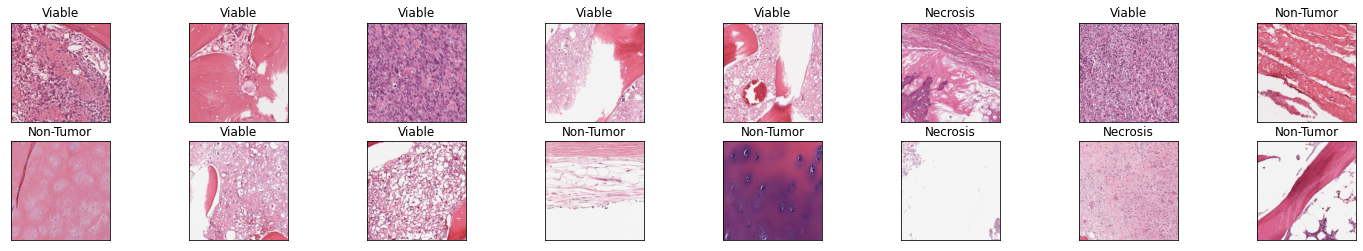

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # Converted Image to numpy

# plot the images in the batch, along with the corresponding labels

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

**Taking DenseNet-121 model and freeze the layers without classifier**

In [ ]:
import torch.nn as nn
from torchvision.models import densenet121, DenseNet121_Weights
# DEFAULT weights give us best available weights 
weights = DenseNet121_Weights.DEFAULT   # try  IMAGENET1K_V1 too to compare performance 
model = densenet121(weights= weights)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [ ]:
# freezing layers to use pre-trained weights
for param in model.parameters():
        param.requires_grad = False

# we will extract 1024 features from densnet pre trained model
model.classifier = nn.Linear(1024, 1024)

# demo
x = torch.rand(4, 3, 224, 224)
out = model.forward(x)
print(out.shape)

torch.Size([4, 1024])


**train features**

In [ ]:
# feature extraction for training images
x_train = []
y_train = []
model.eval()
for data, target in train_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)
    x_train.append(output)

    if torch.cuda.is_available():
        target = torch.tensor(target, device= 'cpu')
    target = target.numpy()
    target = target.astype(int)
    y_train.append(target)

**test features**

In [ ]:
# feature extraction for test images 

x_test = []
y_test = []
model.eval()
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    output = model(data)
    x_test.append(output)

    if torch.cuda.is_available():
        target = torch.tensor(target, device= 'cpu')

    target = target.numpy()
    target = target.astype(int)
    y_test.append(target)

In [ ]:
# As we are getting data from dataloader, so data are inserted as batch size
# that's why we need to convert this into 1D list 
from itertools import chain
x_train_features = list(chain.from_iterable(x_train))
x_test_features = list(chain.from_iterable(x_test))

print("Total training features: ", len(x_train_features))
print("Total test features: ", len(x_test_features))

In [ ]:
# converting labels into one dimensional list 
y_train = list(chain.from_iterable(y_train))
y_test = list(chain.from_iterable(y_test))

print("Total training labels: ", len(y_train))
print("Total test labels: ", len(y_test))

Total training labels:  916
Total test labels:  228


In [ ]:
for i in range(len(x_train_features)):
    # x_train_features[i] = x_train_features[i].numpy()
    if torch.cuda.is_available():
        x_train_features[i] = x_train_features[i].cpu().detach().numpy()   # if use GPU
    else:
      x_train_features[i] = x_train_features[i].detach().numpy()  

#converting list to numpy array
x_train_features = np.array(x_train_features)
print("Shape of training features: ",x_train_features.shape)

Shape of training features:  (916, 1024)


In [ ]:
for i in range(len(x_test_features)):
    # x_test_features[i] = x_test_features[i].numpy()
    if torch.cuda.is_available():
        x_test_features[i] = x_test_features[i].cpu().detach().numpy()
    else:
      x_test_features[i] = x_test_features[i].detach().numpy()

# converting list to numpy array
x_test_features = np.array(x_test_features)
print("Shape of test features: ",x_test_features.shape)

Shape of test features:  (228, 1024)


In [ ]:
#Convert label lists to arrays                
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Shape of training labels: ", y_train.shape)
print("Shape of test labels: ", y_test.shape)

Shape of training labels:  (916,)
Shape of test labels:  (228,)
Shape of training labels:  (916,)
Shape of test labels:  (228,)


**x_train_features and x_test_features are our raw features that got after feature extraction**

**Feature scaling**

In [ ]:
# Feature scaling 
# Scaling train and test features
import pickle
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(x_train_features)
X_test = sc.transform(x_test_features)


print("After scaling train: ", X_train.shape)
print("After scaling test size: ", X_test.shape)

# save feature scaler as pickle
# pickle_out = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_scaling.pkl", "wb")
# pickle.dump(sc, pickle_out)
# pickle_out.close()

After scaling train:  (916, 1024)
After scaling test size:  (228, 1024)


# feature selection with default criterion(gini) and classification with deafult optimizer (adam)

In [ ]:
# creating a pickle file for using serialization
import pickle

# Without feature selection
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
# mlp_classifier.fit(x_train_features, y_train)
mlp_classifier.fit(X_train, y_train)

# predicting through test data
# mlp_pred = mlp_classifier.predict(x_test_features)
mlp_pred = mlp_classifier.predict(X_test)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(x_test_features), multi_class='ovr')
roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(X_test), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))
# plot roc curve 
# change class names non-viable to necrosis

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# print loss 
mlp_loss = mlp_classifier.loss_
print("Loss value: ", mlp_loss)

# plot loss graph
label = "constant learning-rate"
plt.plot(mlp_classifier.loss_curve_, label= label)
plt.show()

# save the classifier as pickle
pickle_out = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_without_fs_mlp.pkl", "wb")
pickle.dump(mlp_classifier, pickle_out)
pickle_out.close()

Accuracy =  0.961
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.0018386917594478641


In [ ]:
# use score 
train_acc = mlp_classifier.score(X_train, y_train)
test_acc = mlp_classifier.score(X_test, y_test)
print("Training Accuracy: ", train_acc)
print("Test accuracy: ", test_acc)

Training Accuracy:  1.0
Test accuracy:  0.9605263157894737


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, mlp_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           1       0.94      0.94      0.94        47
           2       0.97      0.95      0.96        79

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228



In [ ]:
# function to measure TP, FP, TN, FN

def perf_measure(y_actual, y_pred):
    class_id = set(y_actual).union(set(y_pred))
    TP = []
    FP = []
    TN = []
    FN = []

    for index ,_id in enumerate(class_id):
        TP.append(0)
        FP.append(0)
        TN.append(0)
        FN.append(0)
        for i in range(len(y_pred)):
            if y_actual[i] == y_pred[i] == _id:
                TP[index] += 1
            if y_pred[i] == _id and y_actual[i] != y_pred[i]:
                FP[index] += 1
            if y_actual[i] == y_pred[i] != _id:
                TN[index] += 1
            if y_pred[i] != _id and y_actual[i] != y_pred[i]:
                FN[index] += 1


    return class_id,TP, FP, TN, FN

In [ ]:
# function to get sensitivity and specificity
def get_sn_sp(y_test, mlp_pred):
  c, tp, fp, tn, fn = perf_measure(y_test, mlp_pred)

  # for class 0
  tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

  # precision= TP/(TP + FP)
  precision_0 = tp_0 /(tp_0 + fp_0)
  precision_0 = np.round(precision_0, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_0 = tp_0 / (tp_0 + fn_0)
  recall_0 = np.round(recall_0, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_0 = tn_0 / (tn_0 + fp_0)
  speci_0 = np.round(speci_0, 3)

  #### for class 1
  tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

  # precision= TP/(TP + FP)
  precision_1 = tp_1 /(tp_1 + fp_1)
  precision_1 = np.round(precision_1, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_1 = tp_1 / (tp_1 + fn_1)
  recall_1 = np.round(recall_1, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_1 = tn_1 / (tn_1 + fp_1)
  speci_1 = np.round(speci_1, 3)

  ### for class 2
  tp_2, fp_2, tn_2, fn_2 = tp[2], fp[2], tn[2], fn[2]

  # precision= TP/(TP + FP)
  precision_2 = tp_2 /(tp_2 + fp_2)
  precision_2 = np.round(precision_2, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_2 = tp_2 / (tp_2 + fn_2)
  recall_2 = np.round(recall_2, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_2 = tn_2 / (tn_2 + fp_2)
  speci_2 = np.round(speci_2, 3)

  c_0, c_1, c_2 = 'Non-Tumor', 'Necrosis', 'Viable'
  print("class \tclass_name \tprecision \tsensitivity(recall) \tspecificity ")
  print('--------------------------------------------------------------------------')
  print(str(0).center(5), c_0.center(15), str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
  print(str(1).center(5), c_1.center(15), str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))
  print(str(2).center(5), c_2.center(15), str(precision_2).center(15), '\t',str(recall_2).center(15), '\t', str(speci_2).center(10))

In [ ]:
# print sensitivity and specificity
get_sn_sp(y_test, mlp_pred)

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.962     	      0.952      	   0.967   
  1       Necrosis        0.936     	       0.88      	   0.983   
  2        Viable          0.974      	      0.915      	   0.986   


In [ ]:
# Function to plot confusion matrix

from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize= False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
        title = "Normalized Confusion Matrix"
    else:
        # print('Confusion matrix, without normalization')
        title = "Confusion Matrix"

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

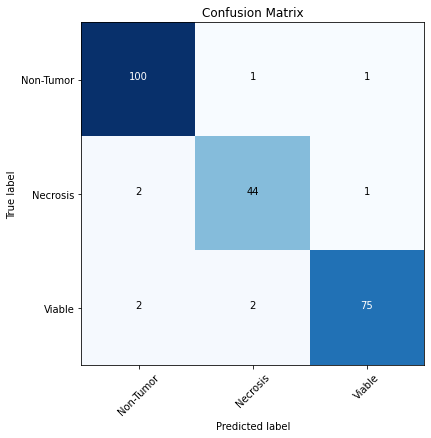

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, mlp_pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**ROC Curve**

In [ ]:
y_test.shape

(228,)

In [ ]:
mlp_pred

array([1, 2, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1, 0, 1, 0, 2, 0,
       1, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 2, 1, 0, 2, 2, 2, 1, 1, 0, 0,
       2, 2, 0, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 2, 0, 1, 0, 2, 0, 2, 2, 1,
       2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 1, 2, 2, 0, 0, 1, 1, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 1, 1, 0, 2, 0, 2, 0,
       1, 2, 1, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 2, 1, 2, 0, 2, 0, 0,
       2, 0, 1, 0, 1, 2, 0, 1, 2, 0, 0, 1, 0, 0, 1, 2, 1, 2, 2, 1, 0, 2,
       0, 2, 1, 2, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 0, 2, 1, 1, 2, 1, 2, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 2, 0, 1, 1, 1, 2])

**applying RFE**

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=100)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)


In [ ]:
# function to feature selection using RFE
def feat_select(criterion_n, num_feat):
  # defining estimator
  estimator_n = DecisionTreeClassifier(random_state=1, criterion= criterion_n)
  # defining RFE, we used decision tree classifier as estimator
  rfe = RFE(estimator= estimator_n, n_features_to_select= num_feat)

  # fit our train data into RFE 
  rfe.fit(X_train, y_train)

  # getting transformed train features
  X_train_rfe = rfe.transform(X_train)

  # getting transformed test features
  X_test_rfe = rfe.transform(X_test)

  print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
  print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)
  return X_train_rfe, X_test_rfe

In [ ]:
# function to get prediction with MLP classifier

def mlp_class_plot(optimizer_name, num_iteration, train_data, test_data):

  # defining MLP classifier 
  mlp_rfe = MLPClassifier(random_state=1, solver=optimizer_name,  max_iter= num_iteration)

  # fitting training data 
  mlp_rfe.fit(train_data, y_train)

  # getting k-fold validation accuracy, we are taking k= 5 folds
  k_fold_acc = cross_val_score(mlp_rfe, train_data, y_train, cv= 5)

  # taking mean of 5 folds accuracy
  k_fold_mean = k_fold_acc.mean()

  print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

  # predicting through test data
  mlp_p = mlp_rfe.predict(test_data)

  #Print overall accuracy
  from sklearn import metrics
  acc = metrics.accuracy_score(y_test, mlp_p)
  print ("Accuracy on test data is: ", round(acc, 3))

  # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
  from sklearn.metrics import roc_auc_score

  roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(test_data), multi_class='ovr')
  print("ROC-AUC score is: ", round(roc_auc, 3))

  # Compute the Matthews correlation coefficient (MCC)
  from sklearn.metrics import matthews_corrcoef
  mcc = matthews_corrcoef(y_test, mlp_p)
  print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

  # print loss 
  mlp_loss = mlp_rfe.loss_
  print("Loss value: ", mlp_loss)

  # plot loss graph
  label = "constant learning-rate"
  plt.plot(mlp_rfe.loss_curve_, label= label)
  plt.show()
  
  return mlp_p

In [ ]:
# function to get prediction with MLP classifier

def mlp_class_wo_plot(optimizer_name, num_iteration, train_data, test_data):

  # defining MLP classifier 
  mlp_rfe = MLPClassifier(random_state=1, solver=optimizer_name,  max_iter= num_iteration)

  # fitting training data 
  mlp_rfe.fit(train_data, y_train)

  # getting k-fold validation accuracy, we are taking k= 5 folds
  k_fold_acc = cross_val_score(mlp_rfe, train_data, y_train, cv= 5)

  # taking mean of 5 folds accuracy
  k_fold_mean = k_fold_acc.mean()

  print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

  # predicting through test data
  mlp_p = mlp_rfe.predict(test_data)

  #Print overall accuracy
  from sklearn import metrics
  acc = metrics.accuracy_score(y_test, mlp_p)
  print ("Accuracy on test data is: ", round(acc, 3))

  # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
  from sklearn.metrics import roc_auc_score

  roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(test_data), multi_class='ovr')
  print("ROC-AUC score is: ", round(roc_auc, 3))

  # Compute the Matthews correlation coefficient (MCC)
  from sklearn.metrics import matthews_corrcoef
  mcc = matthews_corrcoef(y_test, mlp_p)
  print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

  # print loss 
  mlp_loss = mlp_rfe.loss_
  print("Loss value: ", mlp_loss)
  
  return mlp_p

# Multi-class classification

### 100

#### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 100)

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)


**adam**

k-fold validation accuracy for k=5 is:  0.912
Accuracy on test data is:  0.934
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.893
Loss value:  0.005392787332461911


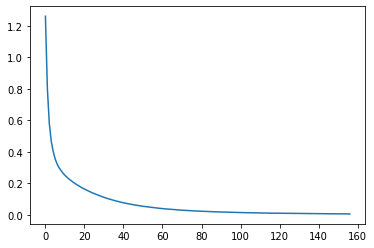

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       111
           1       0.86      0.89      0.88        36
           2       0.96      0.90      0.93        81

    accuracy                           0.93       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.94      0.93      0.93       228



In [ ]:
# print sensitivity and specificity
get_sn_sp(y_test, pred)

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.939     	      0.931      	   0.938   
  1       Necrosis        0.865     	      0.762      	   0.973   
  2        Viable          0.961      	      0.859      	   0.979   


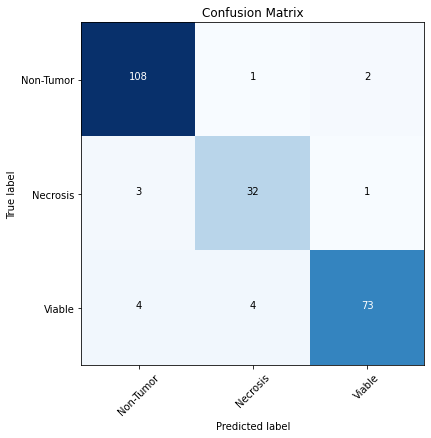

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.91
Accuracy on test data is:  0.934
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.894
Loss value:  0.05036328697298291


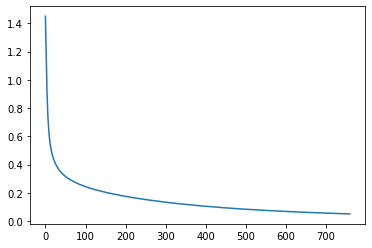

In [ ]:
# gini, sgd, 100
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       111
           1       0.80      0.92      0.86        36
           2       0.96      0.90      0.93        81

    accuracy                           0.93       228
   macro avg       0.91      0.93      0.92       228
weighted avg       0.94      0.93      0.94       228



In [ ]:
# print sensitivity and specificity
get_sn_sp(y_test, pred)

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.964     	      0.907      	   0.964   
  1       Necrosis        0.805     	      0.825      	   0.957   
  2        Viable          0.961      	      0.859      	   0.979   


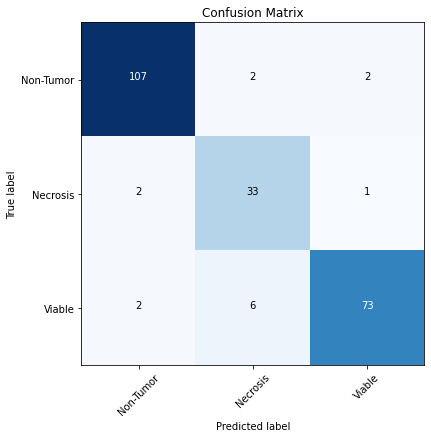

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbfgs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.896
Accuracy on test data is:  0.912
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.857
Loss value:  8.933171779242732e-05


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       111
           1       0.83      0.83      0.83        36
           2       0.91      0.90      0.91        81

    accuracy                           0.91       228
   macro avg       0.89      0.89      0.89       228
weighted avg       0.91      0.91      0.91       228



In [ ]:
 # print sensitivity and specificity
get_sn_sp(y_test, pred)

class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.938     	       0.89      	   0.936   
  1       Necrosis        0.833     	      0.682      	   0.967   
  2        Viable          0.912      	      0.849      	   0.951   


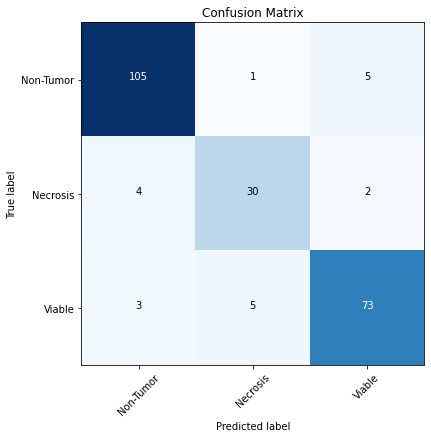

In [ ]:
# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

#### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 100)

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)


**adam**

k-fold validation accuracy for k=5 is:  0.906
Accuracy on test data is:  0.93
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.888
Loss value:  0.0051139120155026295


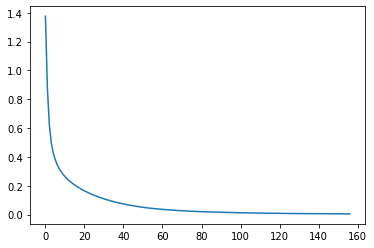

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       111
           1       0.81      0.94      0.87        36
           2       0.99      0.86      0.92        81

    accuracy                           0.93       228
   macro avg       0.91      0.93      0.92       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.939     	      0.923      	   0.937   
  1       Necrosis         0.81     	       0.81      	   0.957   
  2        Viable          0.986      	      0.824      	   0.993   




**sgd**

In [ ]:
# entropy, sgd, 100
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.904
Accuracy on test data is:  0.93
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.888
Loss value:  0.04613196367801017


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       111
           1       0.79      0.92      0.85        36
           2       1.00      0.88      0.93        81

    accuracy                           0.93       228
   macro avg       0.91      0.92      0.91       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.939     	      0.923      	   0.937   
  1       Necrosis        0.786     	      0.825      	   0.952   
  2        Viable           1.0       	      0.816      	    1.0    




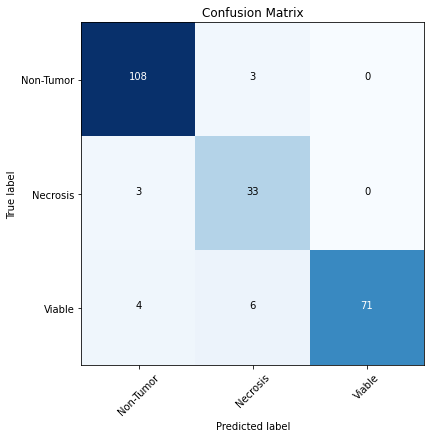

In [ ]:
# getting classification report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbfgs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.898
Accuracy on test data is:  0.912
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.857
Loss value:  0.0001464068391857669


In [ ]:
# getting classification report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       111
           1       0.77      0.83      0.80        36
           2       0.95      0.89      0.92        81

    accuracy                           0.91       228
   macro avg       0.88      0.89      0.89       228
weighted avg       0.91      0.91      0.91       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.938     	      0.891      	   0.936   
  1       Necrosis        0.769     	      0.732      	   0.952   
  2        Viable          0.947      	      0.818      	   0.971   




### 200

#### gini

In [ ]:
# getting 200 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 200)

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.923
Accuracy on test data is:  0.939
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.9
Loss value:  0.0034110121002363845


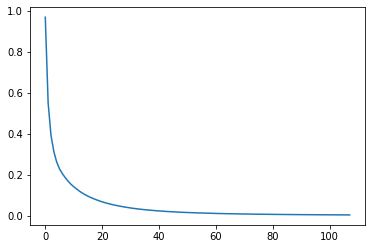

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       111
           1       0.84      0.86      0.85        36
           2       0.96      0.91      0.94        81

    accuracy                           0.94       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.924      	   0.955   
  1       Necrosis        0.838     	      0.795      	   0.968   
  2        Viable          0.961      	      0.871      	   0.979   




**SGD**

k-fold validation accuracy for k=5 is:  0.92
Accuracy on test data is:  0.917
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.864
Loss value:  0.035787575707112856


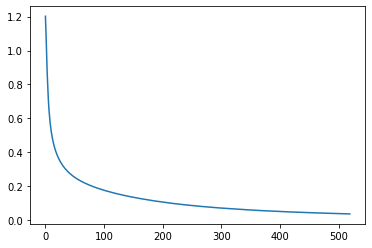

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       111
           1       0.81      0.81      0.81        36
           2       0.95      0.90      0.92        81

    accuracy                           0.92       228
   macro avg       0.89      0.89      0.89       228
weighted avg       0.92      0.92      0.92       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor         0.93     	      0.907      	   0.927   
  1       Necrosis        0.806     	      0.707      	   0.963   
  2        Viable          0.948      	       0.83      	   0.971   




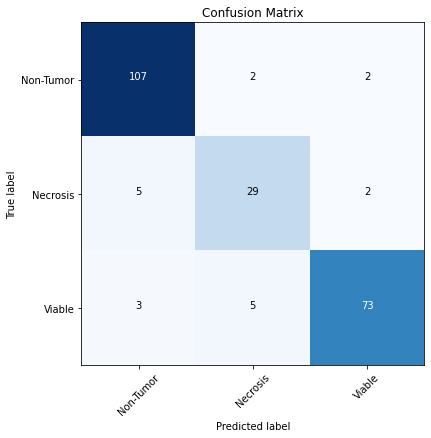

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbfgs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.906
Accuracy on test data is:  0.93
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.886
Loss value:  0.00010652502401366535


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       111
           1       0.82      0.86      0.84        36
           2       0.96      0.90      0.93        81

    accuracy                           0.93       228
   macro avg       0.91      0.91      0.91       228
weighted avg       0.93      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.947     	      0.915      	   0.945   
  1       Necrosis        0.816     	      0.775      	   0.963   
  2        Viable          0.961      	      0.849      	   0.979   




#### entropy

In [ ]:
# getting 200 features using gini
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 200)

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)


**adam**

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.913
Accuracy on test data is:  0.952
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.0038129209935925416


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.85      0.92      0.88        36
           2       1.00      0.94      0.97        81

    accuracy                           0.95       228
   macro avg       0.93      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.947      	   0.956   
  1       Necrosis        0.846     	      0.868      	   0.968   
  2        Viable           1.0       	      0.874      	    1.0    




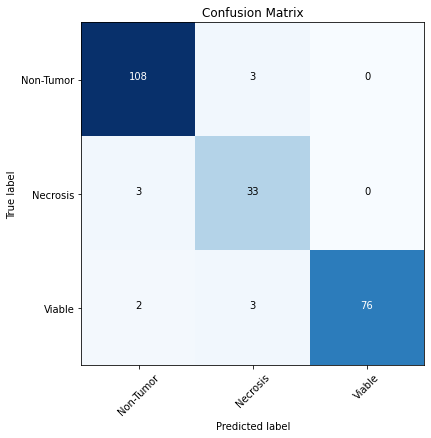

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**sgd**

k-fold validation accuracy for k=5 is:  0.908
Accuracy on test data is:  0.947
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.915
Loss value:  0.03596105324644189


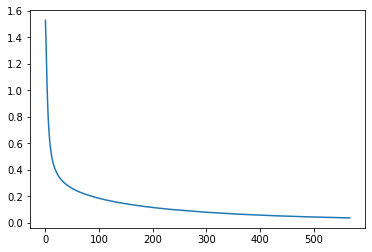

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.82      0.92      0.87        36
           2       1.00      0.93      0.96        81

    accuracy                           0.95       228
   macro avg       0.93      0.94      0.93       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.939      	   0.956   
  1       Necrosis        0.825     	      0.868      	   0.963   
  2        Viable           1.0       	      0.862      	    1.0    




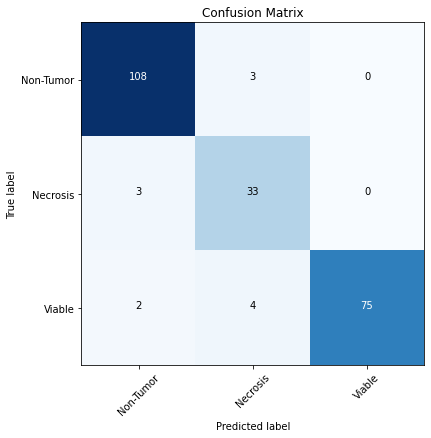

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbfgs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.915
Accuracy on test data is:  0.917
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.865
Loss value:  0.00011945973584942342


              precision    recall  f1-score   support

           0       0.95      0.93      0.94       111
           1       0.84      0.89      0.86        36
           2       0.90      0.91      0.91        81

    accuracy                           0.92       228
   macro avg       0.90      0.91      0.90       228
weighted avg       0.92      0.92      0.92       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.954     	       0.88      	   0.955   
  1       Necrosis        0.842     	      0.711      	   0.967   
  2        Viable          0.902      	      0.871      	   0.944   




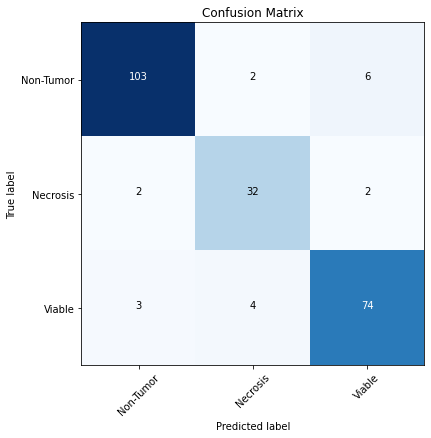

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

### 300

#### gini

In [ ]:
# getting 300 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 300)

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.918
Accuracy on test data is:  0.956
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.929
Loss value:  0.0030151915519518622


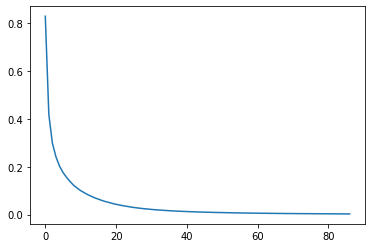

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       111
           1       0.89      0.89      0.89        36
           2       0.99      0.94      0.96        81

    accuracy                           0.96       228
   macro avg       0.94      0.94      0.94       228
weighted avg       0.96      0.96      0.96       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.957     	      0.957      	   0.956   
  1       Necrosis        0.889     	      0.842      	   0.979   
  2        Viable          0.987      	      0.894      	   0.993   




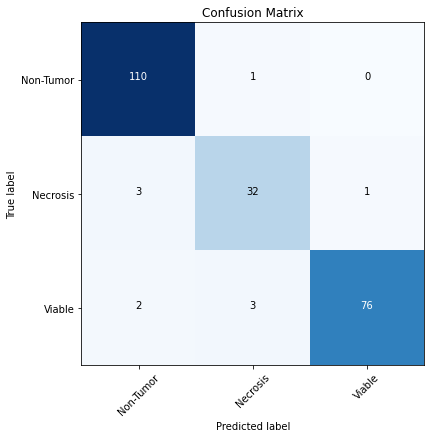

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.912
Accuracy on test data is:  0.943
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.907
Loss value:  0.030423068283895217


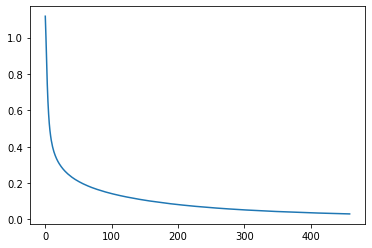

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       111
           1       0.84      0.89      0.86        36
           2       0.97      0.91      0.94        81

    accuracy                           0.94       228
   macro avg       0.92      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.932      	   0.955   
  1       Necrosis        0.842     	      0.821      	   0.968   
  2        Viable          0.974      	      0.871      	   0.986   




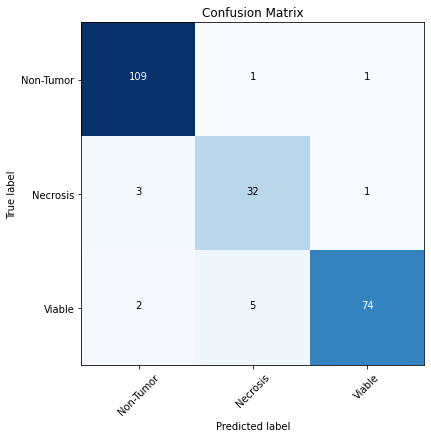

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbfgs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.947
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.914
Loss value:  5.721808312195017e-05


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       111
           1       0.86      0.89      0.88        36
           2       0.96      0.94      0.95        81

    accuracy                           0.95       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.964     	      0.931      	   0.964   
  1       Necrosis        0.865     	      0.821      	   0.974   
  2        Viable          0.962      	      0.894      	   0.979   




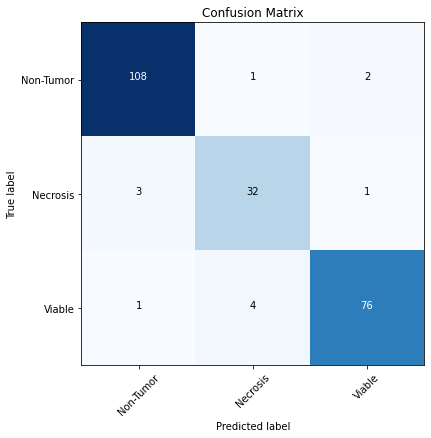

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

#### entropy

In [ ]:
# getting 300 features using entropy
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 300)

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.91
Accuracy on test data is:  0.952
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.003036287432674758


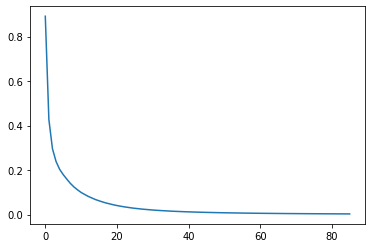

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       111
           1       0.85      0.92      0.88        36
           2       0.99      0.94      0.96        81

    accuracy                           0.95       228
   macro avg       0.93      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.964     	      0.939      	   0.965   
  1       Necrosis        0.846     	      0.868      	   0.968   
  2        Viable          0.987      	      0.884      	   0.993   




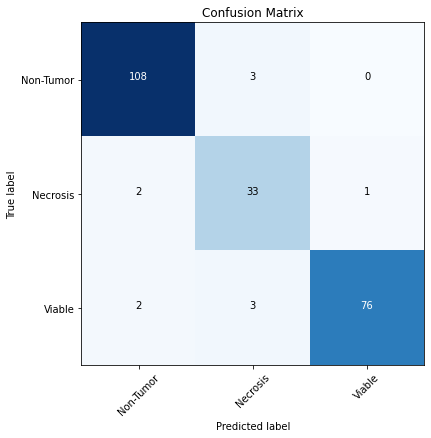

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.908
Accuracy on test data is:  0.939
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.9
Loss value:  0.0285487236452415


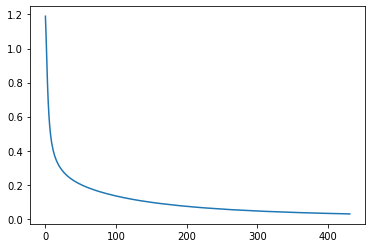

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.84      0.89      0.86        36
           2       0.96      0.91      0.94        81

    accuracy                           0.94       228
   macro avg       0.92      0.93      0.92       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.923      	   0.955   
  1       Necrosis        0.842     	       0.8       	   0.968   
  2        Viable          0.961      	      0.871      	   0.979   




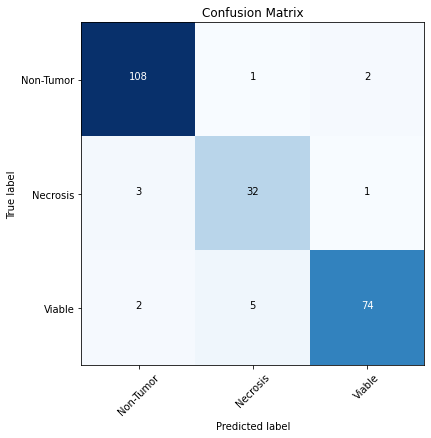

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.914
Accuracy on test data is:  0.943
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.907
Loss value:  9.197298294654175e-05


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.86      0.86      0.86        36
           2       0.96      0.94      0.95        81

    accuracy                           0.94       228
   macro avg       0.93      0.92      0.93       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.931      	   0.955   
  1       Necrosis        0.861     	      0.795      	   0.974   
  2        Viable          0.962      	      0.884      	   0.979   




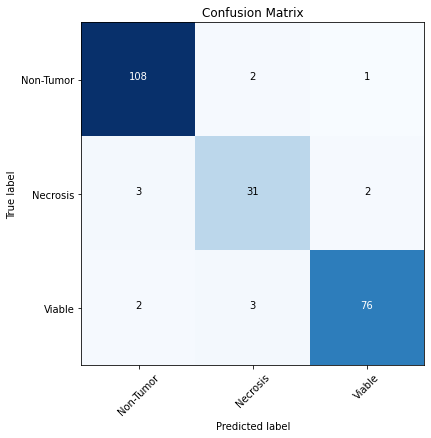

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

### 400

#### gini

In [ ]:
# getting 300 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 400)

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.91
Accuracy on test data is:  0.961
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.936
Loss value:  0.0026215447717358453


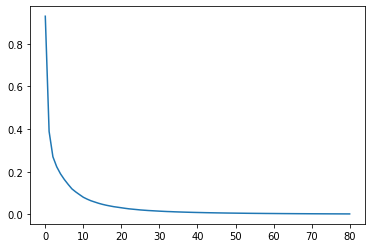

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       111
           1       0.87      0.94      0.91        36
           2       0.99      0.94      0.96        81

    accuracy                           0.96       228
   macro avg       0.94      0.95      0.95       228
weighted avg       0.96      0.96      0.96       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.973     	      0.948      	   0.973   
  1       Necrosis        0.872     	      0.895      	   0.974   
  2        Viable          0.987      	      0.905      	   0.993   




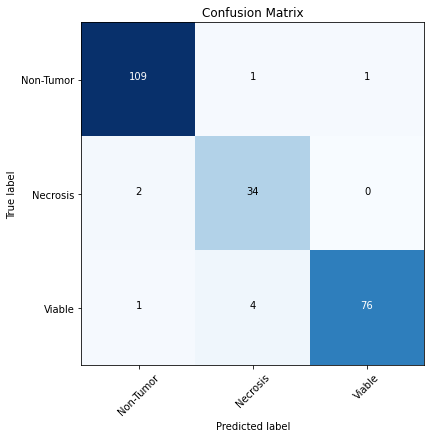

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.905
Accuracy on test data is:  0.952
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.025871706823594708


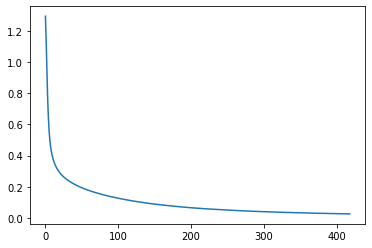

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       111
           1       0.85      0.92      0.88        36
           2       1.00      0.93      0.96        81

    accuracy                           0.95       228
   macro avg       0.93      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.948      	   0.956   
  1       Necrosis        0.846     	      0.868      	   0.968   
  2        Viable           1.0       	      0.872      	    1.0    




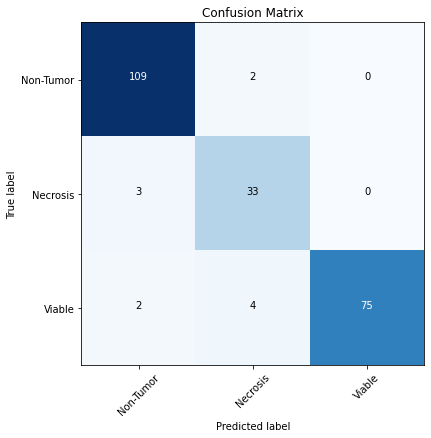

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.912
Accuracy on test data is:  0.947
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.914
Loss value:  7.001552498272385e-05


              precision    recall  f1-score   support

           0       0.96      0.98      0.97       111
           1       0.89      0.86      0.87        36
           2       0.95      0.94      0.94        81

    accuracy                           0.95       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.965     	      0.932      	   0.964   
  1       Necrosis        0.886     	      0.795      	   0.979   
  2        Viable           0.95      	      0.905      	   0.972   




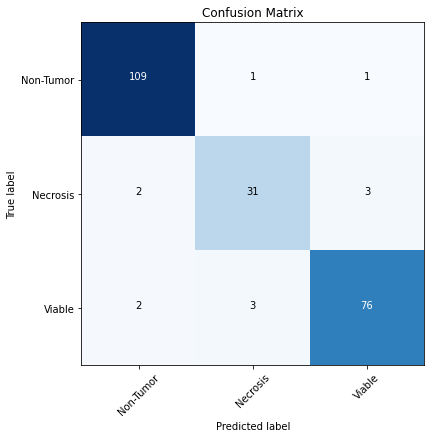

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

#### entropy

In [ ]:
# getting 300 features using entropy
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 400)

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.92
Accuracy on test data is:  0.947
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.915
Loss value:  0.0030084322324486277


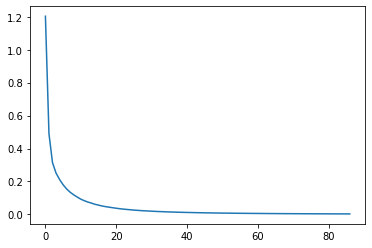

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       111
           1       0.87      0.92      0.89        36
           2       0.99      0.91      0.95        81

    accuracy                           0.95       228
   macro avg       0.93      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.948     	      0.948      	   0.947   
  1       Necrosis        0.868     	      0.825      	   0.973   
  2        Viable          0.987      	      0.871      	   0.993   




**SGD**

k-fold validation accuracy for k=5 is:  0.919
Accuracy on test data is:  0.934
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.893
Loss value:  0.025525402284657592


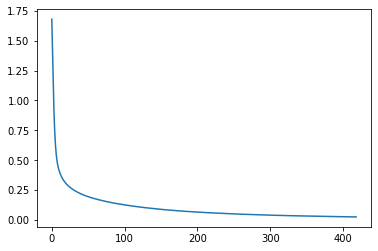

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       111
           1       0.84      0.86      0.85        36
           2       0.99      0.90      0.94        81

    accuracy                           0.93       228
   macro avg       0.92      0.91      0.92       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.932     	       0.94      	   0.929   
  1       Necrosis        0.838     	      0.775      	   0.968   
  2        Viable          0.986      	      0.839      	   0.993   




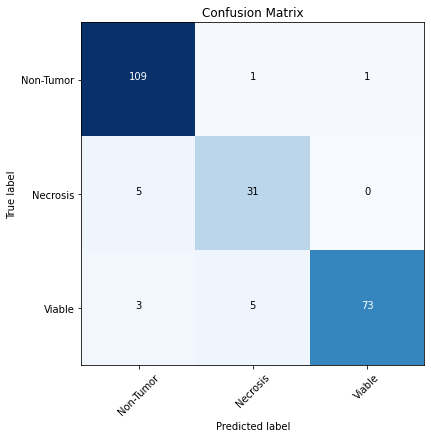

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.919
Accuracy on test data is:  0.943
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.907
Loss value:  0.00013809035447411648


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.87      0.92      0.89        36
           2       0.96      0.91      0.94        81

    accuracy                           0.94       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.931      	   0.955   
  1       Necrosis        0.868     	      0.805      	   0.973   
  2        Viable          0.961      	      0.881      	   0.979   




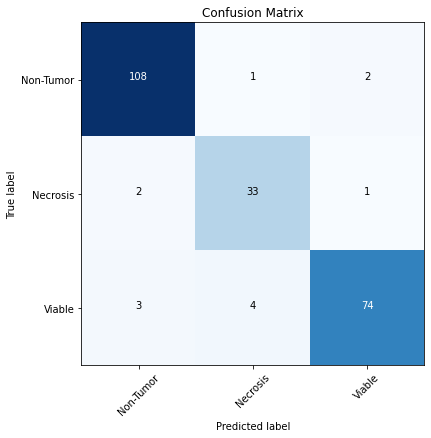

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

### 500

#### gini

In [ ]:
# getting 300 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 500)

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.915
Accuracy on test data is:  0.947
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.914
Loss value:  0.0025695049214571326


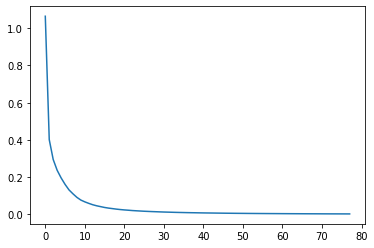

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.84      0.89      0.86        36
           2       0.99      0.94      0.96        81

    accuracy                           0.95       228
   macro avg       0.93      0.93      0.93       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.939      	   0.956   
  1       Necrosis        0.842     	      0.842      	   0.968   
  2        Viable          0.987      	      0.874      	   0.993   




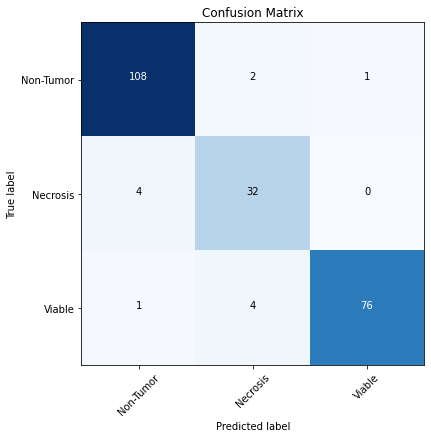

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**sgd**

k-fold validation accuracy for k=5 is:  0.914
Accuracy on test data is:  0.934
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.894
Loss value:  0.02340514864624848


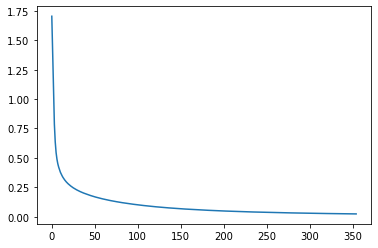

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.80      0.89      0.84        36
           2       0.97      0.90      0.94        81

    accuracy                           0.93       228
   macro avg       0.91      0.92      0.91       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.915      	   0.955   
  1       Necrosis         0.8      	      0.821      	   0.958   
  2        Viable          0.973      	      0.849      	   0.986   




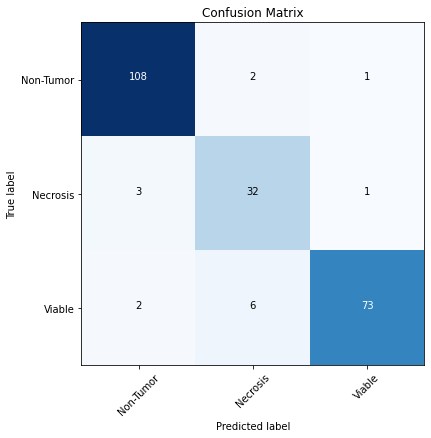

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.914
Accuracy on test data is:  0.93
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.886
Loss value:  0.00012187999707871087


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       111
           1       0.82      0.89      0.85        36
           2       0.95      0.93      0.94        81

    accuracy                           0.93       228
   macro avg       0.91      0.92      0.91       228
weighted avg       0.93      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.955     	      0.905      	   0.955   
  1       Necrosis        0.821     	       0.78      	   0.963   
  2        Viable          0.949      	      0.862      	   0.972   




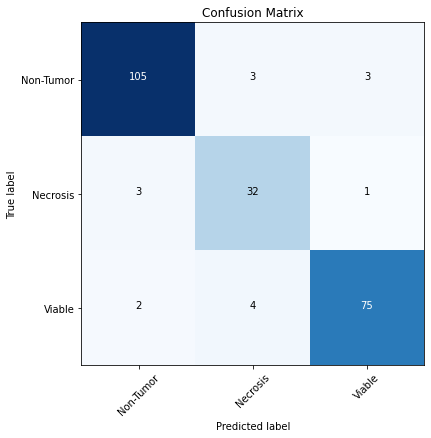

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

#### entropy

In [ ]:
# getting 300 features using entropy
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 500)

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.92
Accuracy on test data is:  0.943
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.907
Loss value:  0.002459689610077304


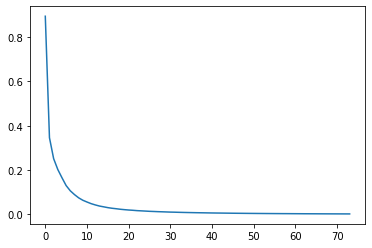

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       111
           1       0.84      0.89      0.86        36
           2       0.96      0.94      0.95        81

    accuracy                           0.94       228
   macro avg       0.92      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.964     	      0.922      	   0.964   
  1       Necrosis        0.842     	      0.821      	   0.968   
  2        Viable          0.962      	      0.884      	   0.979   




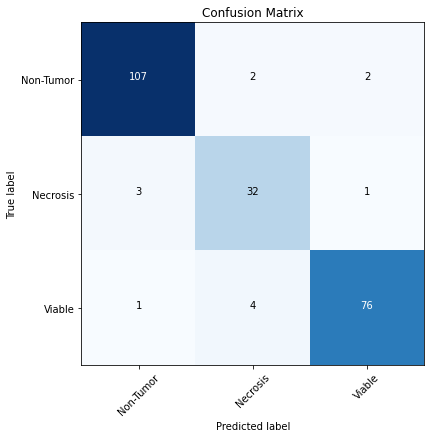

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.918
Accuracy on test data is:  0.939
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.901
Loss value:  0.02330441041018765


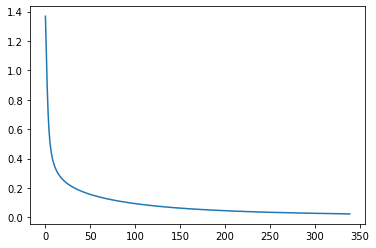

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       111
           1       0.80      0.89      0.84        36
           2       0.99      0.93      0.96        81

    accuracy                           0.94       228
   macro avg       0.91      0.93      0.92       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.955     	      0.922      	   0.955   
  1       Necrosis         0.8      	      0.842      	   0.958   
  2        Viable          0.987      	      0.852      	   0.993   




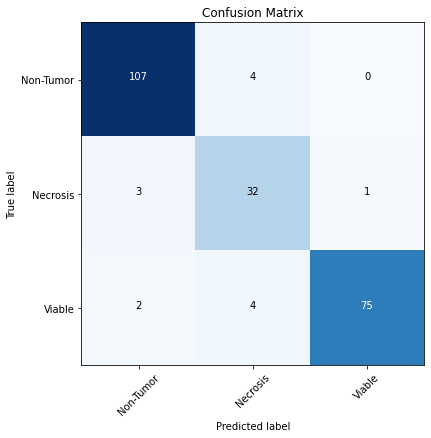

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.934
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.893
Loss value:  0.0001415655518976351


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       111
           1       0.82      0.89      0.85        36
           2       0.97      0.94      0.96        81

    accuracy                           0.93       228
   macro avg       0.91      0.92      0.92       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.946     	      0.921      	   0.947   
  1       Necrosis        0.821     	       0.8       	   0.963   
  2        Viable          0.974      	      0.854      	   0.986   




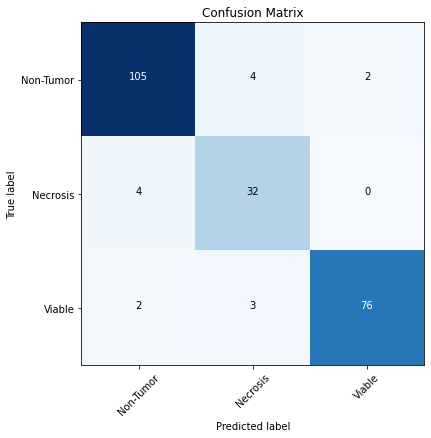

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

### 600

#### gini

In [ ]:
# getting 300 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 600)

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.918
Accuracy on test data is:  0.943
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.907
Loss value:  0.002473447336640421


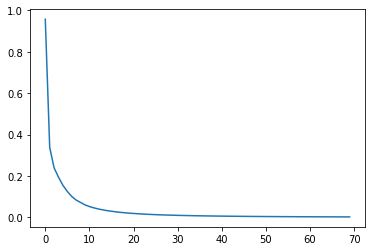

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       111
           1       0.84      0.86      0.85        36
           2       0.99      0.91      0.95        81

    accuracy                           0.94       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.948     	       0.94      	   0.946   
  1       Necrosis        0.838     	      0.816      	   0.968   
  2        Viable          0.987      	       0.86      	   0.993   




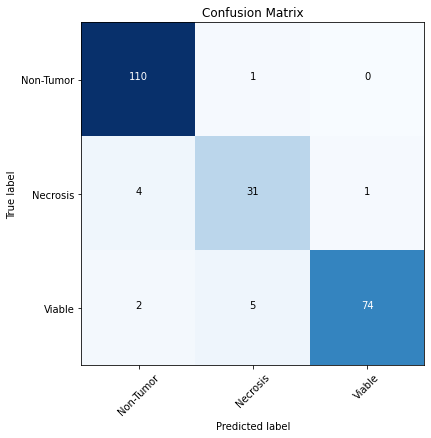

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.921
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.872
Loss value:  0.02257571206405173


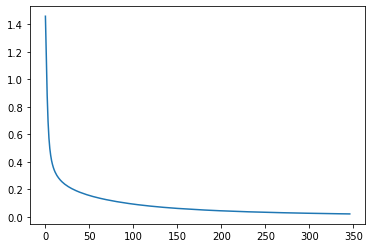

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       111
           1       0.79      0.83      0.81        36
           2       0.97      0.89      0.93        81

    accuracy                           0.92       228
   macro avg       0.90      0.90      0.90       228
weighted avg       0.92      0.92      0.92       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.931     	      0.915      	   0.927   
  1       Necrosis        0.789     	       0.75      	   0.957   
  2        Viable          0.973      	      0.818      	   0.986   




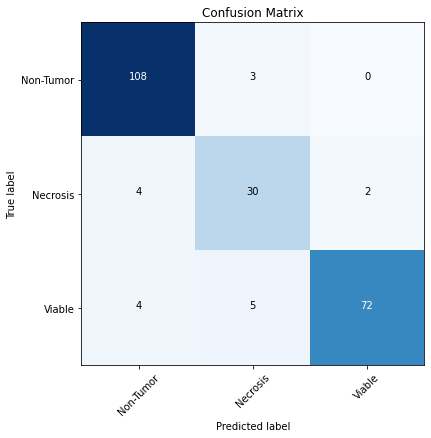

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.934
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.893
Loss value:  0.0001129858885558402


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       111
           1       0.82      0.86      0.84        36
           2       0.96      0.94      0.95        81

    accuracy                           0.93       228
   macro avg       0.91      0.92      0.91       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.955     	      0.914      	   0.955   
  1       Necrosis        0.816     	      0.795      	   0.963   
  2        Viable          0.962      	      0.864      	   0.979   




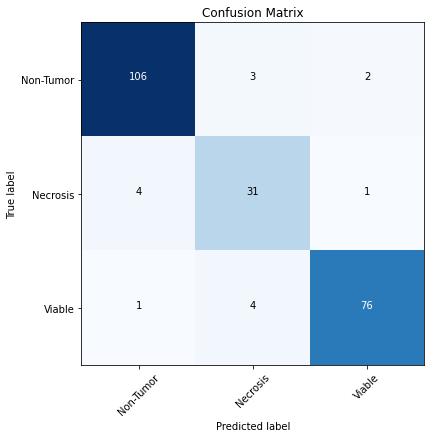

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

#### entropy

In [ ]:
# getting 300 features using entropy
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 600)

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.919
Accuracy on test data is:  0.939
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.9
Loss value:  0.002625811355343031


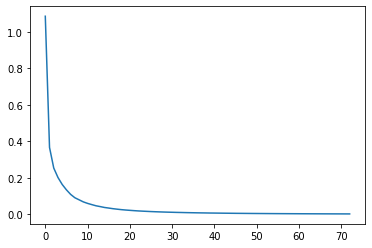

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       111
           1       0.85      0.92      0.88        36
           2       0.96      0.91      0.94        81

    accuracy                           0.94       228
   macro avg       0.92      0.93      0.93       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.955     	      0.922      	   0.955   
  1       Necrosis        0.846     	      0.805      	   0.968   
  2        Viable          0.961      	      0.871      	   0.979   




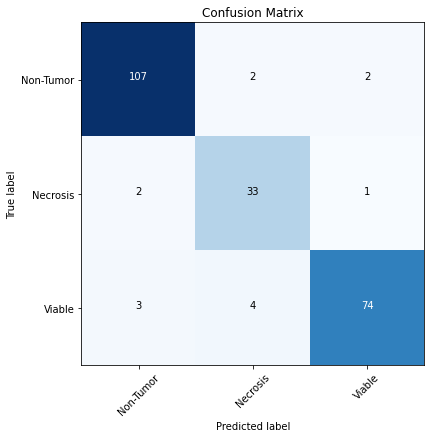

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.92
Accuracy on test data is:  0.925
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.879
Loss value:  0.022261824367660624


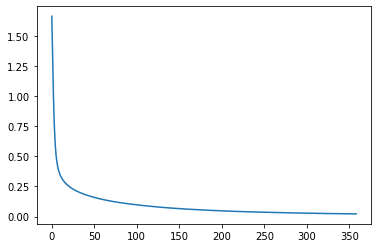

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       111
           1       0.84      0.86      0.85        36
           2       0.96      0.89      0.92        81

    accuracy                           0.93       228
   macro avg       0.91      0.91      0.91       228
weighted avg       0.93      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.931     	      0.923      	   0.928   
  1       Necrosis        0.838     	      0.738      	   0.968   
  2        Viable           0.96      	      0.837      	   0.979   




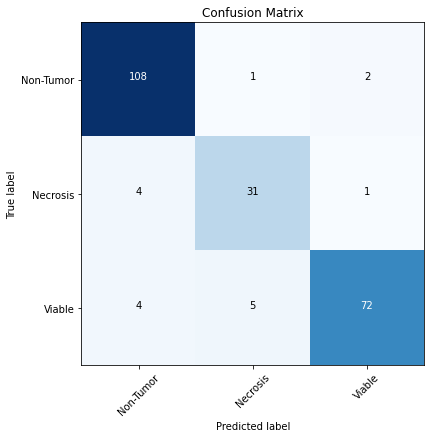

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lgbfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.906
Accuracy on test data is:  0.917
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.865
Loss value:  3.155063787847521e-05


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       111
           1       0.76      0.86      0.81        36
           2       0.96      0.89      0.92        81

    accuracy                           0.92       228
   macro avg       0.89      0.90      0.89       228
weighted avg       0.92      0.92      0.92       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.946     	      0.891      	   0.945   
  1       Necrosis        0.756     	      0.775      	   0.947   
  2        Viable           0.96      	      0.818      	   0.979   




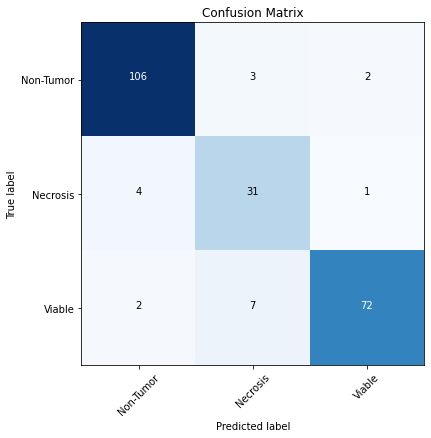

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

### 700

#### gini

In [ ]:
# getting 300 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 700)

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)


**adam**

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.934
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.893
Loss value:  0.0024668814041989336


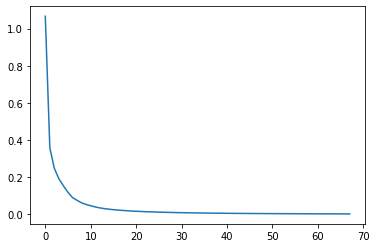

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       111
           1       0.79      0.86      0.83        36
           2       0.97      0.90      0.94        81

    accuracy                           0.93       228
   macro avg       0.91      0.91      0.91       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.916      	   0.954   
  1       Necrosis        0.795     	      0.816      	   0.958   
  2        Viable          0.973      	      0.849      	   0.986   




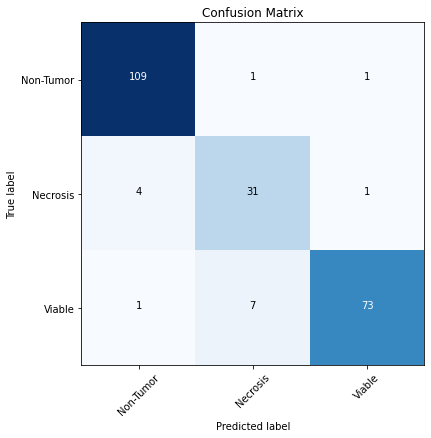

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.91
Accuracy on test data is:  0.93
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.887
Loss value:  0.021238319314202884


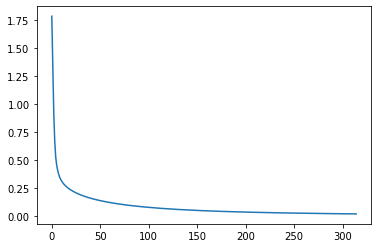

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       111
           1       0.78      0.89      0.83        36
           2       0.97      0.88      0.92        81

    accuracy                           0.93       228
   macro avg       0.90      0.92      0.91       228
weighted avg       0.93      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.908      	   0.954   
  1       Necrosis         0.78     	      0.821      	   0.952   
  2        Viable          0.973      	      0.835      	   0.986   




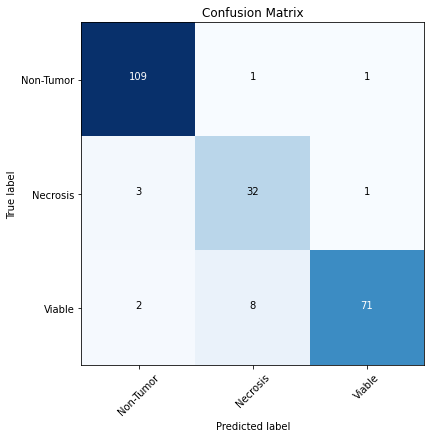

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.913
Accuracy on test data is:  0.943
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.907
Loss value:  0.00015286057047002652


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       111
           1       0.86      0.86      0.86        36
           2       0.97      0.94      0.96        81

    accuracy                           0.94       228
   macro avg       0.93      0.92      0.93       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.947     	      0.939      	   0.947   
  1       Necrosis        0.861     	      0.795      	   0.974   
  2        Viable          0.974      	      0.874      	   0.986   




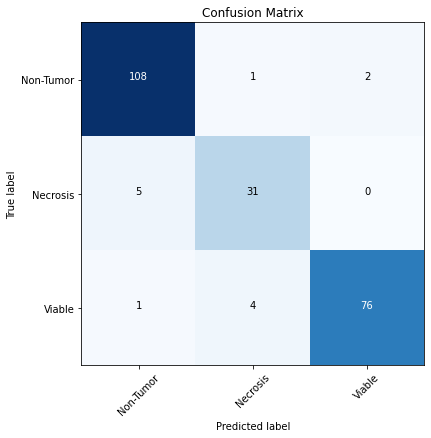

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

#### entropy

In [ ]:
# getting 300 features using entropy
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 700)

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)


**adam**

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.943
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.908
Loss value:  0.0020742253675991792


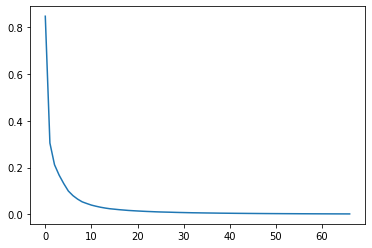

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       111
           1       0.83      0.94      0.88        36
           2       0.97      0.91      0.94        81

    accuracy                           0.94       228
   macro avg       0.92      0.94      0.93       228
weighted avg       0.95      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.964     	      0.922      	   0.964   
  1       Necrosis        0.829     	       0.85      	   0.963   
  2        Viable          0.974      	      0.871      	   0.986   




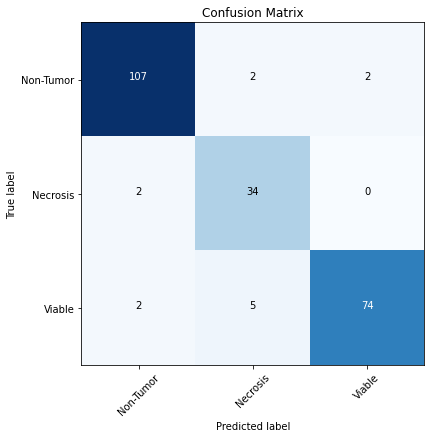

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.914
Accuracy on test data is:  0.934
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.894
Loss value:  0.02131140828549081


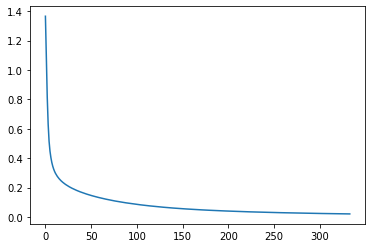

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       111
           1       0.82      0.89      0.85        36
           2       0.99      0.90      0.94        81

    accuracy                           0.93       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.939     	      0.931      	   0.938   
  1       Necrosis        0.821     	       0.8       	   0.963   
  2        Viable          0.986      	      0.839      	   0.993   




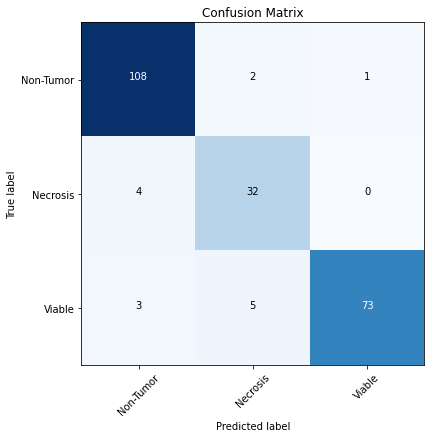

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.947
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.915
Loss value:  7.463409599590486e-05


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       111
           1       0.83      0.94      0.88        36
           2       0.99      0.91      0.95        81

    accuracy                           0.95       228
   macro avg       0.93      0.94      0.93       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.964     	      0.931      	   0.964   
  1       Necrosis        0.829     	      0.872      	   0.963   
  2        Viable          0.987      	      0.871      	   0.993   




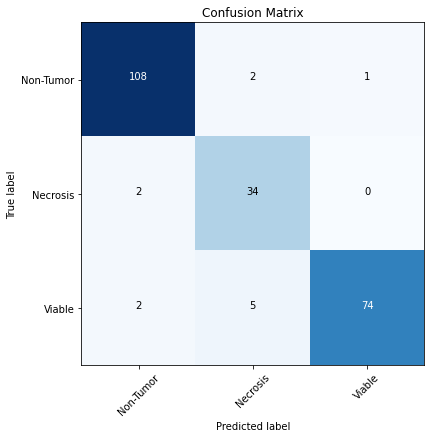

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

### 800

#### gini

In [ ]:
# getting 300 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 800)

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)


**adam**

k-fold validation accuracy for k=5 is:  0.913
Accuracy on test data is:  0.956
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.929
Loss value:  0.0019739562110088803


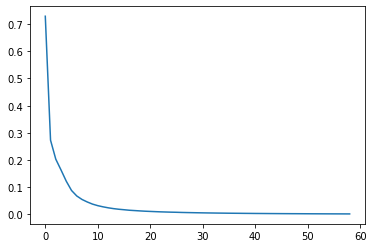

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       111
           1       0.89      0.92      0.90        36
           2       0.99      0.94      0.96        81

    accuracy                           0.96       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.96      0.96      0.96       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.956      	   0.956   
  1       Necrosis        0.892     	      0.846      	   0.979   
  2        Viable          0.987      	      0.894      	   0.993   




**SGD**

k-fold validation accuracy for k=5 is:  0.915
Accuracy on test data is:  0.961
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.936
Loss value:  0.020567418209746415


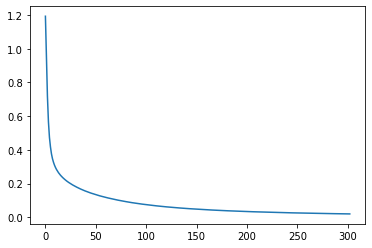

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       111
           1       0.87      0.94      0.91        36
           2       0.99      0.93      0.96        81

    accuracy                           0.96       228
   macro avg       0.94      0.95      0.95       228
weighted avg       0.96      0.96      0.96       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.973     	      0.948      	   0.973   
  1       Necrosis        0.872     	      0.895      	   0.974   
  2        Viable          0.987      	      0.904      	   0.993   




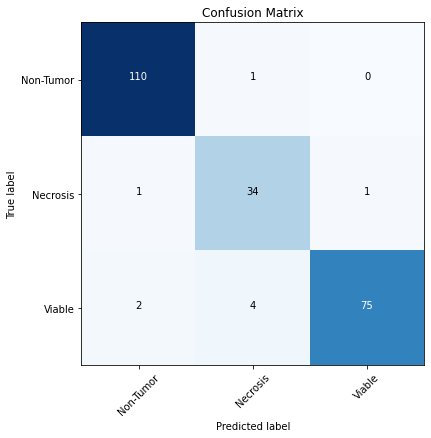

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.93
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.885
Loss value:  4.227610617623425e-05


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       111
           1       0.83      0.83      0.83        36
           2       0.95      0.93      0.94        81

    accuracy                           0.93       228
   macro avg       0.91      0.91      0.91       228
weighted avg       0.93      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.947     	      0.915      	   0.946   
  1       Necrosis        0.833     	       0.75      	   0.968   
  2        Viable          0.949      	      0.862      	   0.972   




#### entropy

In [ ]:
# getting 300 features using entropy
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 800)

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)


**adam**

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.947
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.914
Loss value:  0.0019902123814066427


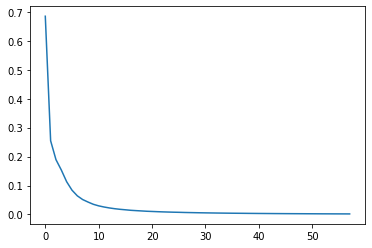

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.87      0.92      0.89        36
           2       0.97      0.93      0.95        81

    accuracy                           0.95       228
   macro avg       0.93      0.94      0.94       228
weighted avg       0.95      0.95      0.95       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.939      	   0.956   
  1       Necrosis        0.868     	      0.825      	   0.973   
  2        Viable          0.974      	      0.882      	   0.986   




**SGD**

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.93
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.886
Loss value:  0.02073919107034217


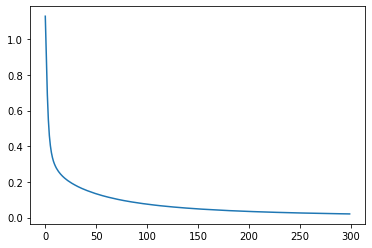

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.82      0.86      0.84        36
           2       0.95      0.90      0.92        81

    accuracy                           0.93       228
   macro avg       0.91      0.91      0.91       228
weighted avg       0.93      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.908      	   0.954   
  1       Necrosis        0.816     	      0.775      	   0.963   
  2        Viable          0.948      	      0.859      	   0.972   




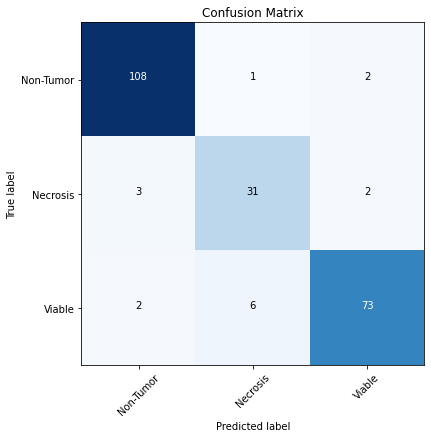

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbfgs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.913
Accuracy on test data is:  0.939
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.9
Loss value:  5.993101112090542e-05


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       111
           1       0.84      0.86      0.85        36
           2       0.97      0.91      0.94        81

    accuracy                           0.94       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.948     	      0.932      	   0.946   
  1       Necrosis        0.838     	      0.795      	   0.968   
  2        Viable          0.974      	       0.86      	   0.986   




### 900

#### gini

In [ ]:
# getting 300 features using gini
train_x, test_x = feat_select(criterion_n='gini', num_feat= 900)

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)


**adam**

k-fold validation accuracy for k=5 is:  0.916
Accuracy on test data is:  0.943
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.908
Loss value:  0.0019960986009070966


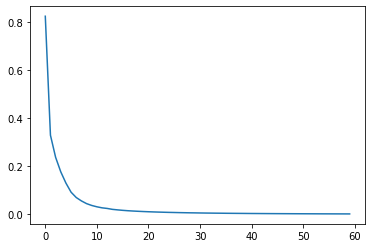

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       111
           1       0.82      0.89      0.85        36
           2       0.96      0.94      0.95        81

    accuracy                           0.94       228
   macro avg       0.92      0.93      0.92       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.973     	      0.915      	   0.973   
  1       Necrosis        0.821     	      0.842      	   0.963   
  2        Viable          0.962      	      0.884      	   0.979   




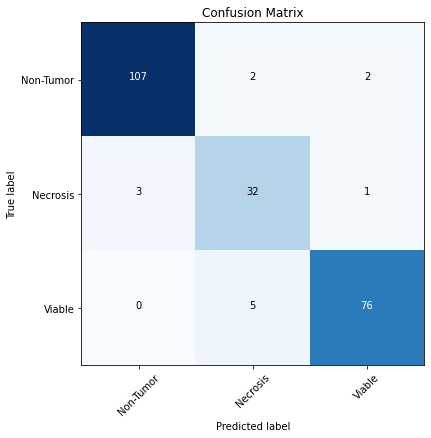

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.913
Accuracy on test data is:  0.934
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.893
Loss value:  0.01917811448751058


              precision    recall  f1-score   support

           0       0.96      0.95      0.96       111
           1       0.82      0.89      0.85        36
           2       0.95      0.93      0.94        81

    accuracy                           0.93       228
   macro avg       0.91      0.92      0.92       228
weighted avg       0.94      0.93      0.93       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.964     	      0.906      	   0.964   
  1       Necrosis        0.821     	       0.8       	   0.963   
  2        Viable          0.949      	      0.872      	   0.972   




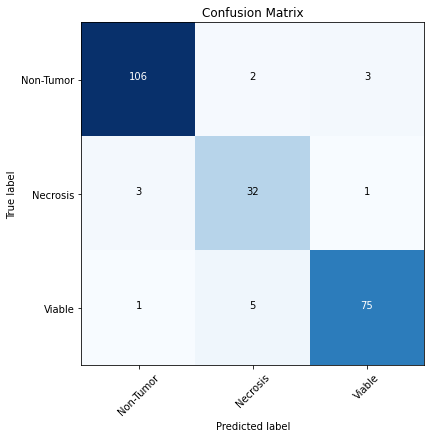

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lgbfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.91
Accuracy on test data is:  0.934
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.894
Loss value:  0.00011339083652618466


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       111
           1       0.79      0.92      0.85        36
           2       0.96      0.93      0.94        81

    accuracy                           0.93       228
   macro avg       0.91      0.93      0.92       228
weighted avg       0.94      0.93      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.972     	      0.897      	   0.973   
  1       Necrosis        0.786     	      0.846      	   0.952   
  2        Viable          0.962      	      0.862      	   0.979   




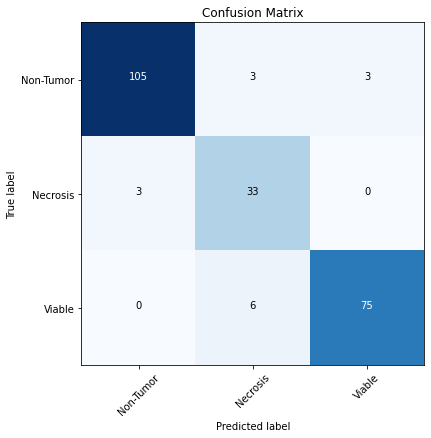

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

#### entropy

In [ ]:
# getting 300 features using entropy
train_x, test_x = feat_select(criterion_n='entropy', num_feat= 900)

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)


**adam**

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.916
Accuracy on test data is:  0.961
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.936
Loss value:  0.002194528625521597


              precision    recall  f1-score   support

           0       0.96      0.99      0.97       111
           1       0.89      0.89      0.89        36
           2       1.00      0.95      0.97        81

    accuracy                           0.96       228
   macro avg       0.95      0.94      0.95       228
weighted avg       0.96      0.96      0.96       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.957     	      0.965      	   0.956   
  1       Necrosis        0.889     	      0.865      	   0.979   
  2        Viable           1.0       	      0.895      	    1.0    




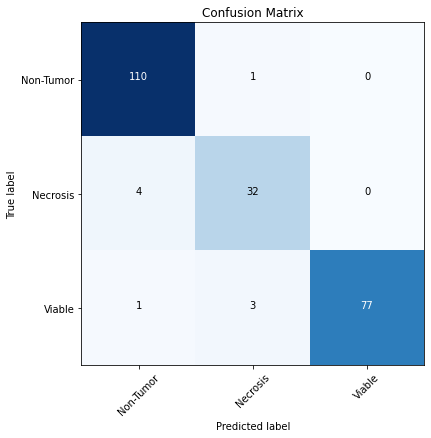

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**SGD**

k-fold validation accuracy for k=5 is:  0.915
Accuracy on test data is:  0.939
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.9
Loss value:  0.018962401933545106


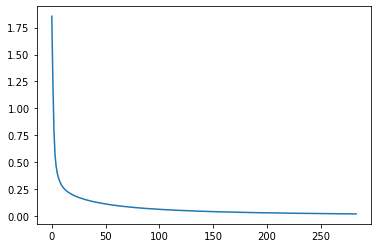

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       111
           1       0.82      0.86      0.84        36
           2       0.99      0.93      0.96        81

    accuracy                           0.94       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.947     	      0.931      	   0.946   
  1       Necrosis        0.816     	      0.816      	   0.963   
  2        Viable          0.987      	      0.852      	   0.993   




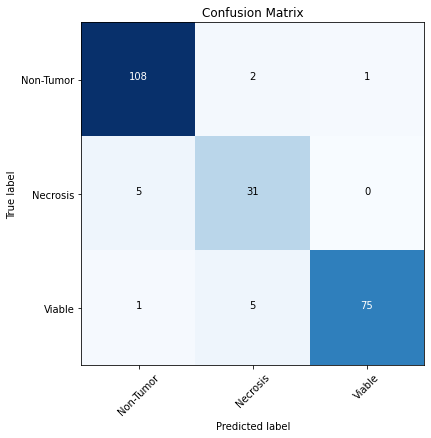

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x)

k-fold validation accuracy for k=5 is:  0.914
Accuracy on test data is:  0.943
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.907
Loss value:  7.48774308010899e-05


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))
print()
print("==========================================================================================")
print()

# print sensitivity and specificity
get_sn_sp(y_test, pred)
print()
print("==========================================================================================")
print()

# getting confusion matrix
conf_matrix = confusion_matrix(y_test, pred)

# plotting confusion matrix
plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_matrix, classes, normalize= False)
plt.show()

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       111
           1       0.84      0.86      0.85        36
           2       0.97      0.94      0.96        81

    accuracy                           0.94       228
   macro avg       0.92      0.92      0.92       228
weighted avg       0.94      0.94      0.94       228



class 	class_name 	precision 	sensitivity(recall) 	specificity 
--------------------------------------------------------------------------
  0      Non-Tumor        0.956     	      0.931      	   0.955   
  1       Necrosis        0.838     	      0.816      	   0.968   
  2        Viable          0.974      	      0.874      	   0.986   




# Rough

In [ ]:
# this actually used to get best paremeters optimaization 
# can be used later 

# from sklearn.model_selection import GridSearchCV

# param_grid = [
#         {
#             'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#             'solver' : ['lbfgs', 'sgd', 'adam'],
#             'hidden_layer_sizes': [
#              (1,),(2,),(3,),(4,),(5,),(6,),(7,),(8,),(9,),(10,),(11,), (12,),(13,),(14,),(15,),(16,),(17,),(18,),(19,),(20,),(21,)
#              ]
#         }
#        ]

# clf = GridSearchCV(MLPClassifier(), param_grid, cv=3,
#                            scoring='accuracy')

# clf.fit(X_train_rfe, y_train)


# print("Best parameters set found on development set:")
# print(clf.best_params_)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, mlp_p))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       110
           1       0.79      0.84      0.81        49
           2       0.95      0.90      0.93        69

    accuracy                           0.90       228
   macro avg       0.89      0.89      0.89       228
weighted avg       0.90      0.90      0.90       228



# RFE with different criterion and MLP

**using Entropy**

In [ ]:
# defining decision tree classifier as estimator
estimator_n = DecisionTreeClassifier(random_state=1, criterion='entropy')
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=estimator_n, n_features_to_select=100)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

In [ ]:
# defining MLP classifier 
mlp_rfe = MLPClassifier(random_state=1, max_iter=500)

# fitting training data 
mlp_rfe.fit(X_train_rfe, y_train)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()

print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_p = mlp_rfe.predict(X_test_rfe)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(y_test, mlp_p)
print ("Accuracy on test data is: ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_test, mlp_p)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# print loss 
mlp_loss = mlp_rfe.loss_
print("Loss value: ", mlp_loss)

k-fold validation accuracy for k=5 is:  0.91
Accuracy on test data is:  0.877
ROC-AUC score is:  0.973
The Matthews correlation coefficinet (MCC) is:  0.805
Loss value:  0.0052532382371644265


In [ ]:
fig, axes = plt.subplots(4, 4)
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp_rfe.coefs_[0].min(), mlp_rfe.coefs_[0].max()
for coef, ax in zip(mlp_rfe.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(10, 10), cmap=plt.cm.gray, vmin=0.5 * vmin, vmax=0.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

In [ ]:
def get_result(mlp_optimizer, no_iter):
  # defining MLP classifier 
  mlp_rfe = MLPClassifier(random_state=1, solver= mlp_optimizer, max_iter= no_iter)

  # fitting training data 
  mlp_rfe.fit(X_train_rfe, y_train)

  # getting k-fold validation accuracy, we are taking k= 5 folds
  k_fold_acc = cross_val_score(mlp_rfe, X_train_rfe, y_train, cv= 5)

  # taking mean of 5 folds accuracy
  k_fold_mean = k_fold_acc.mean()

  print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

  # predicting through test data
  mlp_p = mlp_rfe.predict(X_test_rfe)

  #Print overall accuracy
  from sklearn import metrics
  acc = metrics.accuracy_score(y_test, mlp_p)
  print ("Accuracy on test data is: ", round(acc, 3))

  # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
  from sklearn.metrics import roc_auc_score

  roc_auc = roc_auc_score(y_test, mlp_rfe.predict_proba(X_test_rfe), multi_class='ovr')
  print("ROC-AUC score is: ", round(roc_auc, 3))

  # Compute the Matthews correlation coefficient (MCC)
  from sklearn.metrics import matthews_corrcoef
  mcc = matthews_corrcoef(y_test, mlp_p)
  print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

  # print loss 
  mlp_loss = mlp_rfe.loss_
  print("Loss value: ", mlp_loss)

In [ ]:
# for sgd 
get_result(mlp_optimizer= "sgd", no_iter= 900)

k-fold validation accuracy for k=5 is:  0.906
Accuracy on test data is:  0.868
ROC-AUC score is:  0.968
The Matthews correlation coefficinet (MCC) is:  0.791
Loss value:  0.04735657239309044


In [ ]:
# for lbfgs
get_result(mlp_optimizer= "lbfgs", no_iter= 300)

k-fold validation accuracy for k=5 is:  0.905
Accuracy on test data is:  0.842
ROC-AUC score is:  0.967
The Matthews correlation coefficinet (MCC) is:  0.749
Loss value:  0.0001238007467855571


**using log-loss**

In [ ]:
# defining decision tree classifier as estimator
estimator_n = DecisionTreeClassifier(random_state=1, criterion='gini')
# defining RFE, we used decision tree classifier as estimator
rfe = RFE(estimator=estimator_n, n_features_to_select=100)

# fit our train data into RFE 
rfe.fit(X_train, y_train)

# getting transformed train features
X_train_rfe = rfe.transform(X_train)

# getting transformed test features
X_test_rfe = rfe.transform(X_test)

In [ ]:
# for adam
get_result(mlp_optimizer= "adam", no_iter= 500)

k-fold validation accuracy for k=5 is:  0.905
Accuracy on test data is:  0.904
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.847
Loss value:  0.005284924805320506


In [ ]:
# for sgd 
get_result(mlp_optimizer= "sgd", no_iter= 900)

k-fold validation accuracy for k=5 is:  0.904
Accuracy on test data is:  0.899
ROC-AUC score is:  0.981
The Matthews correlation coefficinet (MCC) is:  0.84
Loss value:  0.04893675463173587


In [ ]:
# for lbfgs 
get_result(mlp_optimizer= "lbfgs", no_iter= 300)

k-fold validation accuracy for k=5 is:  0.886
Accuracy on test data is:  0.873
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.801
Loss value:  0.00020850649660755481


In [ ]:
s = x_train_features[1]
print(s.shape)

(1024,)


In [ ]:
s = s.reshape(32, 32)
s.shape

(32, 32)

In [ ]:
type(s)

numpy.ndarray

In [ ]:
plt.imshow(s)
plt.show()

# Binary Classification

## separating data for binary classification

In [ ]:
# separating data for train set 

non_tumor_train = []
non_tumor_train_l = []

non_viable_tumor_train = []
non_viable_tumor_train_l = []

viable_tumor_train = []
viable_tumor_train_l  = []

for i in range(len(x_train_features)):
    if(y_train[i] == 0):
        non_tumor_train.append(x_train_features[i])
        non_tumor_train_l.append(y_train[i])
        
    elif(y_train[i] == 1):
        non_viable_tumor_train.append(x_train_features[i])
        non_viable_tumor_train_l.append(y_train[i])
    else: 
        viable_tumor_train.append(x_train_features[i])
        viable_tumor_train_l.append(y_train[i])
        
# converting list to np array
non_tumor_train = np.array(non_tumor_train)
non_tumor_train_l = np.array(non_tumor_train_l)

non_viable_tumor_train = np.array(non_viable_tumor_train)
non_viable_tumor_train_l = np.array(non_viable_tumor_train_l)

viable_tumor_train = np.array(viable_tumor_train)
viable_tumor_train_l = np.array(viable_tumor_train_l)

print("Non-tumor train shape: ", non_tumor_train.shape)
print("Non-tumor train labels shape: ",non_tumor_train_l.shape)
print("Non-viable tumor train shape: ", non_viable_tumor_train.shape)
print("Non-viable tumor train labels shape: ", non_viable_tumor_train_l.shape)
print("Viable tumor train shape: ", viable_tumor_train.shape)
print("Viable tumor train labels shape: ", viable_tumor_train_l.shape)

Non-tumor train shape:  (435, 1024)
Non-tumor train labels shape:  (435,)
Non-viable tumor train shape:  (215, 1024)
Non-viable tumor train labels shape:  (215,)
Viable tumor train shape:  (266, 1024)
Viable tumor train labels shape:  (266,)


**Separating test data**

In [ ]:
# separating data for test set 

non_tumor_test = []
non_tumor_test_l = []

non_viable_tumor_test = []
non_viable_tumor_test_l = []

viable_tumor_test = []
viable_tumor_test_l  = []

for i in range(len(x_test_features)):
    if(y_test[i] == 0):
        non_tumor_test.append(x_test_features[i])
        non_tumor_test_l.append(y_test[i])
        
    elif(y_test[i] == 1):
        non_viable_tumor_test.append(x_test_features[i])
        non_viable_tumor_test_l.append(y_test[i])
    else: 
        viable_tumor_test.append(x_test_features[i])
        viable_tumor_test_l.append(y_test[i])
        
# converting list to np array
non_tumor_test = np.array(non_tumor_test)
non_tumor_test_l = np.array(non_tumor_test_l)

non_viable_tumor_test = np.array(non_viable_tumor_test)
non_viable_tumor_test_l = np.array(non_viable_tumor_test_l)

viable_tumor_test = np.array(viable_tumor_test)
viable_tumor_test_l = np.array(viable_tumor_test_l)

print("Non-tumor test shape: ", non_tumor_test.shape)
print("Non-tumor test labels shape: ",non_tumor_test_l.shape)
print("Non-viable tumor test shape: ", non_viable_tumor_test.shape)
print("Non-viable tumor test labels shape: ", non_viable_tumor_test_l.shape)
print("Viable tumor test shape: ", viable_tumor_test.shape)
print("Viable tumor test labels shape: ", viable_tumor_test_l.shape)

Non-tumor test shape:  (102, 1024)
Non-tumor test labels shape:  (102,)
Non-viable tumor test shape:  (47, 1024)
Non-viable tumor test labels shape:  (47,)
Viable tumor test shape:  (79, 1024)
Viable tumor test labels shape:  (79,)


## Non-tumor VS Necrosis and Viable

In [ ]:
# making Non-tumor VS non-viable and viable dataset
print("Label for non-tumor: ",np.unique(non_tumor_train_l))
print(np.unique(non_viable_tumor_train_l))
print(np.unique(viable_tumor_train_l))

# We need to concatenate vible and non-viable as a single class for training data
viable_n_non_viable_train = np.concatenate((non_viable_tumor_train, viable_tumor_train), axis=0)
print("Shape of no-viable and viable train features after concatenate: ", viable_n_non_viable_train.shape)

# concatenate for test data
viable_n_non_viable_test = np.concatenate((non_viable_tumor_test, viable_tumor_test), axis=0)
print("Shape of no-viable and viable train features after concatenate: ", viable_n_non_viable_test.shape)

# concatenating labels for training data 
viable_n_non_viable_train_l = np.concatenate((non_viable_tumor_train_l, viable_tumor_train_l), axis=0)

# concatenating labels for test data 
viable_n_non_viable_test_l = np.concatenate((non_viable_tumor_test_l, viable_tumor_test_l), axis=0)

print("Shape of no-viable and viable train features labels after concatenate: ", viable_n_non_viable_train_l.shape)

print("Label for non-viable and viable features: ",np.unique(viable_n_non_viable_train_l))
print("Label for non-viable and viable features: ",np.unique(viable_n_non_viable_test_l))

Label for non-tumor:  [0]
[1]
[2]
Shape of no-viable and viable train features after concatenate:  (481, 1024)
Shape of no-viable and viable train features after concatenate:  (126, 1024)
Shape of no-viable and viable train features labels after concatenate:  (481,)
Label for non-viable and viable features:  [1 2]
Label for non-viable and viable features:  [1 2]


In [ ]:
# AS we can see above, non-viable and viable contains two different labels  1, 2 respectively. 
# We need to convert those into label 1, as we are going to implement binary classification 

for i in range(viable_n_non_viable_train_l.shape[0]):
    viable_n_non_viable_train_l[i] = 1

for i in range(viable_n_non_viable_test_l.shape[0]):
    viable_n_non_viable_test_l[i] = 1

print('After conversion: ',np.unique(viable_n_non_viable_test_l))
print('After conversion: ',np.unique(viable_n_non_viable_train_l))

After conversion:  [1]
After conversion:  [1]


In [ ]:
# combinig dataset for train set 
train_x_b1 = np.concatenate((non_tumor_train, viable_n_non_viable_train), axis=0)
train_y_b1 = np.concatenate((non_tumor_train_l, viable_n_non_viable_train_l), axis= 0)
print('Training features shape: ',train_x_b1.shape)
print('Training labels shape: ',train_y_b1.shape)
print("Lables in train data: ", np.unique(train_y_b1))
print("=============================================================")

# combining for test data 
test_x_b1 = np.concatenate((non_tumor_test, viable_n_non_viable_test), axis=0)
test_y_b1 = np.concatenate((non_tumor_test_l, viable_n_non_viable_test_l), axis= 0)
print('Training features shape: ',test_x_b1.shape)
print('Training labels shape: ',test_y_b1.shape)
print("Lables in train data: ", np.unique(test_y_b1))

Training features shape:  (916, 1024)
Training labels shape:  (916,)
Lables in train data:  [0 1]
Training features shape:  (228, 1024)
Training labels shape:  (228,)
Lables in train data:  [0 1]


### Default 

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
# performing binary classification without feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(train_x_b1, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, train_x_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(test_x_b1)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(test_x_b1)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# compute loss
# print loss 
mlp_loss = mlp_classifier.loss_
print("Loss value: ", mlp_loss)

# plot loss graph
label = "constant learning-rate"
plt.plot(mlp_classifier.loss_curve_, label= label)
plt.show()

k-fold validation accuracy for k=5 is:  0.938
Accuracy =  0.969
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.002502768120068393


In [ ]:
# Scaling train and test features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_b1 = sc.fit_transform(train_x_b1)
X_test_b1 = sc.transform(test_x_b1)

print("After scaling train: ", X_train_b1.shape)
print("After scaling test size: ", X_test_b1.shape)

After scaling train:  (916, 1024)
After scaling test size:  (228, 1024)


k-fold validation accuracy for k=5 is:  0.94
Accuracy =  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.0019953579908928852


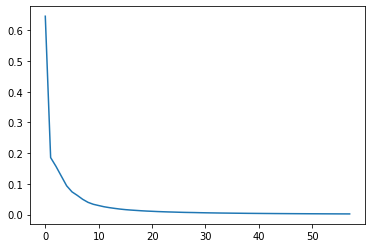

In [ ]:
# performing binary classification without feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
mlp_classifier.fit(X_train_b1, train_y_b1)

# getting k-fold validation accuracy, we are taking k= 5 folds
k_fold_acc = cross_val_score(mlp_classifier, X_train_b1, train_y_b1, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
mlp_pred = mlp_classifier.predict(X_test_b1)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b1, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# roc-auc
lr_probs = mlp_classifier.predict_proba(X_test_b1)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# getting roc_auc score
roc_auc = roc_auc_score(test_y_b1, lr_probs)

print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
mcc = matthews_corrcoef(test_y_b1, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# compute loss
# print loss 
mlp_loss = mlp_classifier.loss_
print("Loss value: ", mlp_loss)

# plot loss graph
label = "constant learning-rate"
plt.plot(mlp_classifier.loss_curve_, label= label)
plt.show()

#### necessary functions

In [ ]:
# function to feature selection using RFE
def feat_select_bin(criterion_n, num_feat, X_train, y_train, X_test):
  # defining estimator
  estimator_n = DecisionTreeClassifier(random_state=1, criterion= criterion_n)
  # defining RFE, we used decision tree classifier as estimator
  rfe = RFE(estimator= estimator_n, n_features_to_select= num_feat)

  # fit our train data into RFE 
  rfe.fit(X_train, y_train)

  # getting transformed train features
  X_train_rfe = rfe.transform(X_train)

  # getting transformed test features
  X_test_rfe = rfe.transform(X_test)

  print("After applying mutual information gain, shape for train data: ", X_train_rfe.shape)
  print("After applying Mututal information gain, shape for test data: ", X_test_rfe.shape)
  return X_train_rfe, X_test_rfe

In [ ]:
# function to get prediction with MLP classifier

def mlp_class_plot(optimizer_name, num_iteration, train_data, test_data, y_train, y_test):

  # defining MLP classifier 
  mlp_rfe = MLPClassifier(random_state=1, solver=optimizer_name,  max_iter= num_iteration)

  # fitting training data 
  mlp_rfe.fit(train_data, y_train)

  # getting k-fold validation accuracy, we are taking k= 5 folds
  k_fold_acc = cross_val_score(mlp_rfe, train_data, y_train, cv= 5)

  # taking mean of 5 folds accuracy
  k_fold_mean = k_fold_acc.mean()

  print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

  # predicting through test data
  mlp_p = mlp_rfe.predict(test_data)

  #Print overall accuracy
  from sklearn import metrics
  acc = metrics.accuracy_score(y_test, mlp_p)
  print ("Accuracy on test data is: ", round(acc, 3))

  # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
  from sklearn.metrics import roc_auc_score
 
  lr_probs = mlp_rfe.predict_proba(test_data)

  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]

  roc_auc = roc_auc_score(y_test, lr_probs)
  print("ROC-AUC score is: ", round(roc_auc, 3))

  # Compute the Matthews correlation coefficient (MCC)
  from sklearn.metrics import matthews_corrcoef
  mcc = matthews_corrcoef(y_test, mlp_p)
  print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

  # print loss 
  mlp_loss = mlp_rfe.loss_
  print("Loss value: ", mlp_loss)

  # plot loss graph
  label = "constant learning-rate"
  plt.plot(mlp_rfe.loss_curve_, label= label)
  plt.show()
  
  return mlp_p

In [ ]:
# function to get prediction with MLP classifier

def mlp_class_wo_plot(optimizer_name, num_iteration, train_data, test_data, y_train, y_test):

  # defining MLP classifier 
  mlp_rfe = MLPClassifier(random_state=1, solver=optimizer_name,  max_iter= num_iteration)

  # fitting training data 
  mlp_rfe.fit(train_data, y_train)

  # getting k-fold validation accuracy, we are taking k= 5 folds
  k_fold_acc = cross_val_score(mlp_rfe, train_data, y_train, cv= 5)

  # taking mean of 5 folds accuracy
  k_fold_mean = k_fold_acc.mean()

  print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

  # predicting through test data
  mlp_p = mlp_rfe.predict(test_data)

  #Print overall accuracy
  from sklearn import metrics
  acc = metrics.accuracy_score(y_test, mlp_p)
  print ("Accuracy on test data is: ", round(acc, 3))

  # Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
  from sklearn.metrics import roc_auc_score

  lr_probs = mlp_rfe.predict_proba(test_data)

  # keep probabilities for the positive outcome only
  lr_probs = lr_probs[:, 1]

  roc_auc = roc_auc_score(y_test, lr_probs)
  print("ROC-AUC score is: ", round(roc_auc, 3))

  # Compute the Matthews correlation coefficient (MCC)
  from sklearn.metrics import matthews_corrcoef
  mcc = matthews_corrcoef(y_test, mlp_p)
  print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

  # print loss 
  mlp_loss = mlp_rfe.loss_
  print("Loss value: ", mlp_loss)
  
  return mlp_p

In [ ]:
# function get classification reports 
def get_reports(y_test, mlp_pred):
  print(classification_report(y_test, mlp_pred))

# function to get confuaion matrix
def conf_mat(classes, y_test, mlp_pred):
  # getting confusion matrix
  conf_matrix = confusion_matrix(y_test, mlp_pred)

  # plotting confusion matrix
  plt.figure(figsize=(6,6))
  plot_confusion_matrix(conf_matrix, classes, normalize= False)
  plt.show()

  # plotting confusion matrix with normalization
  plt.figure(figsize=(6,6))
  plot_confusion_matrix(conf_matrix, classes, normalize= True)
  plt.show()

# function to get sensitivity and specificty
def get_sn_sp(test_y, mlp_pred):
  cc, tp, fp, tn, fn = perf_measure(test_y, mlp_pred)

  # for class 0
  tp_0, fp_0, tn_0, fn_0 = tp[0], fp[0], tn[0], fn[0]

  # precision= TP/(TP + FP)
  precision_0 = tp_0 /(tp_0 + fp_0)
  precision_0 = np.round(precision_0, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_0 = tp_0 / (tp_0 + fn_0)
  recall_0 = np.round(recall_0, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_0 = tn_0 / (tn_0 + fp_0)
  speci_0 = np.round(speci_0, 3)

  #### for class 1
  tp_1, fp_1, tn_1, fn_1 = tp[1], fp[1], tn[1], fn[1]

  # precision= TP/(TP + FP)
  precision_1 = tp_1 /(tp_1 + fp_1)
  precision_1 = np.round(precision_1, 3)

  # recall (sensitivity) = TP/ (TP + FN)
  recall_1 = tp_1 / (tp_1 + fn_1)
  recall_1 = np.round(recall_1, 3)

  # specificity(true negative rate) = TN / (TN + FP)
  speci_1 = tn_1 / (tn_1 + fp_1)
  speci_1 = np.round(speci_1, 3)


  c_0, c_1 = 'Non-Tumor', classes[1] 
  print("class \tprecision \tsensitivity(recall) \tspecificity ")
  print('------------------------------------------------------------------------------')
  print(str(0).center(5),  str(precision_0).center(13), '\t',str(recall_0).center(15), '\t', str(speci_0).center(10))
  print(str(1).center(5),  str(precision_1).center(13), '\t',str(recall_1).center(15), '\t', str(speci_1).center(10))


#### evaluation

In [ ]:
# function to get accuracy, k-fold acc, auc, mcc, loss, loss plot


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       102
           1       0.98      0.97      0.97       126

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.961     	      0.971      	   0.968   
  1       0.976     	      0.968      	   0.971   





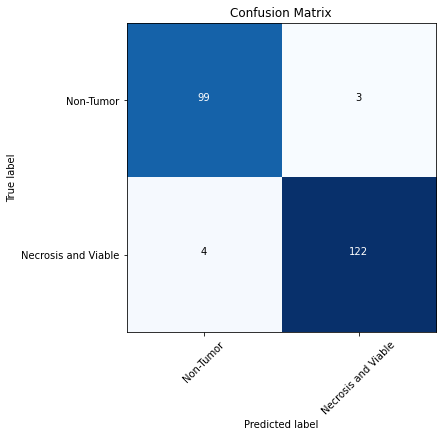

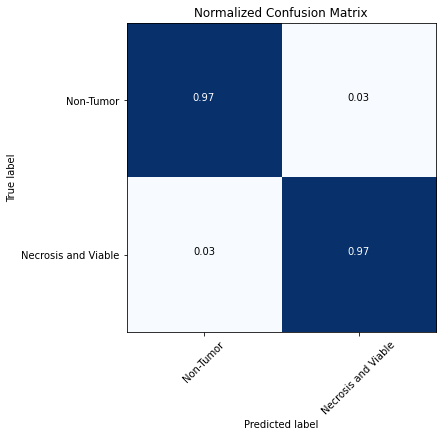

In [ ]:
classes = ['Non-Tumor', 'Necrosis and Viable']
from sklearn.metrics import classification_report

# getting classsification reports
get_reports(test_y_b1, mlp_pred)
print("\n\n")
# getting sensitivity and specificity
get_sn_sp(test_y_b1, mlp_pred)
print("\n\n")
# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, mlp_pred)

### with RFE

#### 100

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 100, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)


**adam**

k-fold validation accuracy for k=5 is:  0.926
Accuracy on test data is:  0.969
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.939
Loss value:  0.004473062491760012


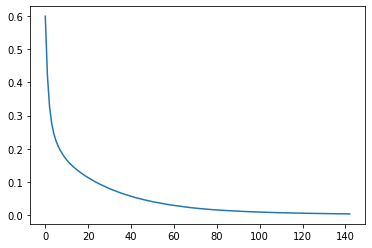

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       109
           1       0.95      0.99      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.99     	      0.945      	   0.992   
  1       0.952     	      0.992      	   0.945   





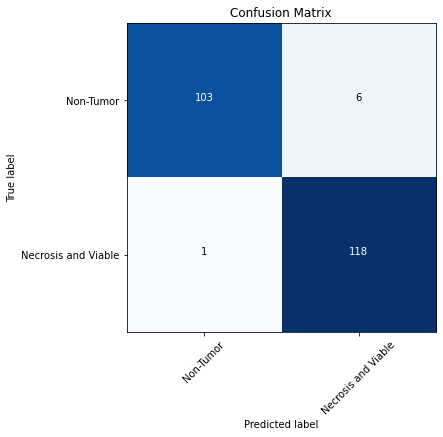

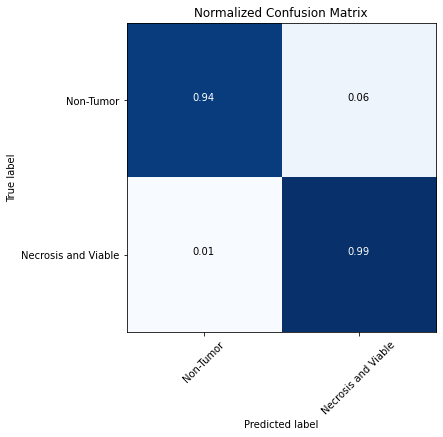

In [ ]:
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**SGD**

k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.965
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.931
Loss value:  0.06516365466203806


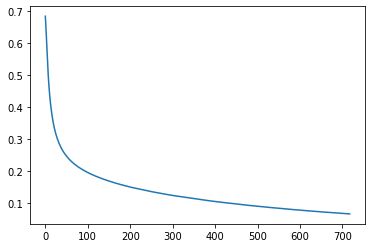

In [ ]:
# gini, sgd, 100
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data=train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       109
           1       0.94      0.99      0.97       119

    accuracy                           0.96       228
   macro avg       0.97      0.96      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.99     	      0.936      	   0.992   
  1       0.944     	      0.992      	   0.936   





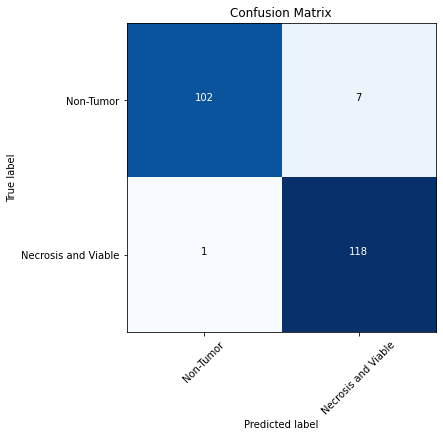

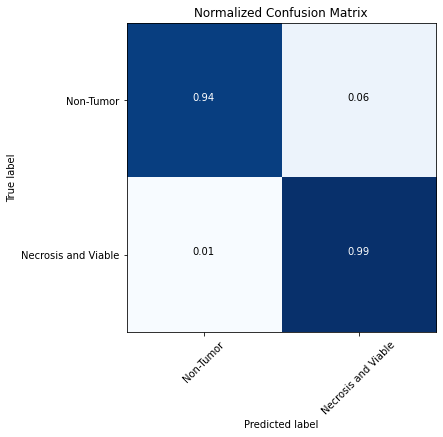

In [ ]:
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**lbgfs**

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

k-fold validation accuracy for k=5 is:  0.921
Accuracy on test data is:  0.961
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.921
Loss value:  0.00013167171558579896


              precision    recall  f1-score   support

           0       0.97      0.94      0.96       109
           1       0.95      0.97      0.96       119

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.945      	   0.975   
  1       0.951     	      0.975      	   0.945   





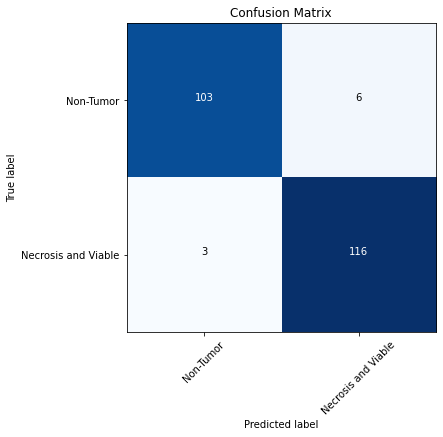

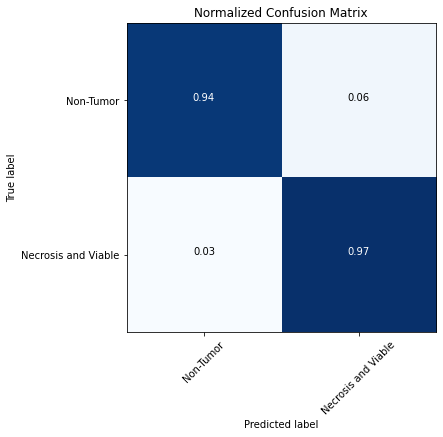

In [ ]:
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 100, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 100)
After applying Mututal information gain, shape for test data:  (228, 100)


**adam**

k-fold validation accuracy for k=5 is:  0.923
Accuracy on test data is:  0.982
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.965
Loss value:  0.004471162913374848


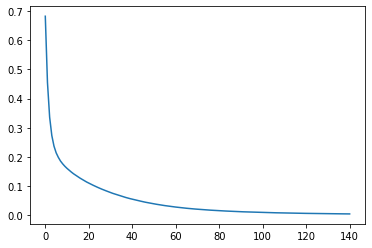




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       109
           1       0.98      0.98      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.982     	      0.982      	   0.983   
  1       0.983     	      0.983      	   0.982   





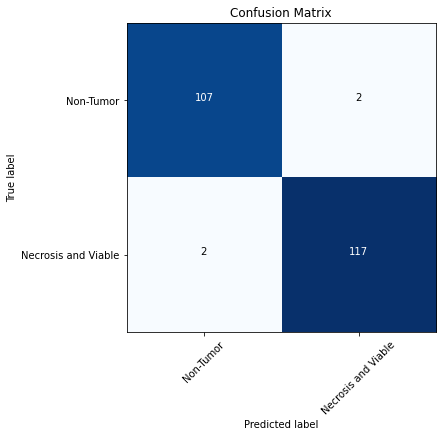

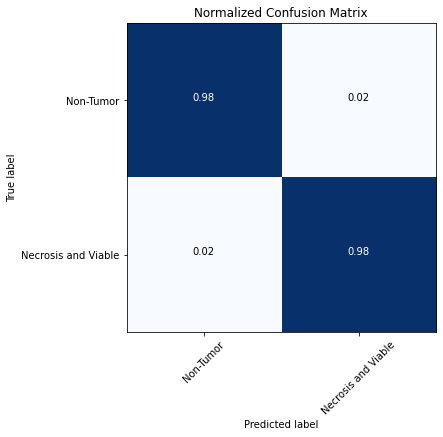

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**SGD**

k-fold validation accuracy for k=5 is:  0.924
Accuracy on test data is:  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.05900372533393968


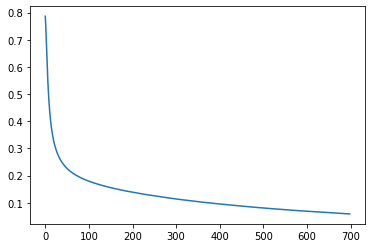




              precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	      0.972      	   0.983   
  1       0.975     	      0.983      	   0.972   





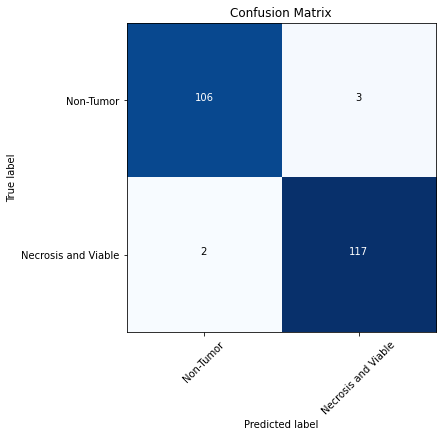

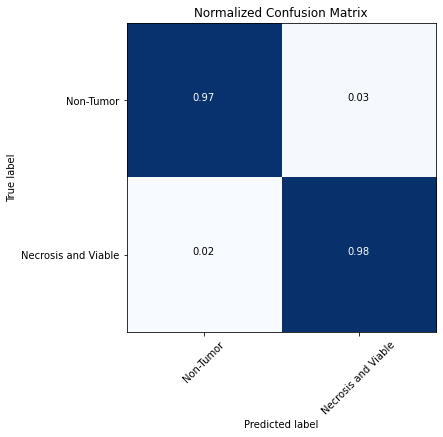

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.909
Accuracy on test data is:  0.969
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.00016874203047539734



              precision    recall  f1-score   support

           0       0.97      0.96      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.963      	   0.975   
  1       0.967     	      0.975      	   0.963   





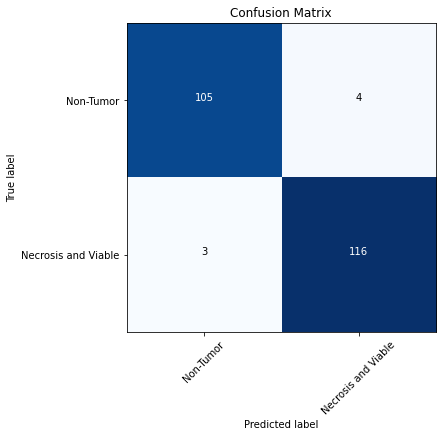

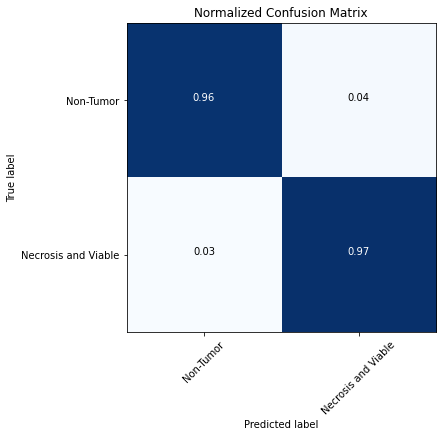

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

#### 200

##### gini

In [ ]:
# getting 200 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 200, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.974
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.0036965795689799567


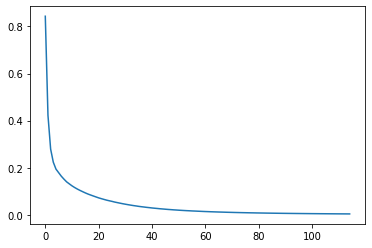




              precision    recall  f1-score   support

           0       0.97      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.972      	   0.975   
  1       0.975     	      0.975      	   0.972   





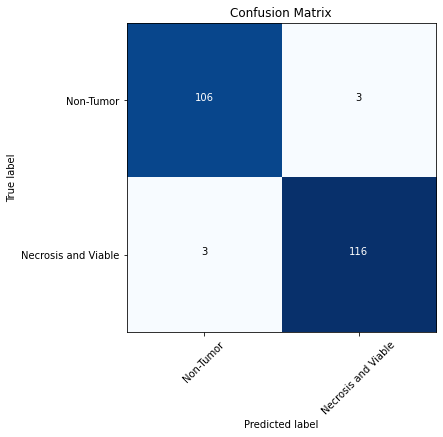

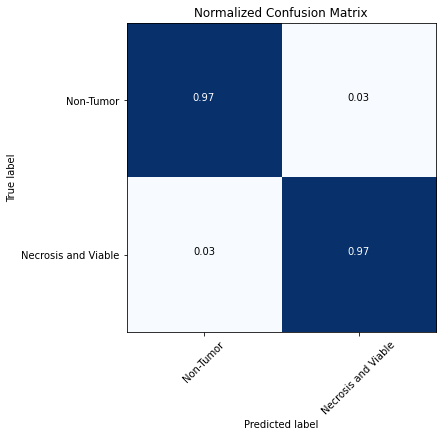

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**sgd**

k-fold validation accuracy for k=5 is:  0.921
Accuracy on test data is:  0.974
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.03804705699367642


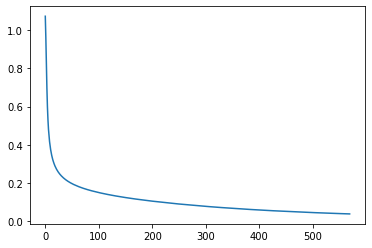




              precision    recall  f1-score   support

           0       0.97      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.972      	   0.975   
  1       0.975     	      0.975      	   0.972   





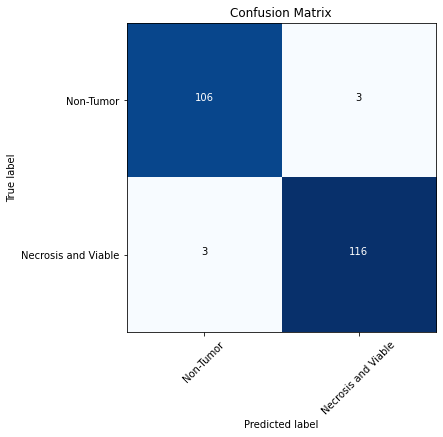

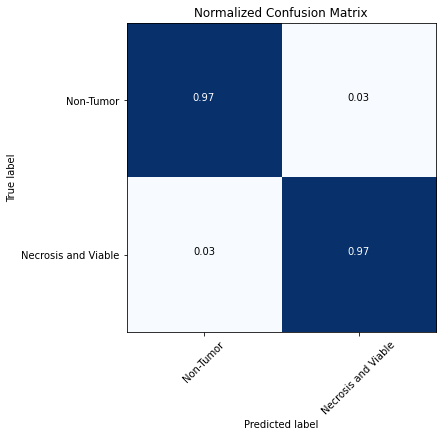

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.961
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.921
Loss value:  7.879699686073404e-05



              precision    recall  f1-score   support

           0       0.95      0.96      0.96       109
           1       0.97      0.96      0.96       119

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.963      	   0.958   
  1       0.966     	      0.958      	   0.963   





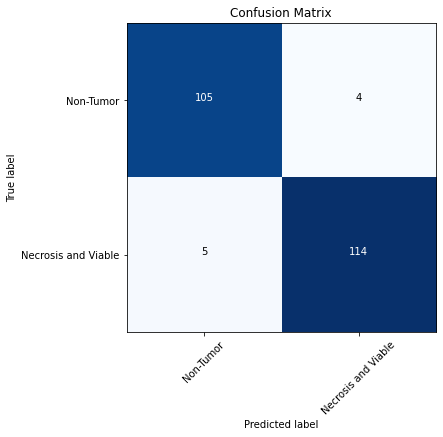

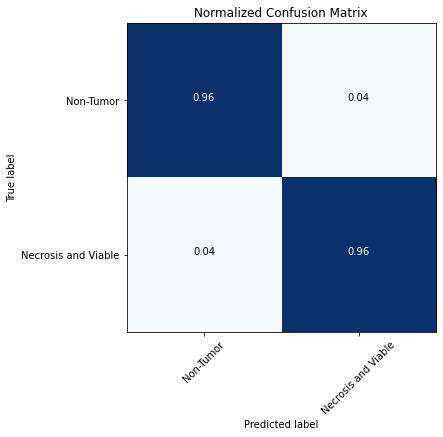

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 200, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 200)
After applying Mututal information gain, shape for test data:  (228, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.969
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.0036760194008920483


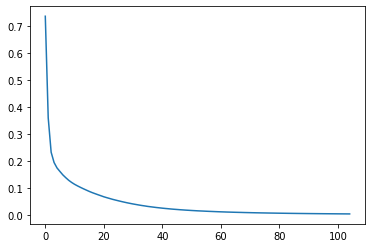




              precision    recall  f1-score   support

           0       0.97      0.96      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.963      	   0.975   
  1       0.967     	      0.975      	   0.963   





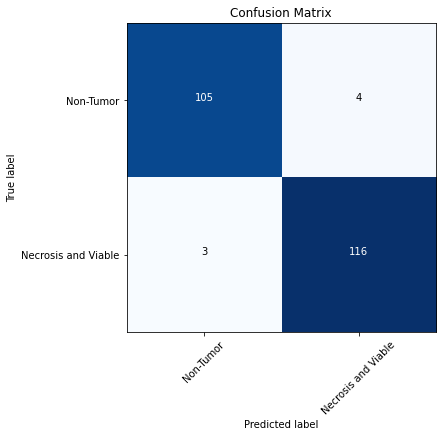

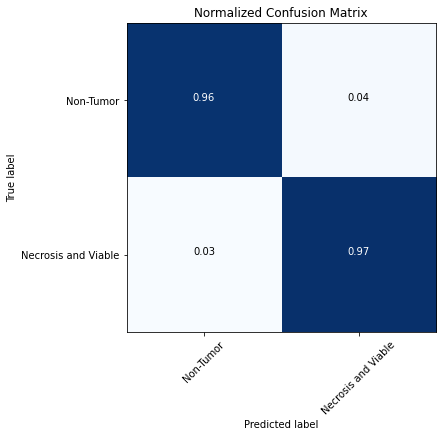

In [ ]:
# gini, adam, 200
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**sgd**

k-fold validation accuracy for k=5 is:  0.926
Accuracy on test data is:  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.0385880447290278


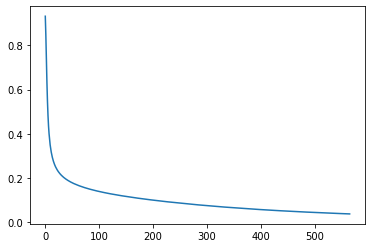




              precision    recall  f1-score   support

           0       0.97      0.98      0.98       109
           1       0.98      0.97      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.973     	      0.982      	   0.975   
  1       0.983     	      0.975      	   0.982   





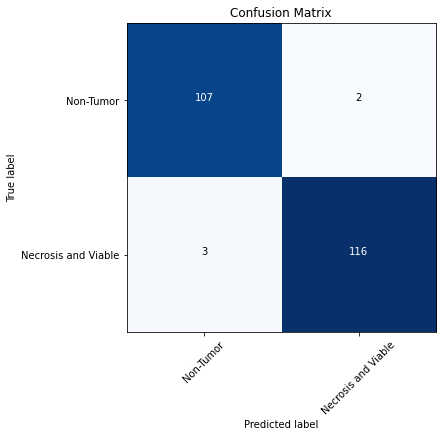

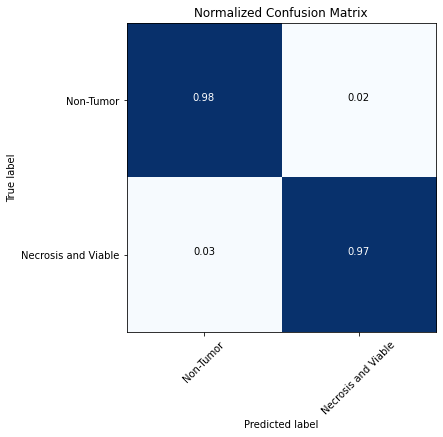

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.93
Accuracy on test data is:  0.965
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  0.00021539297017714333



              precision    recall  f1-score   support

           0       0.95      0.97      0.96       109
           1       0.97      0.96      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.97      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.972      	   0.958   
  1       0.974     	      0.958      	   0.972   





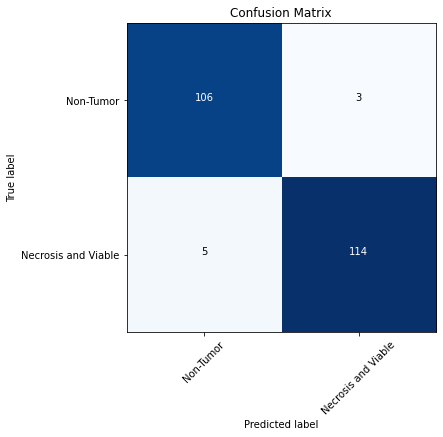

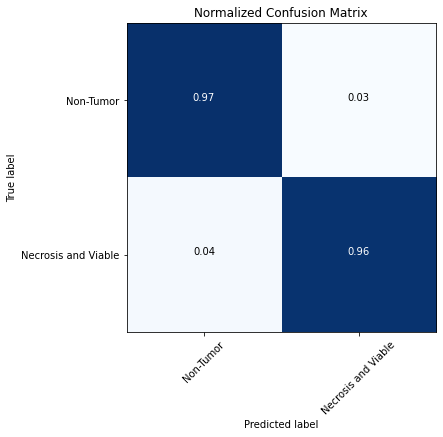

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

#### 300

##### gini

In [ ]:
# getting 200 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 300, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.969
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.002614430330030902


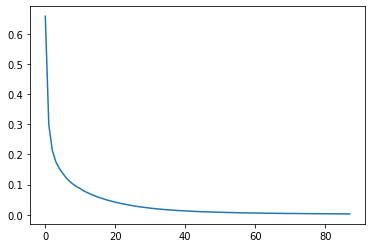




              precision    recall  f1-score   support

           0       0.97      0.96      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.963      	   0.975   
  1       0.967     	      0.975      	   0.963   





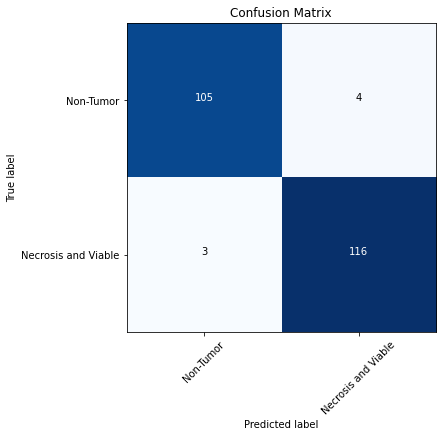

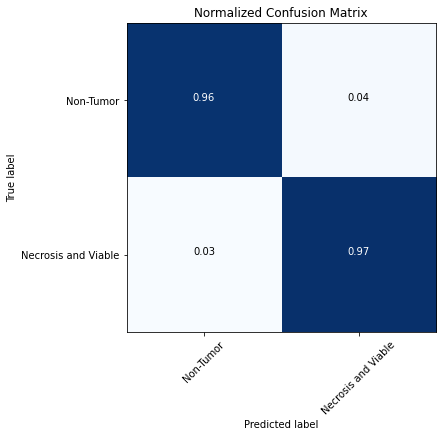

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.969
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.002614430330030902


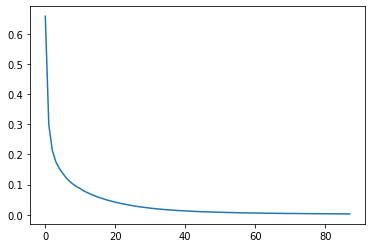




              precision    recall  f1-score   support

           0       0.97      0.96      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.963      	   0.975   
  1       0.967     	      0.975      	   0.963   





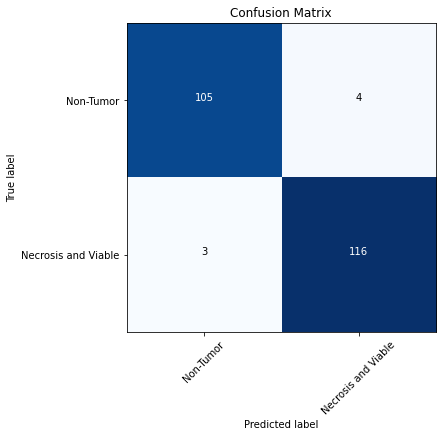

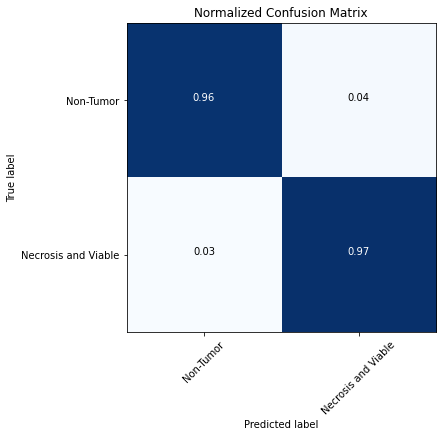

In [ ]:
# using function 
get_final_result(opt_name = "adam", num_iter=500, classes=classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.932
Accuracy on test data is:  0.982
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.965
Loss value:  0.03255133331417138


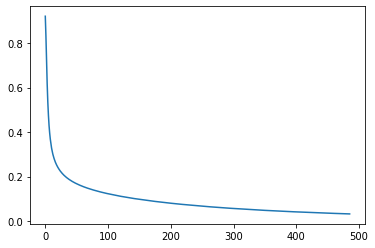




              precision    recall  f1-score   support

           0       0.99      0.97      0.98       109
           1       0.98      0.99      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.991     	      0.972      	   0.992   
  1       0.975     	      0.992      	   0.972   





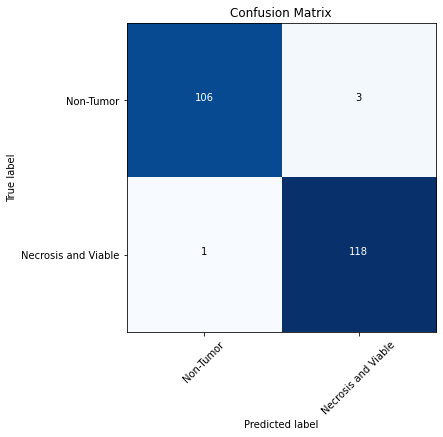

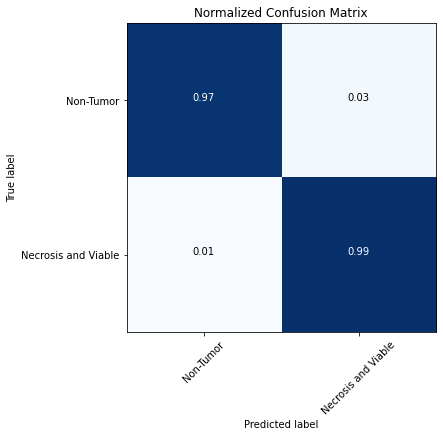

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.937
Accuracy on test data is:  0.965
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  0.00012042496548998074



              precision    recall  f1-score   support

           0       0.95      0.97      0.96       109
           1       0.97      0.96      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.97      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.972      	   0.958   
  1       0.974     	      0.958      	   0.972   





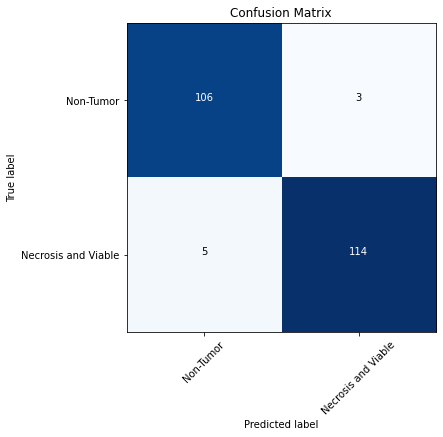

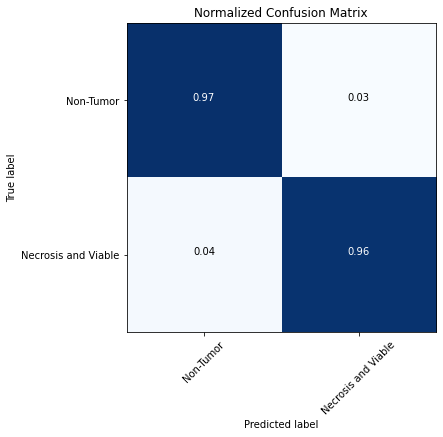

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 300, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 300)
After applying Mututal information gain, shape for test data:  (228, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.002666435132068807


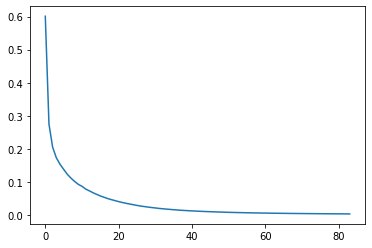




              precision    recall  f1-score   support

           0       0.97      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.972      	   0.975   
  1       0.975     	      0.975      	   0.972   





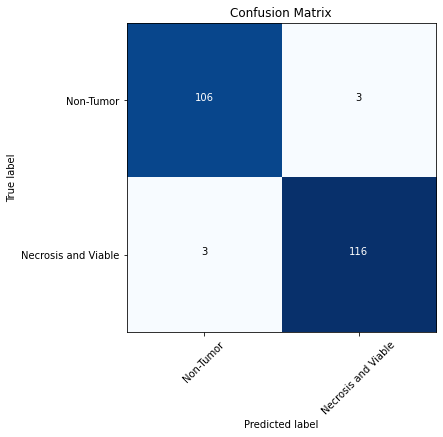

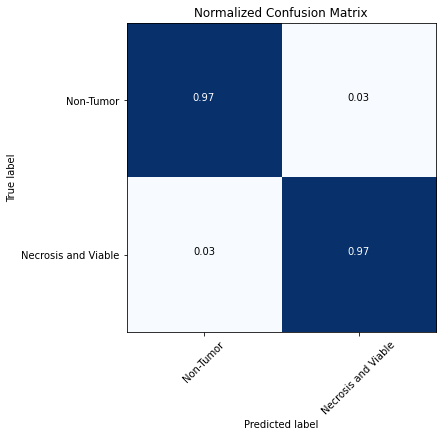

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="adam", num_iteration=500, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**SGD**

k-fold validation accuracy for k=5 is:  0.927
Accuracy on test data is:  0.965
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  0.03364235676666418


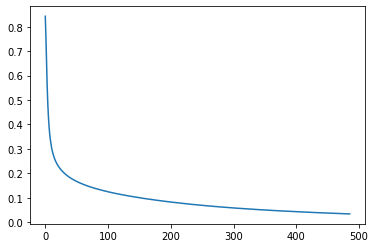




              precision    recall  f1-score   support

           0       0.96      0.96      0.96       109
           1       0.97      0.97      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.963     	      0.963      	   0.966   
  1       0.966     	      0.966      	   0.963   





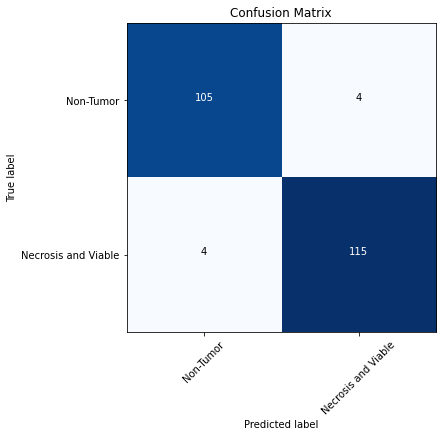

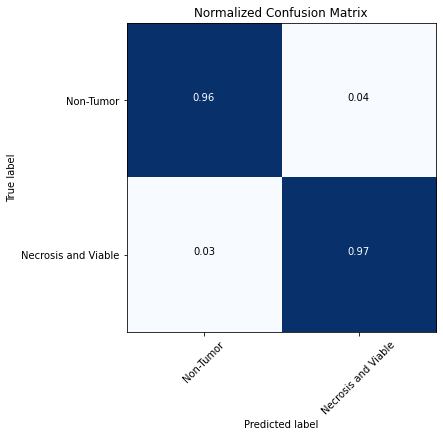

In [ ]:
# gini, adam, 100
pred = mlp_class_plot(optimizer_name="sgd", num_iteration=900, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.937
Accuracy on test data is:  0.947
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.895
Loss value:  9.447727005451381e-05



              precision    recall  f1-score   support

           0       0.94      0.94      0.94       109
           1       0.95      0.95      0.95       119

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.945     	      0.945      	    0.95   
  1        0.95     	       0.95      	   0.945   





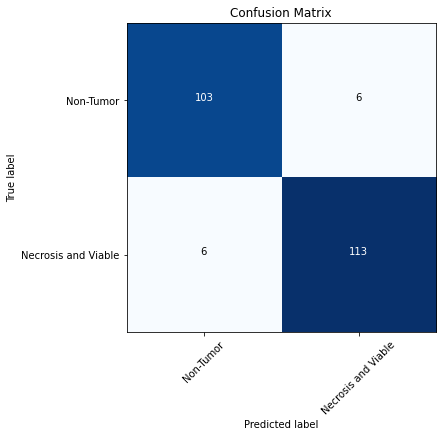

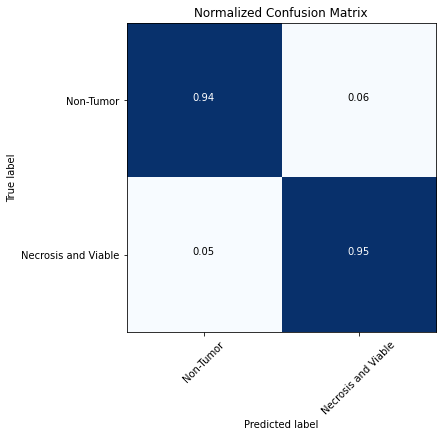

In [ ]:
# gini, adam, 100
pred = mlp_class_wo_plot(optimizer_name="lbfgs", num_iteration=300, train_data=train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

print()
print()
print()
# evaluation 
classes = ['Non-Tumor', 'Necrosis and Viable']

# getting classsification reports
get_reports(test_y_b1, pred)
print("\n\n")

# getting sensitivity and specificity
get_sn_sp(test_y_b1, pred)
print("\n\n")

# getting unnormalized and normalized confusion matrix
conf_mat(classes, test_y_b1, pred)

In [ ]:
def get_final_result(opt_name, num_iter, classes):
  
  # getting predicted outputs
  if opt_name == "lbfgs":
    pred = mlp_class_wo_plot(optimizer_name= opt_name, num_iteration=num_iter, train_data=train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)
  else:
    pred = mlp_class_plot(optimizer_name= opt_name, num_iteration=num_iter, train_data= train_x, test_data= test_x, y_train= train_y_b1, y_test=test_y_b1)

  # perfomance metrices
  print()
  print()
  print()

  # getting classsification reports
  get_reports(test_y_b1, pred)
  print("\n\n")

  # getting sensitivity and specificity
  get_sn_sp(test_y_b1, pred)
  print("\n\n")

  # getting unnormalized and normalized confusion matrix
  conf_mat(classes, test_y_b1, pred)

k-fold validation accuracy for k=5 is:  0.937
Accuracy on test data is:  0.947
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.895
Loss value:  9.447727005451381e-05



              precision    recall  f1-score   support

           0       0.94      0.94      0.94       109
           1       0.95      0.95      0.95       119

    accuracy                           0.95       228
   macro avg       0.95      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.945     	      0.945      	    0.95   
  1        0.95     	       0.95      	   0.945   





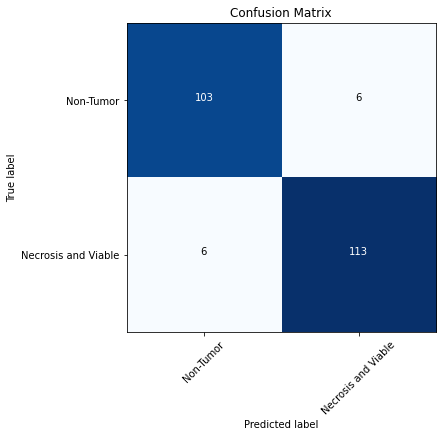

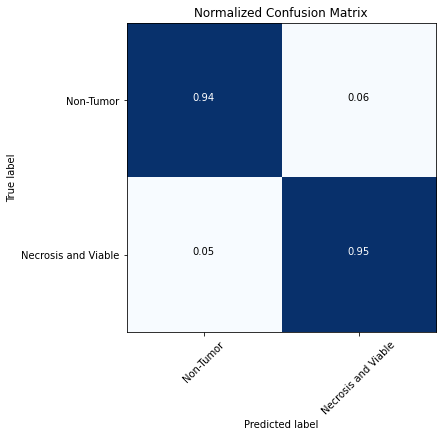

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.002666435132068807


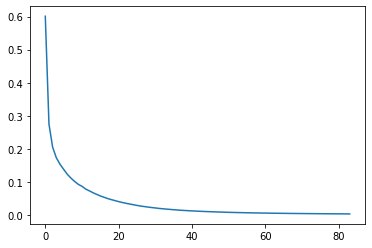




              precision    recall  f1-score   support

           0       0.97      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.972      	   0.975   
  1       0.975     	      0.975      	   0.972   





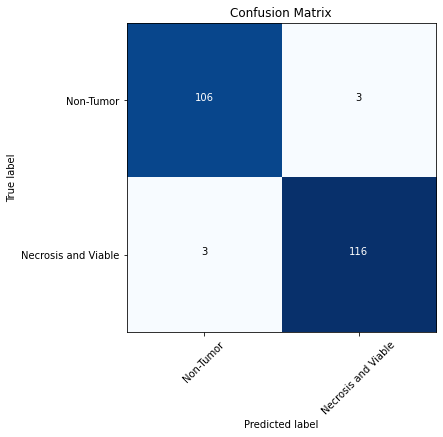

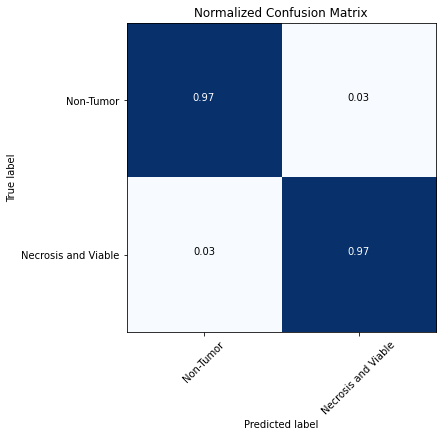

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

#### 400

##### gini

In [ ]:
# getting 400 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 400, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.936
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.0019693032601555472


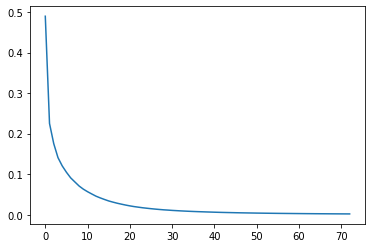




              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.98      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.964     	      0.982      	   0.966   
  1       0.983     	      0.966      	   0.982   





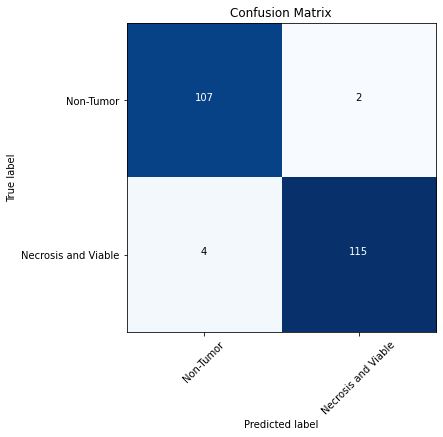

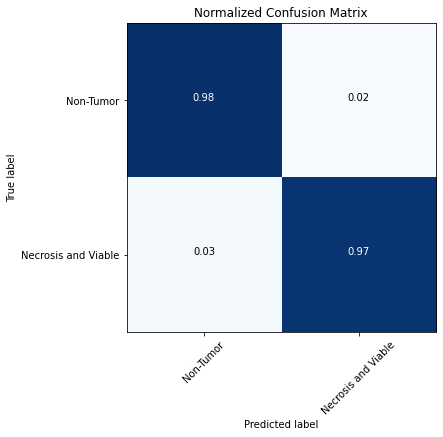

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.982
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.965
Loss value:  0.02831422236733546


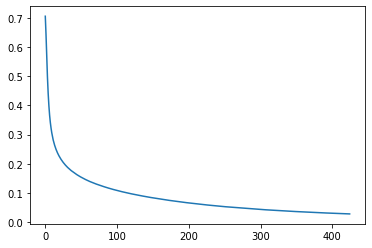




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       109
           1       0.98      0.98      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.982     	      0.982      	   0.983   
  1       0.983     	      0.983      	   0.982   





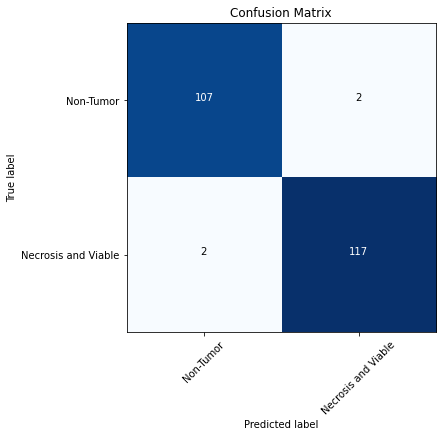

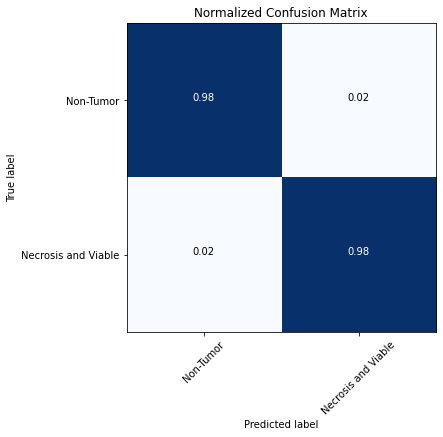

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.937
Accuracy on test data is:  0.965
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  4.842155848270083e-05



              precision    recall  f1-score   support

           0       0.95      0.98      0.96       109
           1       0.98      0.95      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.97      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.947     	      0.982      	    0.95   
  1       0.983     	       0.95      	   0.982   





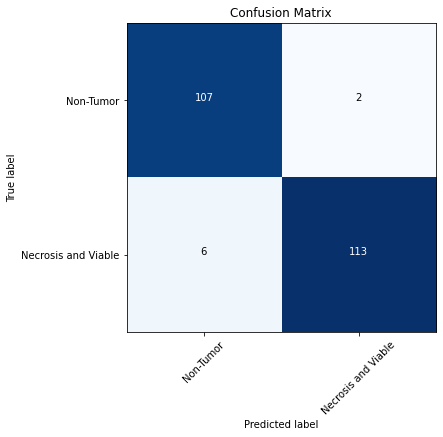

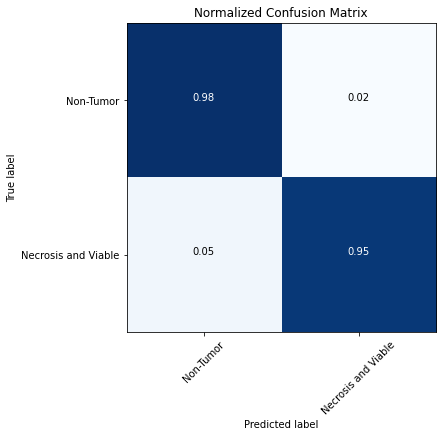

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 400, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 400)
After applying Mututal information gain, shape for test data:  (228, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.002039617560069321


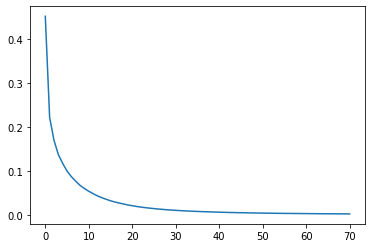




              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.98      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.964     	      0.982      	   0.966   
  1       0.983     	      0.966      	   0.982   





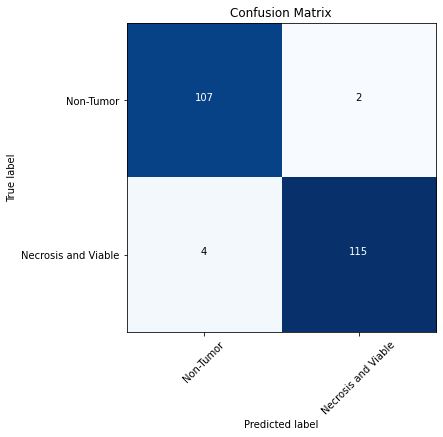

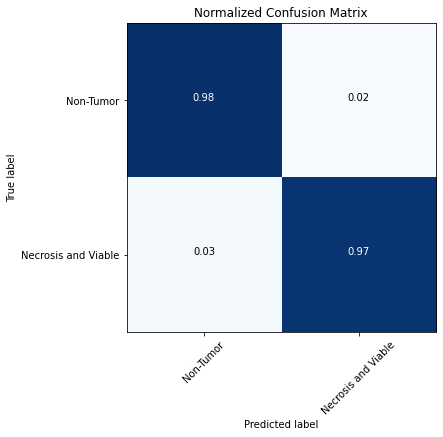

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.93
Accuracy on test data is:  0.969
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.939
Loss value:  0.028775901470038633


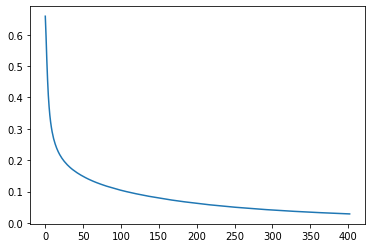




              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.98      0.96      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.982      	   0.958   
  1       0.983     	      0.958      	   0.982   





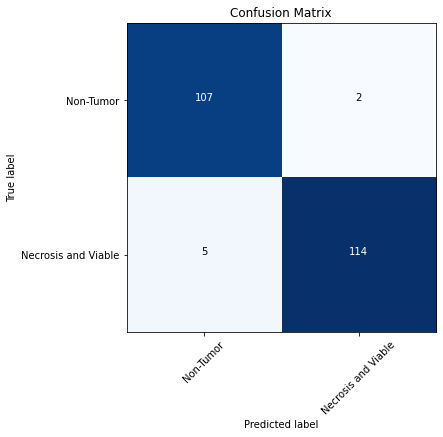

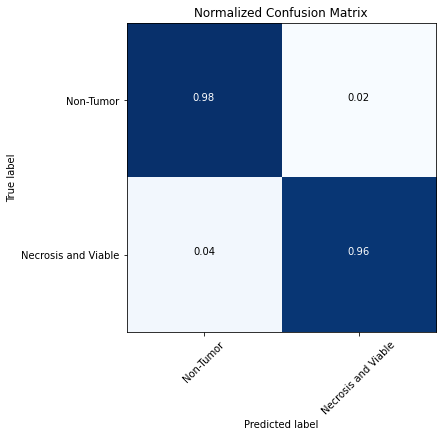

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.969
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.94
Loss value:  0.00013265795086189646



              precision    recall  f1-score   support

           0       0.95      0.99      0.97       109
           1       0.99      0.95      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.947     	      0.991      	    0.95   
  1       0.991     	       0.95      	   0.991   





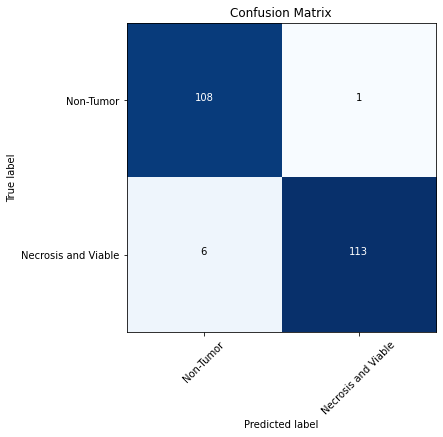

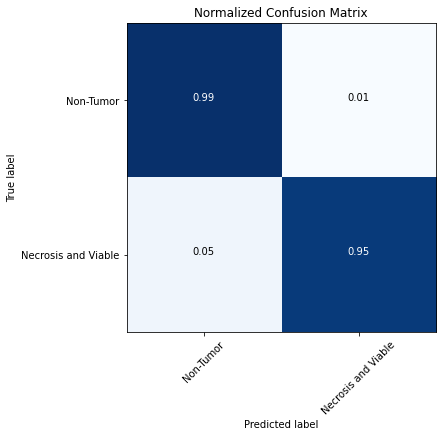

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 500

##### gini

In [ ]:
# getting 400 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 500, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.94
Accuracy on test data is:  0.965
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  0.00208251674942639


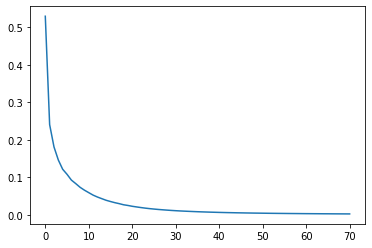




              precision    recall  f1-score   support

           0       0.95      0.97      0.96       109
           1       0.97      0.96      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.97      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.972      	   0.958   
  1       0.974     	      0.958      	   0.972   





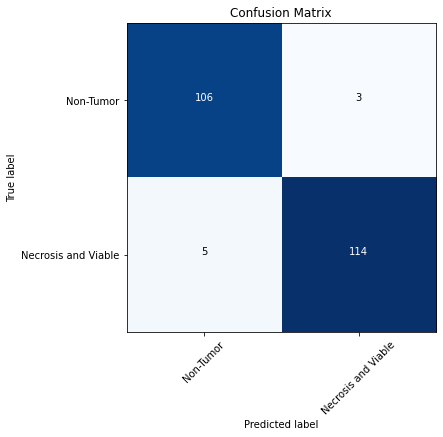

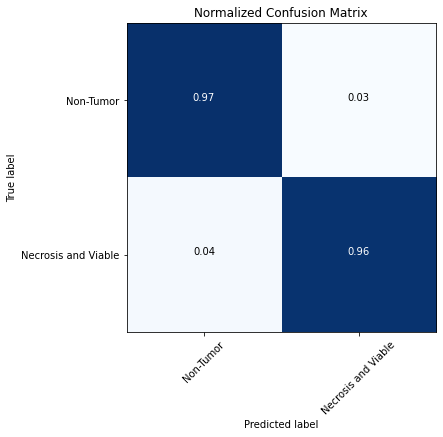

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.025470233303585645


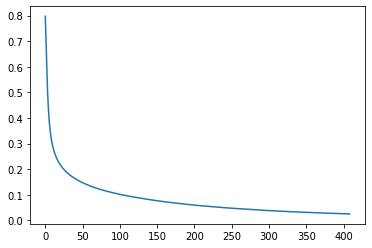




              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.98      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.964     	      0.982      	   0.966   
  1       0.983     	      0.966      	   0.982   





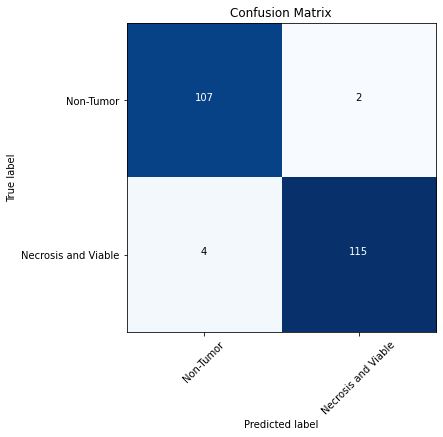

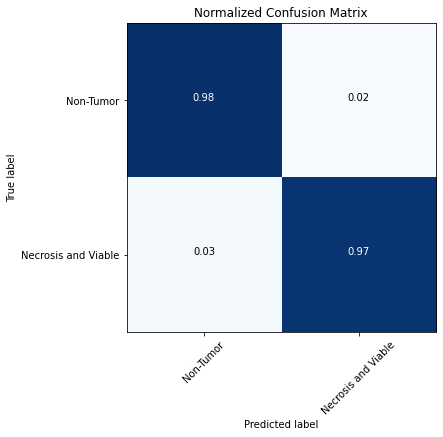

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.965
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  7.876886367876862e-05



              precision    recall  f1-score   support

           0       0.95      0.97      0.96       109
           1       0.97      0.96      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.97      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.972      	   0.958   
  1       0.974     	      0.958      	   0.972   





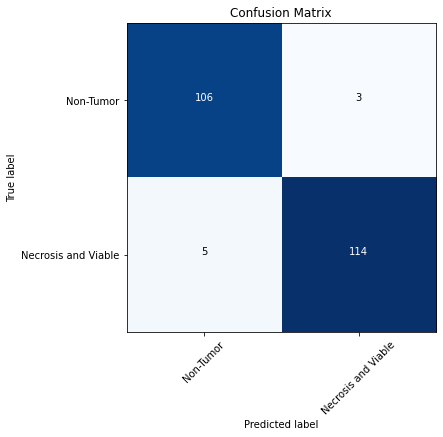

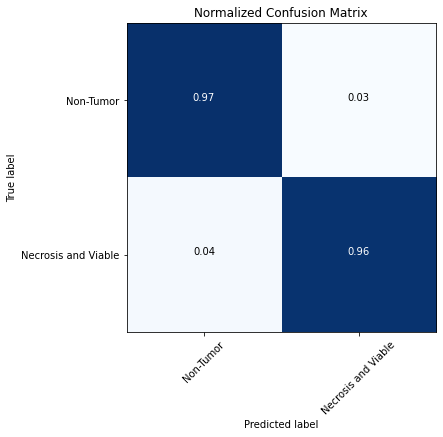

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 500, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 500)
After applying Mututal information gain, shape for test data:  (228, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.936
Accuracy on test data is:  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.0020415138430379207


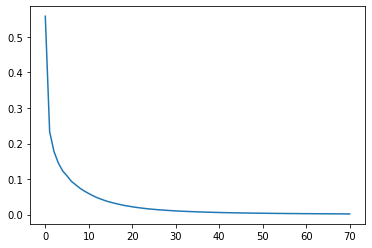




              precision    recall  f1-score   support

           0       0.96      0.99      0.98       109
           1       0.99      0.97      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.964     	      0.991      	   0.966   
  1       0.991     	      0.966      	   0.991   





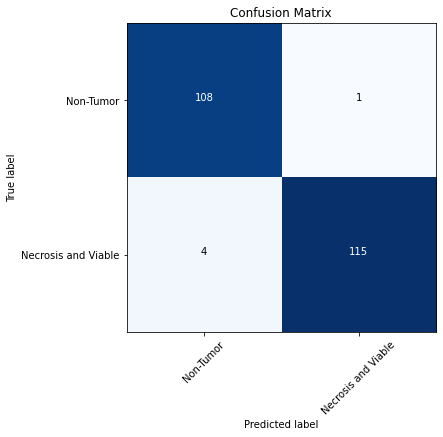

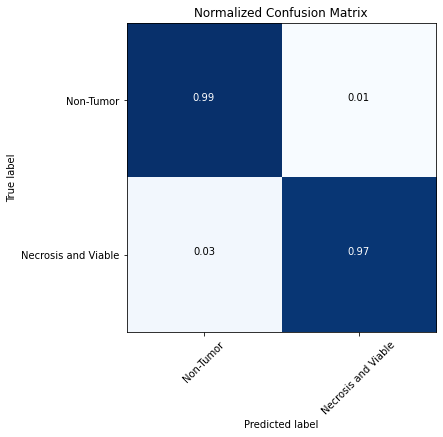

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.936
Accuracy on test data is:  0.969
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.94
Loss value:  0.027244353440068852


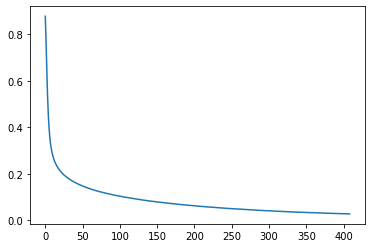




              precision    recall  f1-score   support

           0       0.95      0.99      0.97       109
           1       0.99      0.95      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.947     	      0.991      	    0.95   
  1       0.991     	       0.95      	   0.991   





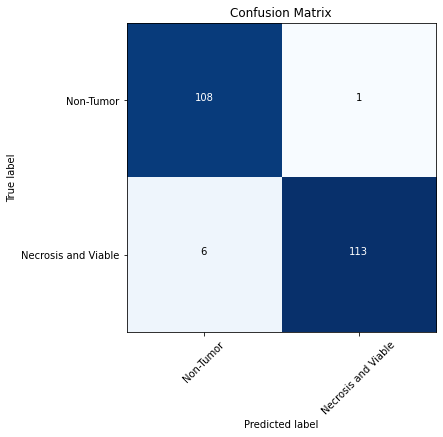

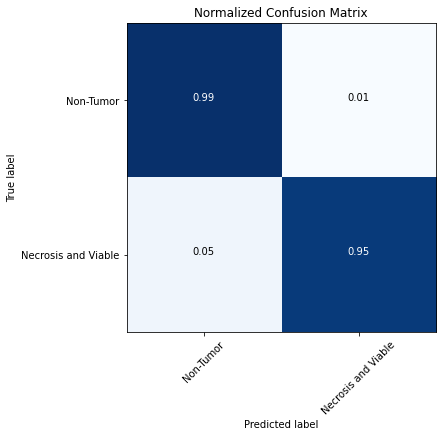

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.965
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  0.00012313592205936513



              precision    recall  f1-score   support

           0       0.95      0.97      0.96       109
           1       0.97      0.96      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.97      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.972      	   0.958   
  1       0.974     	      0.958      	   0.972   





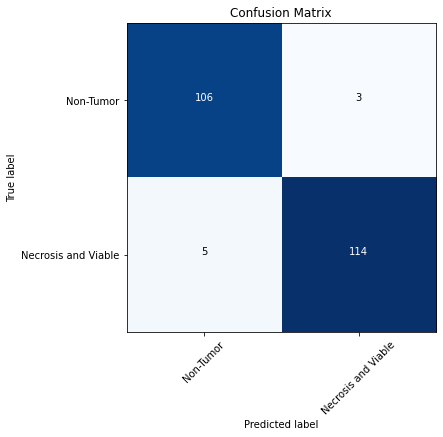

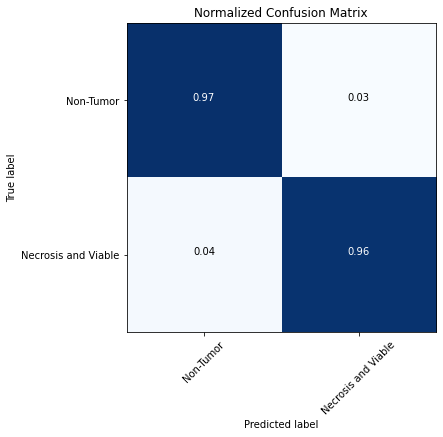

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 600

##### gini

In [ ]:
# getting 400 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 600, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.0017564567949086426


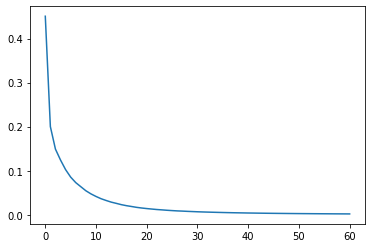




              precision    recall  f1-score   support

           0       0.97      0.98      0.98       109
           1       0.98      0.97      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.973     	      0.982      	   0.975   
  1       0.983     	      0.975      	   0.982   





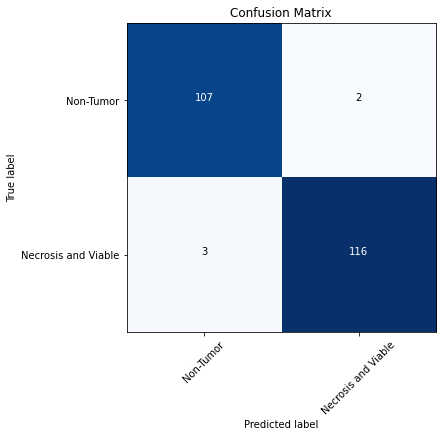

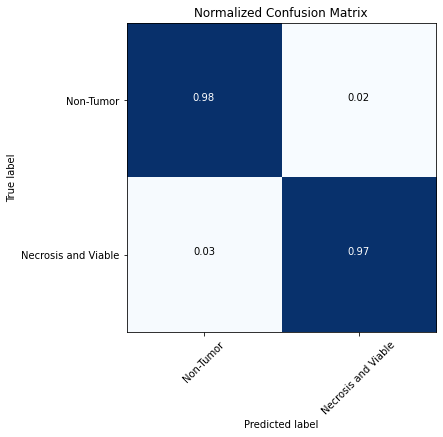

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.974
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.02431332785763025


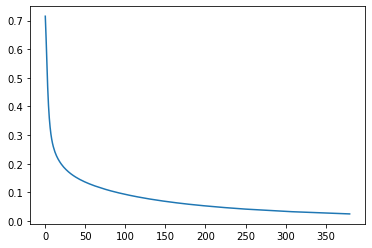




              precision    recall  f1-score   support

           0       0.97      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.972      	   0.975   
  1       0.975     	      0.975      	   0.972   





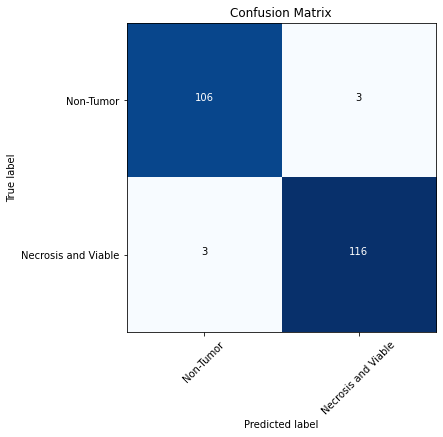

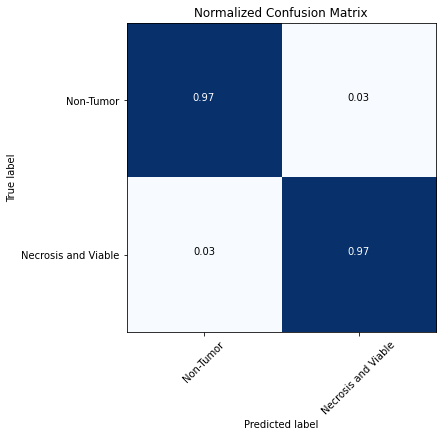

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.965
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  0.0001123962956500815



              precision    recall  f1-score   support

           0       0.95      0.97      0.96       109
           1       0.97      0.96      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.97      0.96       228
weighted avg       0.97      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.972      	   0.958   
  1       0.974     	      0.958      	   0.972   





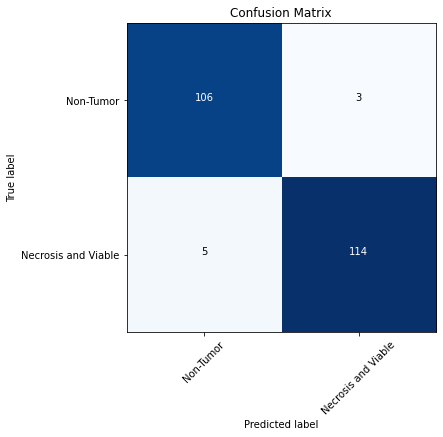

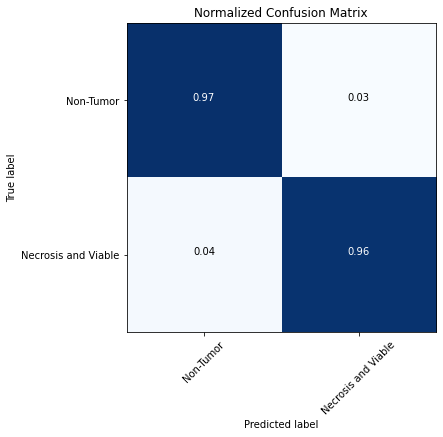

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 600, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 600)
After applying Mututal information gain, shape for test data:  (228, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.941
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.0017514275265093227


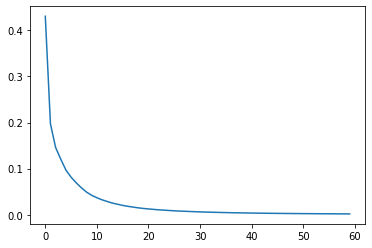




              precision    recall  f1-score   support

           0       0.97      0.98      0.98       109
           1       0.98      0.97      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.973     	      0.982      	   0.975   
  1       0.983     	      0.975      	   0.982   





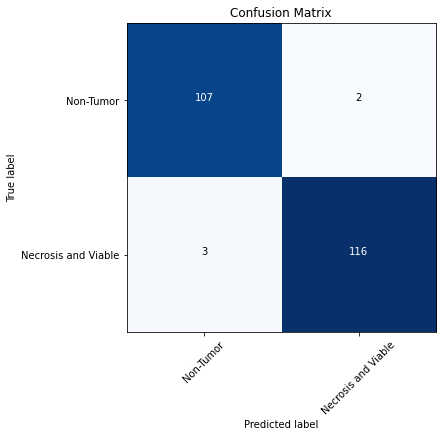

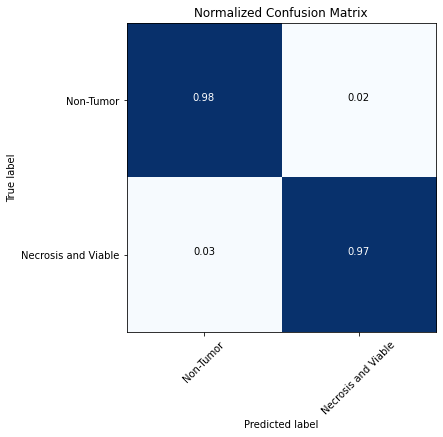

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.935
Accuracy on test data is:  0.982
ROC-AUC score is:  1.0
The Matthews correlation coefficinet (MCC) is:  0.965
Loss value:  0.02380524822370027


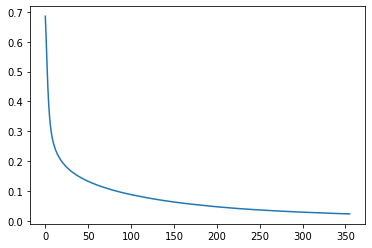




              precision    recall  f1-score   support

           0       0.96      1.00      0.98       109
           1       1.00      0.97      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.965     	       1.0       	   0.966   
  1        1.0      	      0.966      	    1.0    





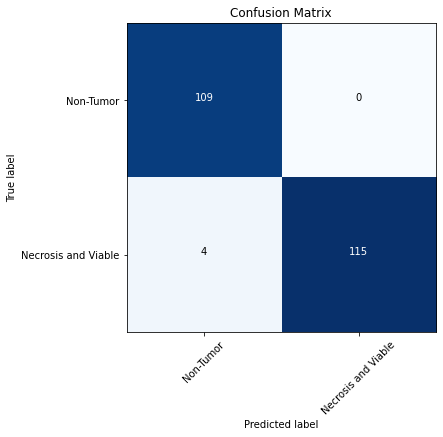

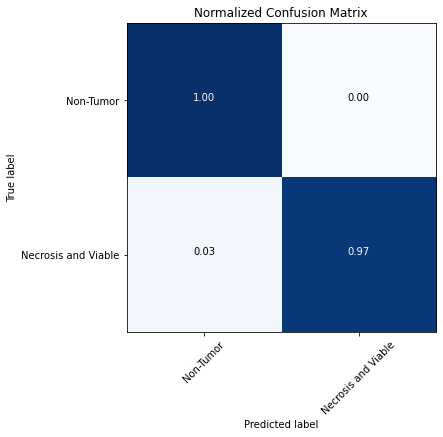

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.965
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.93
Loss value:  7.366709222594724e-05



              precision    recall  f1-score   support

           0       0.96      0.96      0.96       109
           1       0.97      0.97      0.97       119

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.963     	      0.963      	   0.966   
  1       0.966     	      0.966      	   0.963   





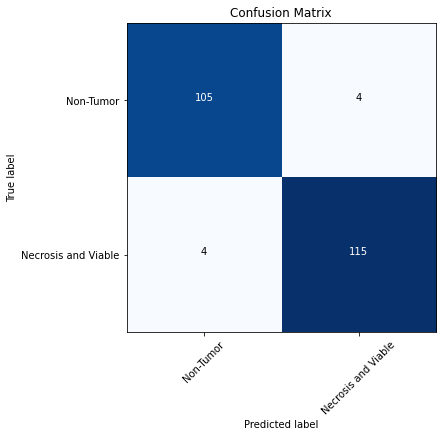

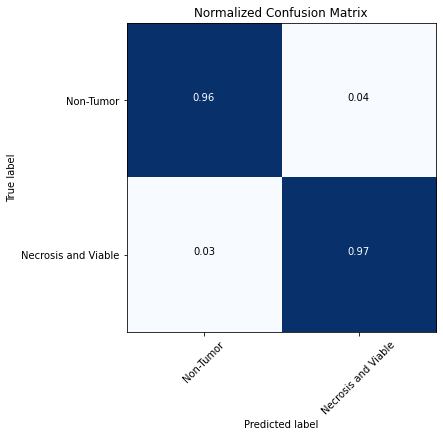

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 700

##### gini

In [ ]:
# getting 400 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 700, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)


**adam**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.969
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.939
Loss value:  0.001812958721721965


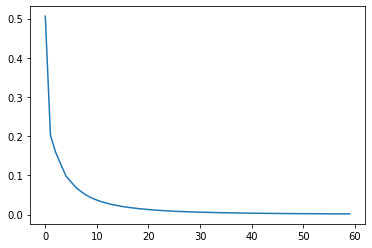




              precision    recall  f1-score   support

           0       0.96      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.964     	      0.972      	   0.966   
  1       0.975     	      0.966      	   0.972   





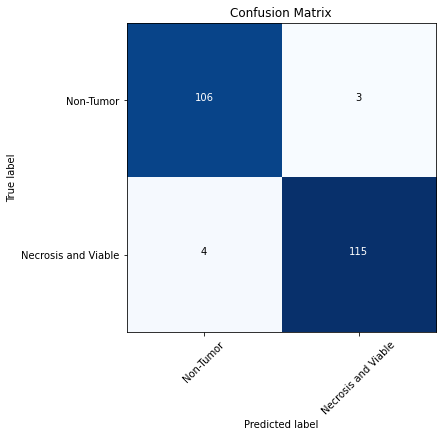

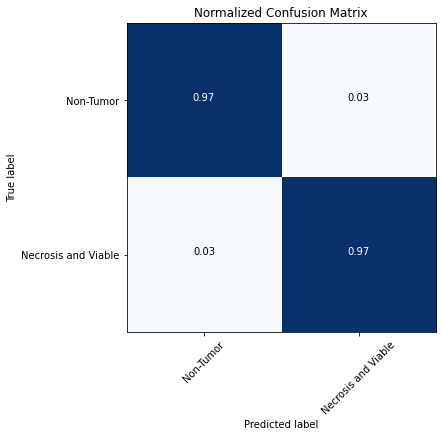

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.022929137439566562


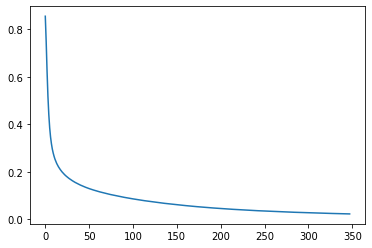




              precision    recall  f1-score   support

           0       0.97      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.972      	   0.975   
  1       0.975     	      0.975      	   0.972   





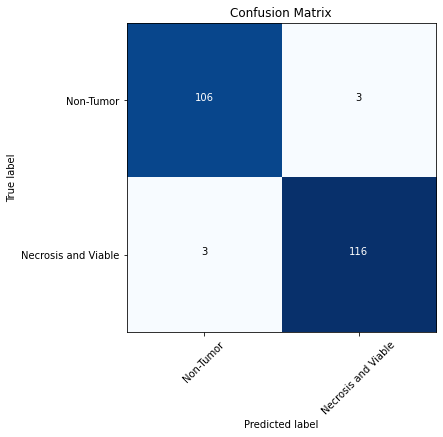

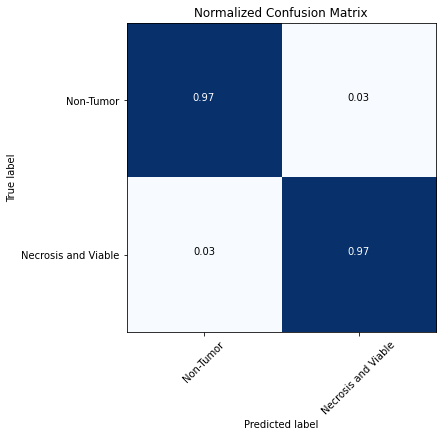

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.94
Accuracy on test data is:  0.961
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.921
Loss value:  4.2984144359836585e-05



              precision    recall  f1-score   support

           0       0.95      0.96      0.96       109
           1       0.97      0.96      0.96       119

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.963      	   0.958   
  1       0.966     	      0.958      	   0.963   





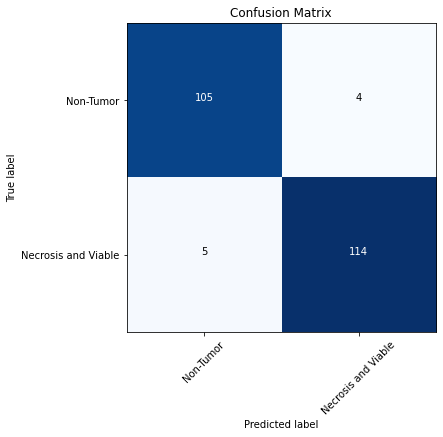

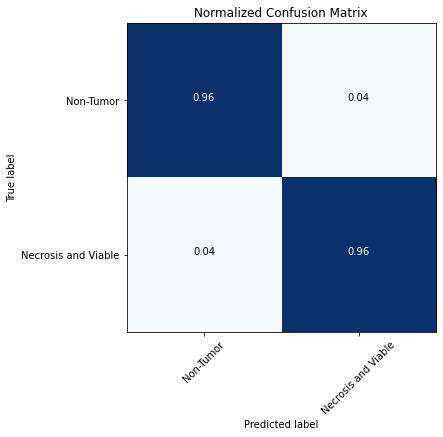

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 700, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 700)
After applying Mututal information gain, shape for test data:  (228, 700)


**adam**

k-fold validation accuracy for k=5 is:  0.94
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.0016769772513653954


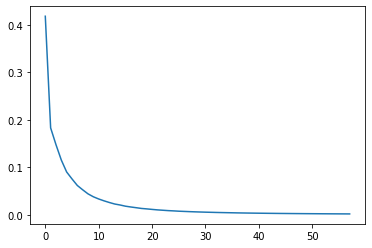




              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.98      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.964     	      0.982      	   0.966   
  1       0.983     	      0.966      	   0.982   





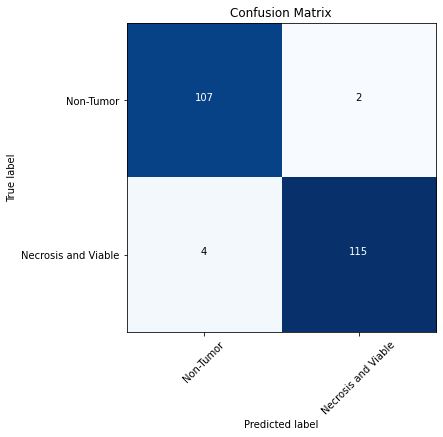

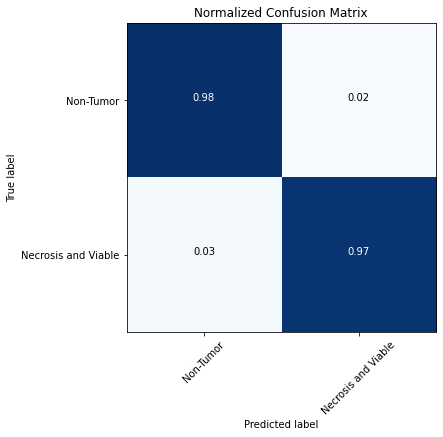

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.022716024540003488


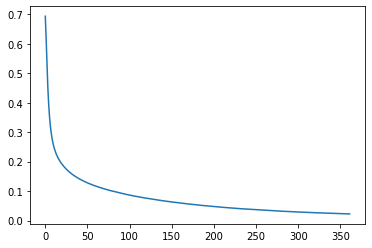




              precision    recall  f1-score   support

           0       0.97      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.972      	   0.975   
  1       0.975     	      0.975      	   0.972   





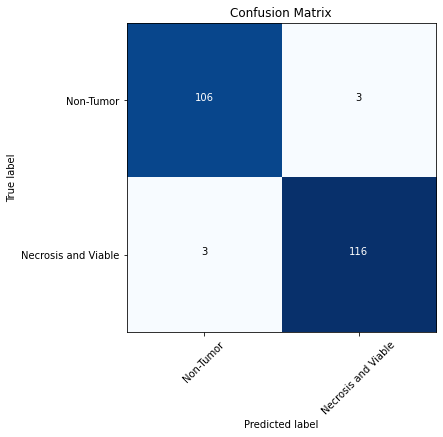

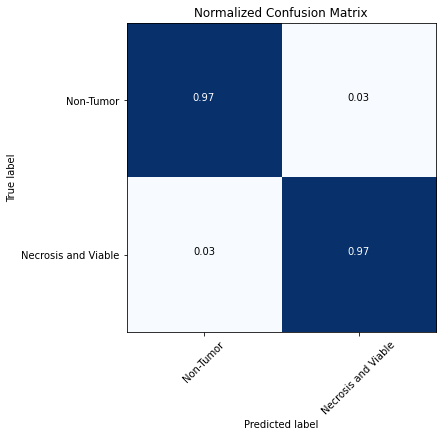

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.961
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.921
Loss value:  7.796795350318814e-05



              precision    recall  f1-score   support

           0       0.96      0.95      0.96       109
           1       0.96      0.97      0.96       119

    accuracy                           0.96       228
   macro avg       0.96      0.96      0.96       228
weighted avg       0.96      0.96      0.96       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.963     	      0.954      	   0.966   
  1       0.958     	      0.966      	   0.954   





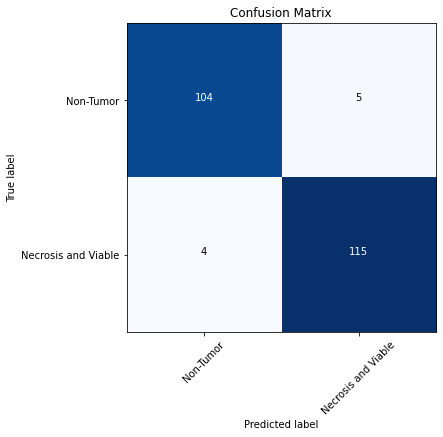

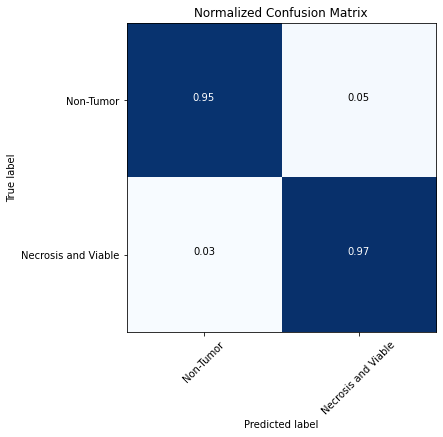

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 800

##### gini

In [ ]:
# getting 400 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 800, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)


**adam**

k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.0016105585058915214


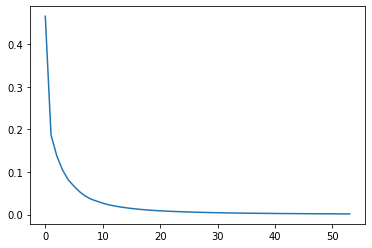




              precision    recall  f1-score   support

           0       0.97      0.98      0.98       109
           1       0.98      0.97      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.973     	      0.982      	   0.975   
  1       0.983     	      0.975      	   0.982   





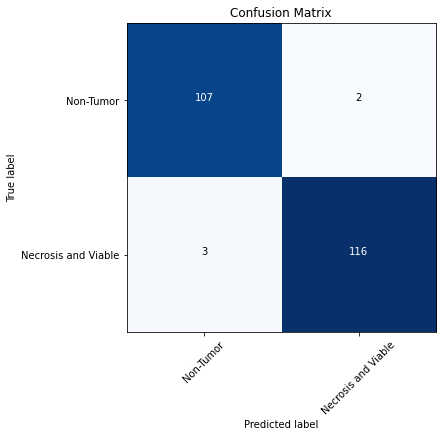

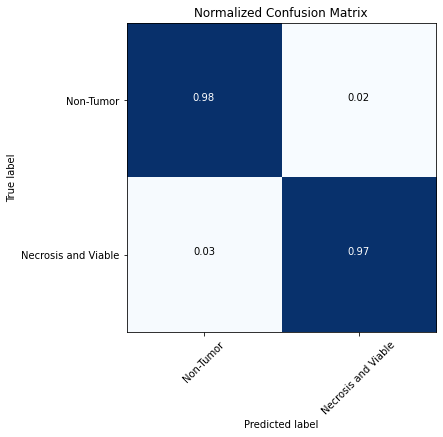

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.935
Accuracy on test data is:  0.982
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.965
Loss value:  0.02083649299355303


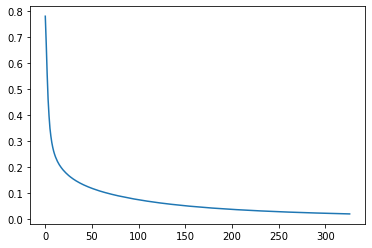




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       109
           1       0.98      0.98      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.982     	      0.982      	   0.983   
  1       0.983     	      0.983      	   0.982   





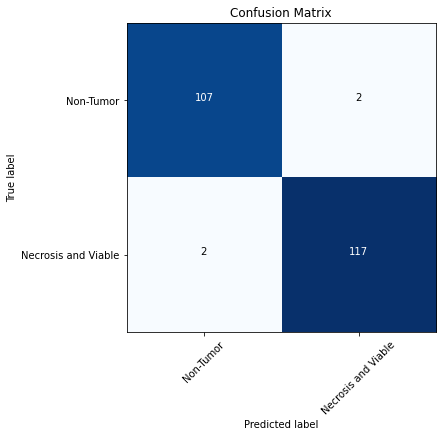

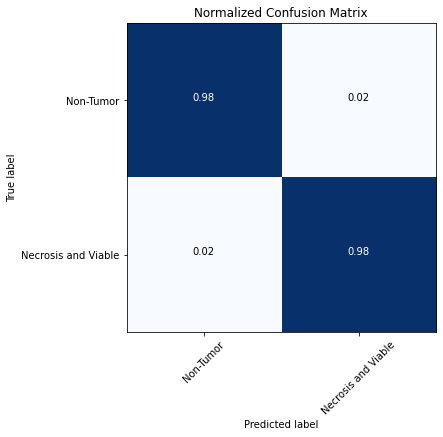

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.00015320281249174932



              precision    recall  f1-score   support

           0       0.97      0.98      0.98       109
           1       0.98      0.97      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.973     	      0.982      	   0.975   
  1       0.983     	      0.975      	   0.982   





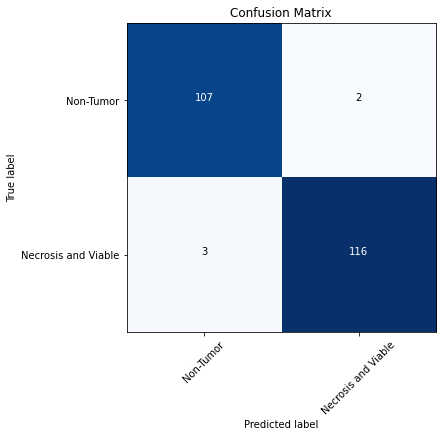

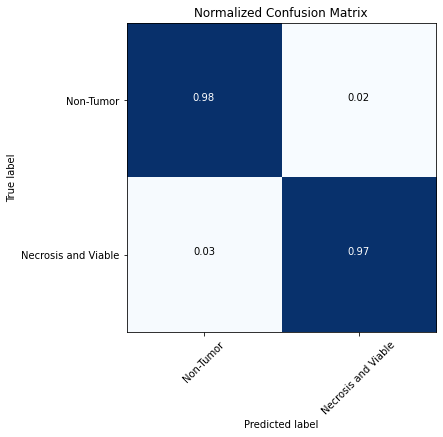

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 800, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 800)
After applying Mututal information gain, shape for test data:  (228, 800)


**adam**

k-fold validation accuracy for k=5 is:  0.93
Accuracy on test data is:  0.974
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.947
Loss value:  0.0015929578984737382


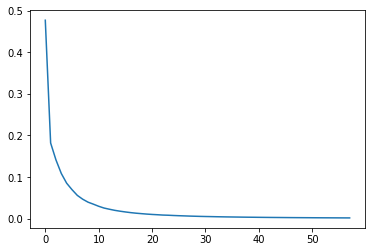




              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.98      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.964     	      0.982      	   0.966   
  1       0.983     	      0.966      	   0.982   





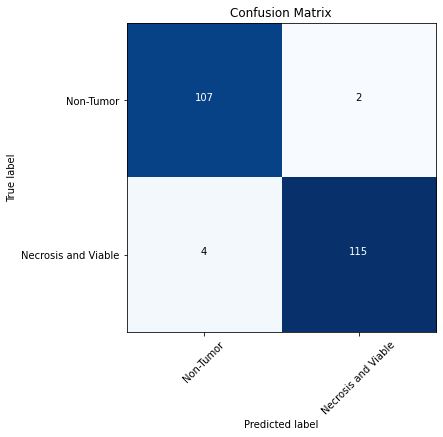

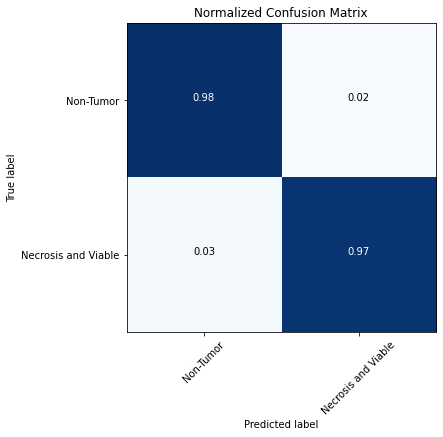

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.93
Accuracy on test data is:  0.982
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.965
Loss value:  0.021310311815800138


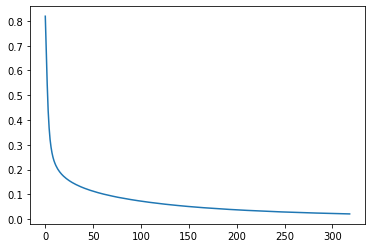




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       109
           1       0.98      0.98      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.982     	      0.982      	   0.983   
  1       0.983     	      0.983      	   0.982   





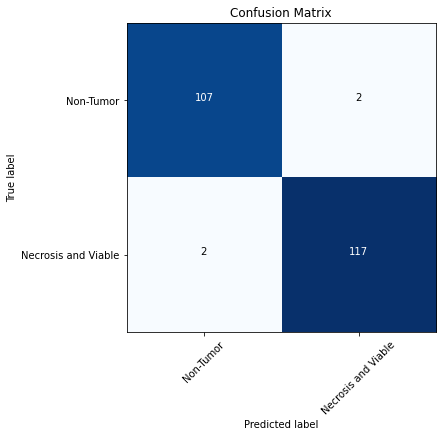

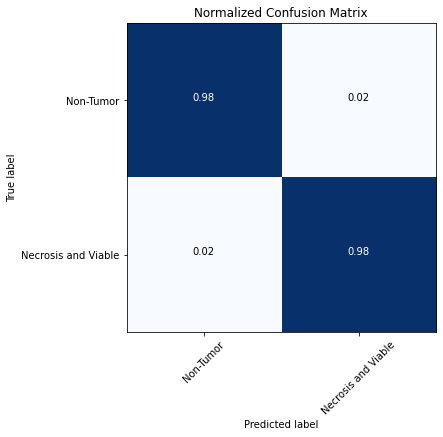

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.969
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.939
Loss value:  6.438950559685646e-05



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       109
           1       0.98      0.96      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.955     	      0.982      	   0.958   
  1       0.983     	      0.958      	   0.982   





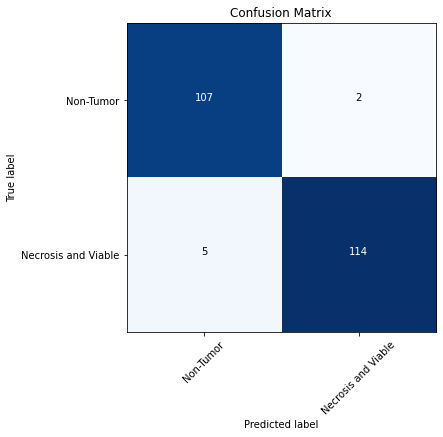

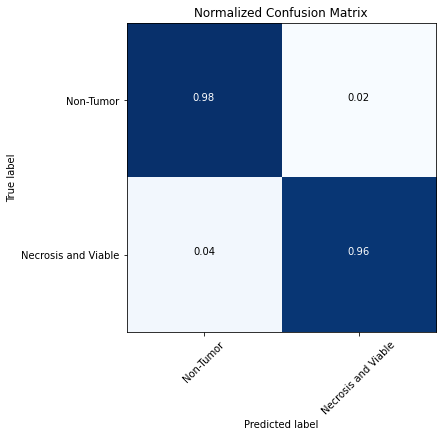

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 900

##### gini

In [ ]:
# getting 400 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 900, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)


**adam**

k-fold validation accuracy for k=5 is:  0.94
Accuracy on test data is:  0.969
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.939
Loss value:  0.0016819346040281653


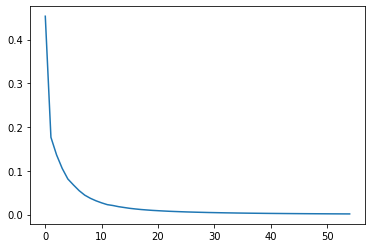




              precision    recall  f1-score   support

           0       0.96      0.97      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.964     	      0.972      	   0.966   
  1       0.975     	      0.966      	   0.972   





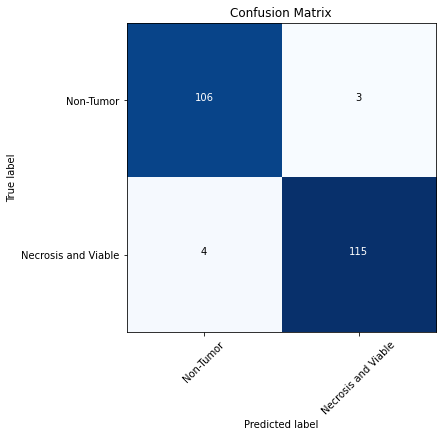

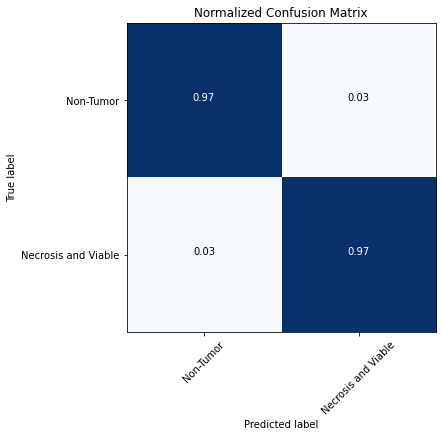

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.978
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.020846158569202893


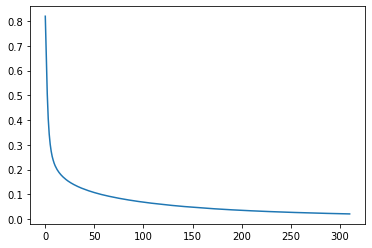




              precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	      0.972      	   0.983   
  1       0.975     	      0.983      	   0.972   





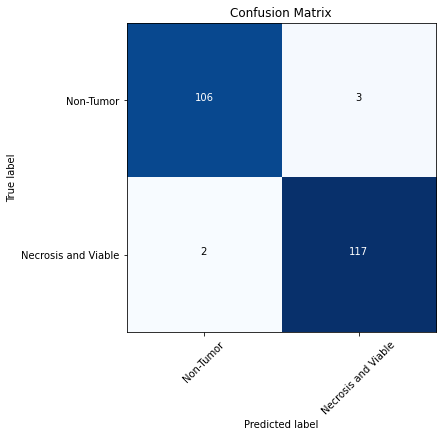

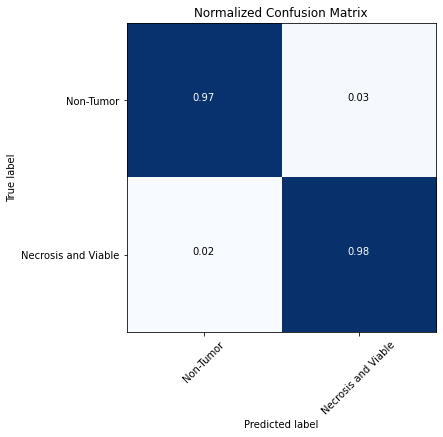

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.974
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.948
Loss value:  0.0001445021929922112



              precision    recall  f1-score   support

           0       0.96      0.99      0.97       109
           1       0.99      0.96      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.956     	      0.991      	   0.958   
  1       0.991     	      0.958      	   0.991   





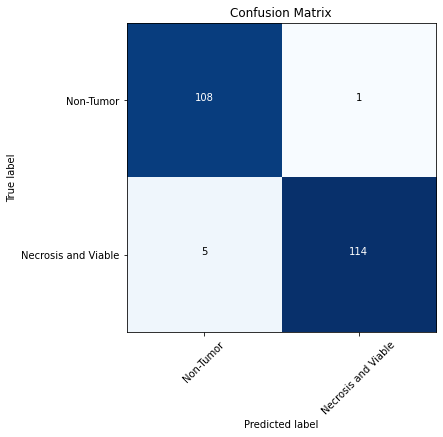

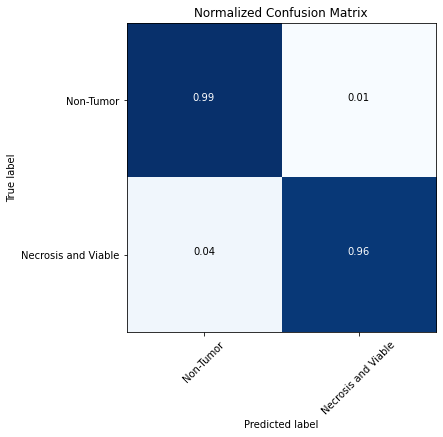

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using entropy
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 900, X_train= X_train_b1, y_train= train_y_b1 ,X_test= X_test_b1) 

After applying mutual information gain, shape for train data:  (916, 900)
After applying Mututal information gain, shape for test data:  (228, 900)


**adam**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.982
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.965
Loss value:  0.0017419839126789796


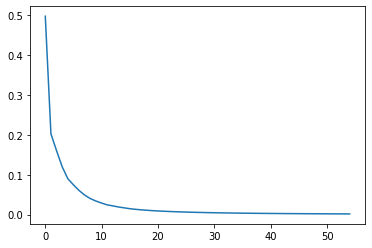




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       109
           1       0.99      0.97      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.973     	      0.991      	   0.975   
  1       0.991     	      0.975      	   0.991   





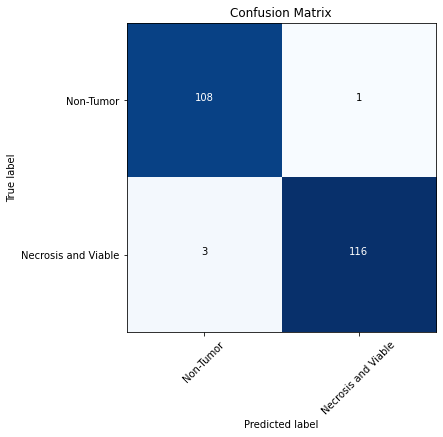

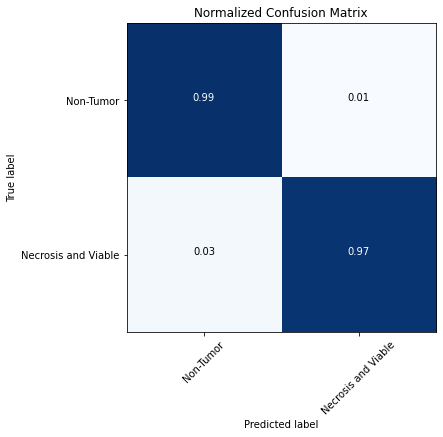

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.93
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.020144373481712306


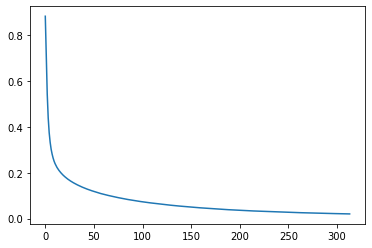




              precision    recall  f1-score   support

           0       0.98      0.97      0.98       109
           1       0.97      0.98      0.98       119

    accuracy                           0.98       228
   macro avg       0.98      0.98      0.98       228
weighted avg       0.98      0.98      0.98       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	      0.972      	   0.983   
  1       0.975     	      0.983      	   0.972   





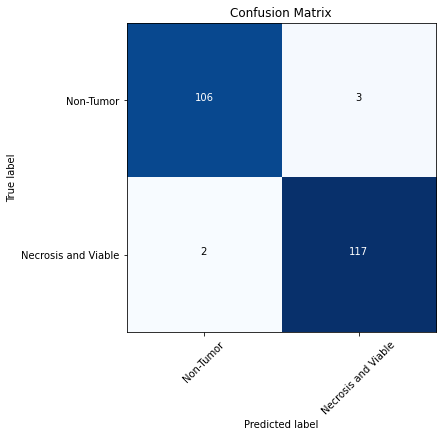

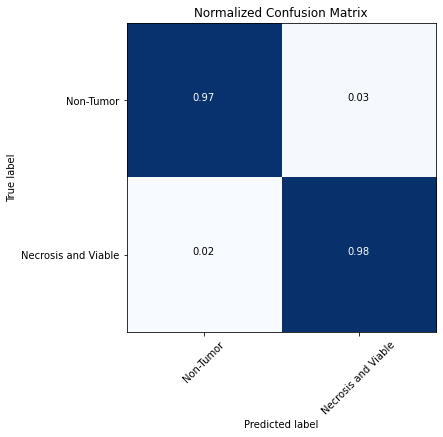

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.939
Accuracy on test data is:  0.969
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  8.181233554725164e-05



              precision    recall  f1-score   support

           0       0.97      0.96      0.97       109
           1       0.97      0.97      0.97       119

    accuracy                           0.97       228
   macro avg       0.97      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.972     	      0.963      	   0.975   
  1       0.967     	      0.975      	   0.963   





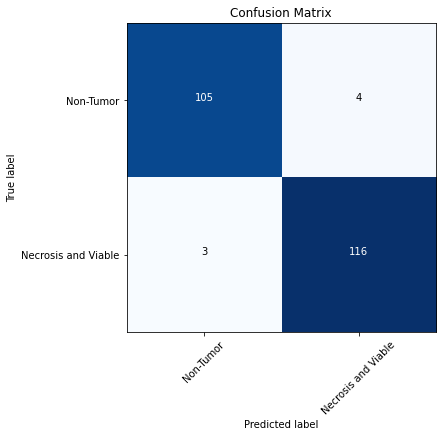

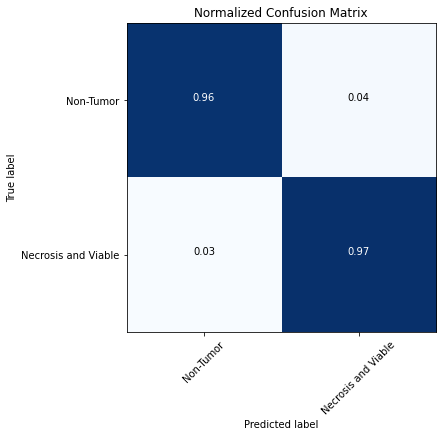

In [ ]:
# for lbfgs
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

# saving multiclass features 

**saving train features**

In [ ]:
import pandas as pd
# making a dataframe from the train features
# t_labels = y_train.tolist()
# df_train = pd.DataFrame(x_train_features)

df_train = pd.DataFrame(x_train_features)
df_train = df_train.assign(labels= y_train)
df_train.head()

# assigning labels into a new column
# df_train.assign(labels= t_labels)
df_train.head()

0         1         2         3         4         5         6  \
0 -0.528624 -0.339222  0.151850  0.194594  0.192190  0.202298 -0.243339   
1  0.209715 -0.526830 -0.175791  0.856019  0.670245  0.067937 -0.006268   
2  0.124291 -0.516310  0.064597  0.647671  0.003237  0.059670  0.103043   
3  0.094721 -0.470915 -0.073476  0.339083  0.146492  0.490193 -0.058501   
4 -0.158242 -0.310502  0.406067  0.651356  0.903234  0.598363 -0.380046   

          7         8         9  ...      1015      1016      1017      1018  \
0  0.231040 -0.684753  0.479715  ...  0.255826 -0.387687 -0.169119  0.345574   
1 -0.359899  0.027365  0.185339  ...  0.358999 -0.248527  0.097275  0.120164   
2 -0.256462 -0.351375 -0.054102  ... -0.129597 -0.042790 -0.318924 -0.000465   
3 -0.256170 -0.038569  0.350152  ...  0.139917 -0.258650  0.069644  0.192570   
4  0.528742  0.461066  0.331614  ...  0.056322 -0.744555  0.064448  0.289311   

       1019      1020      1021      1022      1023  labels  
0  0.606254  0.320685 -0.005027 -0.093069  0.401478       1  
1  0.682499  0.308895  0.022966  0.467152 -0.361063       0  
2  0.360453  0.374753 -0.436665  0.584223 -0.241561       0  
3  0.524029  0.100356 -0.436910  0.355013 -0.073992       0  
4  0.359039 -0.017468 -0.515261  0.209944  0.178076       0  

[5 rows x 1025 columns]

In [ ]:
y_train.shape

(916,)

In [ ]:
# saving csv to local machine
df_train.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_multiclass_train_features.csv', index=False)

**saving test features**

In [ ]:
# making a dataframe from the train features
df_test = pd.DataFrame(x_test_features)
df_test = df_test.assign(labels= y_test)

# saving dataframe to local machine
df_test.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_multiclass_test_features.csv', index=False)

# visualize
df_test.head()

0         1         2         3         4         5         6  \
0 -0.092870 -0.084168  0.330710  0.236360  0.465948 -0.010828 -0.311789   
1 -0.674828 -0.599340 -0.067704  0.338190  0.161329 -0.104761 -0.205920   
2 -0.509896 -0.766090 -0.086173  0.029261  0.104680  0.103702 -0.424090   
3 -0.471278 -0.374827  0.606167  0.538498 -0.098080  0.241178 -0.090419   
4 -0.262120 -0.757987 -0.068572  0.722429  0.400141  0.158231 -0.015343   

          7         8         9  ...      1015      1016      1017      1018  \
0 -0.179136  0.366699  0.057734  ...  0.264598 -0.475756 -0.250332  0.259860   
1  0.794936 -0.044862  0.252627  ...  0.481522 -0.346930 -0.135490  0.414682   
2  0.044116 -0.478099  0.565916  ...  0.022739  0.077136  0.096273  0.539660   
3 -0.322303 -0.502501  0.554042  ...  0.577489 -0.505745 -0.400035 -0.172693   
4 -0.170399  0.252491 -0.086116  ...  0.266684 -0.269666  0.173127  0.437608   

       1019      1020      1021      1022      1023  labels  
0  0.592601  0.280608 -0.204659  0.370876  0.131930       0  
1  0.851681  0.567893 -0.235248 -0.096678  0.292946       0  
2  0.414839  0.139479  0.204849 -0.122321  0.301695       2  
3  0.272088  0.358482 -0.412307  0.337186  0.600965       0  
4  0.487088  0.412608 -0.509814  0.926455 -0.318463       1  

[5 rows x 1025 columns]

**testing using loaded csv data**

In [ ]:
# loading csv files 
# load train data 
d_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_multiclass_train_features.csv')
# d_train.head()
# load test data
d_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_multiclass_test_features.csv')
d_test.head()

0         1         2         3         4         5         6  \
0 -0.092870 -0.084168  0.330710  0.236360  0.465948 -0.010828 -0.311789   
1 -0.674828 -0.599341 -0.067704  0.338190  0.161329 -0.104761 -0.205920   
2 -0.509896 -0.766090 -0.086173  0.029261  0.104680  0.103702 -0.424090   
3 -0.471278 -0.374827  0.606167  0.538498 -0.098080  0.241178 -0.090419   
4 -0.262120 -0.757987 -0.068572  0.722429  0.400141  0.158231 -0.015343   

          7         8         9  ...      1015      1016      1017      1018  \
0 -0.179136  0.366699  0.057734  ...  0.264597 -0.475756 -0.250332  0.259860   
1  0.794936 -0.044862  0.252627  ...  0.481522 -0.346930 -0.135490  0.414682   
2  0.044116 -0.478099  0.565916  ...  0.022739  0.077136  0.096273  0.539660   
3 -0.322303 -0.502501  0.554042  ...  0.577489 -0.505745 -0.400035 -0.172693   
4 -0.170399  0.252491 -0.086116  ...  0.266684 -0.269666  0.173127  0.437608   

       1019      1020      1021      1022      1023  labels  
0  0.592601  0.280608 -0.204659  0.370876  0.131930       0  
1  0.851681  0.567893 -0.235248 -0.096678  0.292946       0  
2  0.414839  0.139479  0.204849 -0.122321  0.301695       2  
3  0.272089  0.358482 -0.412307  0.337186  0.600965       0  
4  0.487088  0.412608 -0.509814  0.926455 -0.318463       1  

[5 rows x 1025 columns]

In [ ]:
# separate the independent and target variable 
train_X = d_train.drop(columns=['labels'])
train_Y = d_train['labels']

print(train_X.shape)
print(train_Y.shape)

# separate the independent and target variable 
test_X = d_test.drop(columns=['labels'])
test_Y = d_test['labels']

print(test_X.shape)
print(test_Y.shape)

(916, 1024)
(916,)
(228, 1024)
(228,)


In [ ]:
type(test_X)

pandas.core.frame.DataFrame

In [ ]:
# convert to numpy 
train_X = train_X.to_numpy()
print(type(train_X))
print(train_X.shape)

<class 'numpy.ndarray'>
(916, 1024)


In [ ]:
train_Y = train_Y.to_numpy()
test_X = test_X.to_numpy()
test_Y = test_Y.to_numpy()

Accuracy =  0.961
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.0023517727427290846


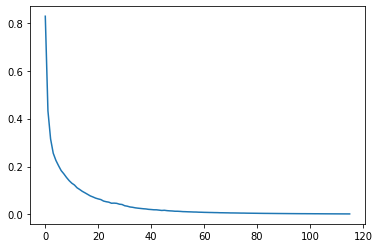

In [ ]:
# creating a pickle file for using serialization
import pickle

# Without feature selection
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
# mlp_classifier.fit(x_train_features, y_train)
mlp_classifier.fit(train_X, train_Y)

# predicting through test data
# mlp_pred = mlp_classifier.predict(x_test_features)
mlp_pred = mlp_classifier.predict(test_X)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_Y, mlp_pred)
print ("Accuracy = ", round(acc, 3))

# Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.metrics import roc_auc_score

# roc_auc = roc_auc_score(y_test, mlp_classifier.predict_proba(x_test_features), multi_class='ovr')
roc_auc = roc_auc_score(test_Y, mlp_classifier.predict_proba(test_X), multi_class='ovr')
print("ROC-AUC score is: ", round(roc_auc, 3))
# plot roc curve 
# change class names non-viable to necrosis

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_Y, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

# print loss 
mlp_loss = mlp_classifier.loss_
print("Loss value: ", mlp_loss)

# plot loss graph
label = "constant learning-rate"
plt.plot(mlp_classifier.loss_curve_, label= label)
plt.show()

# save the classifier as pickle
pickle_out = open("/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final2222_without_fs_mlp.pkl", "wb")
pickle.dump(mlp_classifier, pickle_out)
pickle_out.close()

# saving Non-tumor VS Necrosis and Viable features

In [ ]:
# train features 
df_train_b1 = pd.DataFrame(X_train_b1)
df_train_b1 = df_train_b1.assign(labels= train_y_b1)

# saving csv to local machine
df_train_b1.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_non-tumor_vs_necrosis_n_viable_train_features.csv', index=False)

# visualize
df_train_b1.head()

0         1         2         3         4         5         6  \
0  1.527325 -0.169662 -1.004222  1.901278  1.360958 -0.566417  0.329556   
1  1.238860 -0.133741 -0.099062  1.230342 -1.050552 -0.595877  0.700081   
2  1.139007  0.021257 -0.618963  0.236604 -0.532626  0.938438  0.152504   
3  0.284788  0.568973  1.186712  1.242207  2.203311  1.323939 -0.937418   
4  1.266300  0.230977 -0.813778  2.136781  0.446355 -2.093189 -1.047679   

          7         8         9  ...      1015      1016      1017      1018  \
0 -1.574602  1.018770  0.010246  ...  0.451944  0.641435  1.011690 -0.883742   
1 -1.259173 -0.365962 -0.743181  ... -1.111943  1.399679 -0.901796 -1.290422   
2 -1.258282  0.777707  0.528848  ... -0.249289  0.604126  0.884655 -0.639637   
3  1.135293  2.604452  0.470519  ... -0.516859 -1.186682  0.860765 -0.313490   
4 -0.350017  1.090702  0.400614  ... -1.324298  0.211964 -1.073572 -1.225908   

       1019      1020      1021      1022      1023  labels  
0  0.808140  0.148427  1.090285  1.384213 -1.462507       0  
1 -0.369619  0.464441 -0.619811  1.767089 -1.038011       0  
2  0.228597 -0.852226 -0.620722  1.017468 -0.442772       0  
3 -0.374789 -1.417595 -0.912232  0.543025  0.452622       0  
4  0.922315  1.852899 -1.343722  0.692156 -1.141766       0  

[5 rows x 1025 columns]

In [ ]:
# test features 
df_test_b1 = pd.DataFrame(X_test_b1)
df_test_b1 = df_test_b1.assign(labels= test_y_b1)

# saving csv to local machine
df_test_b1.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_non-tumor_vs_necrosis_n_viable_test_features.csv', index=False)

df_test_b1.head()

0         1         2         3         4         5         6  \
0  0.505538  1.341771  0.902960 -0.094192  0.622342 -0.847122 -0.706051   
1 -1.459648 -0.417242 -0.597230  0.233727 -0.478985 -1.181883 -0.347195   
2 -0.772288  0.349341  1.940167  0.878775 -1.416857  0.050987  0.044312   
3  0.821535  0.297348 -0.373406  1.928678  2.065974 -0.976998  0.682002   
4  0.218923  0.128883  1.696754  1.858805  0.999907 -0.761423 -0.489827   

          7         8         9  ...      1015      1016      1017      1018  \
0 -1.023368  2.259432 -0.391277  ...  0.149785 -0.196021 -0.586446 -0.412779   
1  1.947049  0.754696  0.221974  ...  0.844110  0.278770 -0.058453  0.109179   
2 -1.459955 -0.918505  1.170412  ...  1.151281 -0.306546 -1.274706 -1.871060   
3 -0.864820 -1.203282  0.215832  ... -1.461943  0.590924 -0.607992  1.035207   
4  0.163578 -0.211709  0.945086  ...  0.062381  0.970954 -0.535568  1.052909   

       1019      1020      1021      1022      1023  labels  
0  0.479373  0.012697  0.243390  1.069348  0.288705       0  
1  1.426857  1.391208  0.129581 -0.459772  0.860663       0  
2 -0.692779  0.386369 -0.529185  0.959166  1.954810       0  
3  1.558319  0.122814 -2.334162 -0.657561 -1.161825       0  
4 -0.286405 -1.052867 -0.547575  0.892794  0.933083       0  

[5 rows x 1025 columns]

# saving non-tumor VS necrosis features and experiment 

In [ ]:
# combinig dataset for train set 
train_x_b2 = np.concatenate((non_tumor_train, non_viable_tumor_train), axis=0)
train_y_b2 = np.concatenate((non_tumor_train_l, non_viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x_b2.shape)
print('Train labels shape: ',train_y_b2.shape)

# combinig dataset for test set 
test_x_b2 = np.concatenate((non_tumor_test, non_viable_tumor_test), axis=0)
test_y_b2 = np.concatenate((non_tumor_test_l, non_viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x_b2.shape)
print('Test labels shape: ',test_y_b2.shape)

Train set shape:  (650, 1024)
Train labels shape:  (650,)
Test set shape:  (149, 1024)
Test labels shape:  (149,)


**saving train data**

In [ ]:
# train features 
df_train_b2 = pd.DataFrame(train_x_b2)
df_train_b2 = df_train_b2.assign(labels= train_y_b2)
# df_train_b2.head()

# saving csv to local machine
df_train_b2.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_non-tumor_vs_necrosis_train_features.csv', index=False)

In [ ]:
df_train_b2.shape[0]

650

**saving test data**

In [ ]:
# train features 
df_test_b2 = pd.DataFrame(test_x_b2)
df_test_b2 = df_test_b2.assign(labels= test_y_b2)
# df_train_b2.head()

# saving csv to local machine
df_test_b2.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_non-tumor_vs_necrosis_test_features.csv', index=False)

# visualize 
df_test_b2.head()

0         1         2         3         4         5         6  \
0 -0.092870 -0.084168  0.330710  0.236360  0.465948 -0.010828 -0.311789   
1 -0.674828 -0.599340 -0.067704  0.338190  0.161329 -0.104761 -0.205920   
2 -0.471278 -0.374827  0.606167  0.538498 -0.098080  0.241178 -0.090419   
3  0.000707 -0.390055 -0.008262  0.864527  0.865247 -0.047271  0.097709   
4 -0.177747 -0.439394  0.541522  0.842829  0.570381  0.013219 -0.247999   

          7         8         9  ...      1015      1016      1017      1018  \
0 -0.179136  0.366699  0.057734  ...  0.264598 -0.475756 -0.250332  0.259860   
1  0.794936 -0.044862  0.252627  ...  0.481522 -0.346930 -0.135490  0.414682   
2 -0.322303 -0.502501  0.554042  ...  0.577489 -0.505745 -0.400035 -0.172693   
3 -0.127144 -0.580391  0.250674  ... -0.238945 -0.262232 -0.255019  0.689359   
4  0.210093 -0.309185  0.482433  ...  0.237291 -0.159117 -0.239266  0.694609   

       1019      1020      1021      1022      1023  labels  
0  0.592601  0.280608 -0.204659  0.370876  0.131930       0  
1  0.851681  0.567893 -0.235248 -0.096678  0.292946       0  
2  0.272088  0.358482 -0.412307  0.337186  0.600965       0  
3  0.887627  0.303557 -0.897440 -0.157156 -0.276417       0  
4  0.383207  0.058542 -0.417250  0.316892  0.313333       0  

[5 rows x 1025 columns]

In [ ]:
df_test_b2[0].shape

(149,)

In [ ]:
# with feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
# mlp_classifier.fit(X_train_b2, train_y_b2)
mlp_classifier.fit(train_x_b2, train_y_b2)

# getting k-fold validation accuracy, we are taking k= 5 folds
# k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)
k_fold_acc = cross_val_score(mlp_classifier, train_x_b2, train_y_b2, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
# mlp_pred = mlp_classifier.predict(X_test_b2)
mlp_pred = mlp_classifier.predict(test_x_b2)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b2, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
# lr_probs = mlp_classifier.predict_proba(X_test_b2)
lr_probs = mlp_classifier.predict_proba(test_x_b2)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
roc_auc = roc_auc_score(test_y_b2, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b2, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.98
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.953


#### 100

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 100, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 100)
After applying Mututal information gain, shape for test data:  (149, 100)


In [ ]:
def get_final_result(opt_name, num_iter, classes):
  
  # getting predicted outputs
  if opt_name == "lbfgs":
    pred = mlp_class_wo_plot(optimizer_name= opt_name, num_iteration=num_iter, train_data=train_x, test_data= test_x, y_train= train_y_b2, y_test=test_y_b2)
  else:
    pred = mlp_class_plot(optimizer_name= opt_name, num_iteration=num_iter, train_data= train_x, test_data= test_x, y_train= train_y_b2, y_test=test_y_b2)

  # perfomance metrices
  print()
  print()
  print()

  # getting classsification reports
  get_reports(test_y_b2, pred)
  print("\n\n")

  # getting sensitivity and specificity
  get_sn_sp(test_y_b2, pred)
  print("\n\n")

  # getting unnormalized and normalized confusion matrix
  conf_mat(classes, test_y_b2, pred)

**adam**

k-fold validation accuracy for k=5 is:  0.915
Accuracy on test data is:  0.966
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.007208298872122613


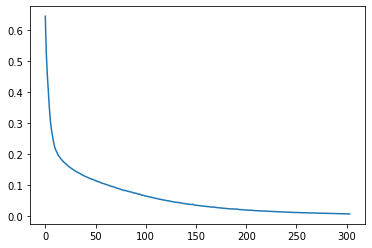




              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           1       0.96      0.94      0.95        47

    accuracy                           0.97       149
   macro avg       0.96      0.96      0.96       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.936   
  1       0.957     	      0.936      	    0.98   





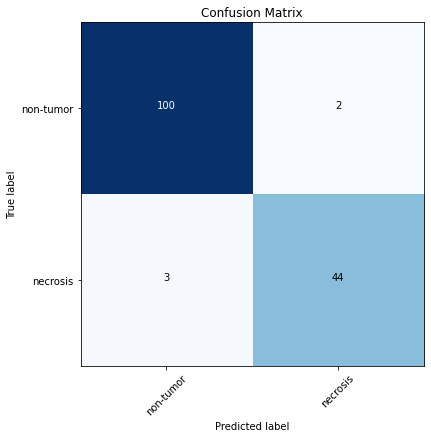

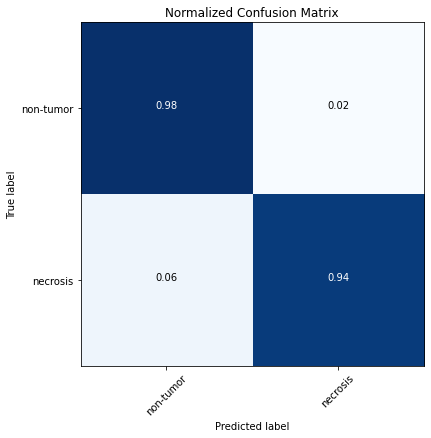

In [ ]:
classes = ['non-tumor', 'necrosis']
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.96
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.907
Loss value:  0.1516108114611022


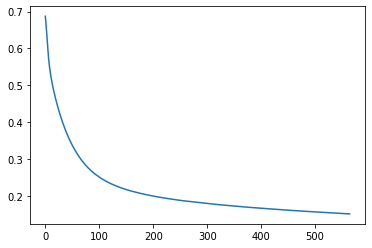




              precision    recall  f1-score   support

           0       0.97      0.97      0.97       102
           1       0.94      0.94      0.94        47

    accuracy                           0.96       149
   macro avg       0.95      0.95      0.95       149
weighted avg       0.96      0.96      0.96       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	      0.971      	   0.936   
  1       0.936     	      0.936      	   0.971   





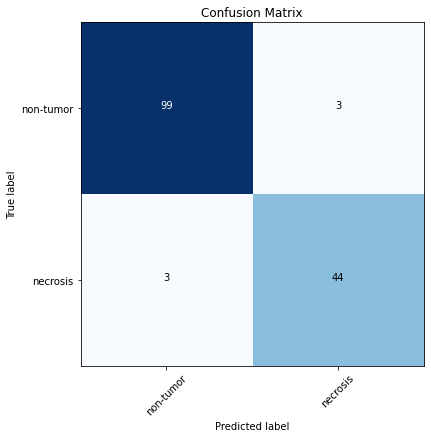

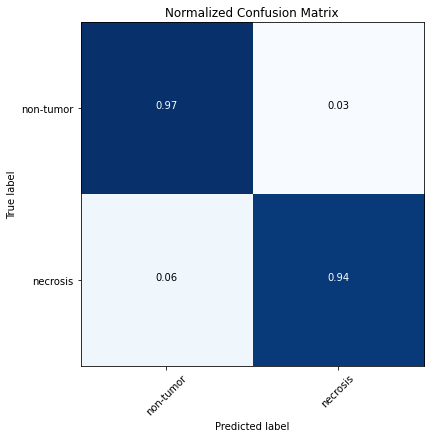

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.897
Accuracy on test data is:  0.966
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.923
Loss value:  0.00016166907922148118



              precision    recall  f1-score   support

           0       0.98      0.97      0.98       102
           1       0.94      0.96      0.95        47

    accuracy                           0.97       149
   macro avg       0.96      0.96      0.96       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.98     	      0.971      	   0.957   
  1       0.938     	      0.957      	   0.971   





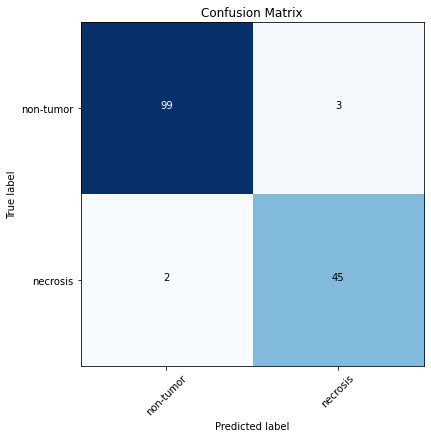

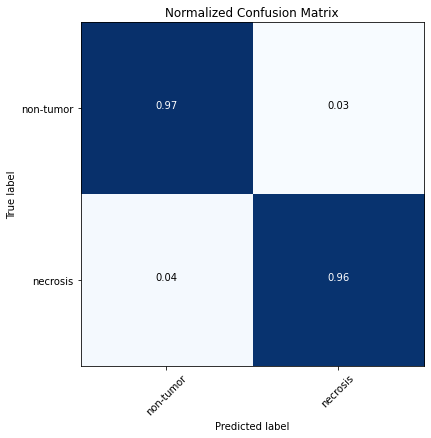

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 100, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 100)
After applying Mututal information gain, shape for test data:  (149, 100)


**adam**

k-fold validation accuracy for k=5 is:  0.908
Accuracy on test data is:  0.98
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.006446573762121025


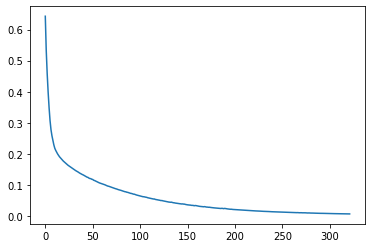




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





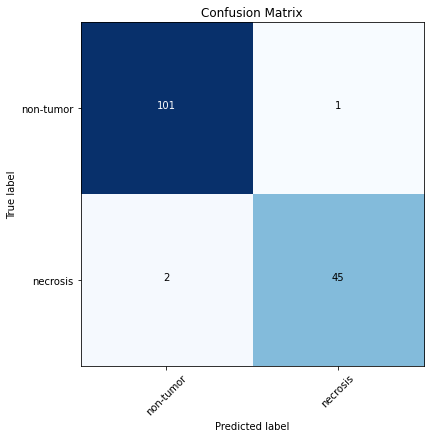

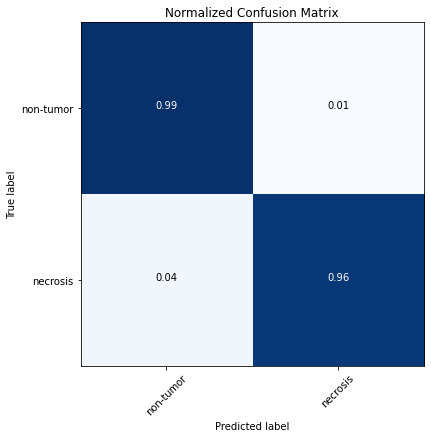

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.922
Accuracy on test data is:  0.973
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.16813098989407357


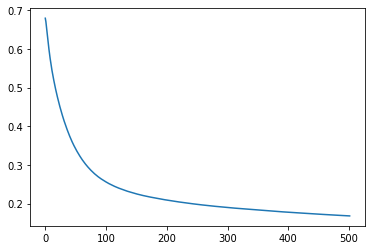




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.96      0.96      0.96        47

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.98     	       0.98      	   0.957   
  1       0.957     	      0.957      	    0.98   





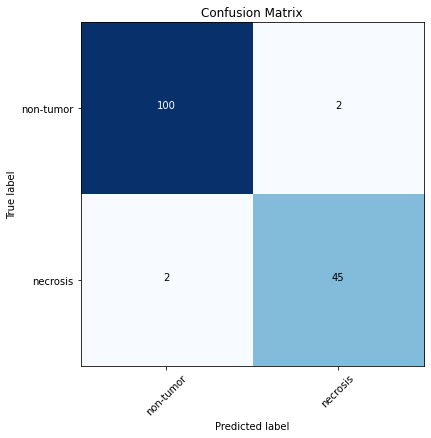

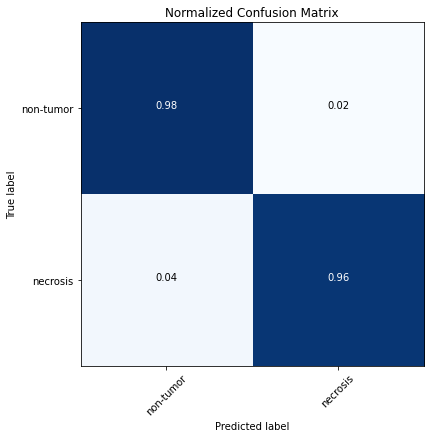

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbfgs**

k-fold validation accuracy for k=5 is:  0.9
Accuracy on test data is:  0.953
ROC-AUC score is:  0.974
The Matthews correlation coefficinet (MCC) is:  0.89
Loss value:  0.0002549733333311096



              precision    recall  f1-score   support

           0       0.95      0.98      0.97       102
           1       0.95      0.89      0.92        47

    accuracy                           0.95       149
   macro avg       0.95      0.94      0.94       149
weighted avg       0.95      0.95      0.95       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.952     	       0.98      	   0.894   
  1       0.955     	      0.894      	    0.98   





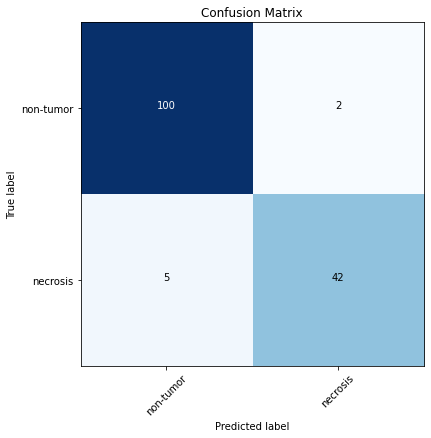

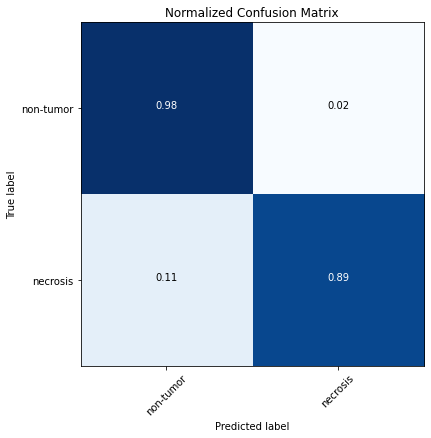

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 200

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 200, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 200)
After applying Mututal information gain, shape for test data:  (149, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.973
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.005546821279956309


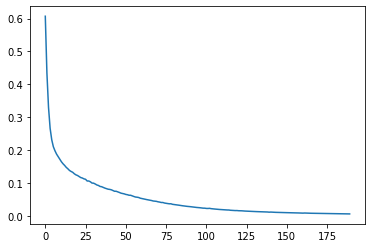




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           1       0.98      0.94      0.96        47

    accuracy                           0.97       149
   macro avg       0.97      0.96      0.97       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.936   
  1       0.978     	      0.936      	    0.99   





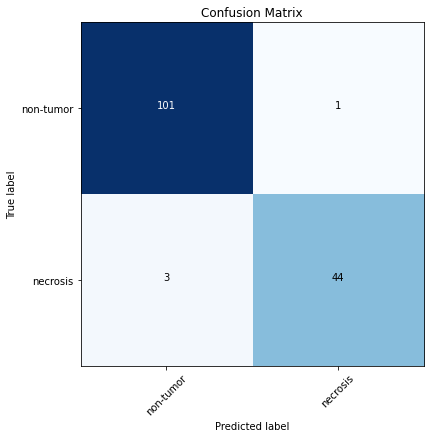

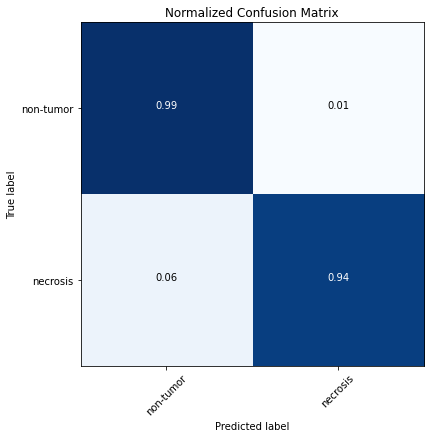

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.932
Accuracy on test data is:  0.98
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.12530570836798152


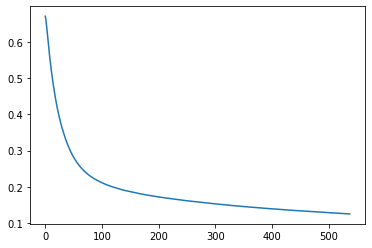




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





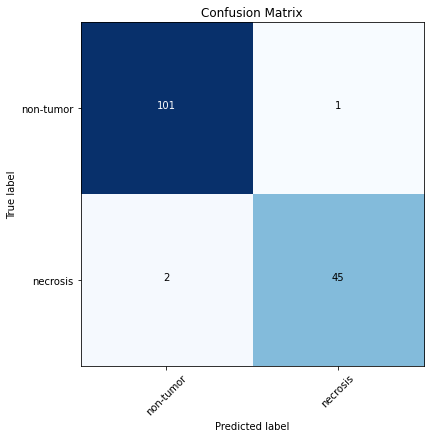

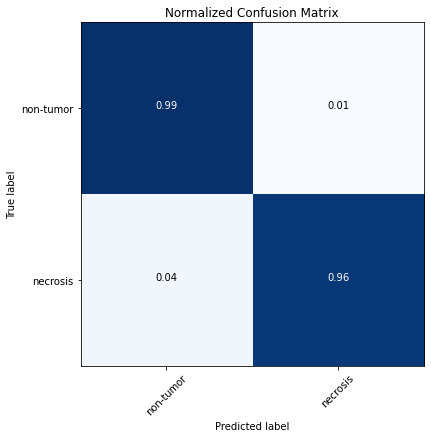

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbfgs**

k-fold validation accuracy for k=5 is:  0.911
Accuracy on test data is:  0.96
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.906
Loss value:  0.00011112998234999569



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           1       0.96      0.91      0.93        47

    accuracy                           0.96       149
   macro avg       0.96      0.95      0.95       149
weighted avg       0.96      0.96      0.96       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.915   
  1       0.956     	      0.915      	    0.98   





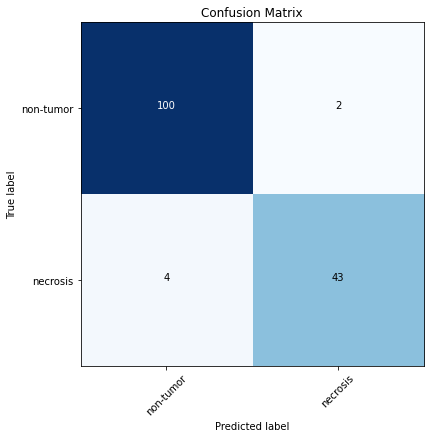

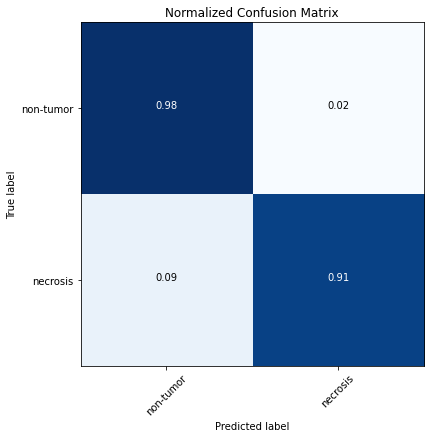

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 200, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 200)
After applying Mututal information gain, shape for test data:  (149, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.98
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.005413735624756756


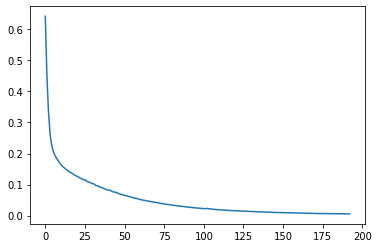




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





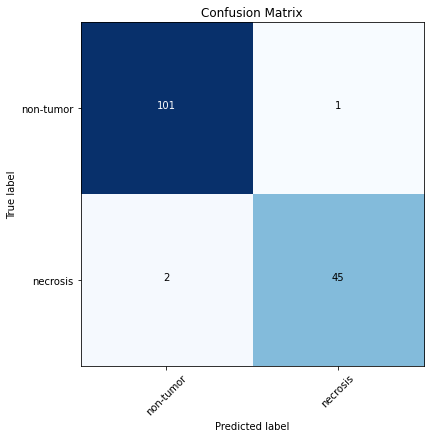

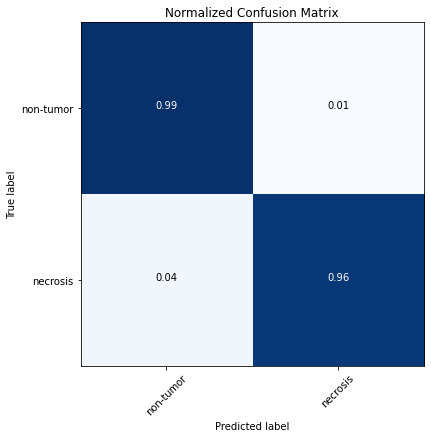

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.98
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.118747431760048


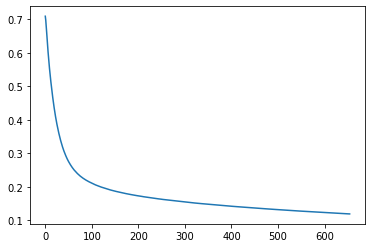




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





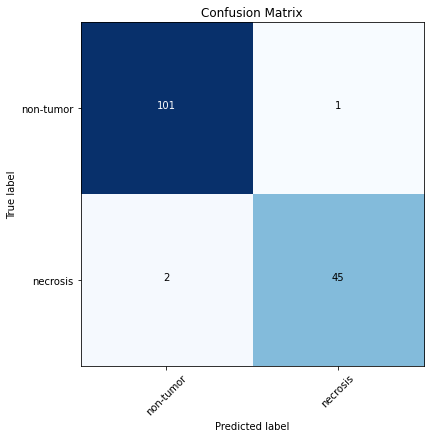

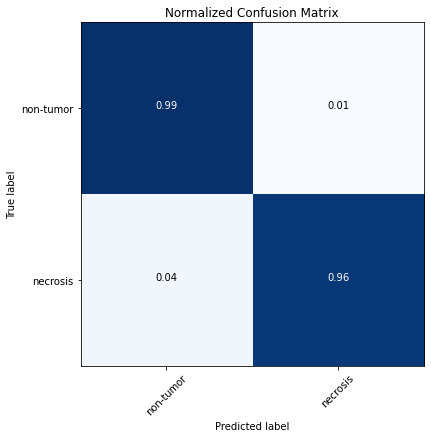

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbfgs**

k-fold validation accuracy for k=5 is:  0.909
Accuracy on test data is:  0.98
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.00015291683129404368



              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





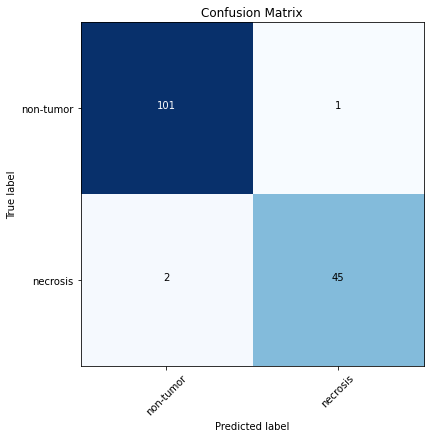

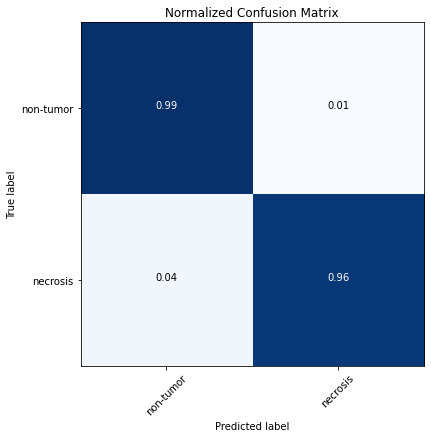

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 300

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 300, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2)

After applying mutual information gain, shape for train data:  (650, 300)
After applying Mututal information gain, shape for test data:  (149, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.92
Accuracy on test data is:  0.966
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.003816427222492739


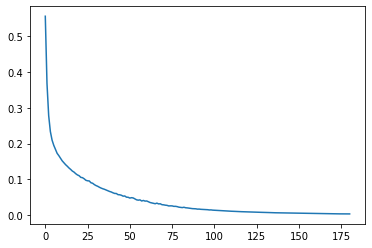




              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           1       0.96      0.94      0.95        47

    accuracy                           0.97       149
   macro avg       0.96      0.96      0.96       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.936   
  1       0.957     	      0.936      	    0.98   





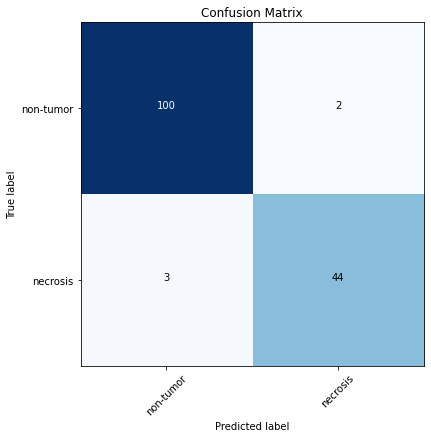

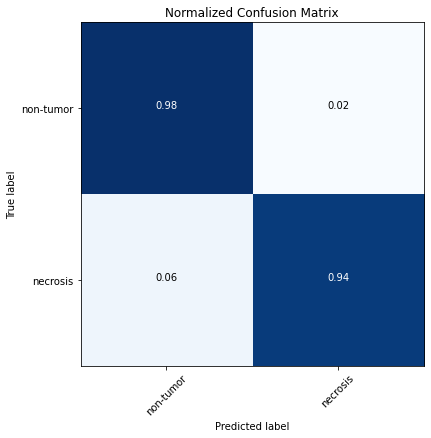

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.935
Accuracy on test data is:  0.98
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.09586943149074797


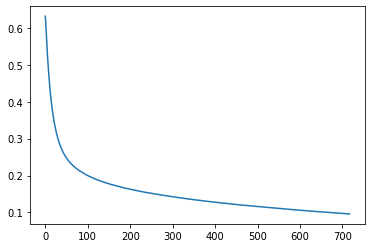




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





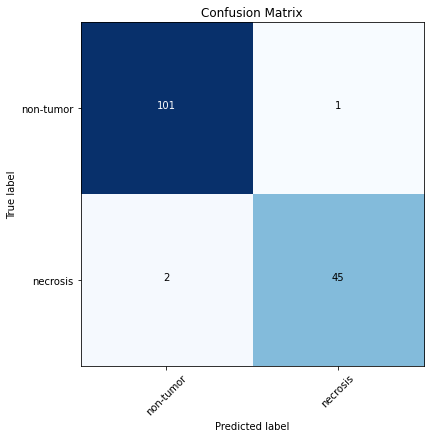

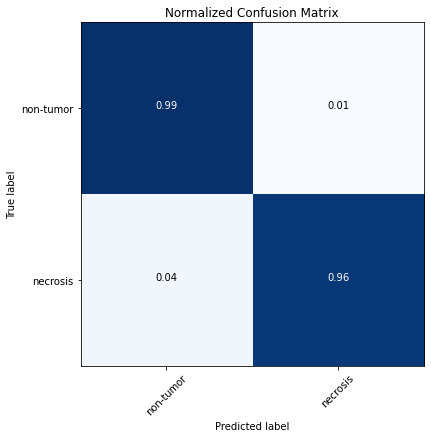

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.905
Accuracy on test data is:  0.966
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.0001040787594223448



              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           1       0.96      0.94      0.95        47

    accuracy                           0.97       149
   macro avg       0.96      0.96      0.96       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.936   
  1       0.957     	      0.936      	    0.98   





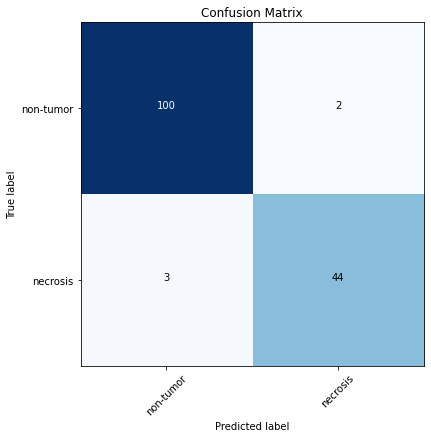

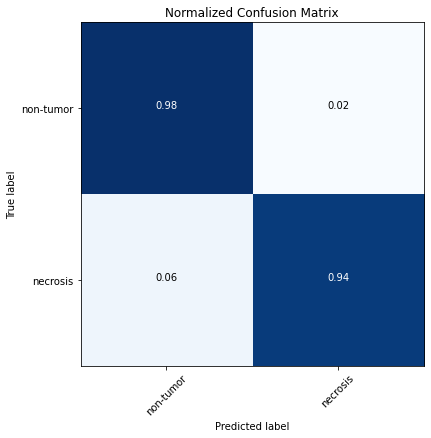

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 300, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 300)
After applying Mututal information gain, shape for test data:  (149, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.98
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.003671077645130183


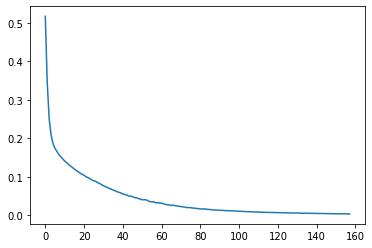




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





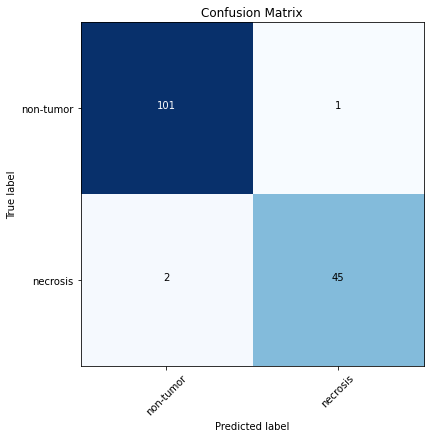

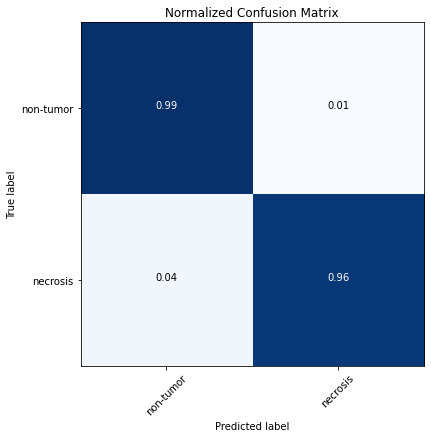

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.98
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.09776678643456196


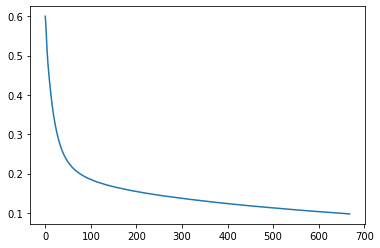




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





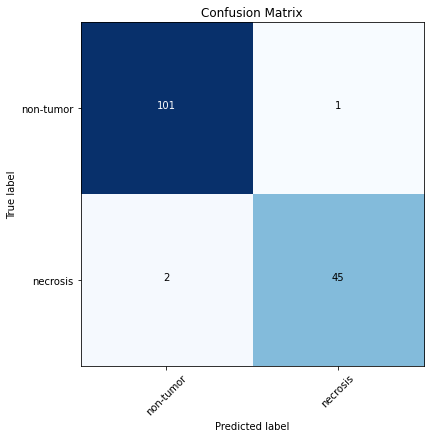

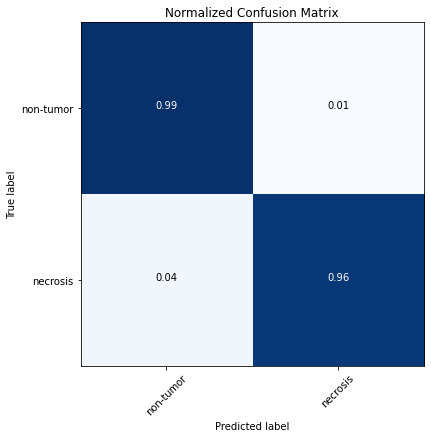

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbfgs**

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.966
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.00011249114262615064



              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           1       0.98      0.91      0.95        47

    accuracy                           0.97       149
   macro avg       0.97      0.95      0.96       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.99      	   0.915   
  1       0.977     	      0.915      	    0.99   





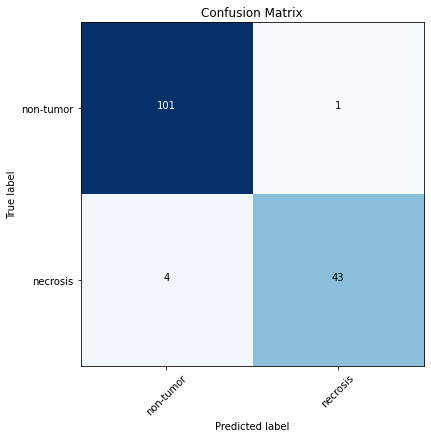

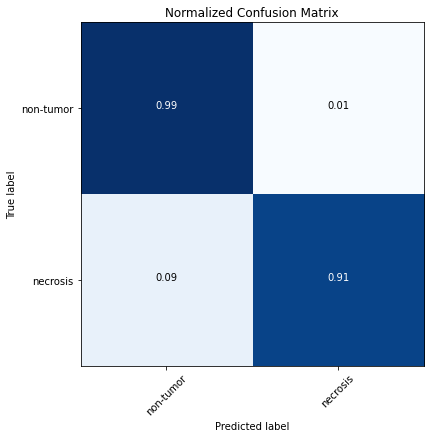

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 400

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 400, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 400)
After applying Mututal information gain, shape for test data:  (149, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.973
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.0038079614994119574


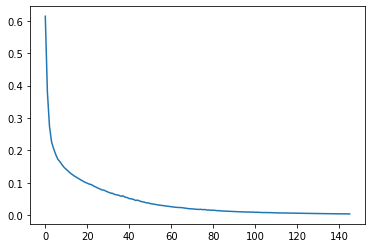




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.96      0.96      0.96        47

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.98     	       0.98      	   0.957   
  1       0.957     	      0.957      	    0.98   





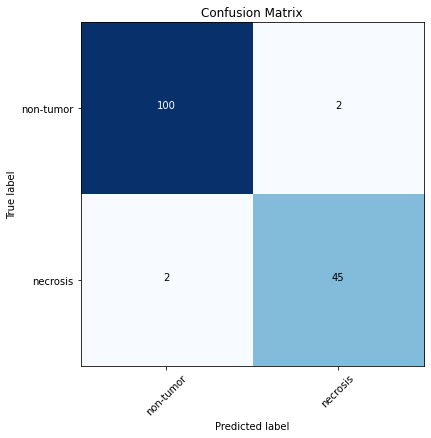

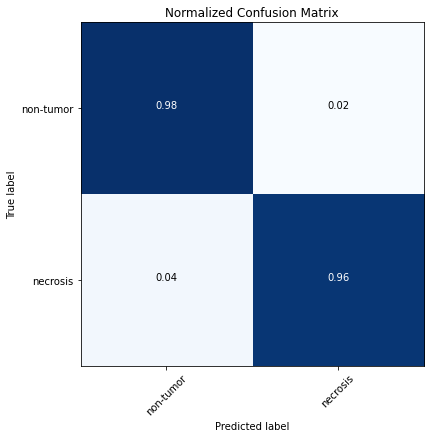

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.94
Accuracy on test data is:  0.98
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.07531378046767756


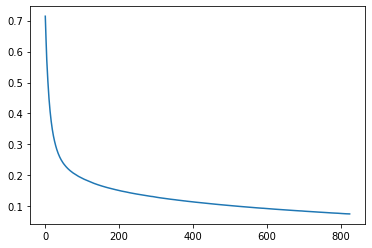




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





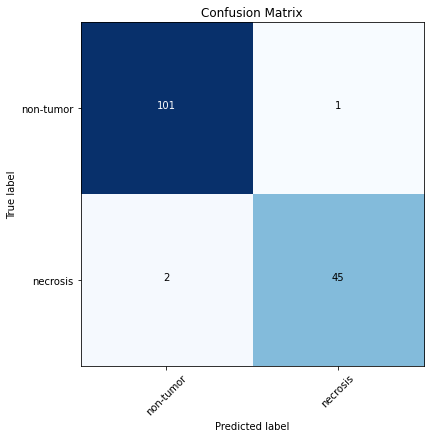

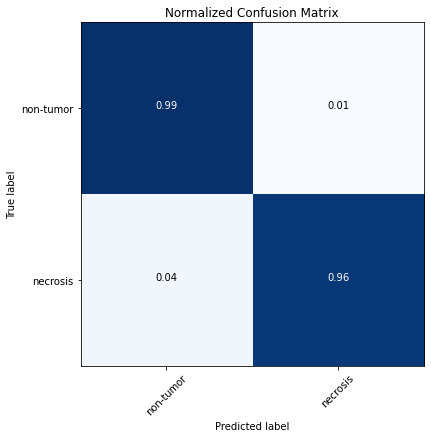

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbfgs**

k-fold validation accuracy for k=5 is:  0.915
Accuracy on test data is:  0.973
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  8.007463830698244e-05



              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.96      0.96      0.96        47

    accuracy                           0.97       149
   macro avg       0.97      0.97      0.97       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.98     	       0.98      	   0.957   
  1       0.957     	      0.957      	    0.98   





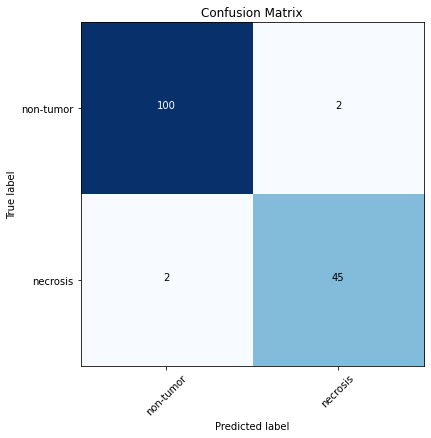

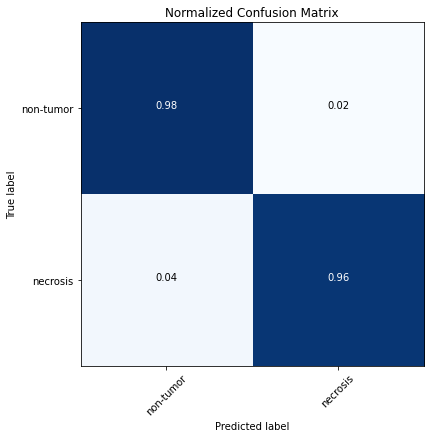

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 400, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 400)
After applying Mututal information gain, shape for test data:  (149, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.926
Accuracy on test data is:  0.973
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.938
Loss value:  0.003824394549672837


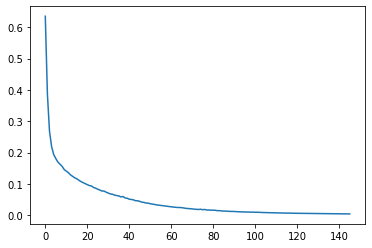




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           1       0.98      0.94      0.96        47

    accuracy                           0.97       149
   macro avg       0.97      0.96      0.97       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.936   
  1       0.978     	      0.936      	    0.99   





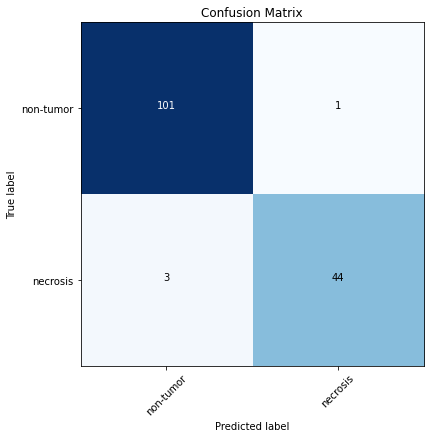

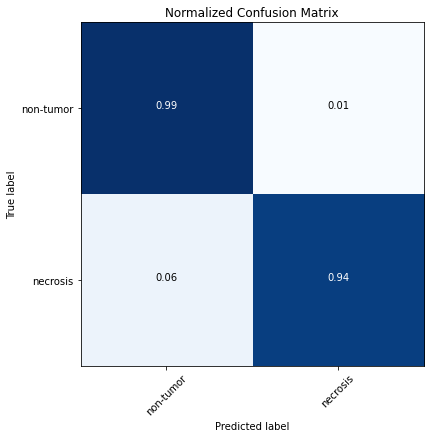

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.935
Accuracy on test data is:  0.98
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.07867826176667997


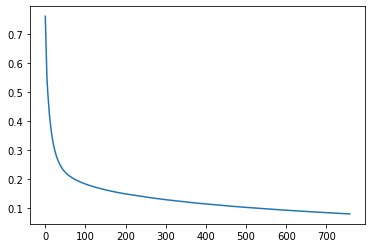




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





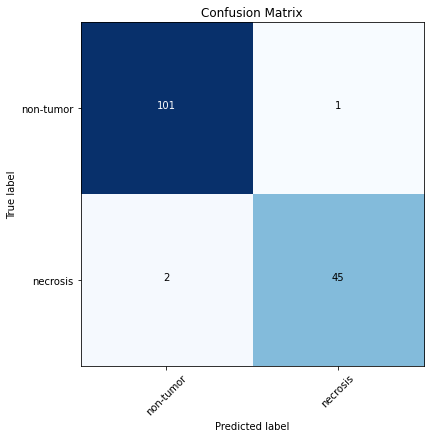

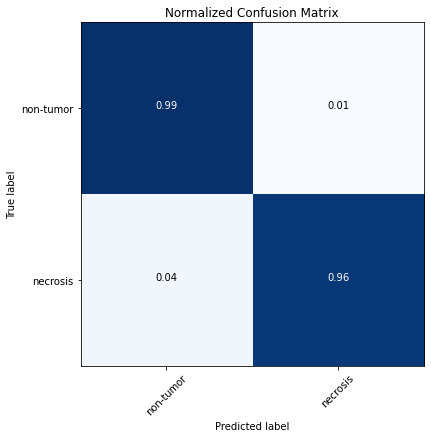

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.966
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.0001411643957501197



              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           1       0.96      0.94      0.95        47

    accuracy                           0.97       149
   macro avg       0.96      0.96      0.96       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.936   
  1       0.957     	      0.936      	    0.98   





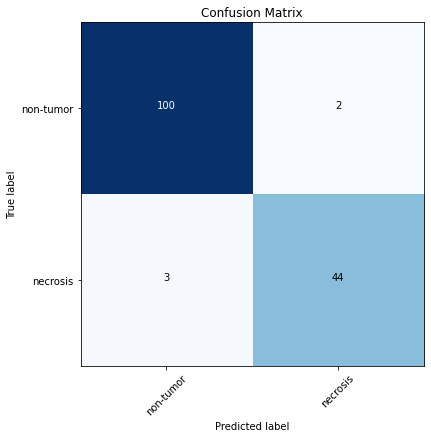

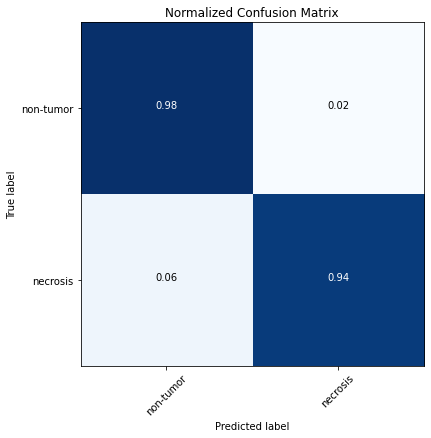

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 500

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 500, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 500)
After applying Mututal information gain, shape for test data:  (149, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.926
Accuracy on test data is:  0.98
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.002893030913434918


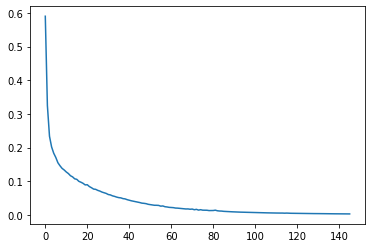




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





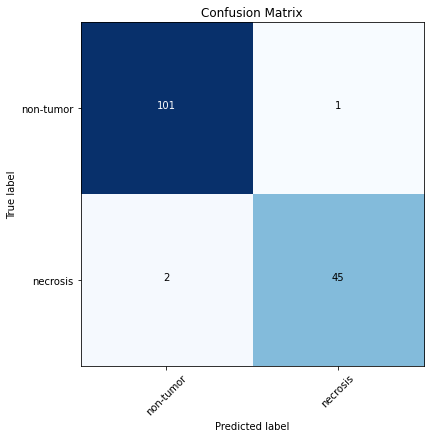

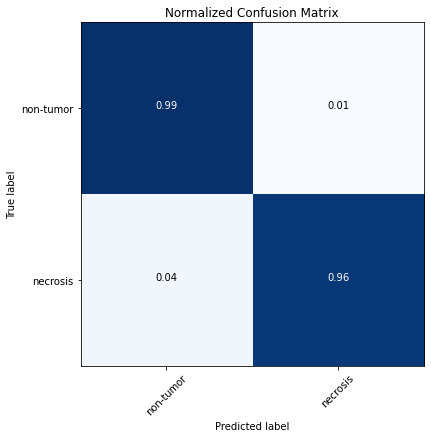

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.98
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.07230607059502688


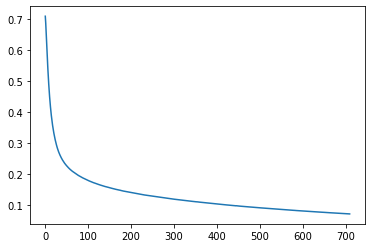




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





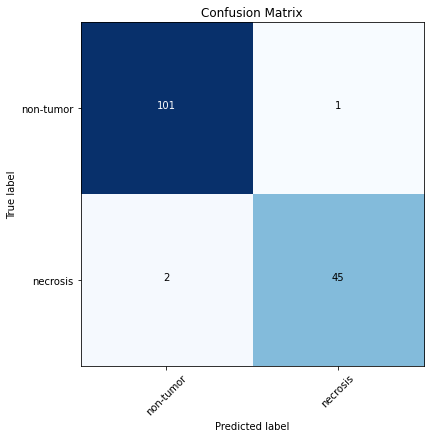

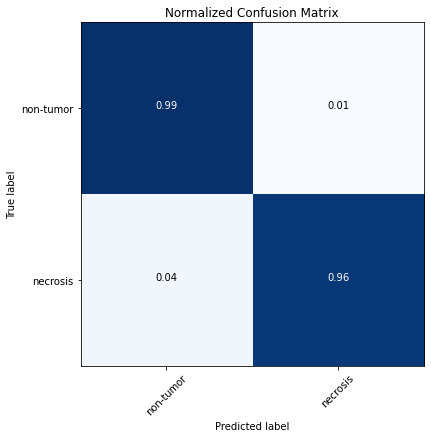

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbfgs**

k-fold validation accuracy for k=5 is:  0.918
Accuracy on test data is:  0.96
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.906
Loss value:  6.888598206871444e-05



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           1       0.96      0.91      0.93        47

    accuracy                           0.96       149
   macro avg       0.96      0.95      0.95       149
weighted avg       0.96      0.96      0.96       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.915   
  1       0.956     	      0.915      	    0.98   





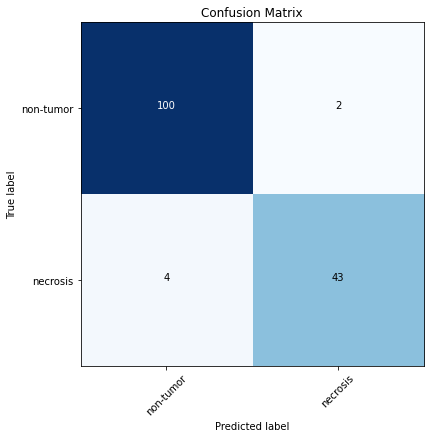

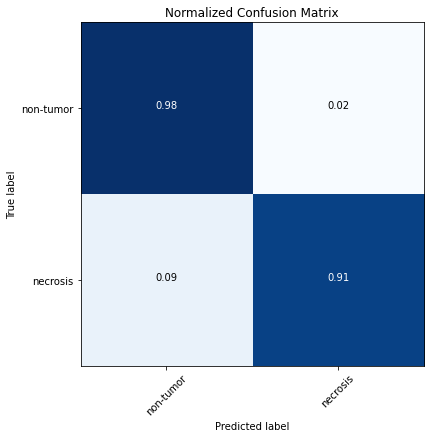

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 500, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 500)
After applying Mututal information gain, shape for test data:  (149, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.98
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.0025361786880880506


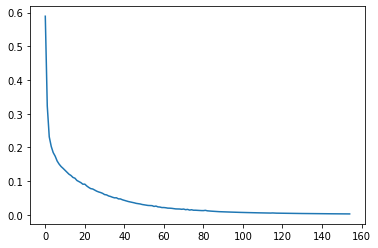




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





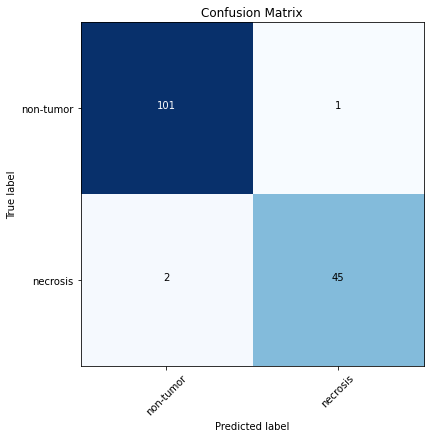

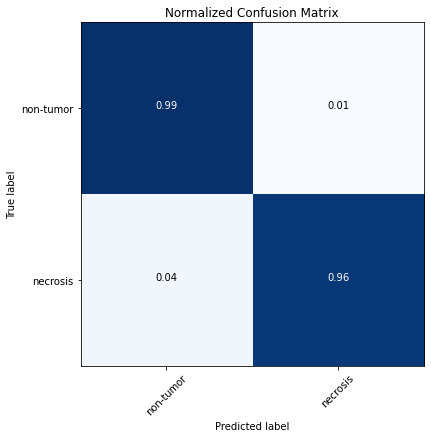

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.937
Accuracy on test data is:  0.987
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.969
Loss value:  0.0629649224324798


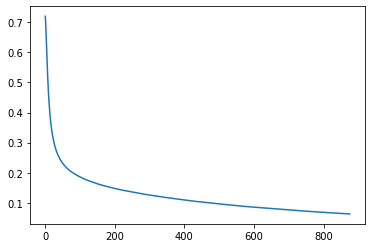




              precision    recall  f1-score   support

           0       0.98      1.00      0.99       102
           1       1.00      0.96      0.98        47

    accuracy                           0.99       149
   macro avg       0.99      0.98      0.98       149
weighted avg       0.99      0.99      0.99       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       1.0       	   0.957   
  1        1.0      	      0.957      	    1.0    





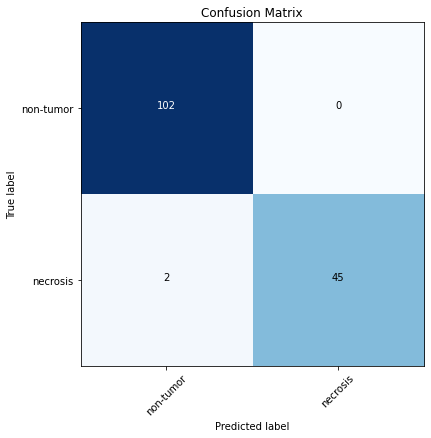

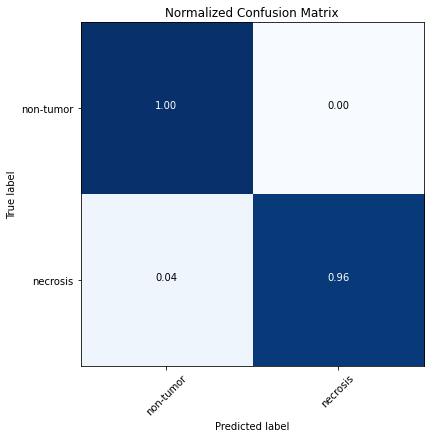

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbfgs**

k-fold validation accuracy for k=5 is:  0.923
Accuracy on test data is:  0.966
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  8.289381513023345e-05



              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           1       0.96      0.94      0.95        47

    accuracy                           0.97       149
   macro avg       0.96      0.96      0.96       149
weighted avg       0.97      0.97      0.97       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.936   
  1       0.957     	      0.936      	    0.98   





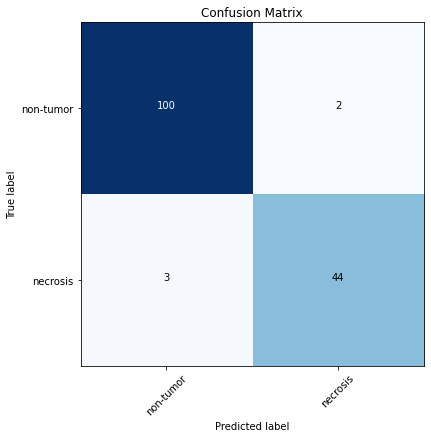

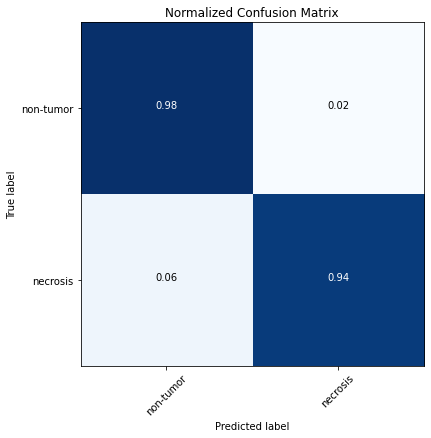

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 600

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 600, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 600)
After applying Mututal information gain, shape for test data:  (149, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.98
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.0027143872101415252


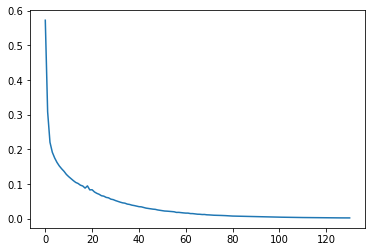




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





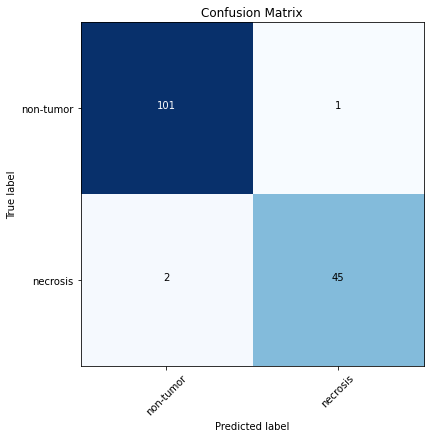

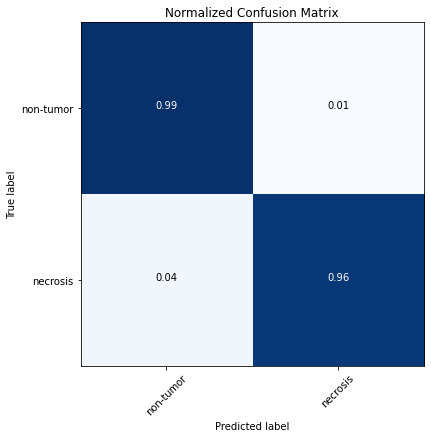

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.987
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.969
Loss value:  0.06440987859721112


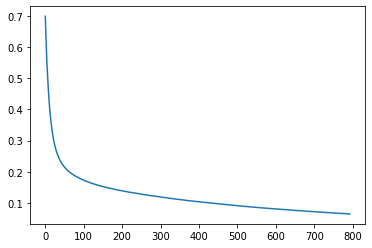




              precision    recall  f1-score   support

           0       0.98      1.00      0.99       102
           1       1.00      0.96      0.98        47

    accuracy                           0.99       149
   macro avg       0.99      0.98      0.98       149
weighted avg       0.99      0.99      0.99       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       1.0       	   0.957   
  1        1.0      	      0.957      	    1.0    





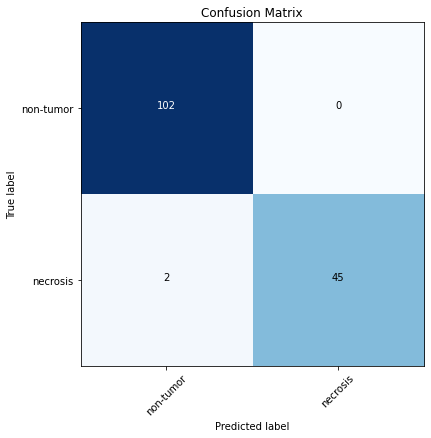

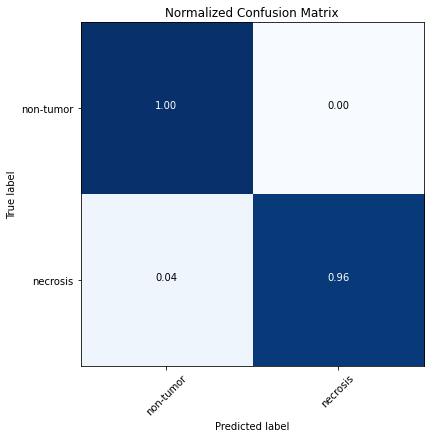

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.917
Accuracy on test data is:  0.96
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.906
Loss value:  6.0834388460761165e-05



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           1       0.96      0.91      0.93        47

    accuracy                           0.96       149
   macro avg       0.96      0.95      0.95       149
weighted avg       0.96      0.96      0.96       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.915   
  1       0.956     	      0.915      	    0.98   





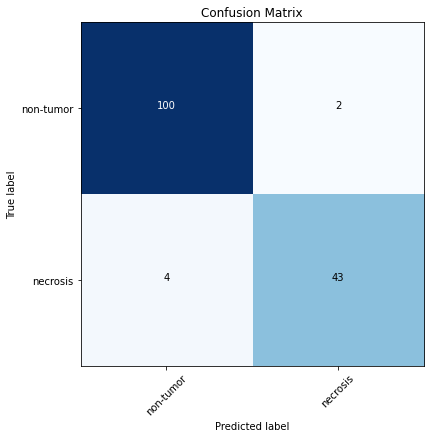

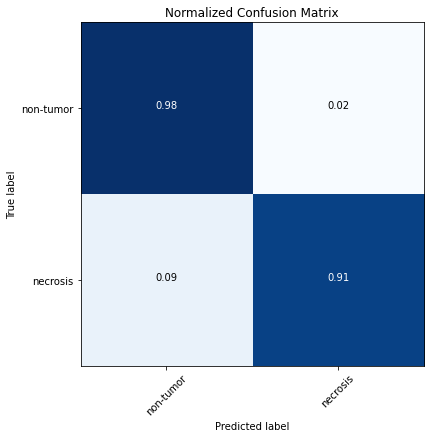

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 600, X_train= train_x_b2, y_train= train_y_b2 ,X_test= test_x_b2) 

After applying mutual information gain, shape for train data:  (650, 600)
After applying Mututal information gain, shape for test data:  (149, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.928
Accuracy on test data is:  0.98
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.0031223893097263545


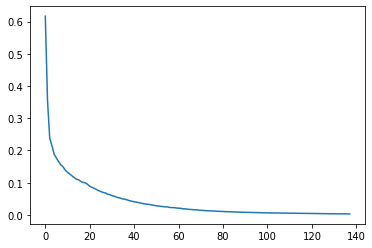




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





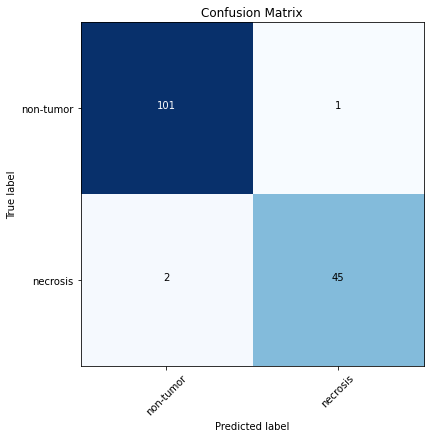

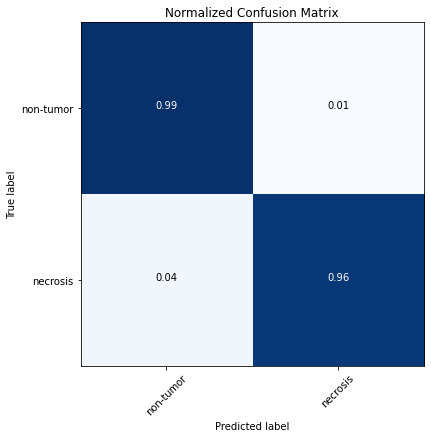

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.98
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.953
Loss value:  0.06164707703049731


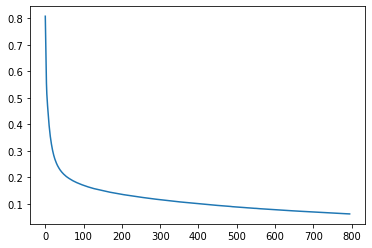




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           1       0.98      0.96      0.97        47

    accuracy                           0.98       149
   macro avg       0.98      0.97      0.98       149
weighted avg       0.98      0.98      0.98       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.957   
  1       0.978     	      0.957      	    0.99   





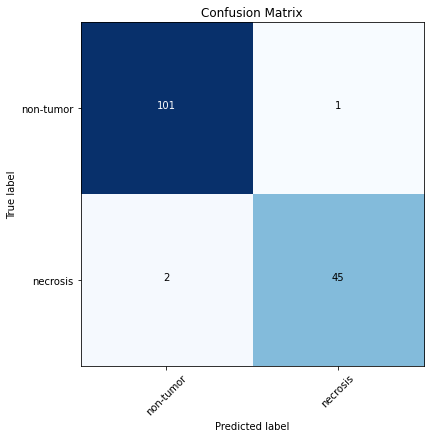

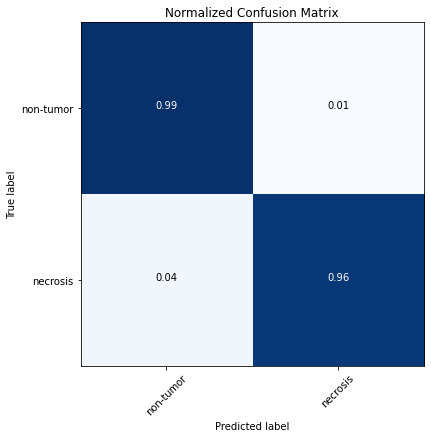

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.918
Accuracy on test data is:  0.946
ROC-AUC score is:  0.975
The Matthews correlation coefficinet (MCC) is:  0.875
Loss value:  0.0001246141360346633



              precision    recall  f1-score   support

           0       0.95      0.97      0.96       102
           1       0.93      0.89      0.91        47

    accuracy                           0.95       149
   macro avg       0.94      0.93      0.94       149
weighted avg       0.95      0.95      0.95       149




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.952     	      0.971      	   0.894   
  1       0.933     	      0.894      	   0.971   





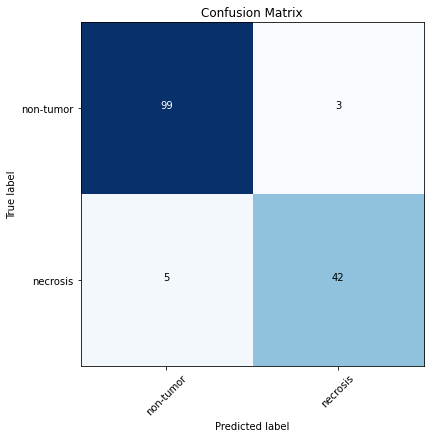

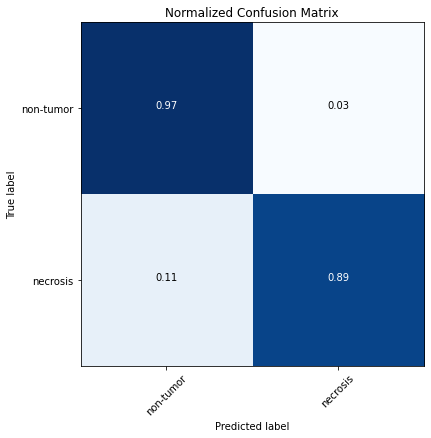

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 700

##### gini

##### entropy

#### 800

##### gini

#### 900

##### gini

##### entropy

# saving non-tumor VS viable tumor features and experiment

In [ ]:
# combinig dataset for train set 
train_x_b3 = np.concatenate((non_tumor_train, viable_tumor_train), axis=0)
train_y_b3 = np.concatenate((non_tumor_train_l, viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x_b3.shape)
print('Train labels shape: ',train_y_b3.shape)

# combinig dataset for test set 
test_x_b3 = np.concatenate((non_tumor_test, viable_tumor_test), axis=0)
test_y_b3 = np.concatenate((non_tumor_test_l, viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x_b3.shape)
print('Test labels shape: ',test_y_b3.shape)

Train set shape:  (701, 1024)
Train labels shape:  (701,)
Test set shape:  (181, 1024)
Test labels shape:  (181,)


**train data save**

In [ ]:
# train features 
df_train_b3 = pd.DataFrame(train_x_b3)
df_train_b3 = df_train_b3.assign(labels= train_y_b3)
# df_train_b2.head()

# saving csv to local machine
df_train_b3.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_non-tumor_vs_viable_train_features.csv', index=False)

df_train_b3.head()

0         1         2         3         4         5         6  \
0  0.209715 -0.526830 -0.175791  0.856019  0.670245  0.067937 -0.006268   
1  0.124291 -0.516310  0.064597  0.647671  0.003237  0.059670  0.103043   
2  0.094721 -0.470915 -0.073476  0.339083  0.146492  0.490193 -0.058501   
3 -0.158242 -0.310502  0.406067  0.651356  0.903234  0.598363 -0.380046   
4  0.132417 -0.409493 -0.125214  0.929150  0.417272 -0.360470 -0.412574   

          7         8         9  ...      1015      1016      1017      1018  \
0 -0.359899  0.027365  0.185339  ...  0.358999 -0.248527  0.097275  0.120164   
1 -0.256462 -0.351375 -0.054102  ... -0.129597 -0.042790 -0.318924 -0.000465   
2 -0.256170 -0.038569  0.350152  ...  0.139917 -0.258650  0.069644  0.192570   
3  0.528742  0.461066  0.331614  ...  0.056322 -0.744555  0.064448  0.289311   
4  0.041672  0.047039  0.309399  ... -0.195942 -0.365056 -0.356286  0.018671   

       1019      1020      1021      1022      1023  labels  
0  0.682499  0.308895  0.022966  0.467152 -0.361063       0  
1  0.360453  0.374753 -0.436665  0.584223 -0.241561       0  
2  0.524029  0.100356 -0.436910  0.355013 -0.073992       0  
3  0.359039 -0.017468 -0.515261  0.209944  0.178076       0  
4  0.713719  0.664111 -0.631234  0.255543 -0.270770       0  

[5 rows x 1025 columns]

In [ ]:
df_train_b3.shape[0]

701

**test data**

In [ ]:
# train features 
df_test_b3 = pd.DataFrame(test_x_b3)
df_test_b3 = df_test_b3.assign(labels= test_y_b3)
# df_train_b2.head()

# saving csv to local machine
df_test_b3.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_non-tumor_vs_viable_test_features.csv', index=False)

df_test_b3.head()

0         1         2         3         4         5         6  \
0 -0.092870 -0.084168  0.330710  0.236360  0.465948 -0.010828 -0.311789   
1 -0.674828 -0.599340 -0.067704  0.338190  0.161329 -0.104761 -0.205920   
2 -0.471278 -0.374827  0.606167  0.538498 -0.098080  0.241178 -0.090419   
3  0.000707 -0.390055 -0.008262  0.864527  0.865247 -0.047271  0.097709   
4 -0.177747 -0.439394  0.541522  0.842829  0.570381  0.013219 -0.247999   

          7         8         9  ...      1015      1016      1017      1018  \
0 -0.179136  0.366699  0.057734  ...  0.264598 -0.475756 -0.250332  0.259860   
1  0.794936 -0.044862  0.252627  ...  0.481522 -0.346930 -0.135490  0.414682   
2 -0.322303 -0.502501  0.554042  ...  0.577489 -0.505745 -0.400035 -0.172693   
3 -0.127144 -0.580391  0.250674  ... -0.238945 -0.262232 -0.255019  0.689359   
4  0.210093 -0.309185  0.482433  ...  0.237291 -0.159117 -0.239266  0.694609   

       1019      1020      1021      1022      1023  labels  
0  0.592601  0.280608 -0.204659  0.370876  0.131930       0  
1  0.851681  0.567893 -0.235248 -0.096678  0.292946       0  
2  0.272088  0.358482 -0.412307  0.337186  0.600965       0  
3  0.887627  0.303557 -0.897440 -0.157156 -0.276417       0  
4  0.383207  0.058542 -0.417250  0.316892  0.313333       0  

[5 rows x 1025 columns]

In [ ]:
# with feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
# mlp_classifier.fit(X_train_b2, train_y_b2)
mlp_classifier.fit(train_x_b3, train_y_b3)

# getting k-fold validation accuracy, we are taking k= 5 folds
# k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)
k_fold_acc = cross_val_score(mlp_classifier, train_x_b3, train_y_b3, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
# mlp_pred = mlp_classifier.predict(X_test_b2)
mlp_pred = mlp_classifier.predict(test_x_b3)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b3, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
# lr_probs = mlp_classifier.predict_proba(X_test_b2)
lr_probs = mlp_classifier.predict_proba(test_x_b3)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
roc_auc = roc_auc_score(test_y_b3, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b3, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.966
Accuracy on test data is:  0.961
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.922


#### 100

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 100, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 100)
After applying Mututal information gain, shape for test data:  (181, 100)


In [ ]:
def get_final_result(opt_name, num_iter, classes):
  
  # getting predicted outputs
  if opt_name == "lbfgs":
    pred = mlp_class_wo_plot(optimizer_name= opt_name, num_iteration=num_iter, train_data=train_x, test_data= test_x, y_train= train_y_b3, y_test=test_y_b3)
  else:
    pred = mlp_class_plot(optimizer_name= opt_name, num_iteration=num_iter, train_data= train_x, test_data= test_x, y_train= train_y_b3, y_test=test_y_b3)

  # perfomance metrices
  print()
  print()
  print()

  # getting classsification reports
  get_reports(test_y_b3, pred)
  print("\n\n")

  # getting sensitivity and specificity
  get_sn_sp(test_y_b3, pred)
  print("\n\n")

  # getting unnormalized and normalized confusion matrix
  conf_mat(classes, test_y_b3, pred)

**adam**

k-fold validation accuracy for k=5 is:  0.957
Accuracy on test data is:  0.956
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.911
Loss value:  0.005593054878417736


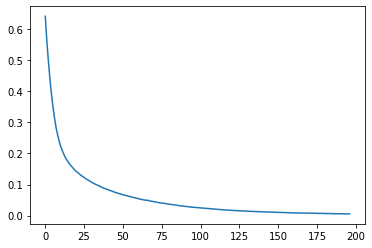




              precision    recall  f1-score   support

           0       0.94      0.98      0.96       102
           2       0.97      0.92      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.95      0.95       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.943     	       0.98      	   0.924   
  1       0.973     	      0.924      	    0.98   





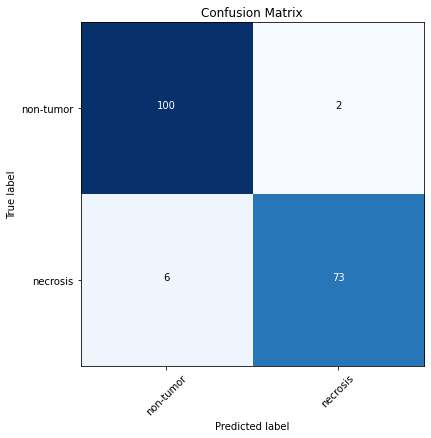

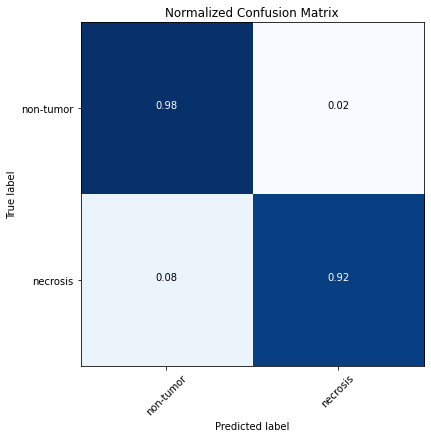

In [ ]:
classess = ['non-tumor', 'viable']
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.943
Accuracy on test data is:  0.945
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.89
Loss value:  0.11549639285165562


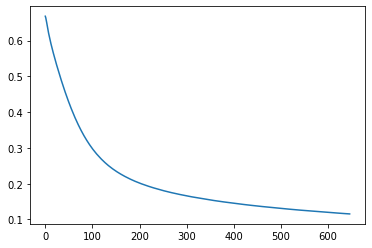




              precision    recall  f1-score   support

           0       0.92      0.99      0.95       102
           2       0.99      0.89      0.93        79

    accuracy                           0.94       181
   macro avg       0.95      0.94      0.94       181
weighted avg       0.95      0.94      0.94       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.918     	       0.99      	   0.886   
  1       0.986     	      0.886      	    0.99   





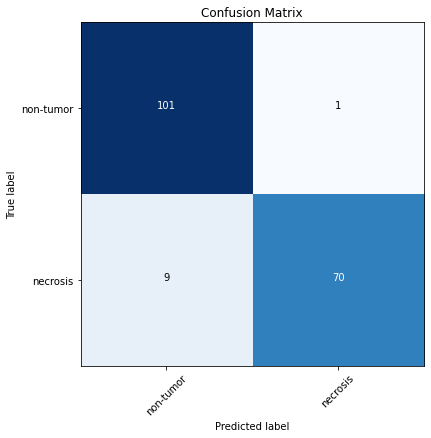

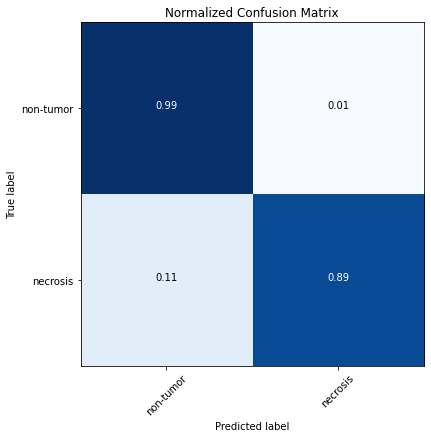

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbfgs**

k-fold validation accuracy for k=5 is:  0.943
Accuracy on test data is:  0.961
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.00019091583751666995



              precision    recall  f1-score   support

           0       0.95      0.98      0.97       102
           2       0.97      0.94      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.96      0.96       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.952     	       0.98      	   0.937   
  1       0.974     	      0.937      	    0.98   





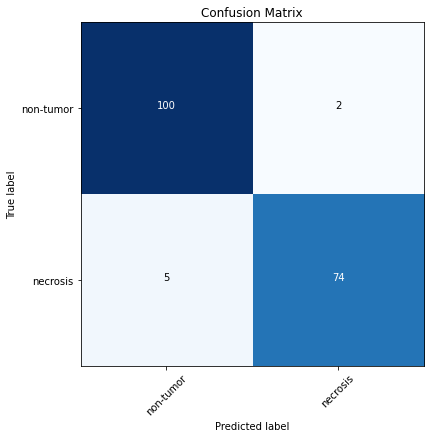

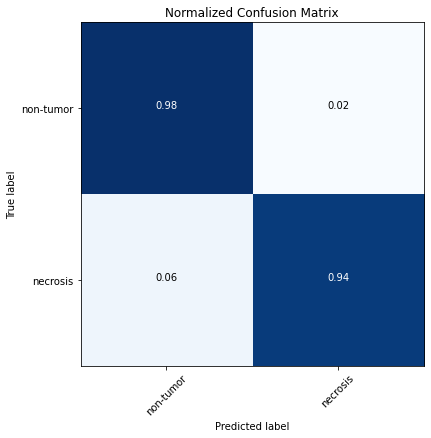

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 100, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 100)
After applying Mututal information gain, shape for test data:  (181, 100)


**adam**

k-fold validation accuracy for k=5 is:  0.953
Accuracy on test data is:  0.956
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.911
Loss value:  0.00629659405658944


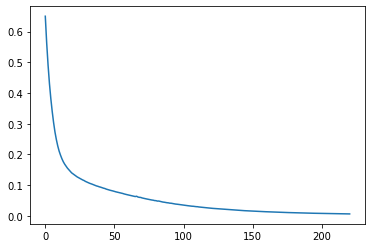




              precision    recall  f1-score   support

           0       0.94      0.98      0.96       102
           2       0.97      0.92      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.95      0.95       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.943     	       0.98      	   0.924   
  1       0.973     	      0.924      	    0.98   





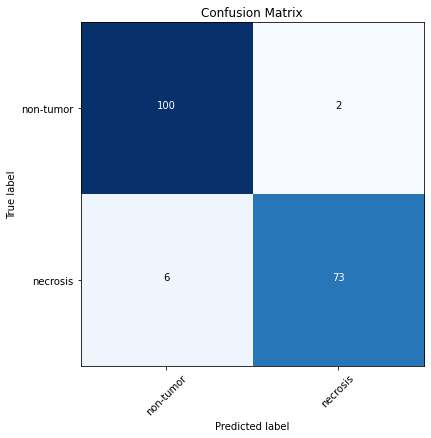

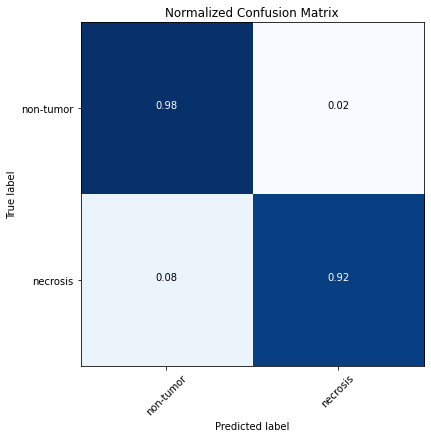

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.972
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.11779753033602446


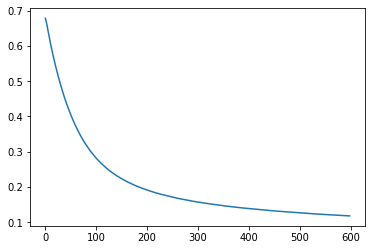




              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           2       0.99      0.95      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.99      	   0.949   
  1       0.987     	      0.949      	    0.99   





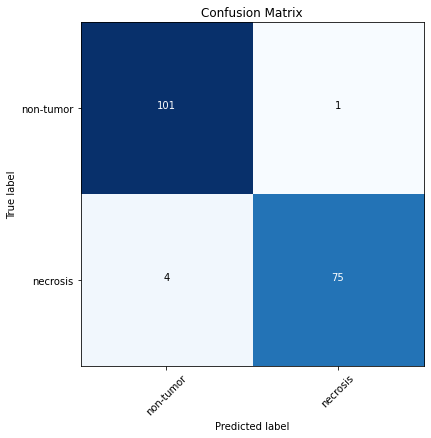

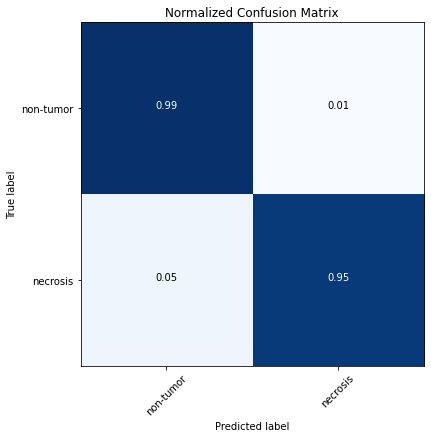

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.953
Accuracy on test data is:  0.928
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.854
Loss value:  0.0001278636707339476



              precision    recall  f1-score   support

           0       0.93      0.94      0.94       102
           2       0.92      0.91      0.92        79

    accuracy                           0.93       181
   macro avg       0.93      0.93      0.93       181
weighted avg       0.93      0.93      0.93       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.932     	      0.941      	   0.911   
  1       0.923     	      0.911      	   0.941   





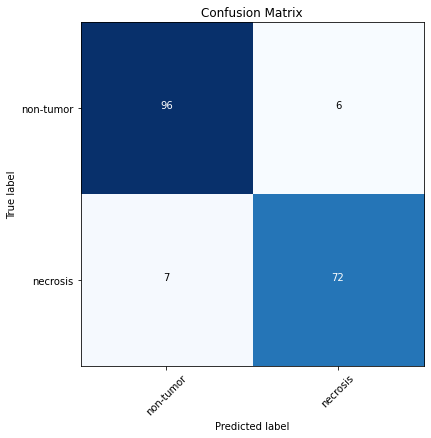

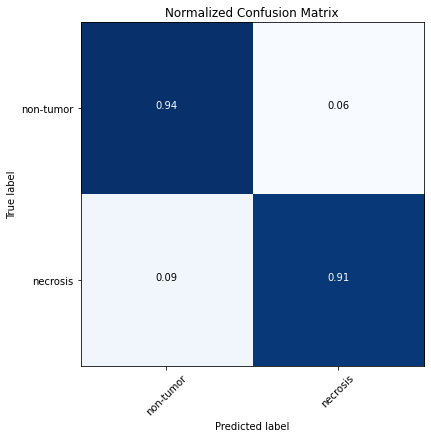

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 200

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 200, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 200)
After applying Mututal information gain, shape for test data:  (181, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.959
Accuracy on test data is:  0.972
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.0036366672350440043


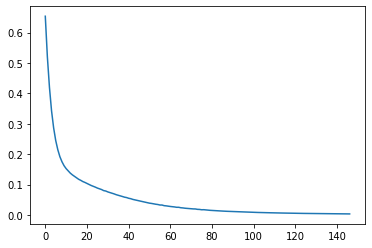




              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           2       0.99      0.95      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.99      	   0.949   
  1       0.987     	      0.949      	    0.99   





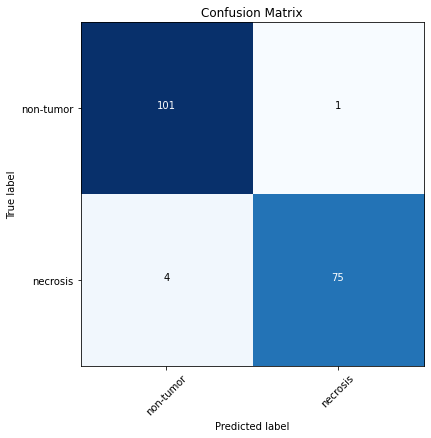

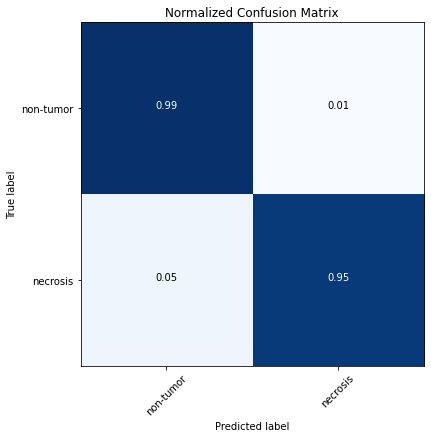

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.956
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.911
Loss value:  0.09280697831983548


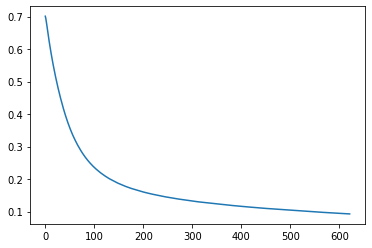




              precision    recall  f1-score   support

           0       0.94      0.99      0.96       102
           2       0.99      0.91      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.95      0.95       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.935     	       0.99      	   0.911   
  1       0.986     	      0.911      	    0.99   





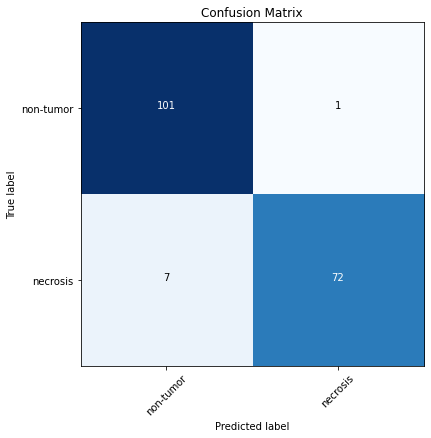

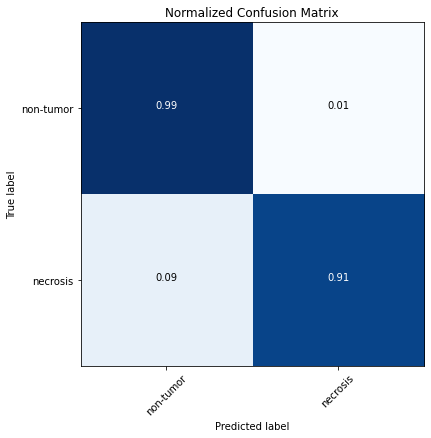

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.93
Accuracy on test data is:  0.945
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.888
Loss value:  8.09450535137975e-05



              precision    recall  f1-score   support

           0       0.95      0.95      0.95       102
           2       0.94      0.94      0.94        79

    accuracy                           0.94       181
   macro avg       0.94      0.94      0.94       181
weighted avg       0.94      0.94      0.94       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.951     	      0.951      	   0.937   
  1       0.937     	      0.937      	   0.951   





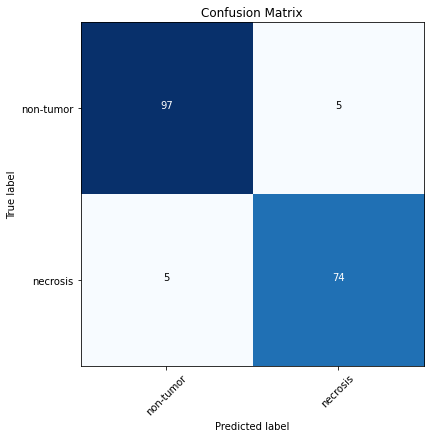

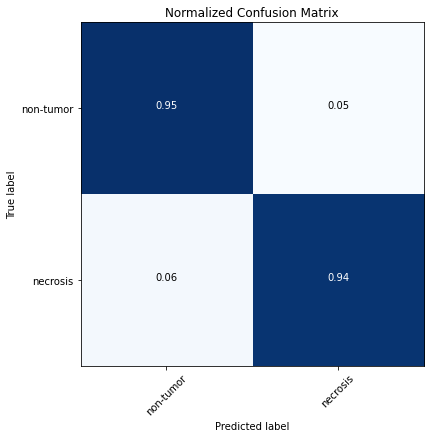

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 200, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 200)
After applying Mututal information gain, shape for test data:  (181, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.962
Accuracy on test data is:  0.967
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.00416486876845041


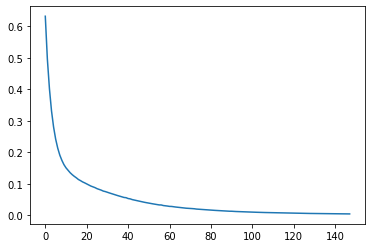




              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           2       0.97      0.95      0.96        79

    accuracy                           0.97       181
   macro avg       0.97      0.96      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.949   
  1       0.974     	      0.949      	    0.98   





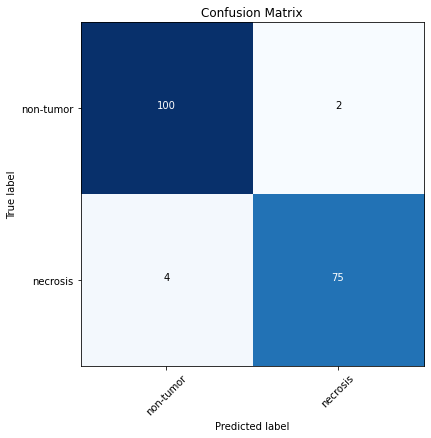

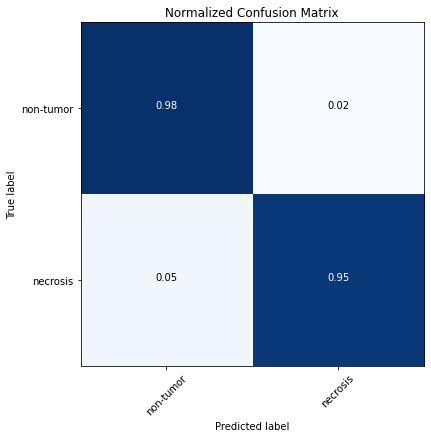

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.949
Accuracy on test data is:  0.978
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.09284777659143419


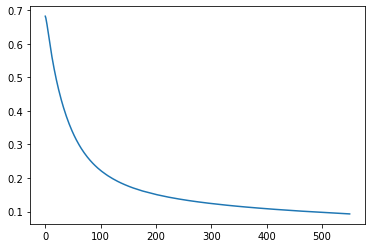




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





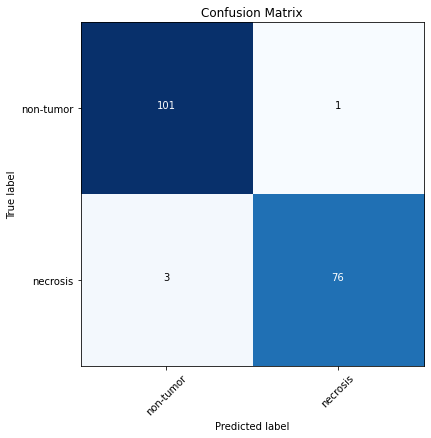

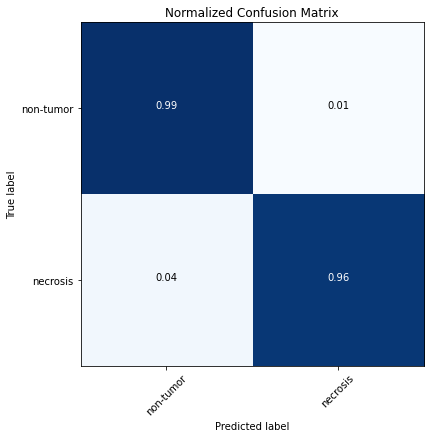

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.945
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.888
Loss value:  0.00020666259095934524



              precision    recall  f1-score   support

           0       0.94      0.96      0.95       102
           2       0.95      0.92      0.94        79

    accuracy                           0.94       181
   macro avg       0.95      0.94      0.94       181
weighted avg       0.94      0.94      0.94       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.942     	      0.961      	   0.924   
  1       0.948     	      0.924      	   0.961   





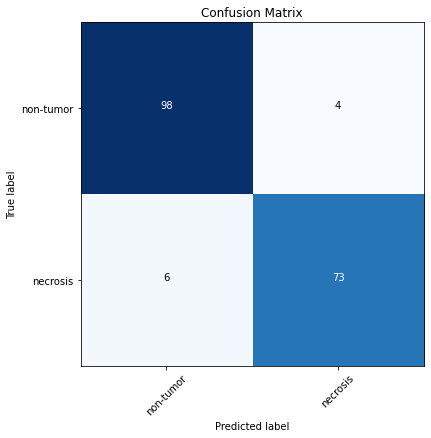

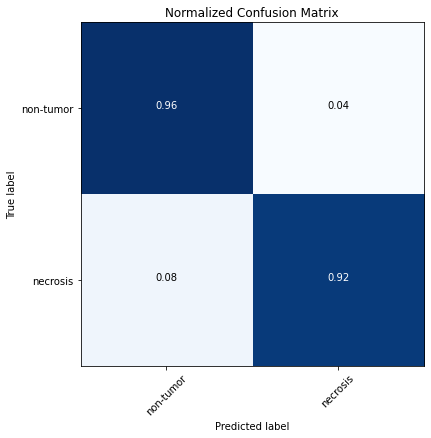

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 300

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 300, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 300)
After applying Mututal information gain, shape for test data:  (181, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.957
Accuracy on test data is:  0.972
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.003293852463246979


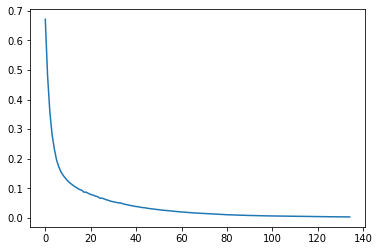




              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           2       0.99      0.95      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.99      	   0.949   
  1       0.987     	      0.949      	    0.99   





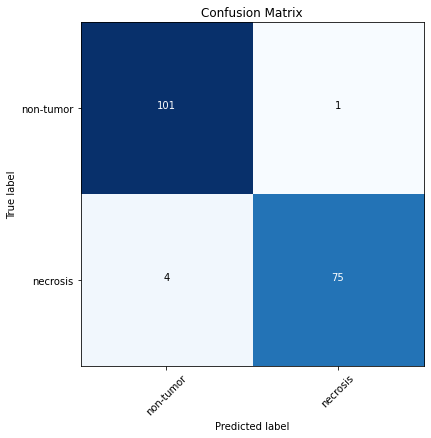

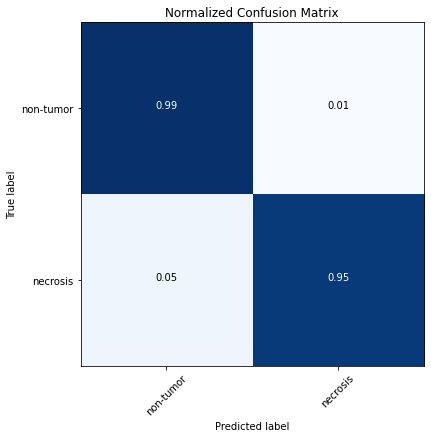

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.967
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.07562271210587461


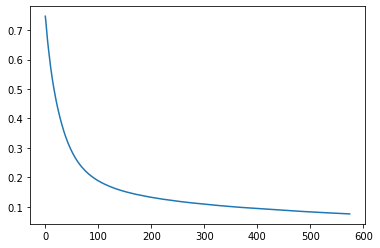




              precision    recall  f1-score   support

           0       0.95      0.99      0.97       102
           2       0.99      0.94      0.96        79

    accuracy                           0.97       181
   macro avg       0.97      0.96      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.953     	       0.99      	   0.937   
  1       0.987     	      0.937      	    0.99   





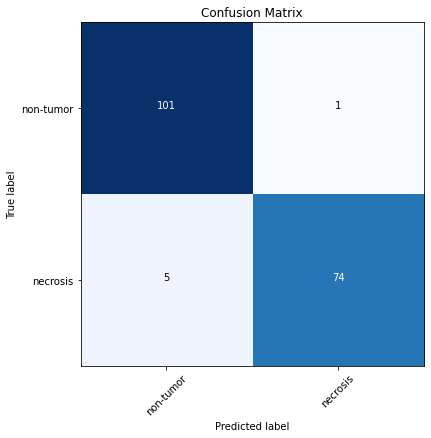

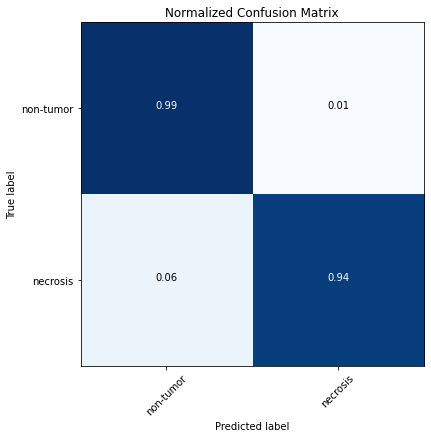

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.967
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.00010311800576068317



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           2       0.97      0.95      0.96        79

    accuracy                           0.97       181
   macro avg       0.97      0.96      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.949   
  1       0.974     	      0.949      	    0.98   





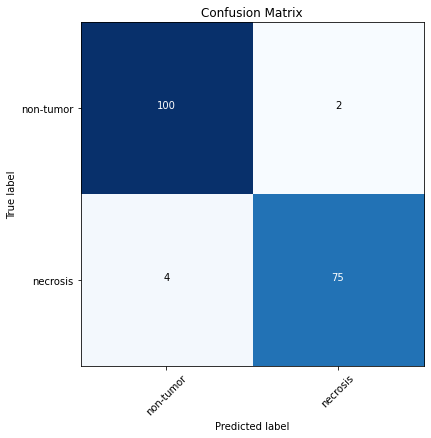

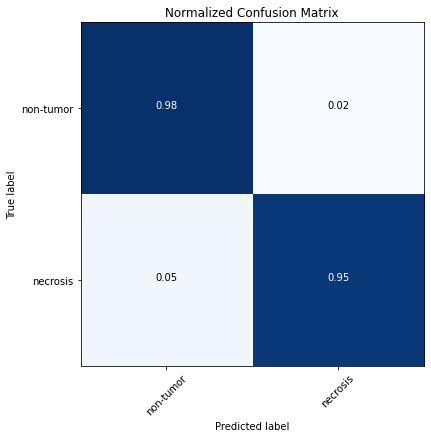

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 300, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 300)
After applying Mututal information gain, shape for test data:  (181, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.957
Accuracy on test data is:  0.989
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.978
Loss value:  0.003866831724748698


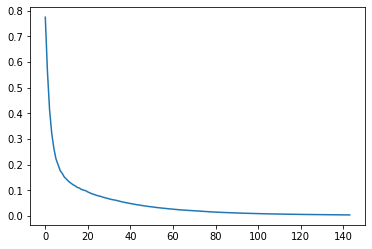




              precision    recall  f1-score   support

           0       0.99      0.99      0.99       102
           2       0.99      0.99      0.99        79

    accuracy                           0.99       181
   macro avg       0.99      0.99      0.99       181
weighted avg       0.99      0.99      0.99       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.99     	       0.99      	   0.987   
  1       0.987     	      0.987      	    0.99   





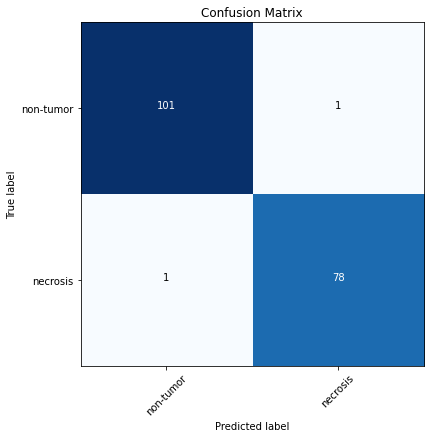

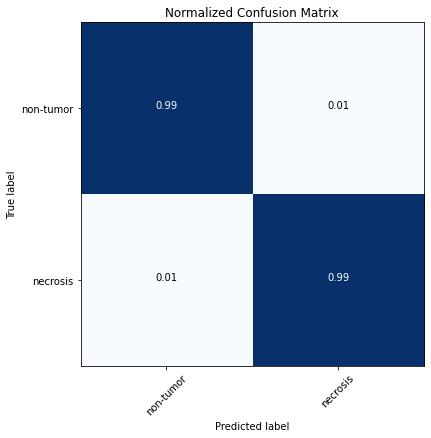

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.953
Accuracy on test data is:  0.972
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.07272963842572769


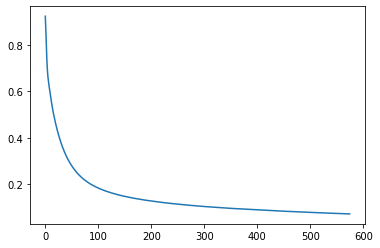




              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           2       0.99      0.95      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.99      	   0.949   
  1       0.987     	      0.949      	    0.99   





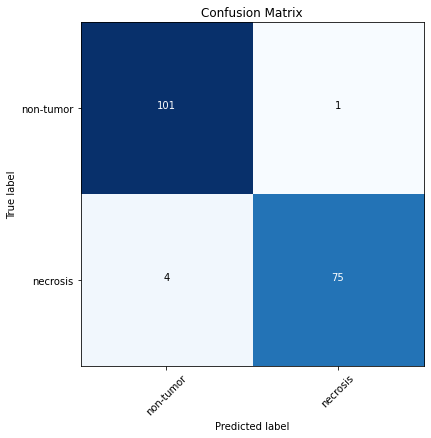

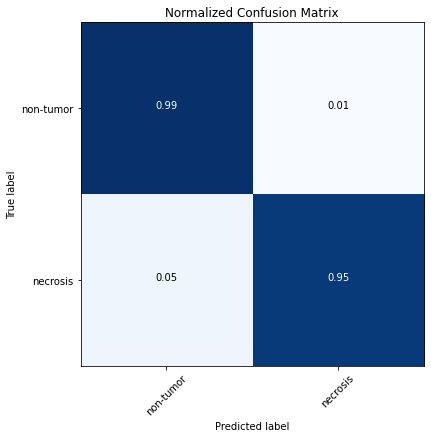

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.947
Accuracy on test data is:  0.967
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  9.204725702725763e-05



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           2       0.97      0.95      0.96        79

    accuracy                           0.97       181
   macro avg       0.97      0.96      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.949   
  1       0.974     	      0.949      	    0.98   





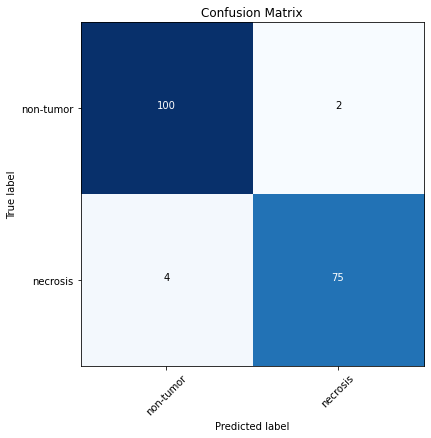

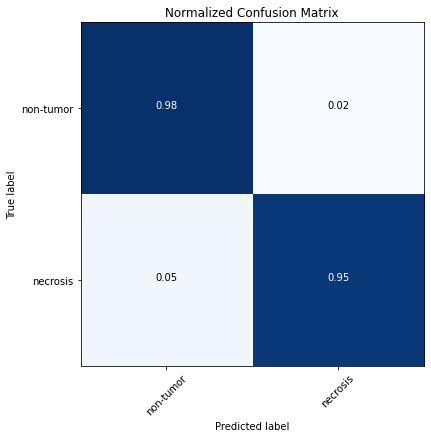

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 400

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 400, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 400)
After applying Mututal information gain, shape for test data:  (181, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.964
Accuracy on test data is:  0.978
ROC-AUC score is:  1.0
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.0030514575362047863


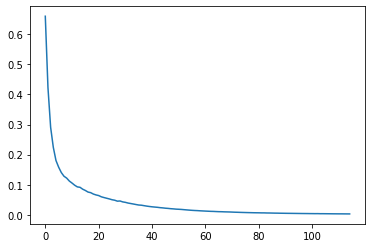




              precision    recall  f1-score   support

           0       0.96      1.00      0.98       102
           2       1.00      0.95      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.97      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       1.0       	   0.949   
  1        1.0      	      0.949      	    1.0    





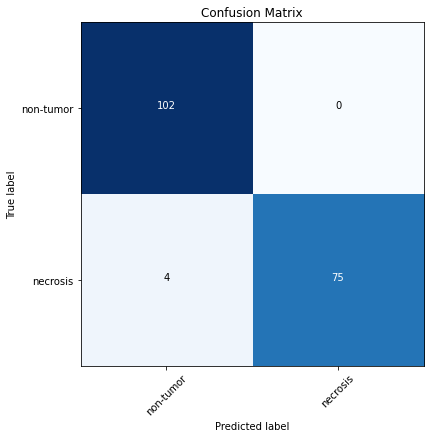

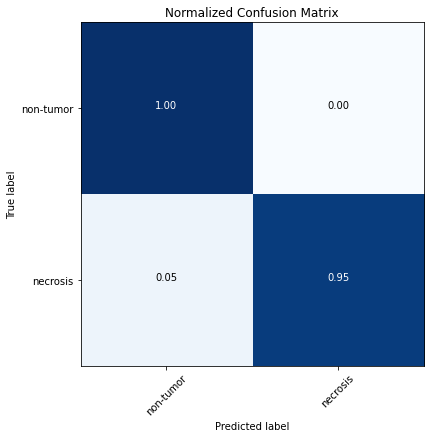

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.951
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.05700207653965993


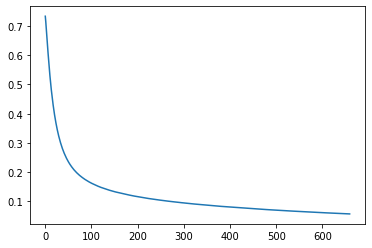




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





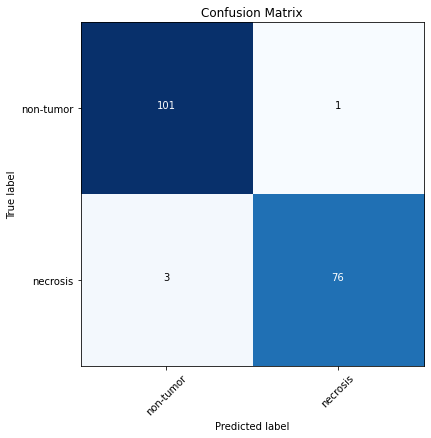

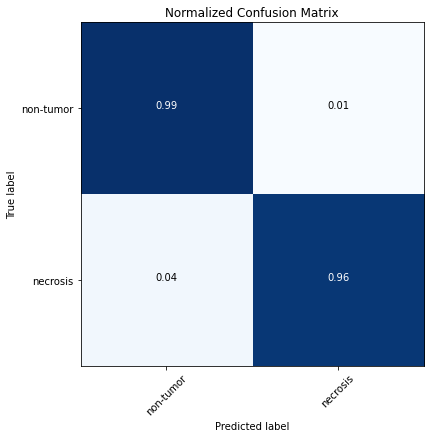

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.947
Accuracy on test data is:  0.956
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.911
Loss value:  8.495402545002952e-05



              precision    recall  f1-score   support

           0       0.94      0.98      0.96       102
           2       0.97      0.92      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.95      0.95       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.943     	       0.98      	   0.924   
  1       0.973     	      0.924      	    0.98   





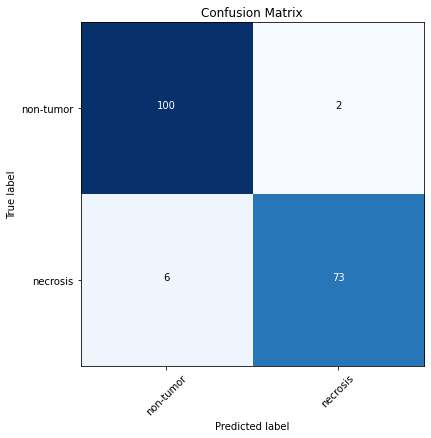

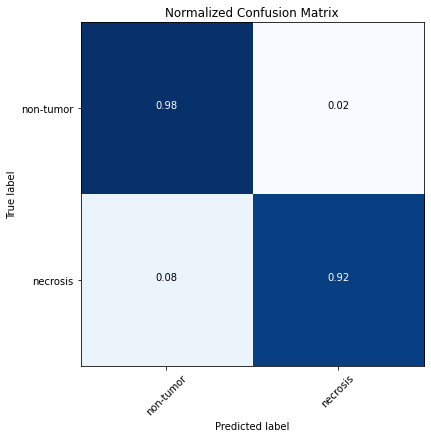

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 400, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 400)
After applying Mututal information gain, shape for test data:  (181, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.96
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.0026195324047024343


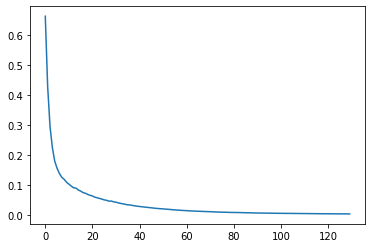




              precision    recall  f1-score   support

           0       0.96      1.00      0.98       102
           2       1.00      0.95      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.97      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       1.0       	   0.949   
  1        1.0      	      0.949      	    1.0    





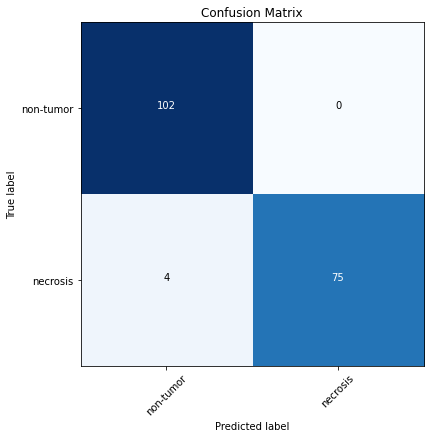

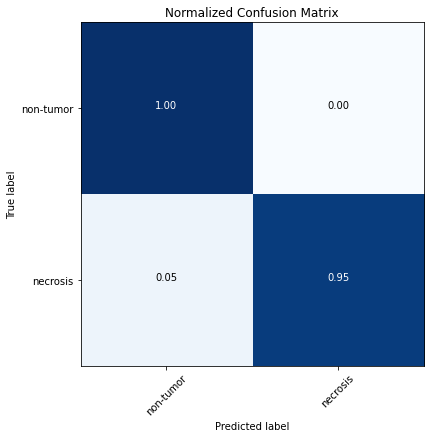

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.983
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.966
Loss value:  0.06161313959715868


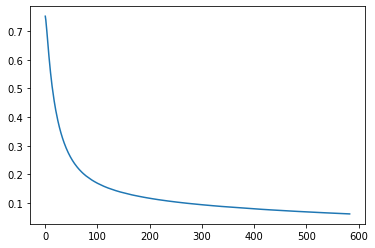




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           2       0.99      0.97      0.98        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.975   
  1       0.987     	      0.975      	    0.99   





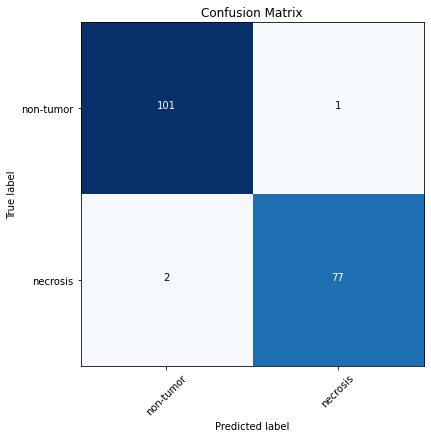

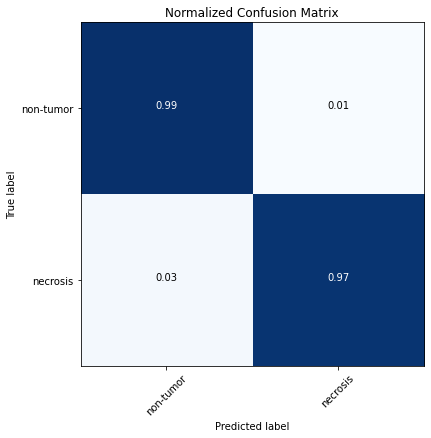

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.95
Accuracy on test data is:  0.956
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.911
Loss value:  5.291890402710905e-05



              precision    recall  f1-score   support

           0       0.94      0.98      0.96       102
           2       0.97      0.92      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.95      0.95       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.943     	       0.98      	   0.924   
  1       0.973     	      0.924      	    0.98   





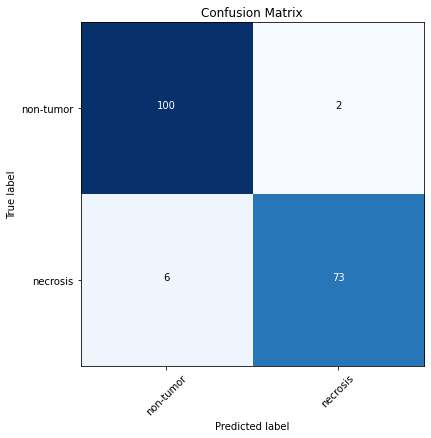

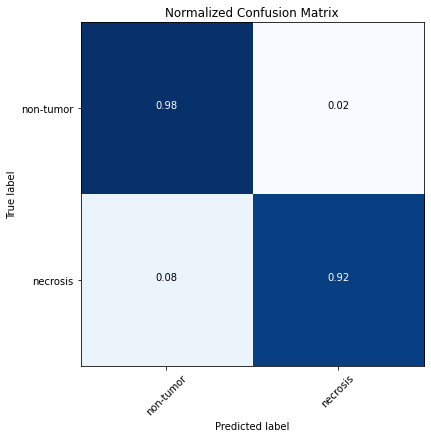

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 500

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 500, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 500)
After applying Mututal information gain, shape for test data:  (181, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.963
Accuracy on test data is:  0.956
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.911
Loss value:  0.002869441619854365


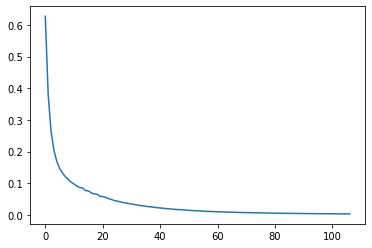




              precision    recall  f1-score   support

           0       0.94      0.98      0.96       102
           2       0.97      0.92      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.95      0.95       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.943     	       0.98      	   0.924   
  1       0.973     	      0.924      	    0.98   





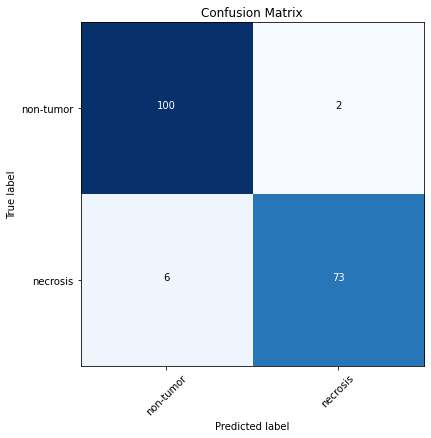

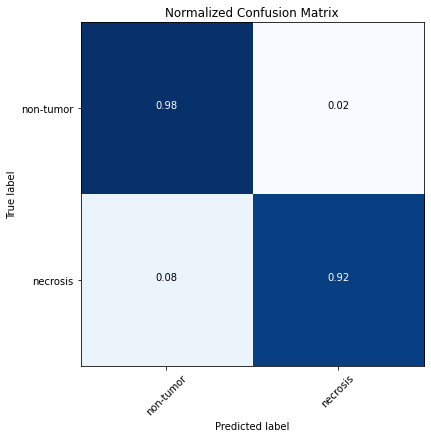

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.951
Accuracy on test data is:  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.05064549745757438


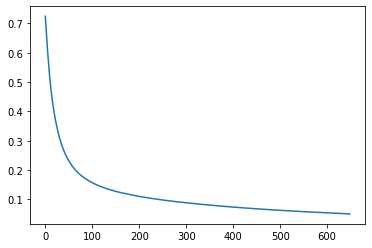




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





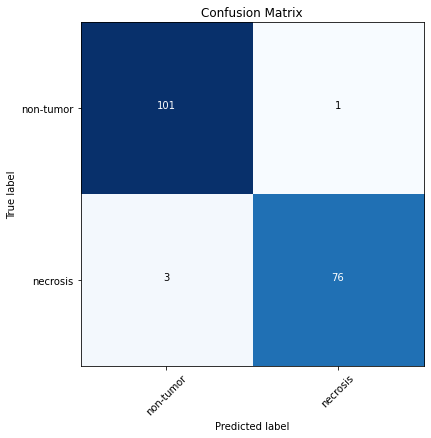

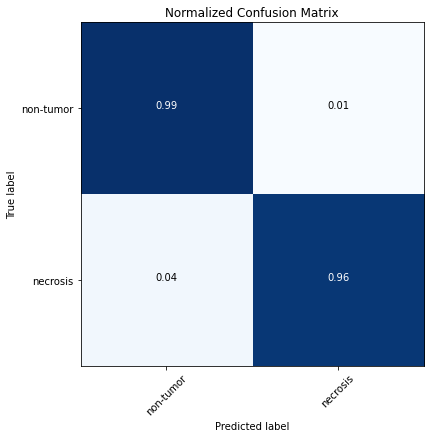

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.947
Accuracy on test data is:  0.961
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  0.0001501458324552449



              precision    recall  f1-score   support

           0       0.95      0.98      0.97       102
           2       0.97      0.94      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.96      0.96       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.952     	       0.98      	   0.937   
  1       0.974     	      0.937      	    0.98   





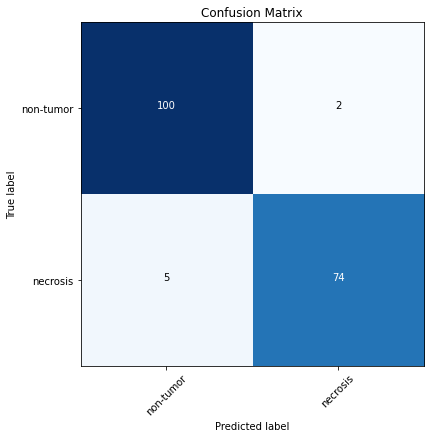

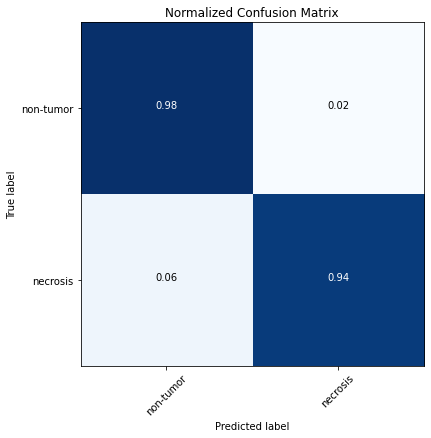

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 500, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 500)
After applying Mututal information gain, shape for test data:  (181, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.963
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.002623472834402402


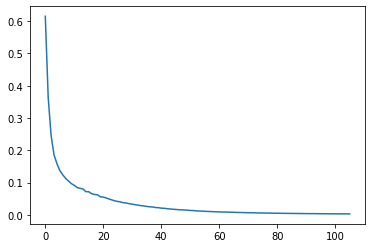




              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           2       0.97      0.97      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.98     	       0.98      	   0.975   
  1       0.975     	      0.975      	    0.98   





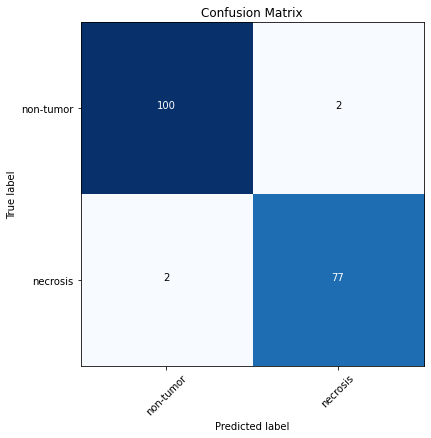

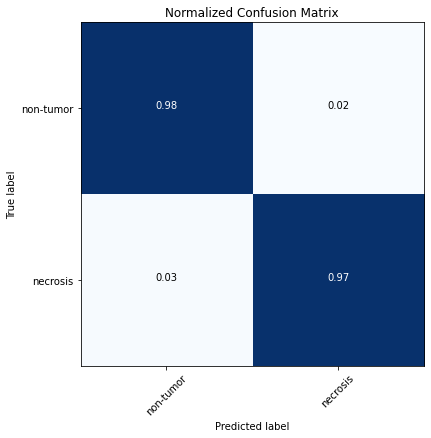

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.953
Accuracy on test data is:  0.983
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.966
Loss value:  0.050114718659546066


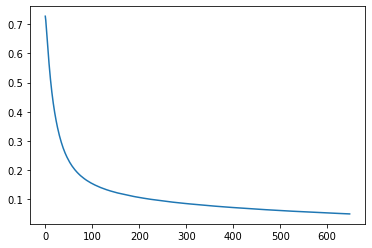




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           2       0.99      0.97      0.98        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.975   
  1       0.987     	      0.975      	    0.99   





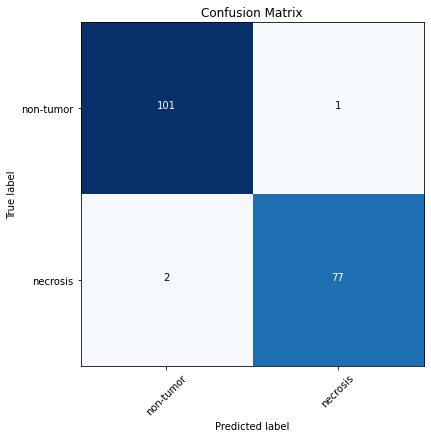

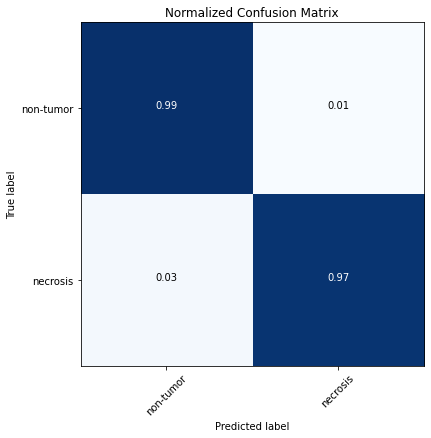

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.95
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.899
Loss value:  4.282360894346796e-05



              precision    recall  f1-score   support

           0       0.95      0.96      0.96       102
           2       0.95      0.94      0.94        79

    accuracy                           0.95       181
   macro avg       0.95      0.95      0.95       181
weighted avg       0.95      0.95      0.95       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.951     	      0.961      	   0.937   
  1       0.949     	      0.937      	   0.961   





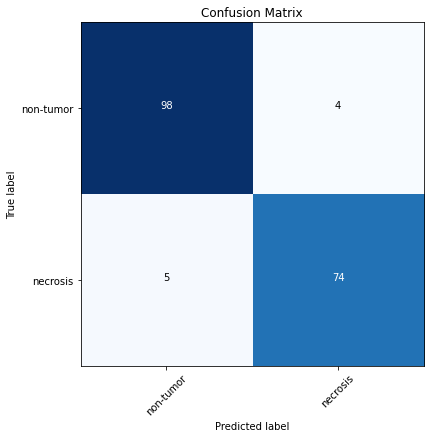

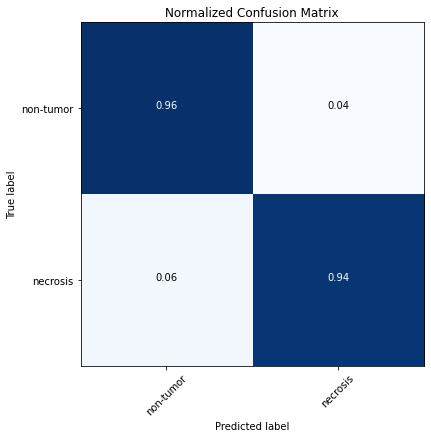

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 600

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 600, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 600)
After applying Mututal information gain, shape for test data:  (181, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.962
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.002444874392901397


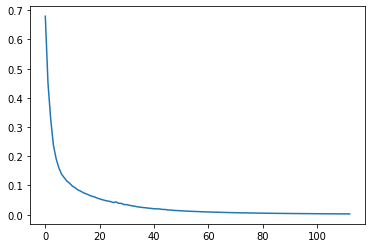




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





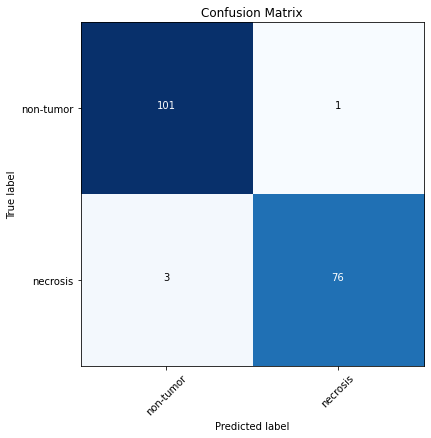

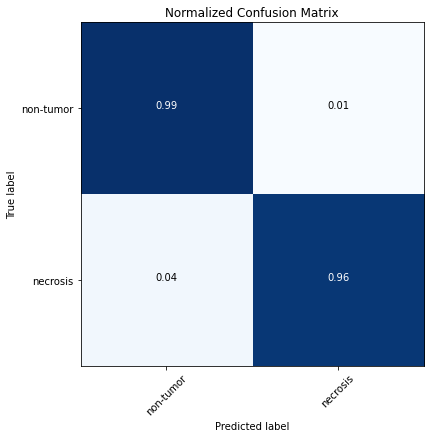

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.050152006618384114


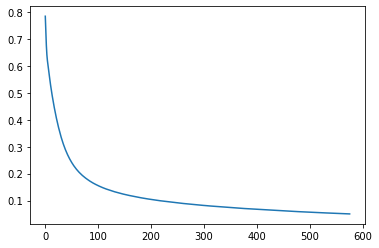




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





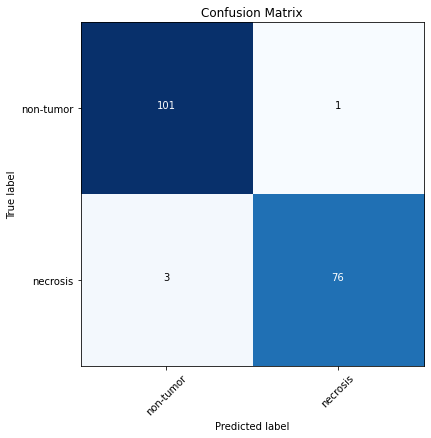

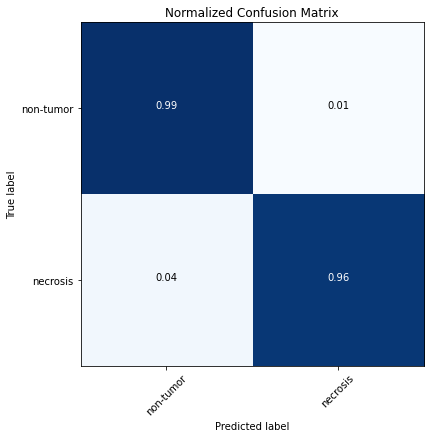

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.972
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.00011428425000229899



              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           2       0.97      0.96      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.962   
  1       0.974     	      0.962      	    0.98   





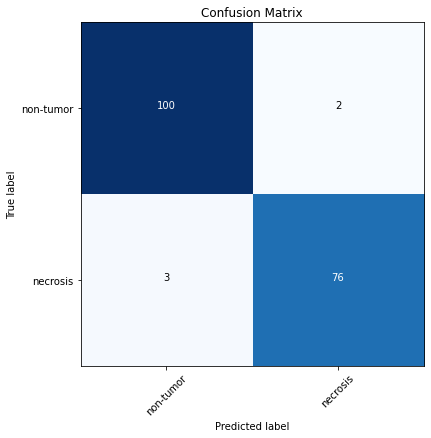

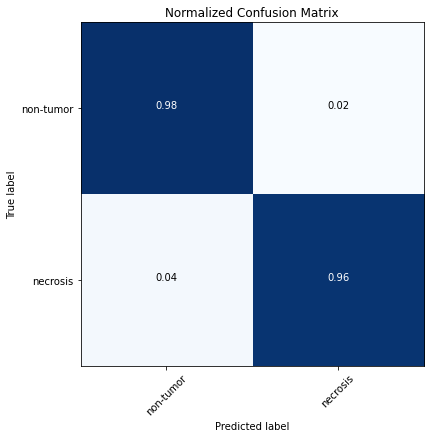

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 600, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 600)
After applying Mututal information gain, shape for test data:  (181, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.962
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.002444874392901397


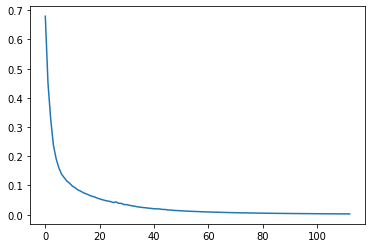




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





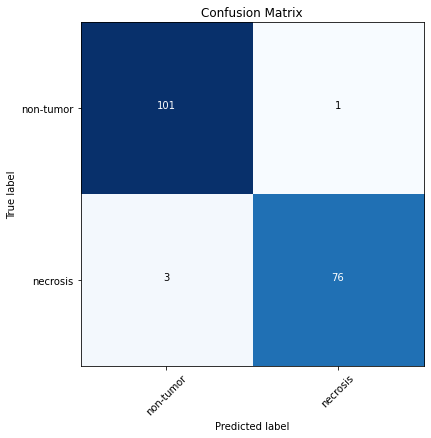

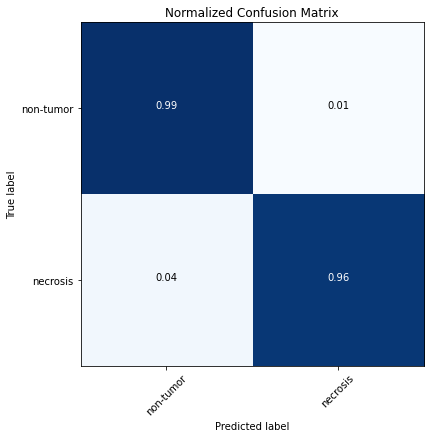

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.050152006618384114


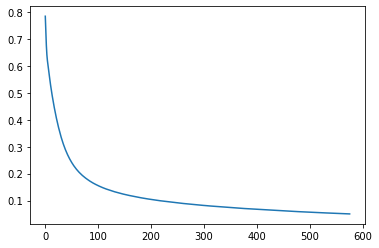




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





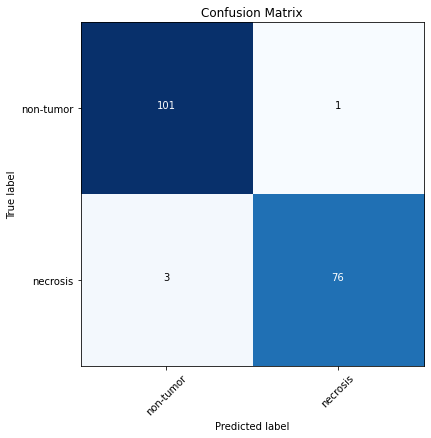

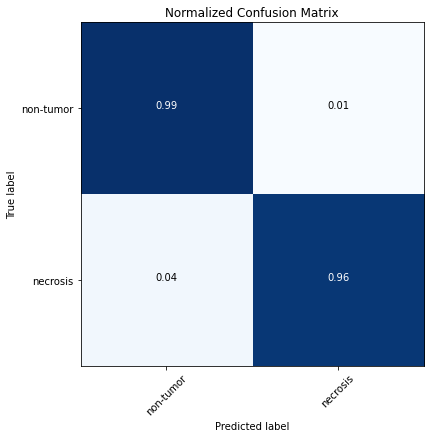

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.972
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.00011428425000229899



              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           2       0.97      0.96      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.962   
  1       0.974     	      0.962      	    0.98   





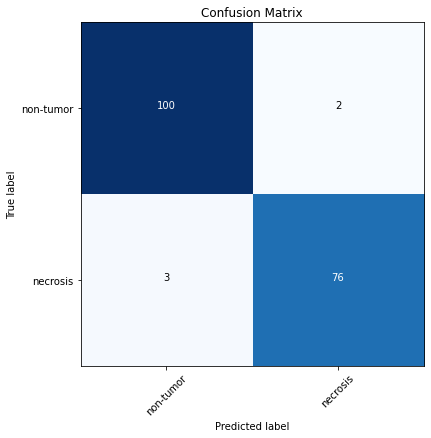

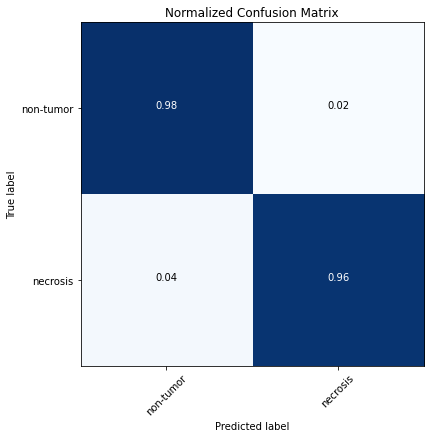

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 700

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 700, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 700)
After applying Mututal information gain, shape for test data:  (181, 700)


**adam**

k-fold validation accuracy for k=5 is:  0.959
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.0026007181149934095


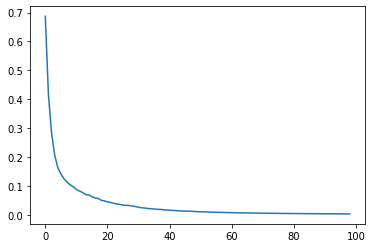




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





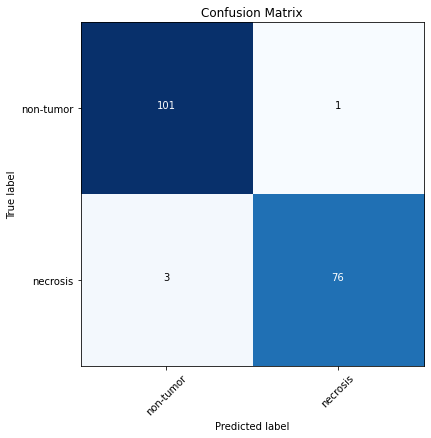

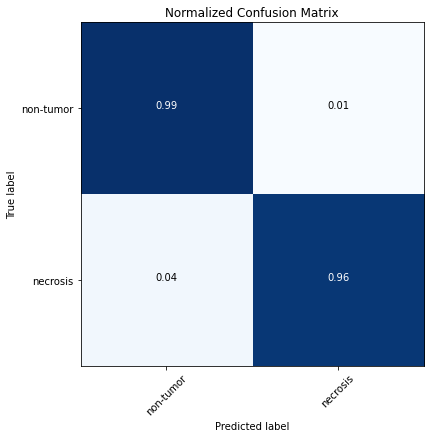

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.983
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.966
Loss value:  0.04328092897489044


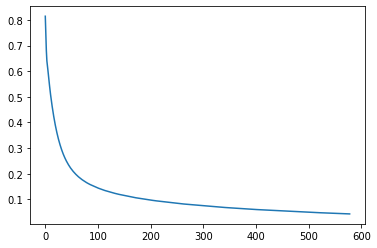




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           2       0.99      0.97      0.98        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.975   
  1       0.987     	      0.975      	    0.99   





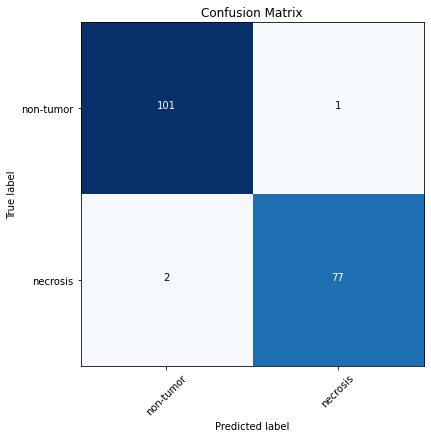

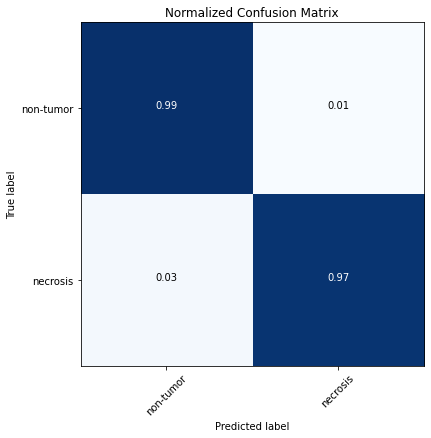

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.967
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  6.998627920999745e-05



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           2       0.97      0.95      0.96        79

    accuracy                           0.97       181
   macro avg       0.97      0.96      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.949   
  1       0.974     	      0.949      	    0.98   





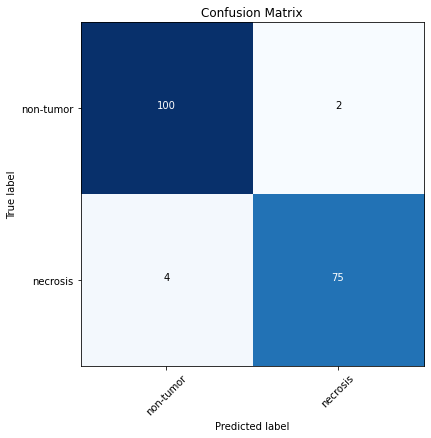

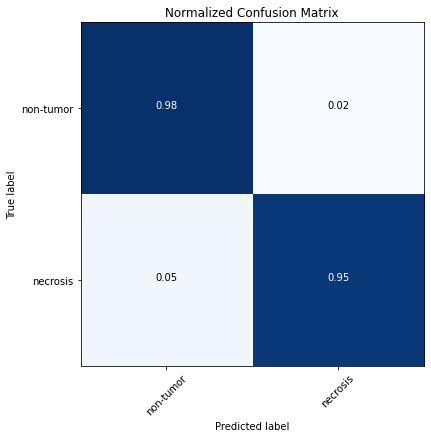

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 700, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 700)
After applying Mututal information gain, shape for test data:  (181, 700)


**adam**

k-fold validation accuracy for k=5 is:  0.966
Accuracy on test data is:  0.972
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.0023563913800734625


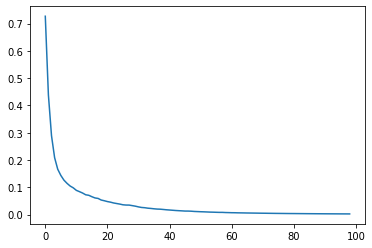




              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           2       0.97      0.96      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.962   
  1       0.974     	      0.962      	    0.98   





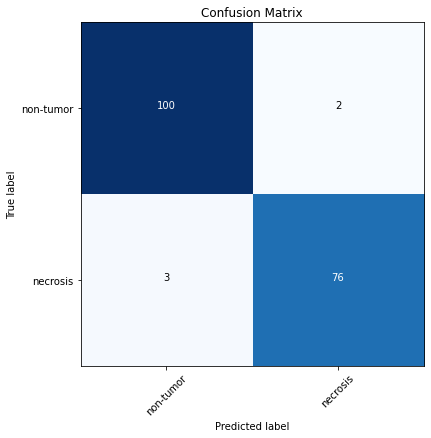

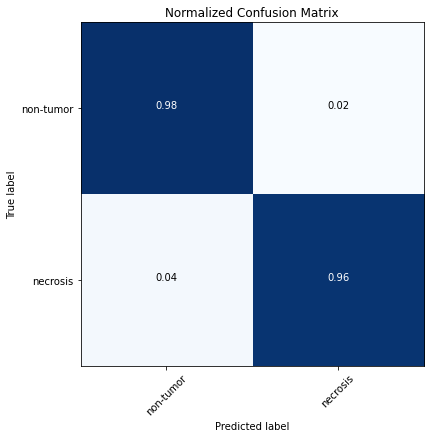

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.96
Accuracy on test data is:  0.972
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.043144494796898414


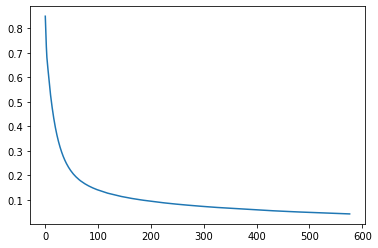




              precision    recall  f1-score   support

           0       0.97      0.98      0.98       102
           2       0.97      0.96      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.98      	   0.962   
  1       0.974     	      0.962      	    0.98   





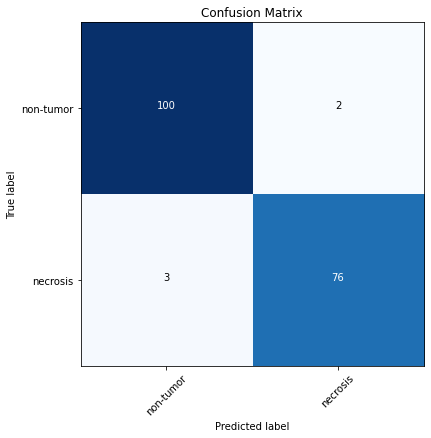

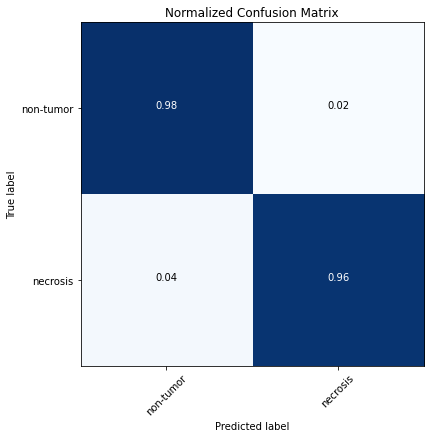

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.961
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.921
Loss value:  4.3262845726960354e-05



              precision    recall  f1-score   support

           0       0.96      0.97      0.97       102
           2       0.96      0.95      0.96        79

    accuracy                           0.96       181
   macro avg       0.96      0.96      0.96       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.961     	      0.971      	   0.949   
  1       0.962     	      0.949      	   0.971   





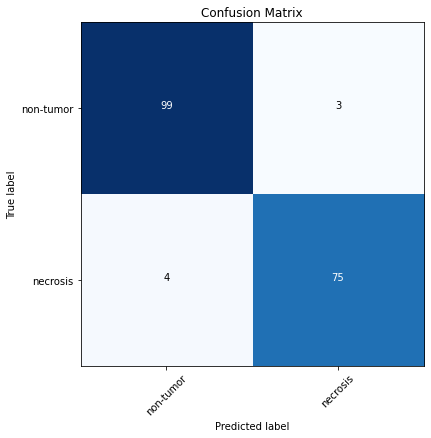

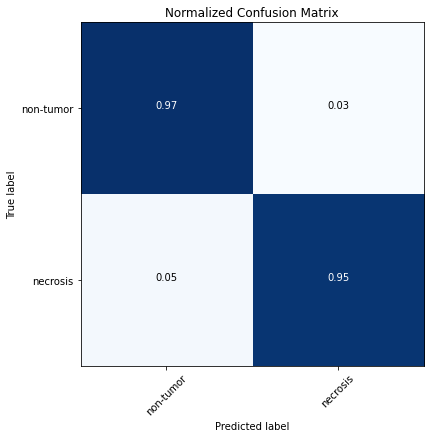

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 800

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 800, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 800)
After applying Mututal information gain, shape for test data:  (181, 800)


**adam**

k-fold validation accuracy for k=5 is:  0.963
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.002406590989876561


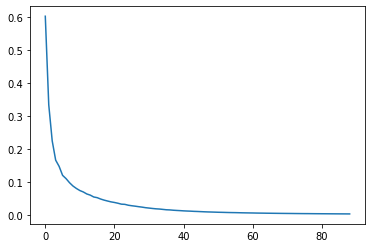




              precision    recall  f1-score   support

           0       0.96      1.00      0.98       102
           2       1.00      0.95      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.97      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       1.0       	   0.949   
  1        1.0      	      0.949      	    1.0    





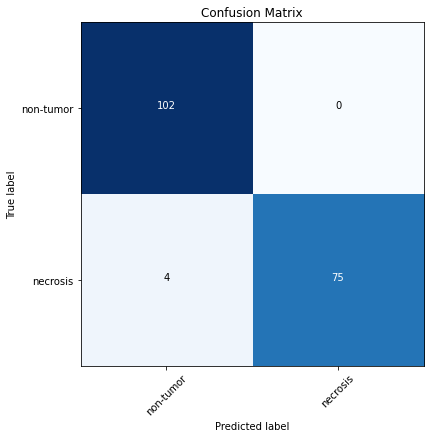

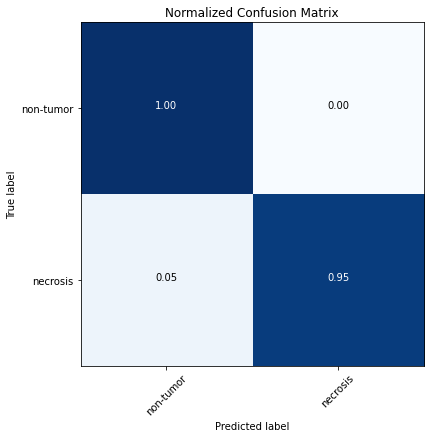

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.957
Accuracy on test data is:  0.983
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.966
Loss value:  0.04020880229786218


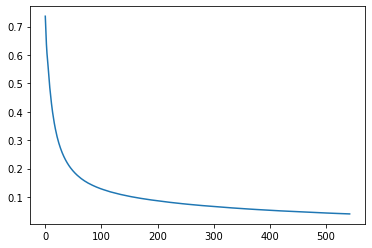




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           2       0.99      0.97      0.98        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.975   
  1       0.987     	      0.975      	    0.99   





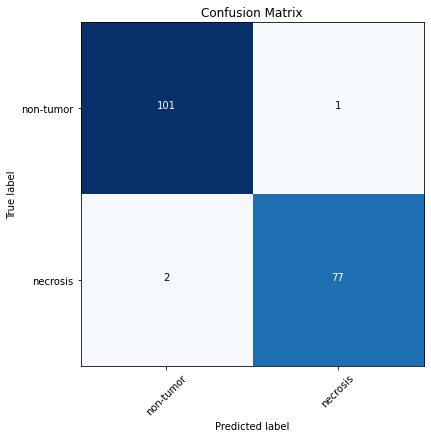

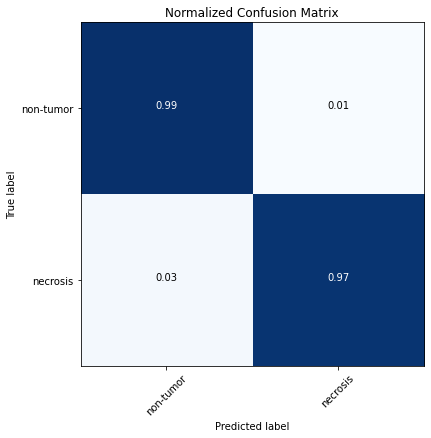

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.957
Accuracy on test data is:  0.961
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.922
Loss value:  9.811632264105105e-05



              precision    recall  f1-score   support

           0       0.95      0.98      0.97       102
           2       0.97      0.94      0.95        79

    accuracy                           0.96       181
   macro avg       0.96      0.96      0.96       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.952     	       0.98      	   0.937   
  1       0.974     	      0.937      	    0.98   





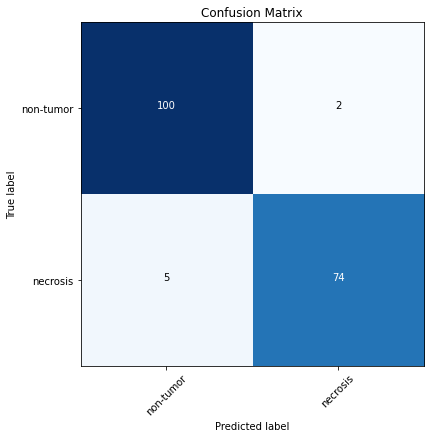

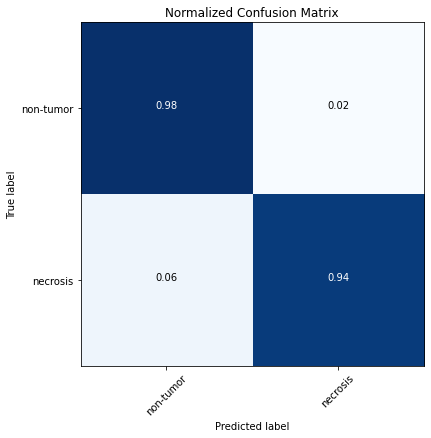

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 800, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 800)
After applying Mututal information gain, shape for test data:  (181, 800)


**adam**

k-fold validation accuracy for k=5 is:  0.964
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.956
Loss value:  0.002068580865413871


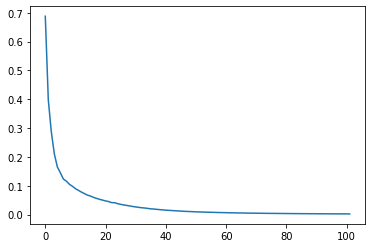




              precision    recall  f1-score   support

           0       0.96      1.00      0.98       102
           2       1.00      0.95      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.97      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       1.0       	   0.949   
  1        1.0      	      0.949      	    1.0    





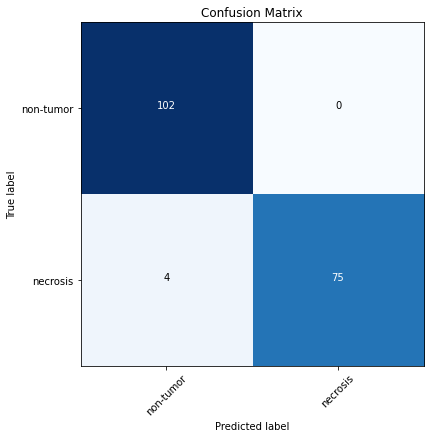

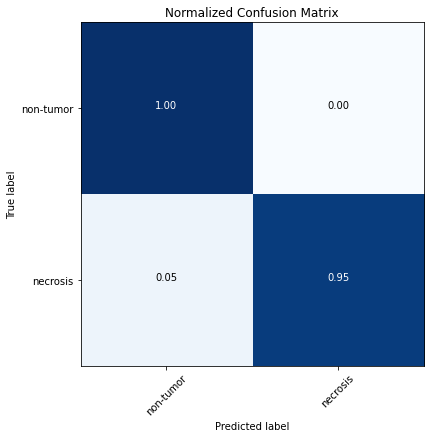

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.956
Accuracy on test data is:  0.983
ROC-AUC score is:  0.997
The Matthews correlation coefficinet (MCC) is:  0.966
Loss value:  0.041174189100855685


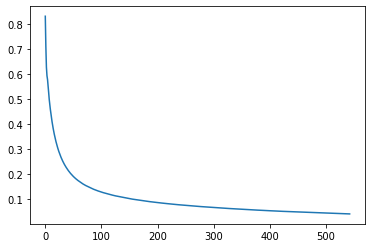




              precision    recall  f1-score   support

           0       0.98      0.99      0.99       102
           2       0.99      0.97      0.98        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.981     	       0.99      	   0.975   
  1       0.987     	      0.975      	    0.99   





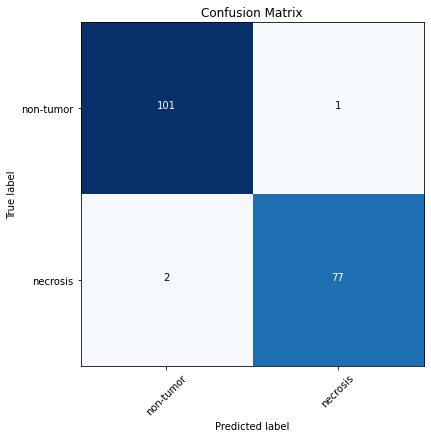

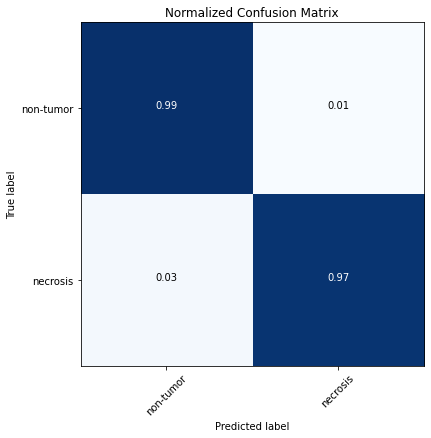

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.959
Accuracy on test data is:  0.961
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.921
Loss value:  0.0001262096060547005



              precision    recall  f1-score   support

           0       0.96      0.97      0.97       102
           2       0.96      0.95      0.96        79

    accuracy                           0.96       181
   macro avg       0.96      0.96      0.96       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.961     	      0.971      	   0.949   
  1       0.962     	      0.949      	   0.971   





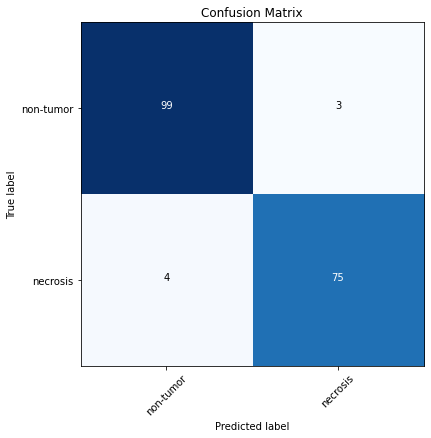

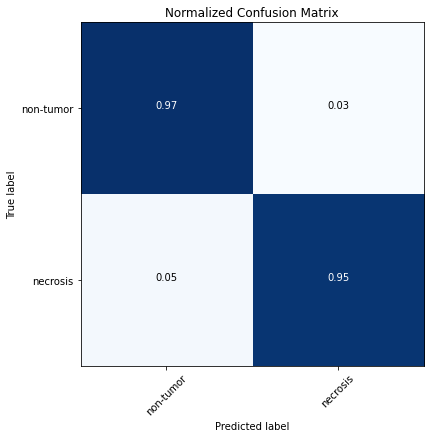

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 900

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 900, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 900)
After applying Mututal information gain, shape for test data:  (181, 900)


**adam**

k-fold validation accuracy for k=5 is:  0.967
Accuracy on test data is:  0.978
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.002669925812010316


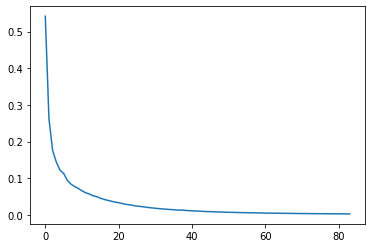




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





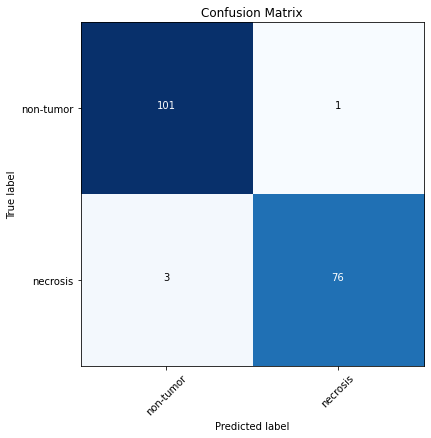

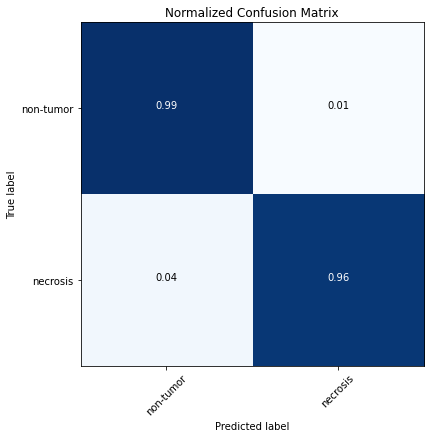

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.978
ROC-AUC score is:  0.998
The Matthews correlation coefficinet (MCC) is:  0.955
Loss value:  0.03793408919914562


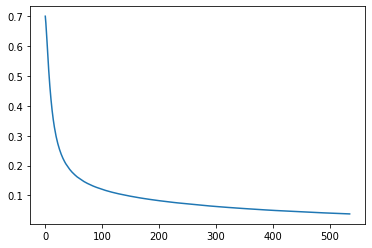




              precision    recall  f1-score   support

           0       0.97      0.99      0.98       102
           2       0.99      0.96      0.97        79

    accuracy                           0.98       181
   macro avg       0.98      0.98      0.98       181
weighted avg       0.98      0.98      0.98       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.971     	       0.99      	   0.962   
  1       0.987     	      0.962      	    0.99   





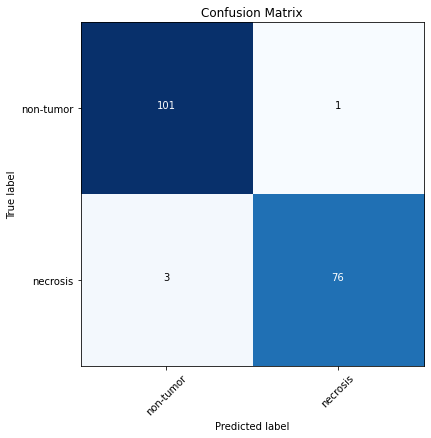

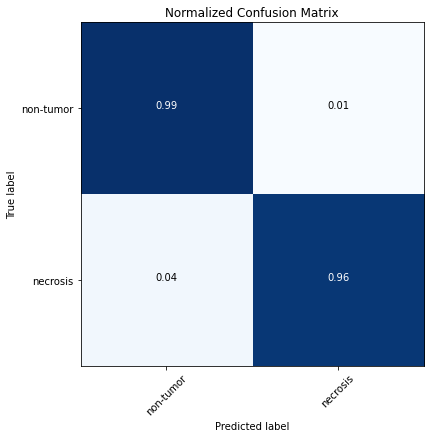

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.954
Accuracy on test data is:  0.961
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.921
Loss value:  5.188424942058822e-05



              precision    recall  f1-score   support

           0       0.96      0.97      0.97       102
           2       0.96      0.95      0.96        79

    accuracy                           0.96       181
   macro avg       0.96      0.96      0.96       181
weighted avg       0.96      0.96      0.96       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.961     	      0.971      	   0.949   
  1       0.962     	      0.949      	   0.971   





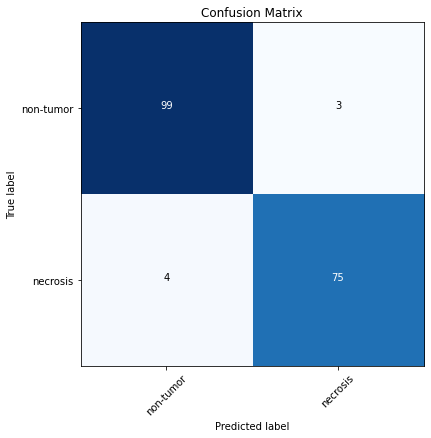

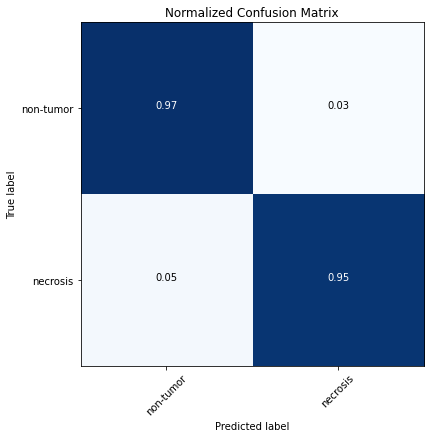

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 900, X_train= train_x_b3, y_train= train_y_b3 ,X_test= test_x_b3) 

After applying mutual information gain, shape for train data:  (701, 900)
After applying Mututal information gain, shape for test data:  (181, 900)


**adam**

k-fold validation accuracy for k=5 is:  0.967
Accuracy on test data is:  0.972
ROC-AUC score is:  0.999
The Matthews correlation coefficinet (MCC) is:  0.944
Loss value:  0.0023232831366321563


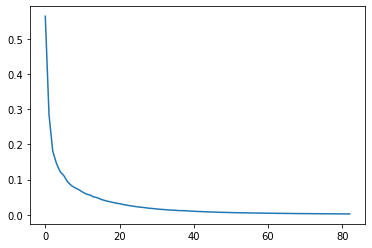




              precision    recall  f1-score   support

           0       0.96      0.99      0.98       102
           2       0.99      0.95      0.97        79

    accuracy                           0.97       181
   macro avg       0.97      0.97      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.99      	   0.949   
  1       0.987     	      0.949      	    0.99   





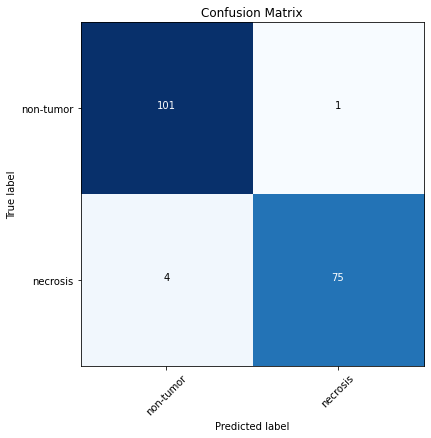

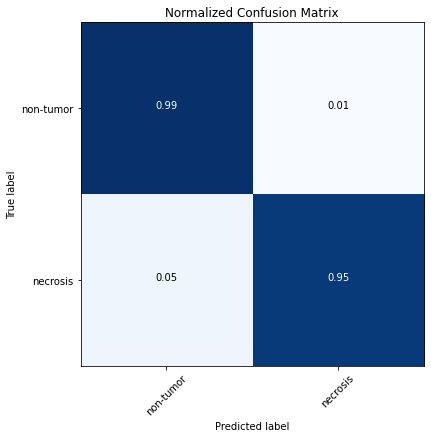

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.959
Accuracy on test data is:  0.967
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  8.629352134038956e-05



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           2       0.97      0.95      0.96        79

    accuracy                           0.97       181
   macro avg       0.97      0.96      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.949   
  1       0.974     	      0.949      	    0.98   





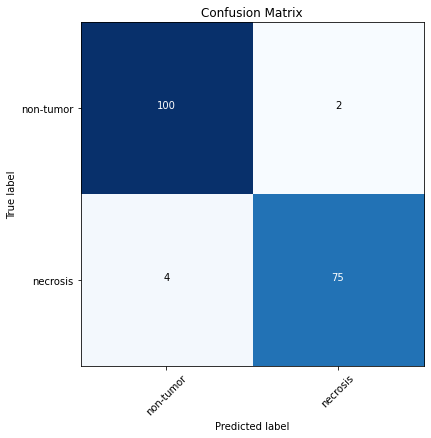

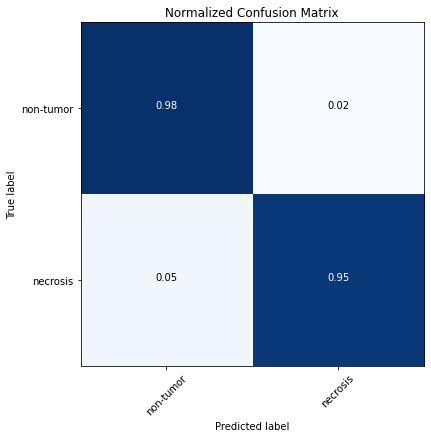

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.959
Accuracy on test data is:  0.967
ROC-AUC score is:  0.996
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  8.629352134038956e-05



              precision    recall  f1-score   support

           0       0.96      0.98      0.97       102
           2       0.97      0.95      0.96        79

    accuracy                           0.97       181
   macro avg       0.97      0.96      0.97       181
weighted avg       0.97      0.97      0.97       181




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.962     	       0.98      	   0.949   
  1       0.974     	      0.949      	    0.98   





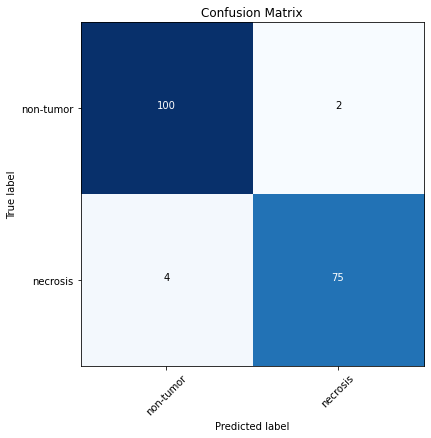

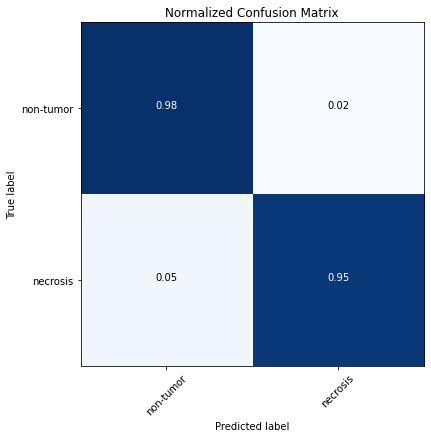

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

# saving necrosis vs viable features and experiment 

In [ ]:
# combinig dataset for train set 
train_x_b4 = np.concatenate((non_viable_tumor_train, viable_tumor_train), axis=0)
train_y_b4 = np.concatenate((non_viable_tumor_train_l, viable_tumor_train_l), axis= 0)
print('Train set shape: ',train_x_b4.shape)
print('Train labels shape: ',train_y_b4.shape)

# combinig dataset for test set 
test_x_b4 = np.concatenate((non_viable_tumor_test, viable_tumor_test), axis=0)
test_y_b4 = np.concatenate((non_viable_tumor_test_l, viable_tumor_test_l), axis= 0)
print('Test set shape: ',test_x_b4.shape)
print('Test labels shape: ',test_y_b4.shape)

Train set shape:  (481, 1024)
Train labels shape:  (481,)
Test set shape:  (126, 1024)
Test labels shape:  (126,)


**save train set**

In [ ]:
# train features 
df_train_b4 = pd.DataFrame(train_x_b4)
df_train_b4 = df_train_b4.assign(labels= train_y_b4)
# df_train_b2.head()

# saving csv to local machine
df_train_b4.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_necrosis_vs_viable_train_features.csv', index=False)

df_train_b4.head()

0         1         2         3         4         5         6  \
0 -0.528624 -0.339222  0.151850  0.194594  0.192190  0.202298 -0.243339   
1 -0.393900 -0.716967  0.329195  0.057246 -0.109514  0.410788  0.117844   
2  0.027992 -0.258638 -0.182119 -0.006831 -0.284404  0.064054 -0.356811   
3 -0.421404 -0.411167  0.110450  0.181653  0.062822  0.562500  0.152090   
4  0.074776 -0.540260  0.444438  0.267732  0.401649  0.295592  0.179079   

          7         8         9  ...      1015      1016      1017      1018  \
0  0.231040 -0.684753  0.479715  ...  0.255826 -0.387687 -0.169119  0.345574   
1  0.310617 -0.604659  0.638749  ...  0.864549 -0.263488  0.015209  0.768851   
2  0.787562 -0.532120  0.745837  ...  0.687397 -0.698793 -0.489947  0.222746   
3  0.527255 -0.379582  0.301711  ...  0.850255 -0.406578 -0.099805  0.422094   
4 -0.082529 -0.314554  0.191640  ... -0.242859 -0.576989  0.377780  0.144536   

       1019      1020      1021      1022      1023  labels  
0  0.606254  0.320685 -0.005027 -0.093069  0.401478       1  
1 -0.006117  0.099577 -0.190043 -0.081524  0.586372       1  
2  0.948958  0.242469 -0.565667  0.344198  0.010146       1  
3  0.597966  0.144540  0.192920 -0.479014  0.357587       1  
4  0.795201  0.269002  0.144548 -0.003452  0.278334       1  

[5 rows x 1025 columns]

**save test set**

In [ ]:
# train features 
df_test_b4 = pd.DataFrame(test_x_b4)
df_test_b4 = df_test_b4.assign(labels= test_y_b4)
# df_train_b2.head()

# saving csv to local machine
df_test_b4.to_csv(r'/content/drive/MyDrive/Colab Notebooks/Osteosercoma/final_necrosis_vs_viable_test_features.csv', index=False)

df_test_b4.head()

0         1         2         3         4         5         6  \
0 -0.262120 -0.757987 -0.068572  0.722429  0.400141  0.158231 -0.015343   
1 -0.182060 -0.382235  0.068891  0.427337  0.422093  0.283629 -0.071246   
2 -0.464474 -0.627377  0.194548  0.128065  0.360685  0.528125  0.154080   
3 -0.365348 -0.393288  0.039322  0.448641  0.069405  0.218731 -0.269983   
4 -0.673551 -0.213478  0.012355  0.036986  0.014035  0.311469 -0.280536   

          7         8         9  ...      1015      1016      1017      1018  \
0 -0.170399  0.252491 -0.086116  ...  0.266684 -0.269666  0.173127  0.437608   
1  0.582830 -0.524725  0.467493  ...  0.839079 -0.155360  0.158235  0.868439   
2 -0.045351 -0.765608  0.596044  ...  0.498026  0.034981  0.286411  0.381558   
3 -0.053651 -0.563212  0.643957  ...  0.323260 -0.702861 -0.362996  0.394778   
4  0.933763 -0.528051  0.514250  ...  0.501754 -0.489791 -0.106645  1.001459   

       1019      1020      1021      1022      1023  labels  
0  0.487088  0.412608 -0.509814  0.926455 -0.318463       1  
1  0.585132  0.525199 -0.049490 -0.530286  0.142908       1  
2  0.222749  0.087055  0.065985 -0.308883  0.354870       1  
3  0.200000  0.330862 -0.434181 -0.016950  0.100376       1  
4  0.385028 -0.103397 -0.074871 -0.468812  0.168031       1  

[5 rows x 1025 columns]

In [ ]:
# with feature scaling 
from sklearn.neural_network import MLPClassifier

# defining MLP classifier
mlp_classifier = MLPClassifier(random_state=1, max_iter=200)

# fitting training data 
# mlp_classifier.fit(X_train_b2, train_y_b2)
mlp_classifier.fit(train_x_b4, train_y_b4)

# getting k-fold validation accuracy, we are taking k= 5 folds
# k_fold_acc = cross_val_score(mlp_classifier, X_train_b2, train_y_b2, cv= 5)
k_fold_acc = cross_val_score(mlp_classifier, train_x_b4, train_y_b4, cv= 5)

# taking mean of 5 folds accuracy
k_fold_mean = k_fold_acc.mean()
print("k-fold validation accuracy for k=5 is: ", round(k_fold_mean, 3))

# predicting through test data
# mlp_pred = mlp_classifier.predict(X_test_b2)
mlp_pred = mlp_classifier.predict(test_x_b4)

#Print overall accuracy
from sklearn import metrics
acc = metrics.accuracy_score(test_y_b4, mlp_pred)
print ("Accuracy on test data is: ", round(acc, 3))

# roc-auc
# lr_probs = mlp_classifier.predict_proba(X_test_b2)
lr_probs = mlp_classifier.predict_proba(test_x_b4)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
roc_auc = roc_auc_score(test_y_b4, lr_probs)
print("ROC-AUC score is: ", round(roc_auc, 3))

# Compute the Matthews correlation coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(test_y_b4, mlp_pred)
print("The Matthews correlation coefficinet (MCC) is: ", round(mcc, 3))

k-fold validation accuracy for k=5 is:  0.942
Accuracy on test data is:  0.952
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.9


In [ ]:
def get_final_result(opt_name, num_iter, classes):
  
  # getting predicted outputs
  if opt_name == "lbfgs":
    pred = mlp_class_wo_plot(optimizer_name= opt_name, num_iteration=num_iter, train_data=train_x, test_data= test_x, y_train= train_y_b4, y_test=test_y_b4)
  else:
    pred = mlp_class_plot(optimizer_name= opt_name, num_iteration=num_iter, train_data= train_x, test_data= test_x, y_train= train_y_b4, y_test=test_y_b4)

  # perfomance metrices
  print()
  print()
  print()

  # getting classsification reports
  get_reports(test_y_b4, pred)
  print("\n\n")

  # getting sensitivity and specificity
  get_sn_sp(test_y_b4, pred)
  print("\n\n")

  # getting unnormalized and normalized confusion matrix
  conf_mat(classes, test_y_b4, pred)

In [ ]:
classess = ['necrosis', 'viable']

#### 100

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 100, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 100)
After applying Mututal information gain, shape for test data:  (126, 100)


**adam**

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.944
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.887
Loss value:  0.008076776920177893


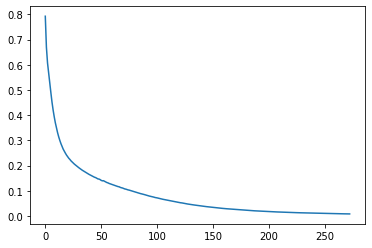




              precision    recall  f1-score   support

           1       0.88      0.98      0.93        47
           2       0.99      0.92      0.95        79

    accuracy                           0.94       126
   macro avg       0.94      0.95      0.94       126
weighted avg       0.95      0.94      0.94       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.885     	      0.979      	   0.924   
  1       0.986     	      0.924      	   0.979   





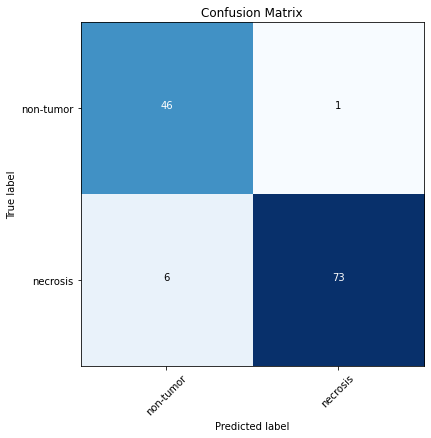

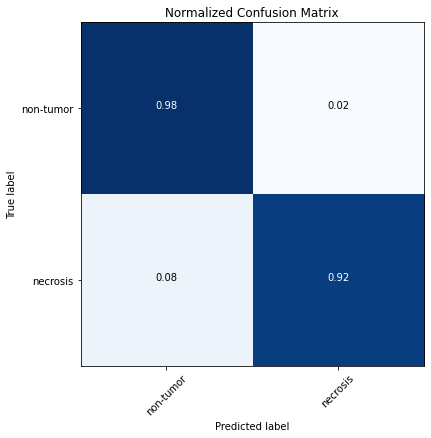

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


k-fold validation accuracy for k=5 is:  0.915
Accuracy on test data is:  0.944
ROC-AUC score is:  0.99
The Matthews correlation coefficinet (MCC) is:  0.882
Loss value:  0.1595325124650953


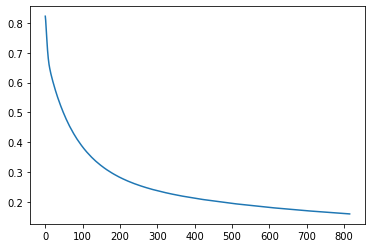




              precision    recall  f1-score   support

           1       0.92      0.94      0.93        47
           2       0.96      0.95      0.96        79

    accuracy                           0.94       126
   macro avg       0.94      0.94      0.94       126
weighted avg       0.94      0.94      0.94       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.917     	      0.936      	   0.949   
  1       0.962     	      0.949      	   0.936   





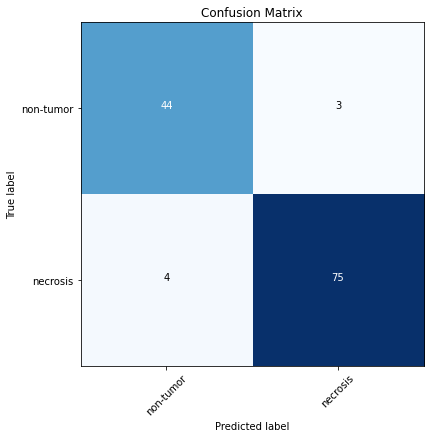

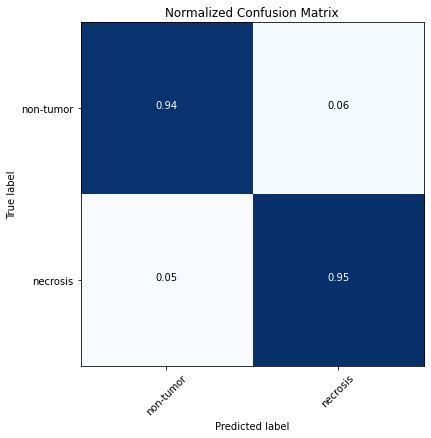

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.921
Accuracy on test data is:  0.937
ROC-AUC score is:  0.976
The Matthews correlation coefficinet (MCC) is:  0.866
Loss value:  0.00017135111407030315



              precision    recall  f1-score   support

           1       0.90      0.94      0.92        47
           2       0.96      0.94      0.95        79

    accuracy                           0.94       126
   macro avg       0.93      0.94      0.93       126
weighted avg       0.94      0.94      0.94       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.898     	      0.936      	   0.937   
  1       0.961     	      0.937      	   0.936   





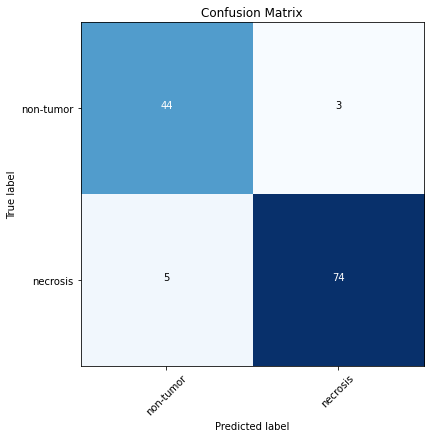

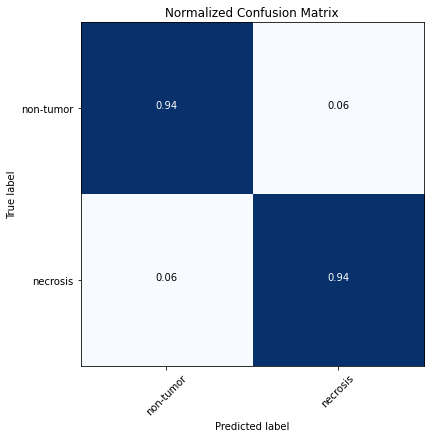

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 100, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 100)
After applying Mututal information gain, shape for test data:  (126, 100)


**adam**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.96
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.916
Loss value:  0.007107339206438806


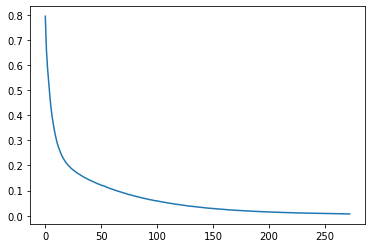




              precision    recall  f1-score   support

           1       0.94      0.96      0.95        47
           2       0.97      0.96      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.938     	      0.957      	   0.962   
  1       0.974     	      0.962      	   0.957   





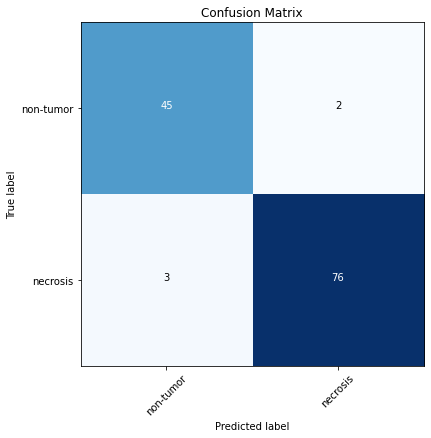

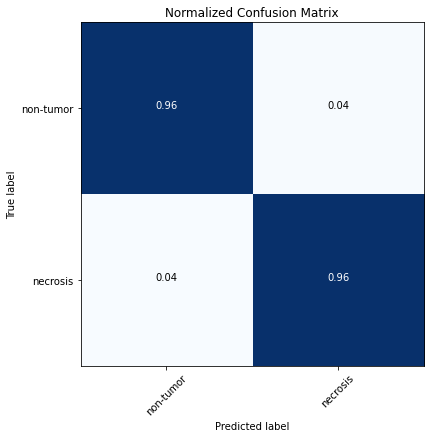

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.921
Accuracy on test data is:  0.952
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.9
Loss value:  0.14818605634117424


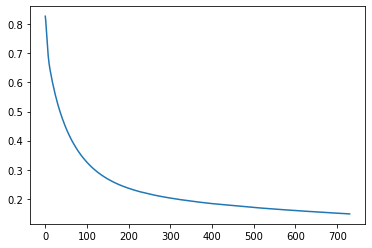




              precision    recall  f1-score   support

           1       0.92      0.96      0.94        47
           2       0.97      0.95      0.96        79

    accuracy                           0.95       126
   macro avg       0.95      0.95      0.95       126
weighted avg       0.95      0.95      0.95       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.918     	      0.957      	   0.949   
  1       0.974     	      0.949      	   0.957   





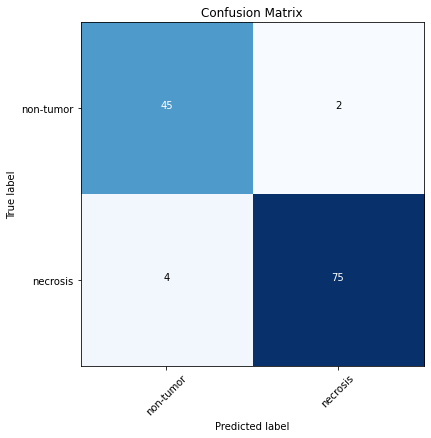

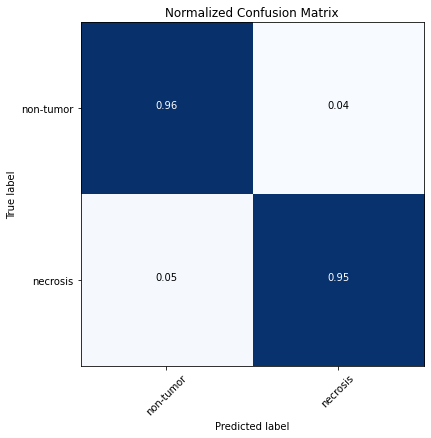

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.921
Accuracy on test data is:  0.96
ROC-AUC score is:  0.979
The Matthews correlation coefficinet (MCC) is:  0.916
Loss value:  0.0002403186641953058



              precision    recall  f1-score   support

           1       0.94      0.96      0.95        47
           2       0.97      0.96      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.938     	      0.957      	   0.962   
  1       0.974     	      0.962      	   0.957   





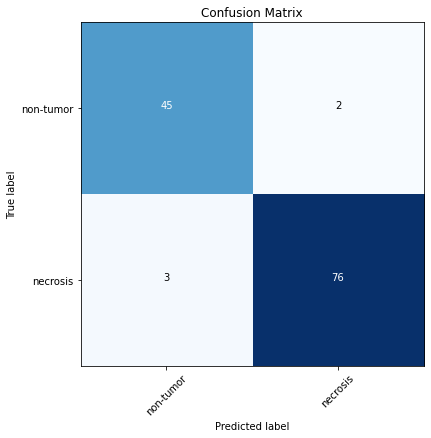

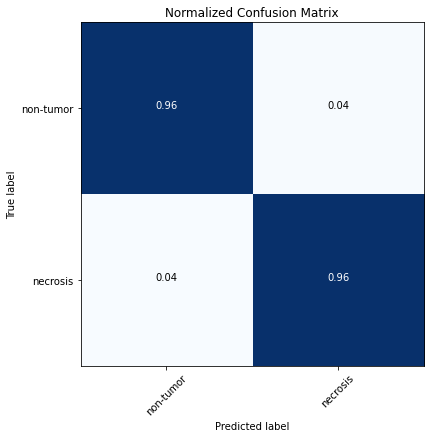

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 200

#### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 200, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 200)
After applying Mututal information gain, shape for test data:  (126, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.968
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.005145433095692185


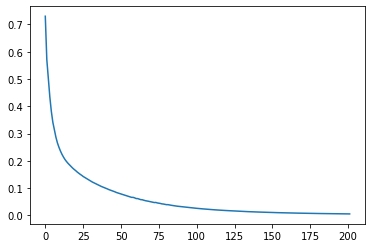




              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.99      0.96      0.97        79

    accuracy                           0.97       126
   macro avg       0.96      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.939     	      0.979      	   0.962   
  1       0.987     	      0.962      	   0.979   





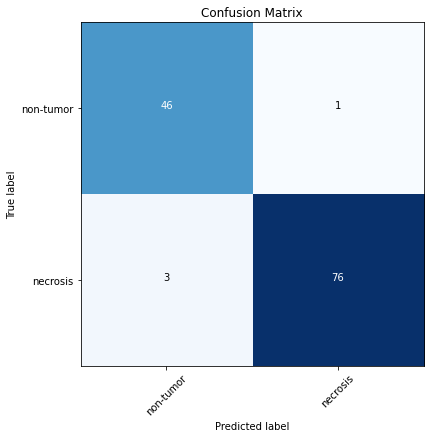

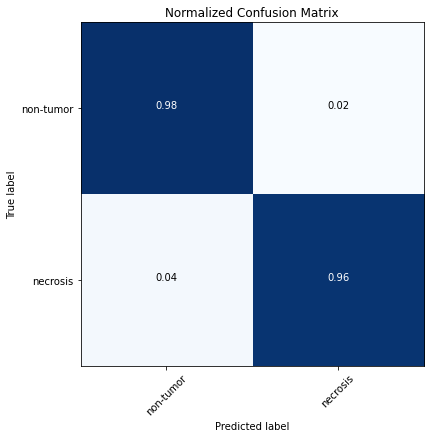

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.968
ROC-AUC score is:  0.981
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  0.10892172521703124


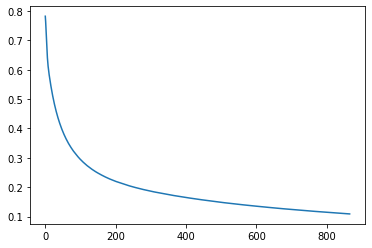




              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





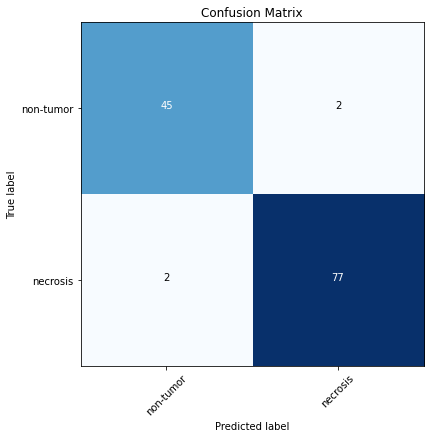

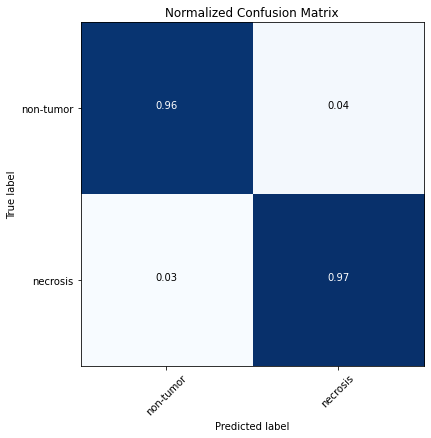

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lgbfs**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.944
ROC-AUC score is:  0.978
The Matthews correlation coefficinet (MCC) is:  0.881
Loss value:  0.0001599058711317879



              precision    recall  f1-score   support

           1       0.93      0.91      0.92        47
           2       0.95      0.96      0.96        79

    accuracy                           0.94       126
   macro avg       0.94      0.94      0.94       126
weighted avg       0.94      0.94      0.94       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.935     	      0.915      	   0.962   
  1        0.95     	      0.962      	   0.915   





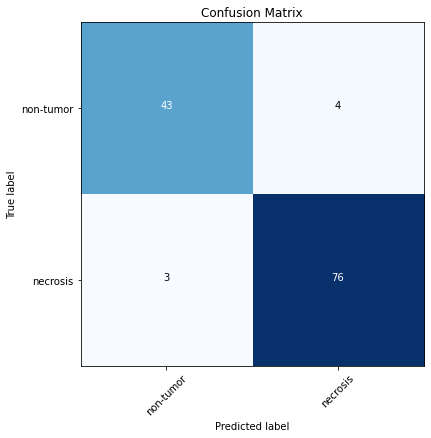

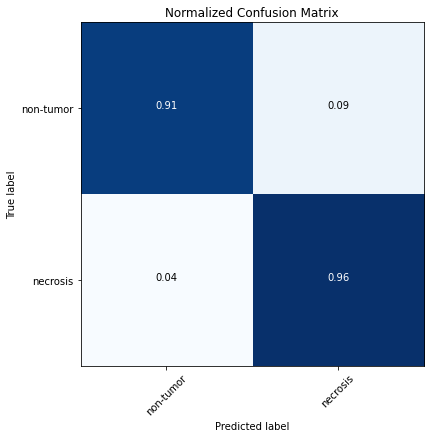

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 200, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 200)
After applying Mututal information gain, shape for test data:  (126, 200)


**adam**

k-fold validation accuracy for k=5 is:  0.94
Accuracy on test data is:  0.984
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.966
Loss value:  0.005911782565876102


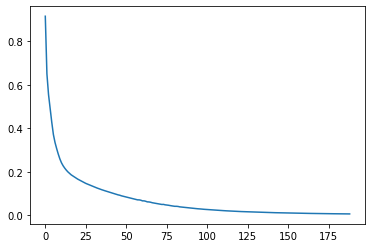




              precision    recall  f1-score   support

           1       0.98      0.98      0.98        47
           2       0.99      0.99      0.99        79

    accuracy                           0.98       126
   macro avg       0.98      0.98      0.98       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.979     	      0.979      	   0.987   
  1       0.987     	      0.987      	   0.979   





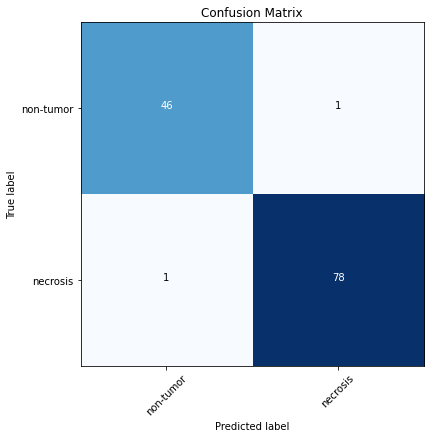

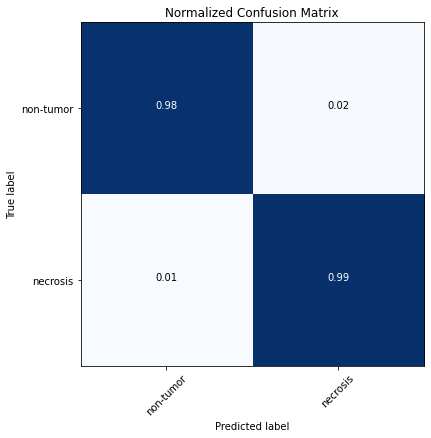

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.968
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.11148720278679593


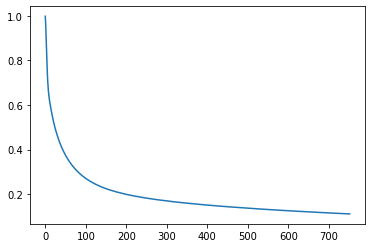




              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.99      0.96      0.97        79

    accuracy                           0.97       126
   macro avg       0.96      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.939     	      0.979      	   0.962   
  1       0.987     	      0.962      	   0.979   





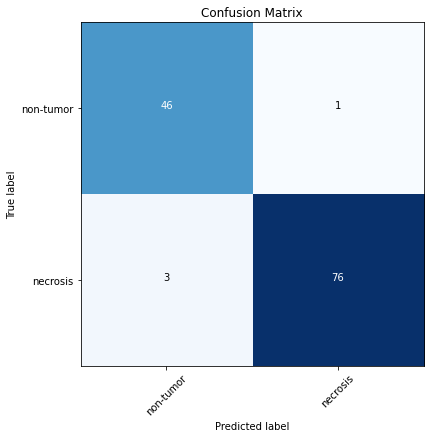

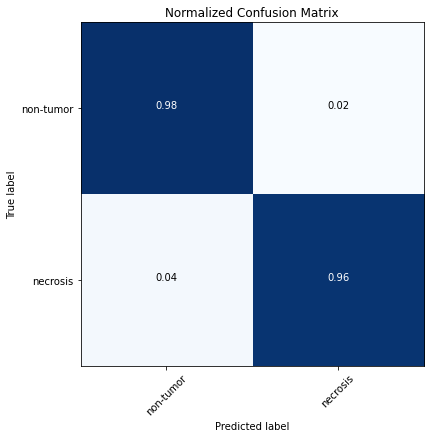

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.952
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.898
Loss value:  7.777365357663364e-05



              precision    recall  f1-score   support

           1       0.96      0.91      0.93        47
           2       0.95      0.97      0.96        79

    accuracy                           0.95       126
   macro avg       0.95      0.94      0.95       126
weighted avg       0.95      0.95      0.95       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.956     	      0.915      	   0.975   
  1       0.951     	      0.975      	   0.915   





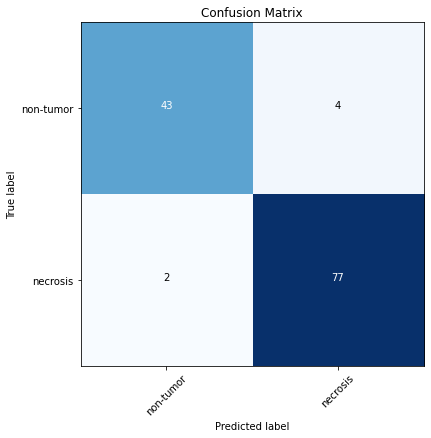

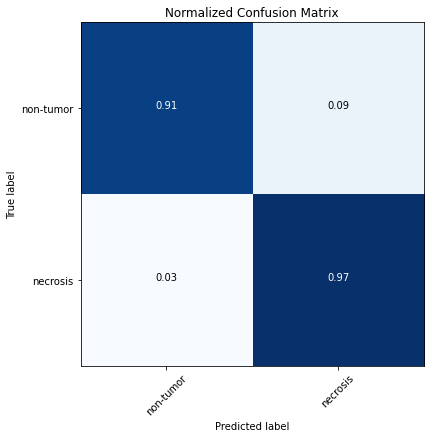

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 300

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 300, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 300)
After applying Mututal information gain, shape for test data:  (126, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.968
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.0039011838425759395


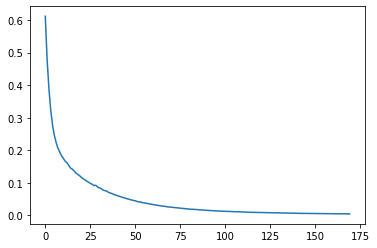




              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.99      0.96      0.97        79

    accuracy                           0.97       126
   macro avg       0.96      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.939     	      0.979      	   0.962   
  1       0.987     	      0.962      	   0.979   





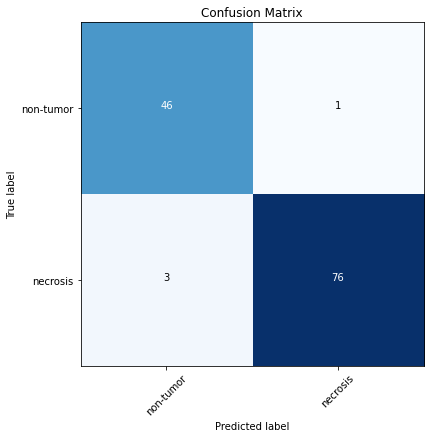

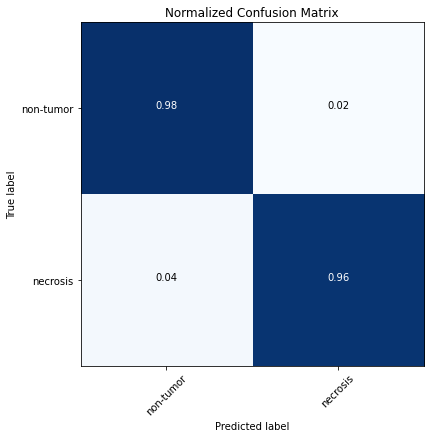

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (900) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


k-fold validation accuracy for k=5 is:  0.927
Accuracy on test data is:  0.96
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.916
Loss value:  0.08597630960696245


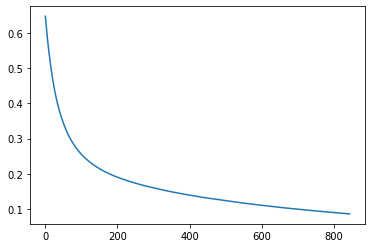




              precision    recall  f1-score   support

           1       0.94      0.96      0.95        47
           2       0.97      0.96      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.938     	      0.957      	   0.962   
  1       0.974     	      0.962      	   0.957   





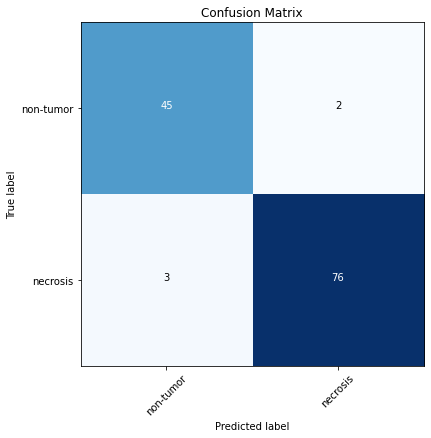

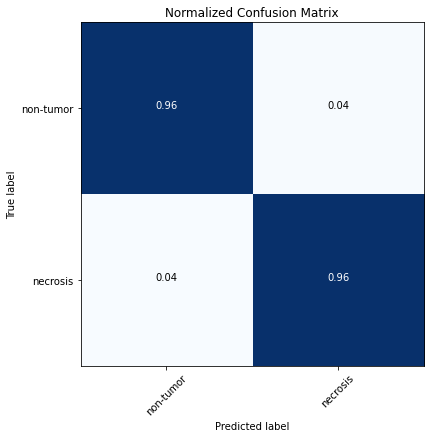

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=900, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.937
ROC-AUC score is:  0.977
The Matthews correlation coefficinet (MCC) is:  0.868
Loss value:  8.02361720628247e-05



              precision    recall  f1-score   support

           1       0.88      0.96      0.92        47
           2       0.97      0.92      0.95        79

    accuracy                           0.94       126
   macro avg       0.93      0.94      0.93       126
weighted avg       0.94      0.94      0.94       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.882     	      0.957      	   0.924   
  1       0.973     	      0.924      	   0.957   





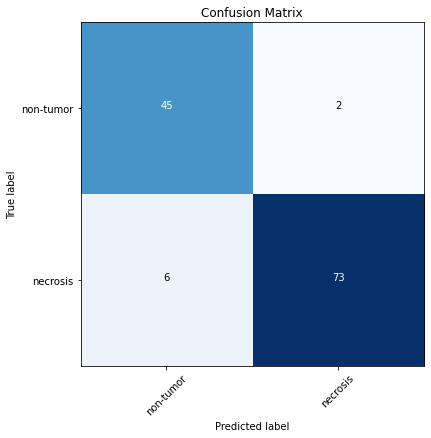

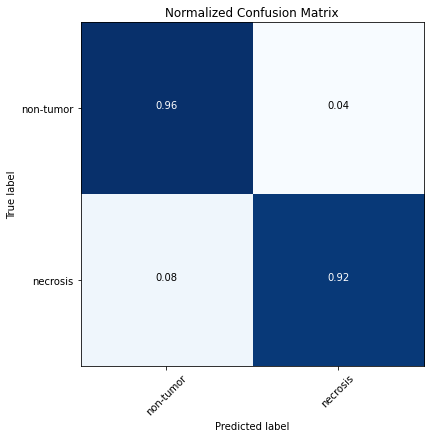

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 300, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 300)
After applying Mututal information gain, shape for test data:  (126, 300)


**adam**

k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.96
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.916
Loss value:  0.00435267333816511


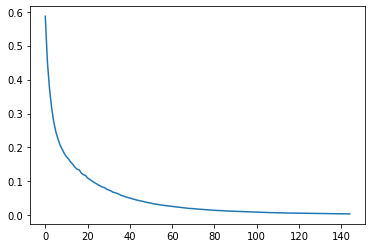




              precision    recall  f1-score   support

           1       0.94      0.96      0.95        47
           2       0.97      0.96      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.938     	      0.957      	   0.962   
  1       0.974     	      0.962      	   0.957   





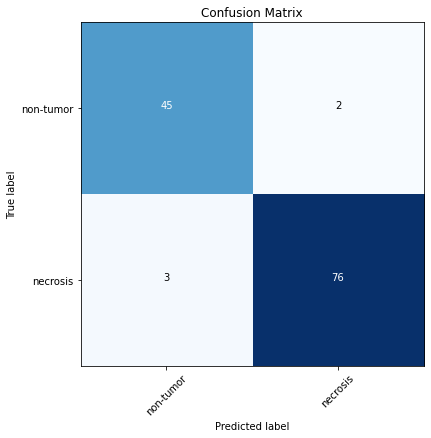

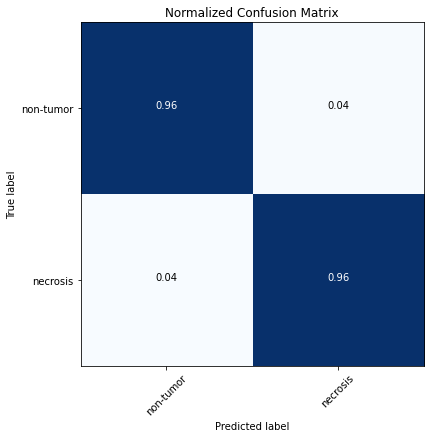

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.96
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.916
Loss value:  0.08053962260396558


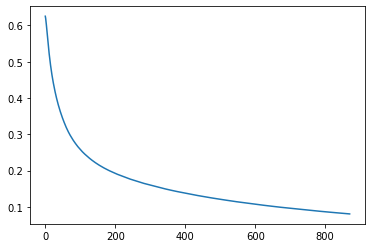




              precision    recall  f1-score   support

           1       0.94      0.96      0.95        47
           2       0.97      0.96      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.938     	      0.957      	   0.962   
  1       0.974     	      0.962      	   0.957   





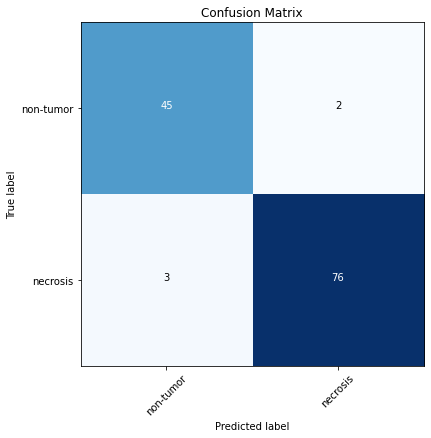

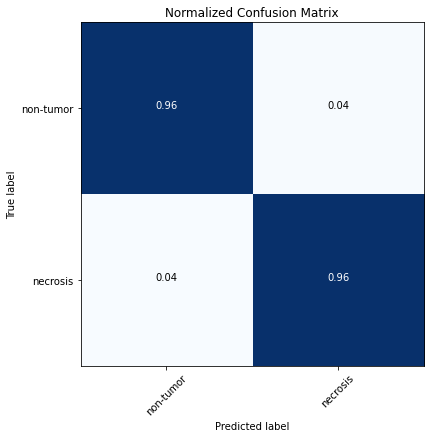

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.952
ROC-AUC score is:  0.98
The Matthews correlation coefficinet (MCC) is:  0.9
Loss value:  0.00012869150842614795



              precision    recall  f1-score   support

           1       0.92      0.96      0.94        47
           2       0.97      0.95      0.96        79

    accuracy                           0.95       126
   macro avg       0.95      0.95      0.95       126
weighted avg       0.95      0.95      0.95       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.918     	      0.957      	   0.949   
  1       0.974     	      0.949      	   0.957   





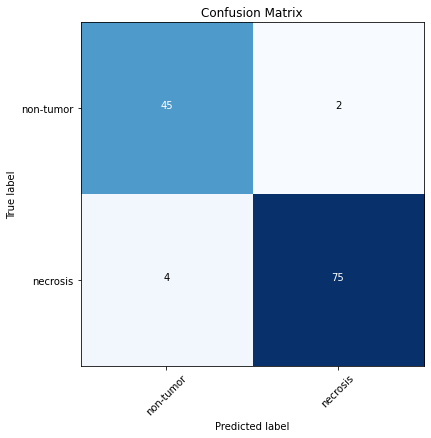

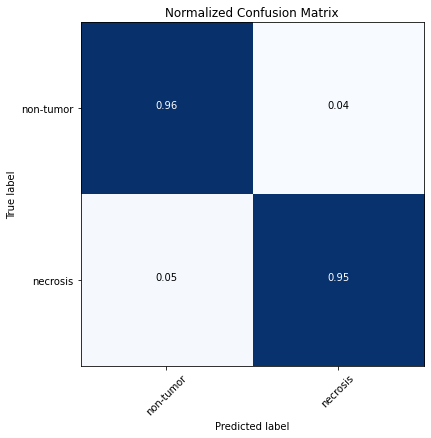

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 400

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 400, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 400)
After applying Mututal information gain, shape for test data:  (126, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.968
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.004128750613506948


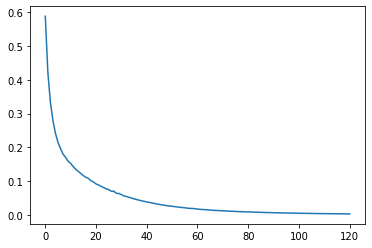




              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.99      0.96      0.97        79

    accuracy                           0.97       126
   macro avg       0.96      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.939     	      0.979      	   0.962   
  1       0.987     	      0.962      	   0.979   





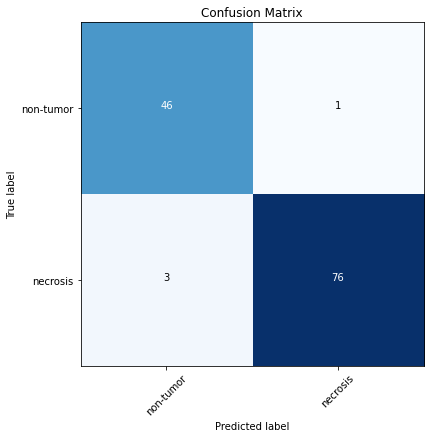

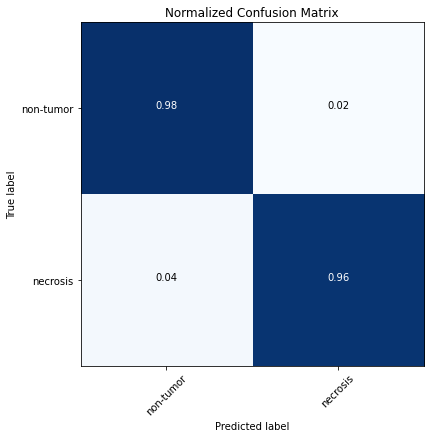

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.976
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  0.07201505481137815


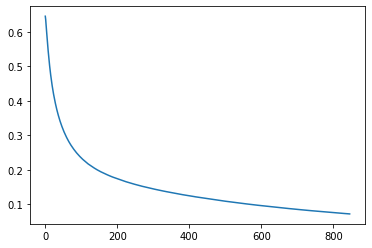




              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





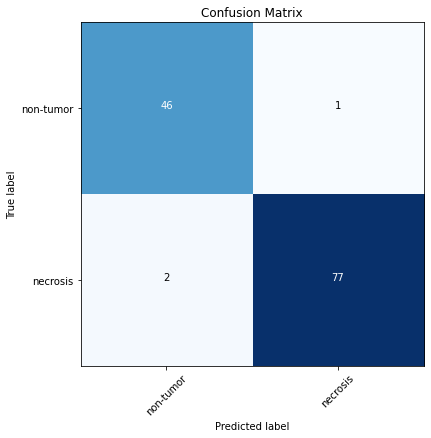

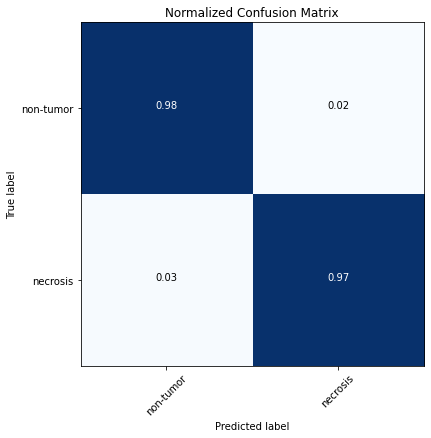

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.915
Accuracy on test data is:  0.952
ROC-AUC score is:  0.981
The Matthews correlation coefficinet (MCC) is:  0.902
Loss value:  0.00013093156810863206



              precision    recall  f1-score   support

           1       0.90      0.98      0.94        47
           2       0.99      0.94      0.96        79

    accuracy                           0.95       126
   macro avg       0.94      0.96      0.95       126
weighted avg       0.96      0.95      0.95       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.902     	      0.979      	   0.937   
  1       0.987     	      0.937      	   0.979   





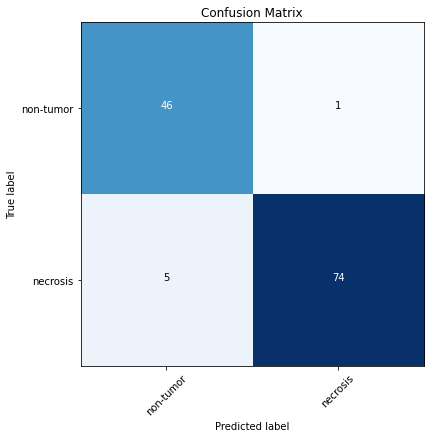

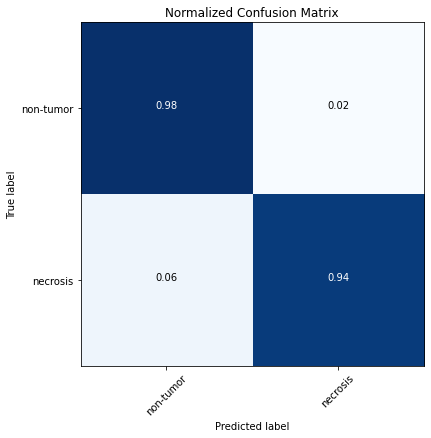

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 400, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 400)
After applying Mututal information gain, shape for test data:  (126, 400)


**adam**

k-fold validation accuracy for k=5 is:  0.952
Accuracy on test data is:  0.968
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  0.003807122971959257


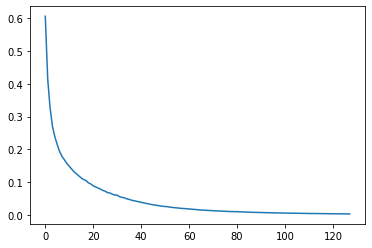




              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





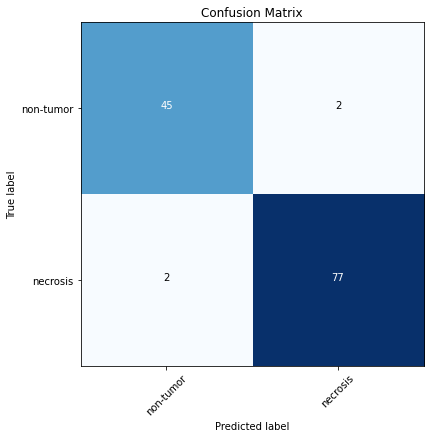

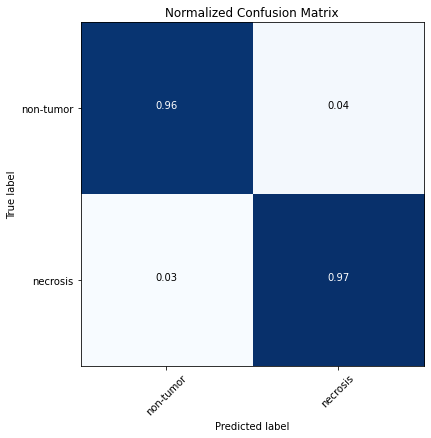

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.96
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.917
Loss value:  0.07356437382128862


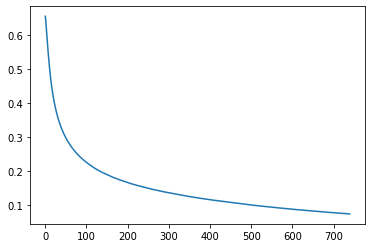




              precision    recall  f1-score   support

           1       0.92      0.98      0.95        47
           2       0.99      0.95      0.97        79

    accuracy                           0.96       126
   macro avg       0.95      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.92     	      0.979      	   0.949   
  1       0.987     	      0.949      	   0.979   





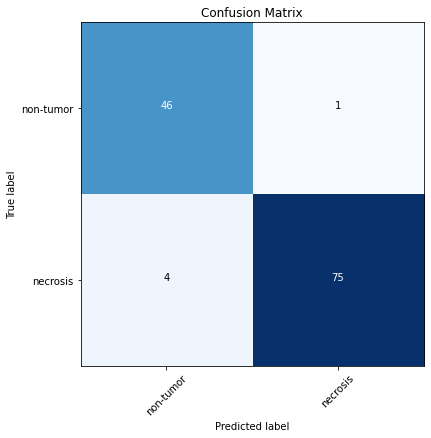

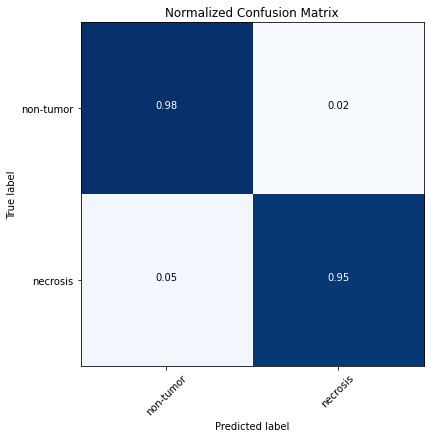

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.936
Accuracy on test data is:  0.968
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  0.00011556344114076073



              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





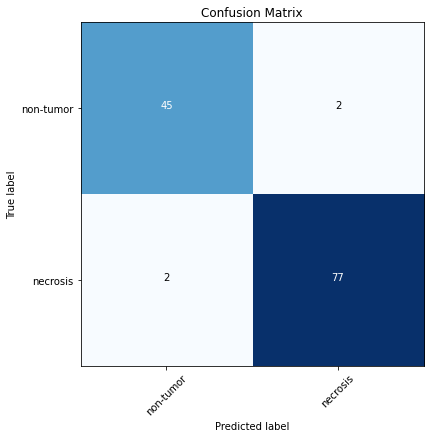

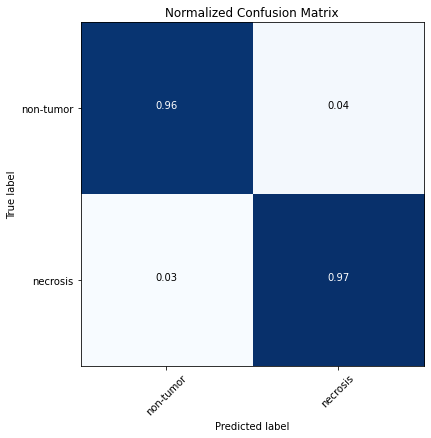

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 500

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 500, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 500)
After applying Mututal information gain, shape for test data:  (126, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.976
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  0.0032272880731057762


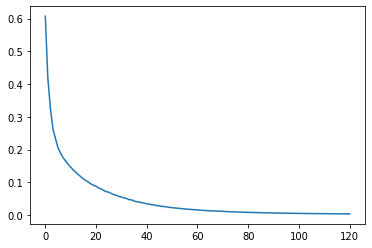




              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





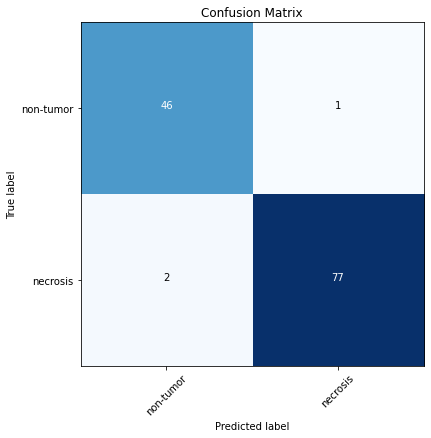

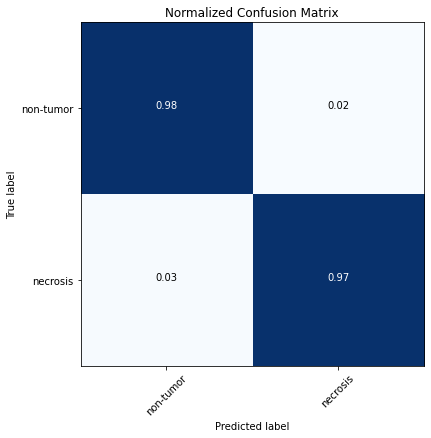

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.976
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  0.06394619000245065


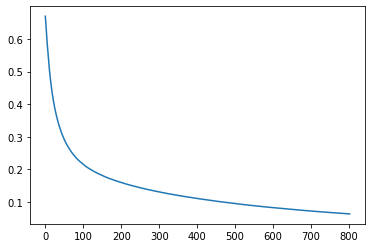




              precision    recall  f1-score   support

           1       0.98      0.96      0.97        47
           2       0.97      0.99      0.98        79

    accuracy                           0.98       126
   macro avg       0.98      0.97      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.978     	      0.957      	   0.987   
  1       0.975     	      0.987      	   0.957   





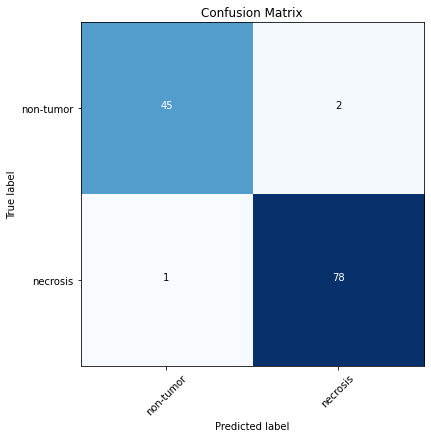

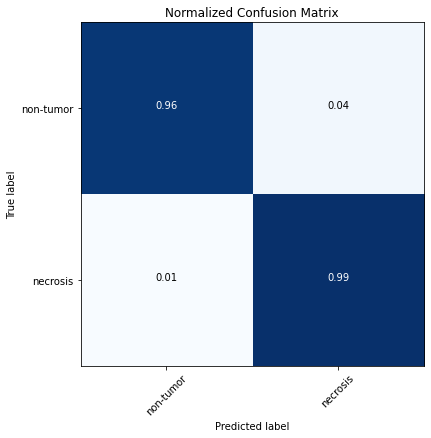

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.927
Accuracy on test data is:  0.976
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  9.81224258340714e-05



              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





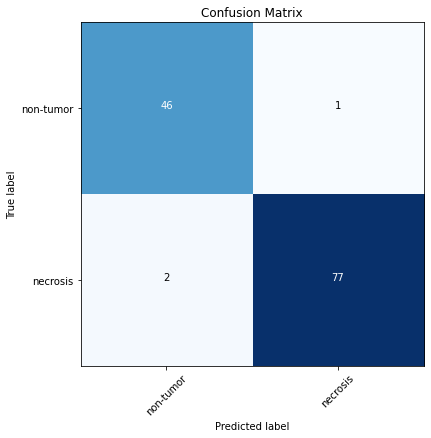

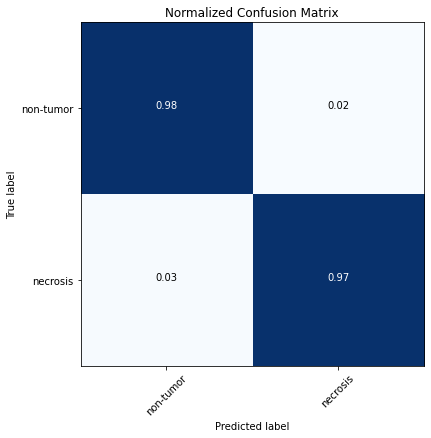

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 500, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 500)
After applying Mututal information gain, shape for test data:  (126, 500)


**adam**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.96
ROC-AUC score is:  0.994
The Matthews correlation coefficinet (MCC) is:  0.916
Loss value:  0.004102252372497908


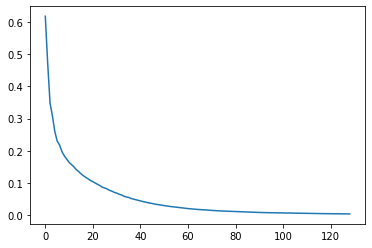




              precision    recall  f1-score   support

           1       0.94      0.96      0.95        47
           2       0.97      0.96      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.938     	      0.957      	   0.962   
  1       0.974     	      0.962      	   0.957   





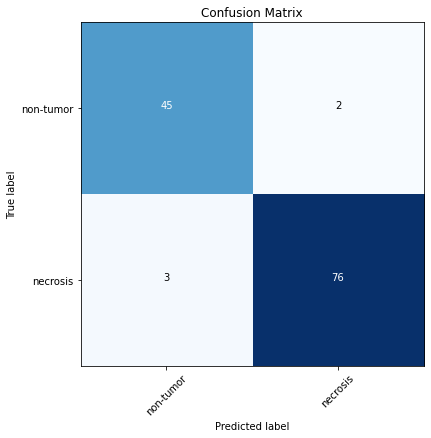

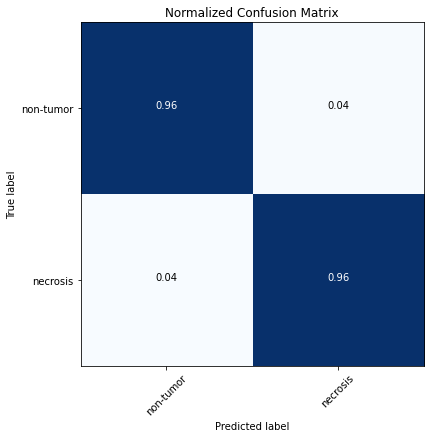

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.968
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.06248934698572275


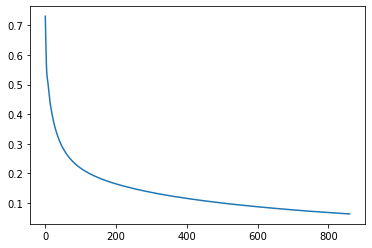




              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.99      0.96      0.97        79

    accuracy                           0.97       126
   macro avg       0.96      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.939     	      0.979      	   0.962   
  1       0.987     	      0.962      	   0.979   





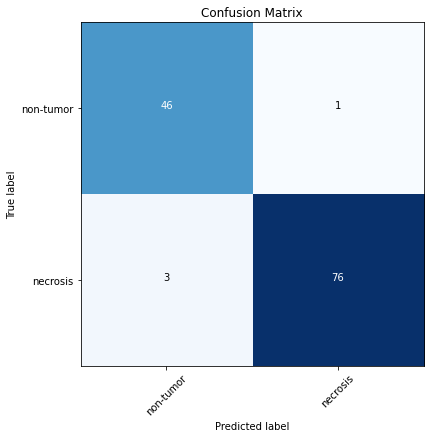

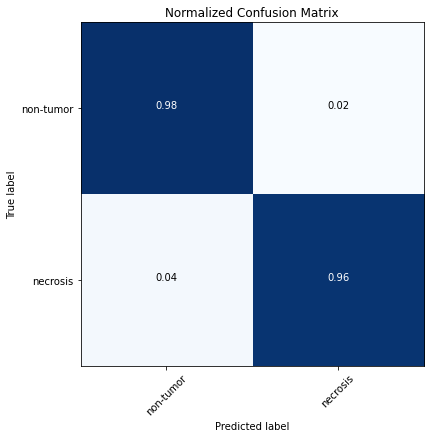

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.96
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.915
Loss value:  0.00015397741007288582



              precision    recall  f1-score   support

           1       0.96      0.94      0.95        47
           2       0.96      0.97      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.936      	   0.975   
  1       0.962     	      0.975      	   0.936   





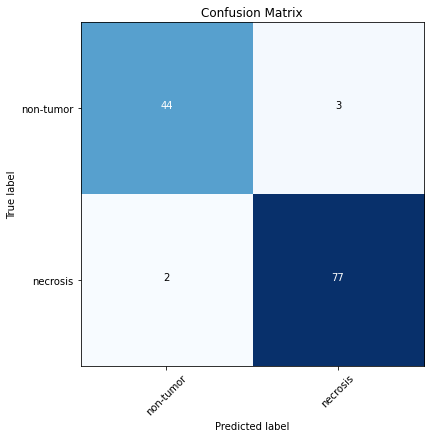

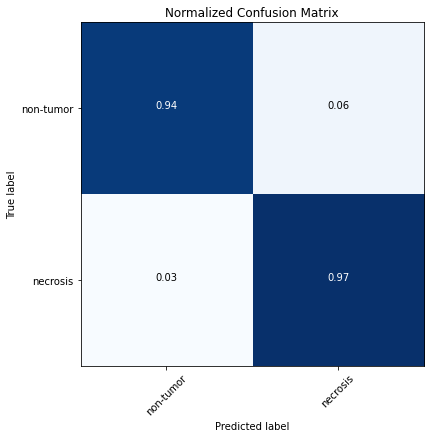

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 600

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 600, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 600)
After applying Mututal information gain, shape for test data:  (126, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.948
Accuracy on test data is:  0.96
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.916
Loss value:  0.0034897938387040907


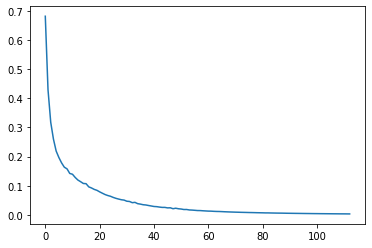




              precision    recall  f1-score   support

           1       0.94      0.96      0.95        47
           2       0.97      0.96      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.938     	      0.957      	   0.962   
  1       0.974     	      0.962      	   0.957   





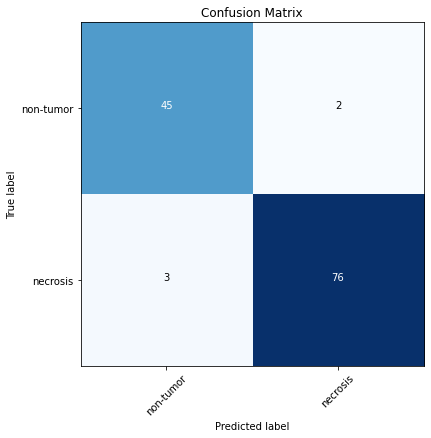

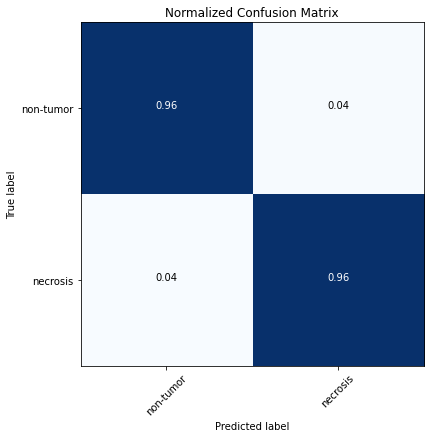

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.976
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  0.05430667143961687


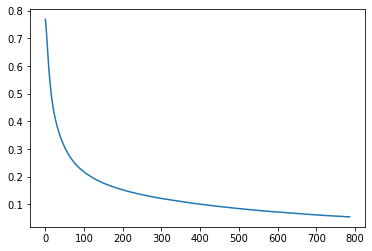




              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





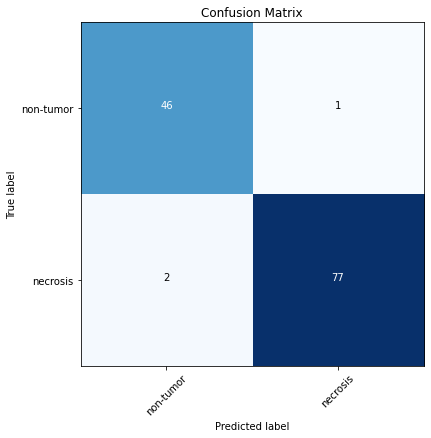

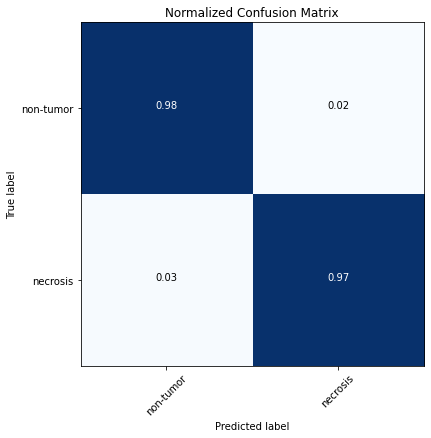

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.968
ROC-AUC score is:  0.982
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  8.532074945936729e-05



              precision    recall  f1-score   support

           1       0.98      0.94      0.96        47
           2       0.96      0.99      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.96      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.978     	      0.936      	   0.987   
  1       0.963     	      0.987      	   0.936   





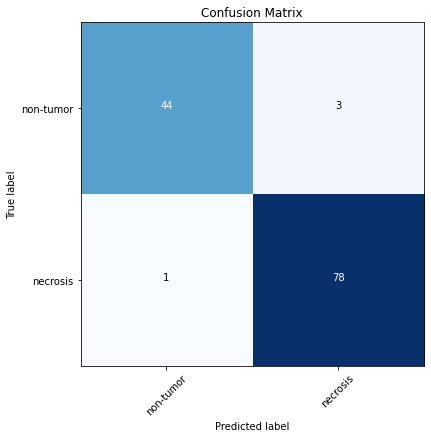

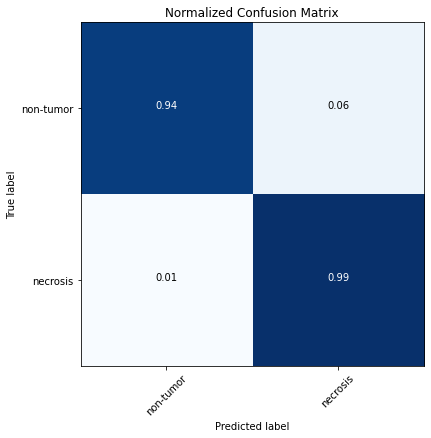

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 600, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 600)
After applying Mututal information gain, shape for test data:  (126, 600)


**adam**

k-fold validation accuracy for k=5 is:  0.948
Accuracy on test data is:  0.968
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  0.002968640134766951


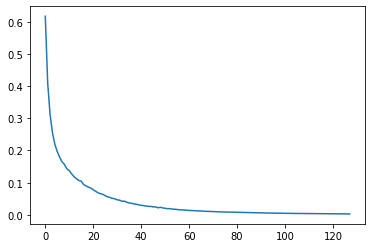




              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





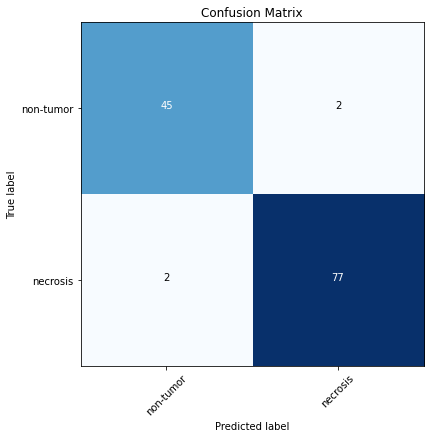

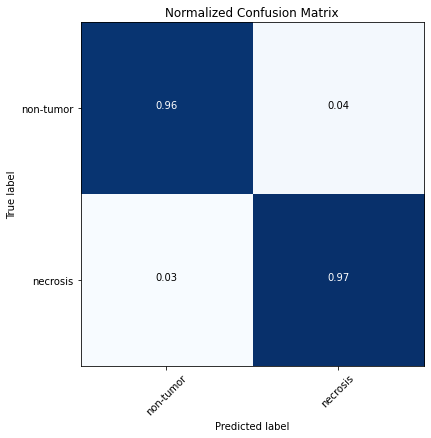

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.927
Accuracy on test data is:  0.968
ROC-AUC score is:  0.987
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.05598356538310703


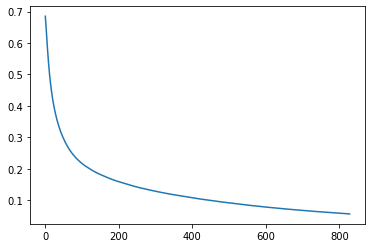




              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.99      0.96      0.97        79

    accuracy                           0.97       126
   macro avg       0.96      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.939     	      0.979      	   0.962   
  1       0.987     	      0.962      	   0.979   





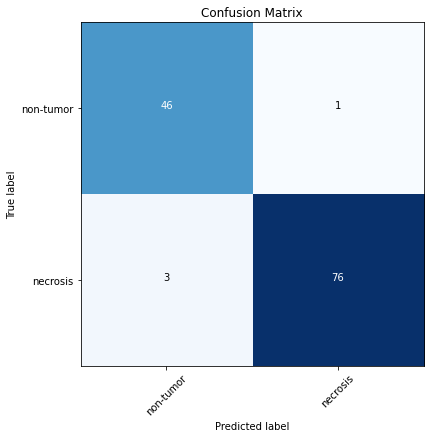

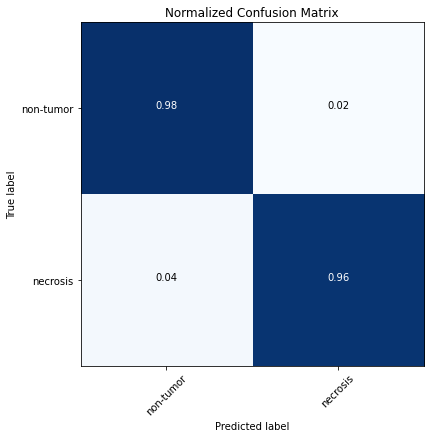

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.927
Accuracy on test data is:  0.976
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  9.179593568579284e-05



              precision    recall  f1-score   support

           1       0.98      0.96      0.97        47
           2       0.97      0.99      0.98        79

    accuracy                           0.98       126
   macro avg       0.98      0.97      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.978     	      0.957      	   0.987   
  1       0.975     	      0.987      	   0.957   





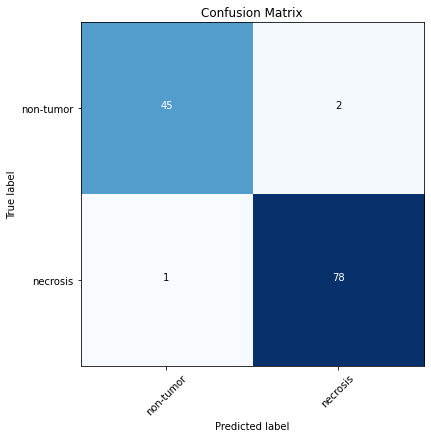

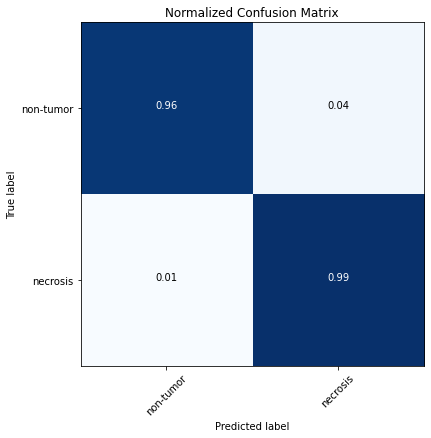

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 700

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 700, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 700)
After applying Mututal information gain, shape for test data:  (126, 700)


**adam**

k-fold validation accuracy for k=5 is:  0.94
Accuracy on test data is:  0.952
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.9
Loss value:  0.002755576506790152


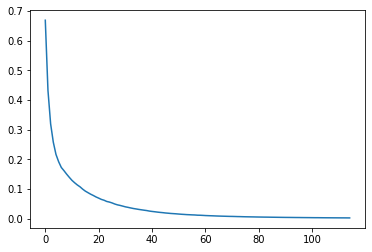




              precision    recall  f1-score   support

           1       0.92      0.96      0.94        47
           2       0.97      0.95      0.96        79

    accuracy                           0.95       126
   macro avg       0.95      0.95      0.95       126
weighted avg       0.95      0.95      0.95       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.918     	      0.957      	   0.949   
  1       0.974     	      0.949      	   0.957   





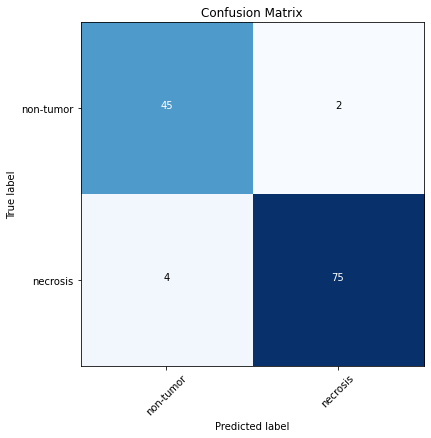

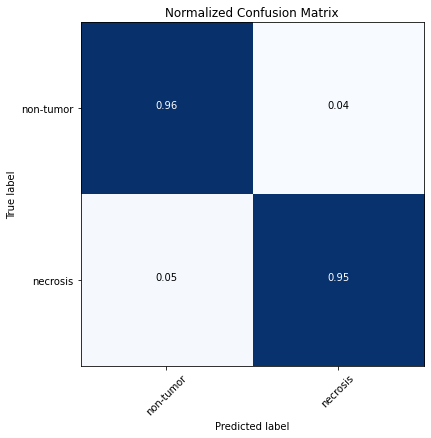

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.931
Accuracy on test data is:  0.976
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  0.05160925212239336


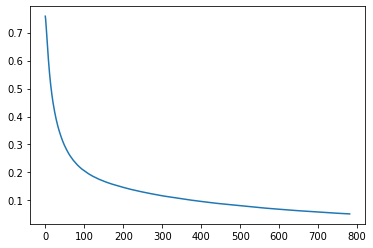




              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





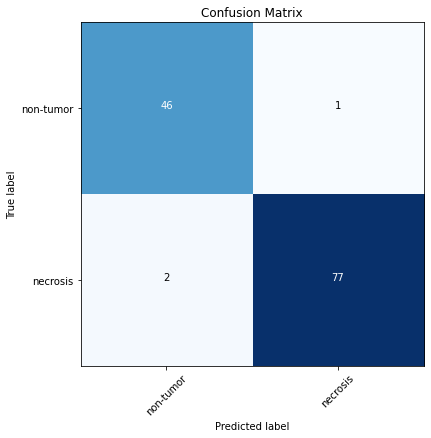

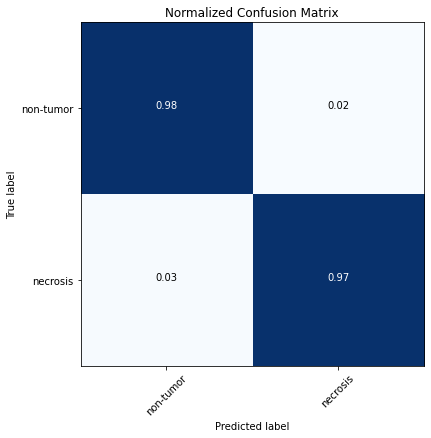

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.936
Accuracy on test data is:  0.96
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.917
Loss value:  6.779001145000219e-05



              precision    recall  f1-score   support

           1       0.92      0.98      0.95        47
           2       0.99      0.95      0.97        79

    accuracy                           0.96       126
   macro avg       0.95      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.92     	      0.979      	   0.949   
  1       0.987     	      0.949      	   0.979   





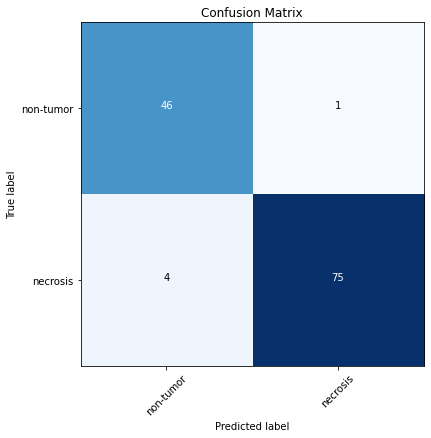

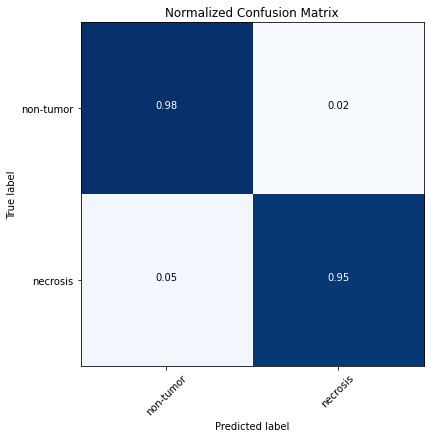

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 700, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 700)
After applying Mututal information gain, shape for test data:  (126, 700)


**adam**

k-fold validation accuracy for k=5 is:  0.946
Accuracy on test data is:  0.968
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  0.0029896378855839324


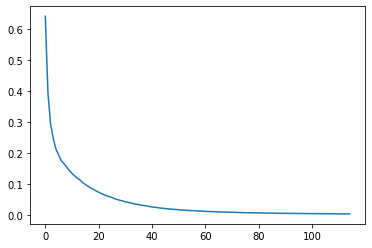




              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





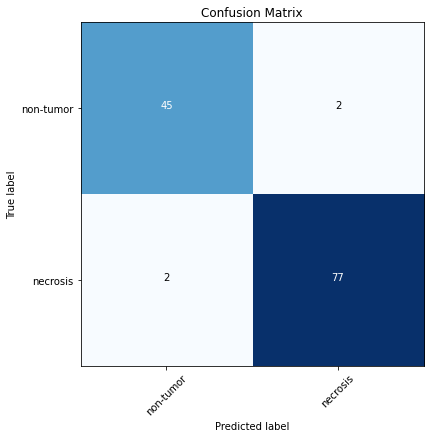

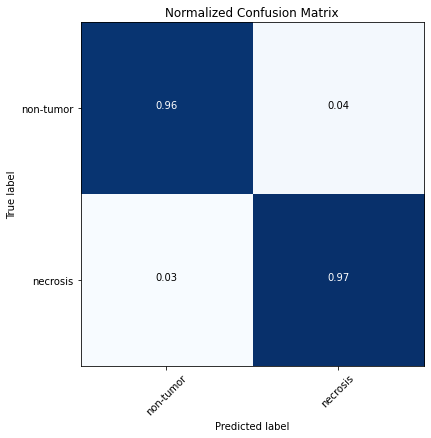

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.929
Accuracy on test data is:  0.968
ROC-AUC score is:  0.986
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.05534900799061771


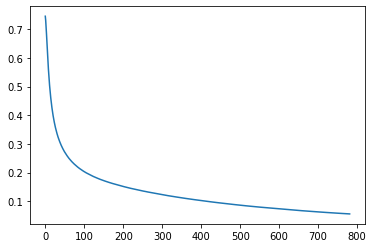




              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.99      0.96      0.97        79

    accuracy                           0.97       126
   macro avg       0.96      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.939     	      0.979      	   0.962   
  1       0.987     	      0.962      	   0.979   





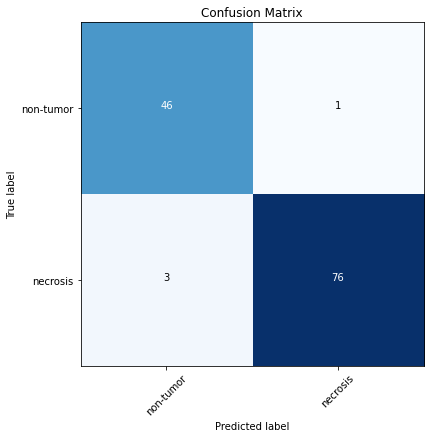

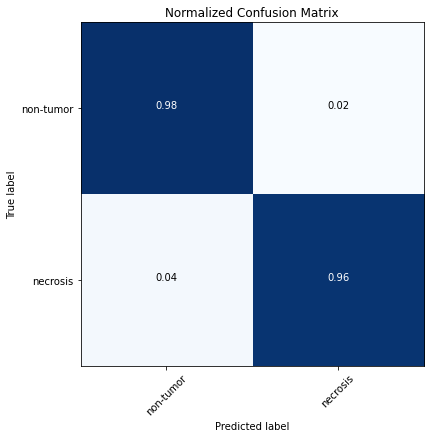

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 800

##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 800, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 800)
After applying Mututal information gain, shape for test data:  (126, 800)


**adam**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.96
ROC-AUC score is:  0.995
The Matthews correlation coefficinet (MCC) is:  0.917
Loss value:  0.0031820518043348496


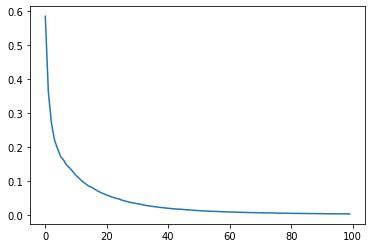




              precision    recall  f1-score   support

           1       0.92      0.98      0.95        47
           2       0.99      0.95      0.97        79

    accuracy                           0.96       126
   macro avg       0.95      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0        0.92     	      0.979      	   0.949   
  1       0.987     	      0.949      	   0.979   





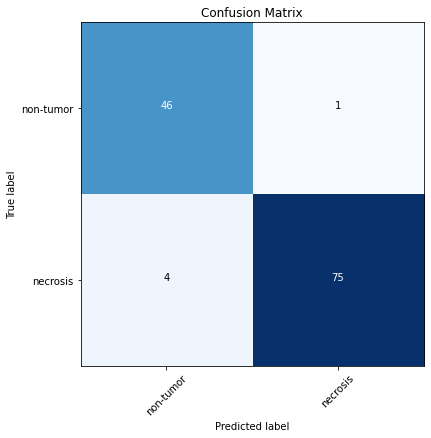

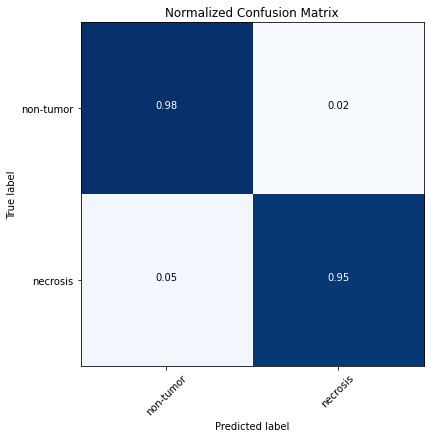

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.968
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.933
Loss value:  0.04525061081455817


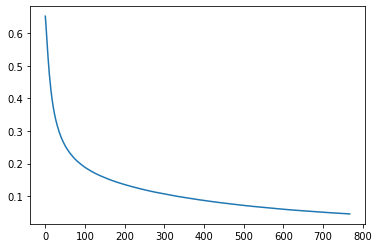




              precision    recall  f1-score   support

           1       0.94      0.98      0.96        47
           2       0.99      0.96      0.97        79

    accuracy                           0.97       126
   macro avg       0.96      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.939     	      0.979      	   0.962   
  1       0.987     	      0.962      	   0.979   





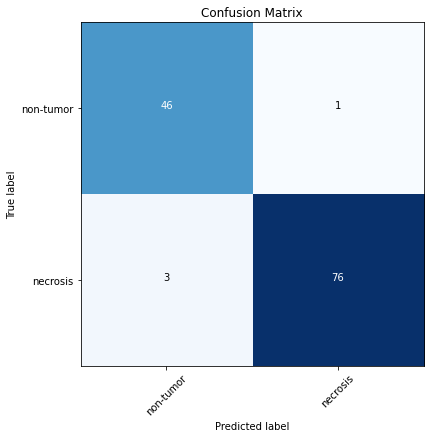

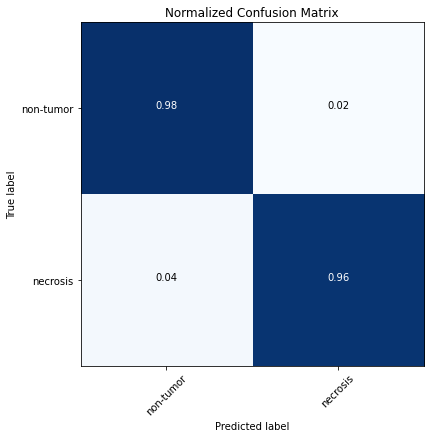

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.94
Accuracy on test data is:  0.968
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  9.121874569618837e-05



              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





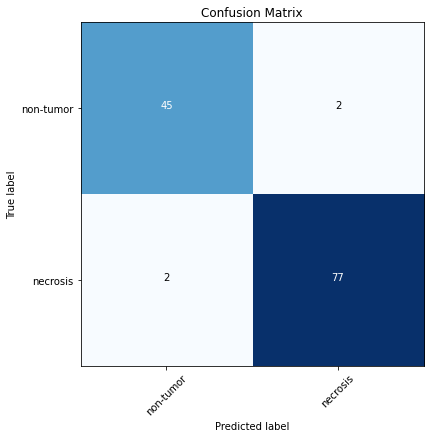

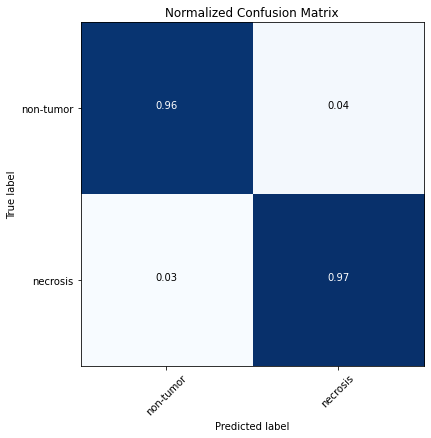

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 800, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 800)
After applying Mututal information gain, shape for test data:  (126, 800)


**adam**

k-fold validation accuracy for k=5 is:  0.948
Accuracy on test data is:  0.976
ROC-AUC score is:  0.992
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  0.0028333821229716708


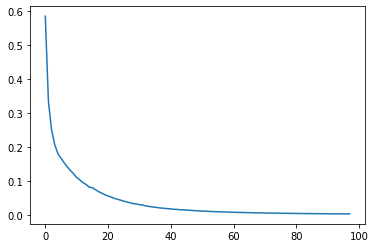




              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





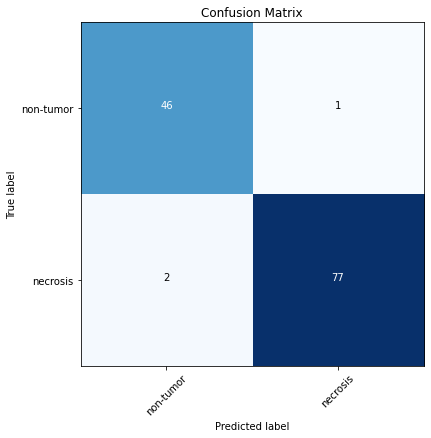

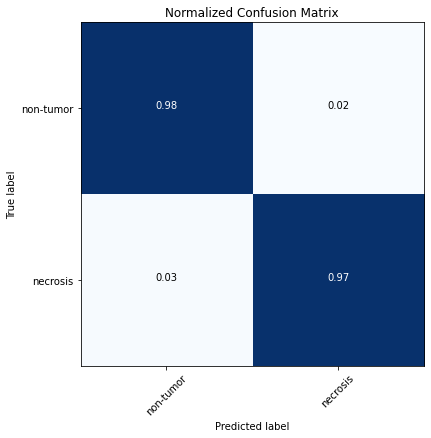

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.976
ROC-AUC score is:  0.989
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  0.04419396895540679


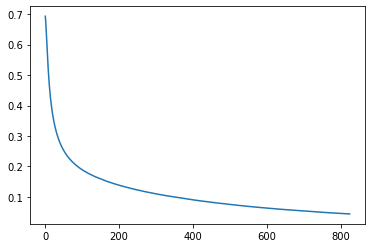




              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





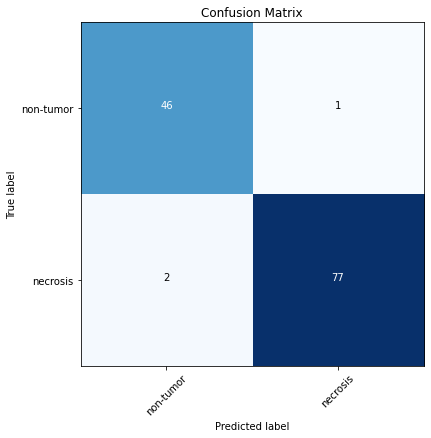

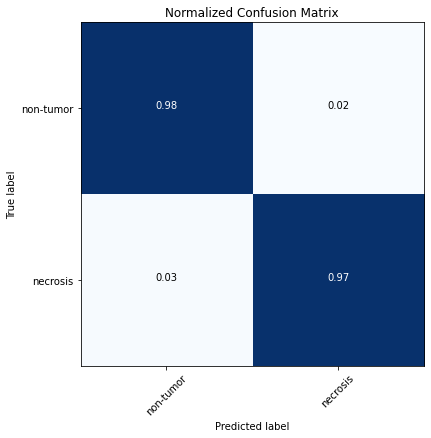

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.936
Accuracy on test data is:  0.976
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  6.505380739896622e-05



              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





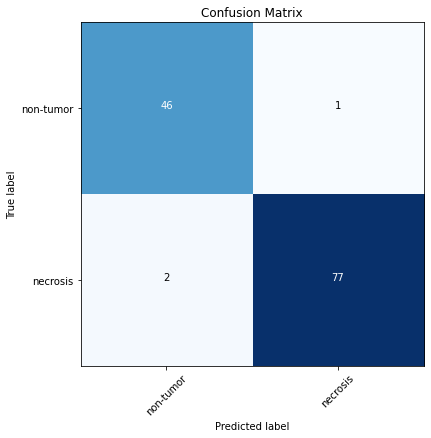

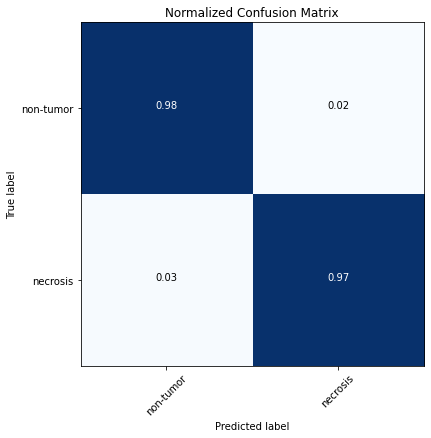

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

#### 900


##### gini

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'gini', num_feat= 900, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 900)
After applying Mututal information gain, shape for test data:  (126, 900)


**adam**

k-fold validation accuracy for k=5 is:  0.938
Accuracy on test data is:  0.968
ROC-AUC score is:  0.993
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  0.0034543599303197415


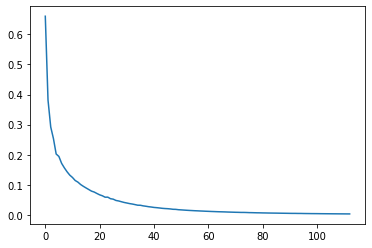




              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





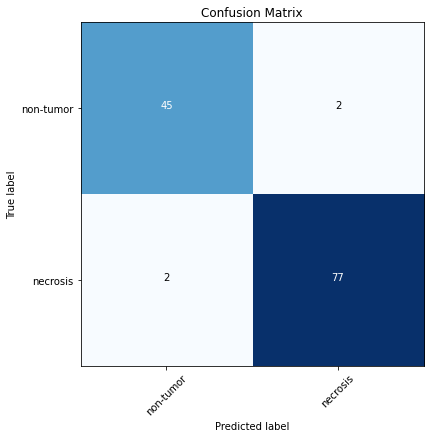

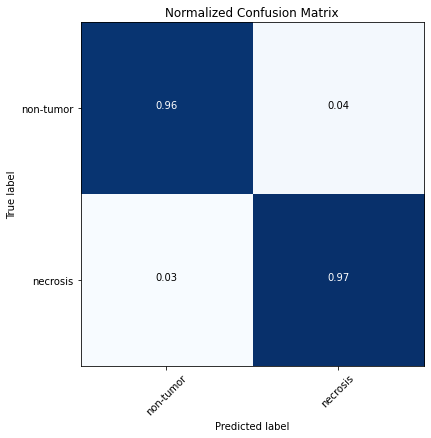

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.942
Accuracy on test data is:  0.96
ROC-AUC score is:  0.988
The Matthews correlation coefficinet (MCC) is:  0.916
Loss value:  0.05018773557742028


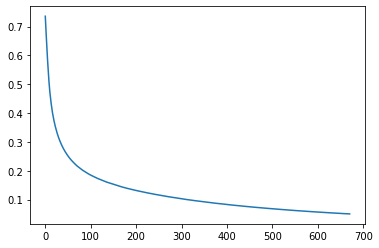




              precision    recall  f1-score   support

           1       0.94      0.96      0.95        47
           2       0.97      0.96      0.97        79

    accuracy                           0.96       126
   macro avg       0.96      0.96      0.96       126
weighted avg       0.96      0.96      0.96       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.938     	      0.957      	   0.962   
  1       0.974     	      0.962      	   0.957   





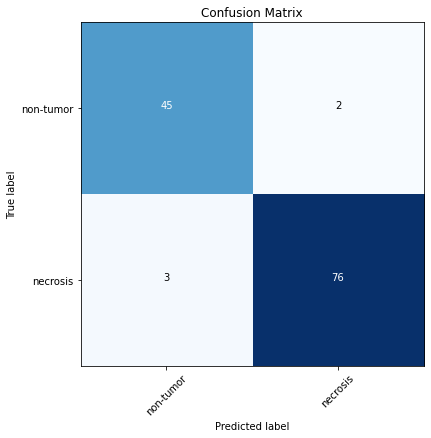

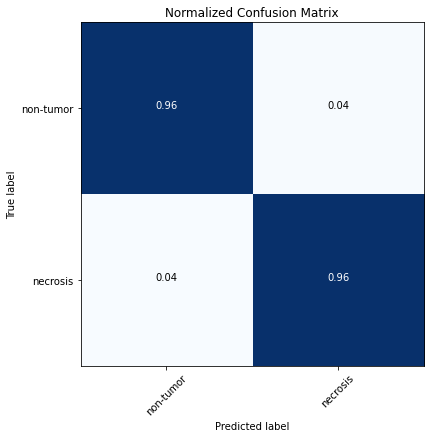

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.952
ROC-AUC score is:  0.983
The Matthews correlation coefficinet (MCC) is:  0.898
Loss value:  5.485815373911727e-05



              precision    recall  f1-score   support

           1       0.94      0.94      0.94        47
           2       0.96      0.96      0.96        79

    accuracy                           0.95       126
   macro avg       0.95      0.95      0.95       126
weighted avg       0.95      0.95      0.95       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.936     	      0.936      	   0.962   
  1       0.962     	      0.962      	   0.936   





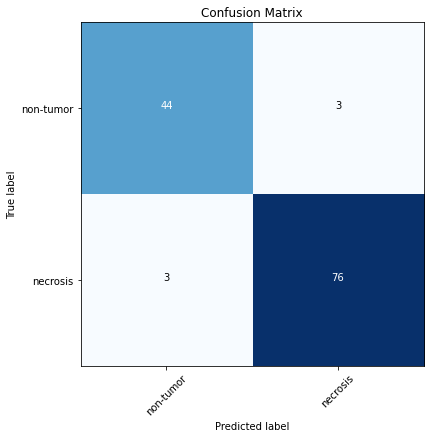

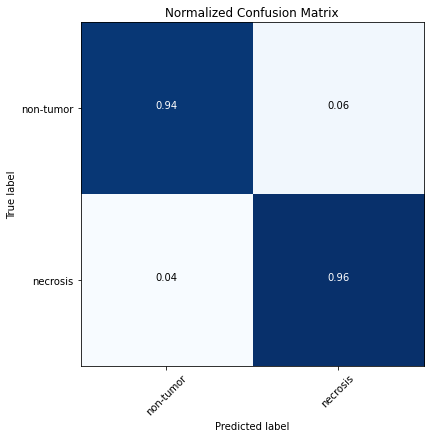

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)

##### entropy

In [ ]:
# getting 100 features using gini
train_x, test_x = feat_select_bin(criterion_n= 'entropy', num_feat= 900, X_train= train_x_b4, y_train= train_y_b4 ,X_test= test_x_b4) 

After applying mutual information gain, shape for train data:  (481, 900)
After applying Mututal information gain, shape for test data:  (126, 900)


**adam**

k-fold validation accuracy for k=5 is:  0.944
Accuracy on test data is:  0.968
ROC-AUC score is:  0.991
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  0.0026994719442508487


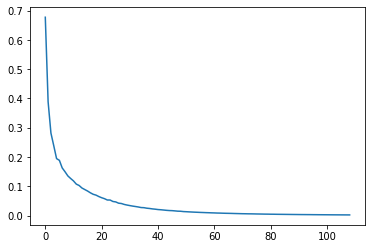




              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





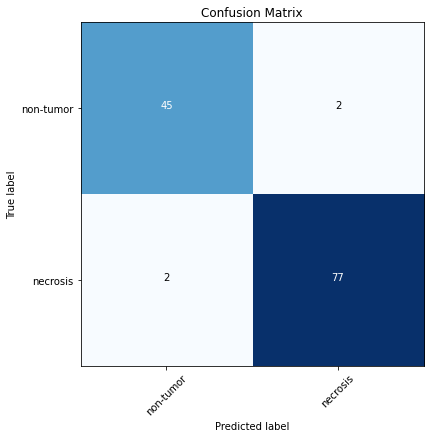

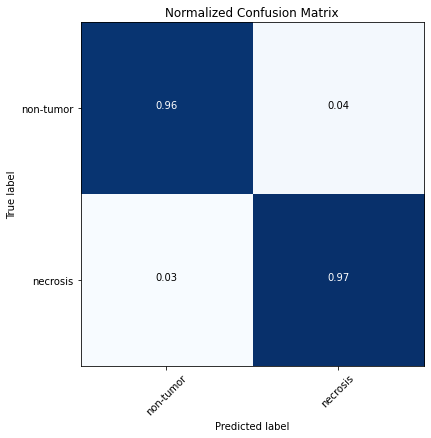

In [ ]:
# for adam or SGD
get_final_result(opt_name= "adam", num_iter=500, classes= classes)

**sgd**

k-fold validation accuracy for k=5 is:  0.933
Accuracy on test data is:  0.976
ROC-AUC score is:  0.985
The Matthews correlation coefficinet (MCC) is:  0.949
Loss value:  0.04599055167891075


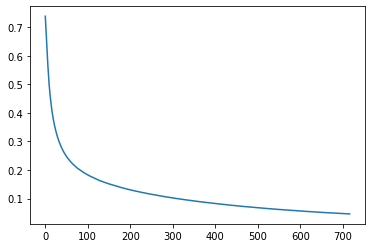




              precision    recall  f1-score   support

           1       0.96      0.98      0.97        47
           2       0.99      0.97      0.98        79

    accuracy                           0.98       126
   macro avg       0.97      0.98      0.97       126
weighted avg       0.98      0.98      0.98       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.958     	      0.979      	   0.975   
  1       0.987     	      0.975      	   0.979   





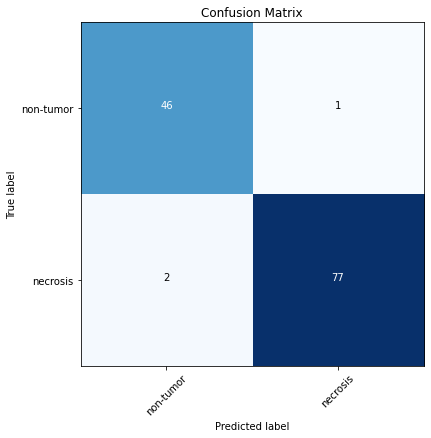

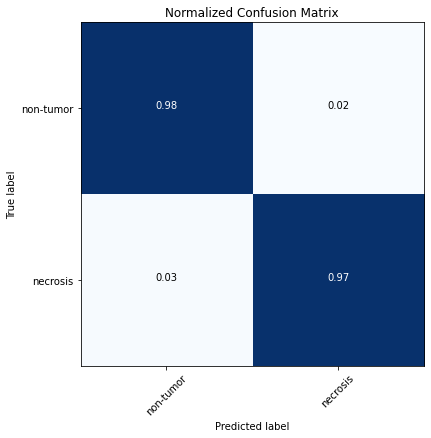

In [ ]:
# for adam or SGD
get_final_result(opt_name= "sgd", num_iter=1000, classes= classes)

**lbgfs**

k-fold validation accuracy for k=5 is:  0.925
Accuracy on test data is:  0.968
ROC-AUC score is:  0.984
The Matthews correlation coefficinet (MCC) is:  0.932
Loss value:  5.900708710933297e-05



              precision    recall  f1-score   support

           1       0.96      0.96      0.96        47
           2       0.97      0.97      0.97        79

    accuracy                           0.97       126
   macro avg       0.97      0.97      0.97       126
weighted avg       0.97      0.97      0.97       126




class 	precision 	sensitivity(recall) 	specificity 
------------------------------------------------------------------------------
  0       0.957     	      0.957      	   0.975   
  1       0.975     	      0.975      	   0.957   





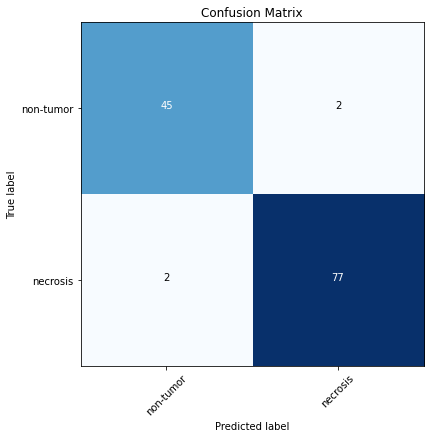

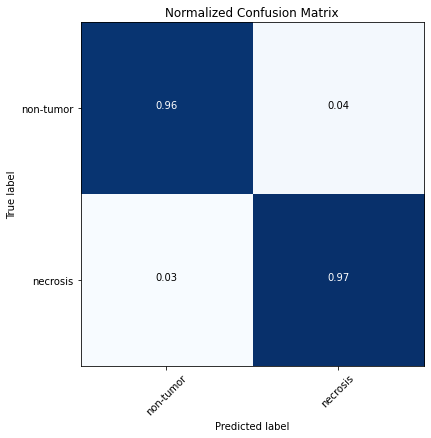

In [ ]:
# for adam or SGD
get_final_result(opt_name= "lbfgs", num_iter=300, classes= classes)